# Imports and preliminaries

In [196]:
import sklearn, ast, json, itertools, math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection, metrics
from sklearn.svm import SVC
from scipy.stats import pearsonr, spearmanr, f_oneway, kruskal
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

# Cleaning: 

In [197]:
#read in dataset
# data_df = pd.read_pickle('data_multiprocess.pkl')
data_df = pd.read_pickle('2013_17_data_df.pkl')
display(data_df.head())

Unnamed: 0  bnc_docs  bnc_freq conll_ent_label nuts_ent_label      pos  \
0      203764       5.0       6.0             NaN            NaN      crd   
1      130587       9.0      12.0             NaN            NaN  nn2-vvz   
2        8144     551.0     916.0             NaN            NaN  vvd-vvn   
3      117535      15.0      15.0             NaN            NaN      vvi   
4       90431      20.0      23.0             NaN            NaN      vvd   

  source        word                                               freq  \
0    bnc      348000  [(1356992928, nan), (1364882157, nan), (137277...   
1    bnc      pixels  [(1356992928, 261), (1364882157, 182), (137277...   
2    bnc  remembered  [(1356992928, 145), (1364882157, 114), (137277...   
3    bnc      butter  [(1356992928, 105), (1364882157, 118), (137277...   
4    bnc    recurred  [(1356992928, nan), (1364882157, nan), (137277...   

                                            rel_freq  \
0  [(1356992928, nan), (1364882157, nan), (137277...   
1  [(1356992928, 4.53390737348835e-05), (13648821...   
2  [(1356992928, 2.51883742971575e-05), (13648821...   
3  [(1356992928, 1.8239857249665777e-05), (136488...   
4  [(1356992928, nan), (1364882157, nan), (137277...   

                                                rank  \
0  [(1356992928, nan), (1364882157, nan), (137277...   
1  [(1356992928, 1974), (1364882157, 2671), (1372...   
2  [(1356992928, 3014), (1364882157, 3699), (1372...   
3  [(1356992928, 3764), (1364882157, 3609), (1372...   
4  [(1356992928, nan), (1364882157, nan), (137277...   

                                         normed_rank  \
0  [(1356992928, nan), (1364882157, nan), (137277...   
1  [(1356992928, 0.0003429093162937166), (1364882...   
2  [(1356992928, 0.0005235707595285014), (1364882...   
3  [(1356992928, 0.0006538554541689713), (1364882...   
4  [(1356992928, nan), (1364882157, nan), (137277...   

                                                 d_u  \
0  [(1356992928, nan), (1364882157, nan), (137277...   
1  [(1356992928, 0.6580794778848654), (1364882157...   
2  [(1356992928, 0.9667810790213889), (1364882157...   
3  [(1356992928, 0.8697726062767838), (1364882157...   
4  [(1356992928, nan), (1364882157, nan), (137277...   

                                                 d_t  \
0  [(1356992928, nan), (1364882157, nan), (137277...   
1  [(1356992928, 0.7221179042914326), (1364882157...   
2  [(1356992928, 0.945657548249298), (1364882157,...   
3  [(1356992928, 0.7688505922541659), (1364882157...   
4  [(1356992928, nan), (1364882157, nan), (137277...   

                                                 d_l d_s_25 d_s_50 d_s_75  \
0  [(1356992928, nan), (1364882157, nan), (137277...     []     []     []   
1  [(1356992928, -0.07533398383834733), (13648821...     []     []     []   
2  [(1356992928, -0.04320341563486085), (13648821...     []     []     []   
3  [(1356992928, 0.030537249978431547), (13648821...     []     []     []   
4  [(1356992928, nan), (1364882157, nan), (137277...     []     []     []   

  d_s_mean  
0       []  
1       []  
2       []  
3       []  
4       []

In [198]:
if 'no_values' not in data_df.columns: 
    data_df['no_values'] = data_df['freq'].map(lambda x: all(np.isnan(y[1]) for y in x))
    display(data_df['no_values'].value_counts())
    data_df = data_df[data_df['no_values'] == False]

True     6478
False    5068
Name: no_values, dtype: int64

In [199]:
#drop unneeded columns (including rank for now)
data_df = data_df.drop(['Unnamed: 0', 'no_values', 'bnc_docs', 'bnc_freq', 'conll_ent_label', 'nuts_ent_label', 'pos'], axis=1)
display(data_df.head())

source        word                                               freq  \
1    bnc      pixels  [(1356992928, 261), (1364882157, 182), (137277...   
2    bnc  remembered  [(1356992928, 145), (1364882157, 114), (137277...   
3    bnc      butter  [(1356992928, 105), (1364882157, 118), (137277...   
6    bnc      eroded  [(1356992928, nan), (1364882157, nan), (137277...   
8    bnc    measures  [(1356992928, 35), (1364882157, 43), (13727713...   

                                            rel_freq  \
1  [(1356992928, 4.53390737348835e-05), (13648821...   
2  [(1356992928, 2.51883742971575e-05), (13648821...   
3  [(1356992928, 1.8239857249665777e-05), (136488...   
6  [(1356992928, nan), (1364882157, nan), (137277...   
8  [(1356992928, 6.0799524165552585e-06), (136488...   

                                                rank  \
1  [(1356992928, 1974), (1364882157, 2671), (1372...   
2  [(1356992928, 3014), (1364882157, 3699), (1372...   
3  [(1356992928, 3764), (1364882157, 3609), (1372...   
6  [(1356992928, 29001), (1364882157, 22284), (13...   
8  [(1356992928, 7679), (1364882157, 6876), (1372...   

                                         normed_rank  \
1  [(1356992928, 0.0003429093162937166), (1364882...   
2  [(1356992928, 0.0005235707595285014), (1364882...   
3  [(1356992928, 0.0006538554541689713), (1364882...   
6  [(1356992928, 0.0050378485723576874), (1364882...   
8  [(1356992928, 0.0013339415601922237), (1364882...   

                                                 d_u  \
1  [(1356992928, 0.6580794778848654), (1364882157...   
2  [(1356992928, 0.9667810790213889), (1364882157...   
3  [(1356992928, 0.8697726062767838), (1364882157...   
6  [(1356992928, nan), (1364882157, nan), (137277...   
8  [(1356992928, 0.8900644349897722), (1364882157...   

                                                 d_t  \
1  [(1356992928, 0.7221179042914326), (1364882157...   
2  [(1356992928, 0.945657548249298), (1364882157,...   
3  [(1356992928, 0.7688505922541659), (1364882157...   
6  [(1356992928, nan), (1364882157, nan), (137277...   
8  [(1356992928, 0.8968528293757784), (1364882157...   

                                                 d_l d_s_25 d_s_50 d_s_75  \
1  [(1356992928, -0.07533398383834733), (13648821...     []     []     []   
2  [(1356992928, -0.04320341563486085), (13648821...     []     []     []   
3  [(1356992928, 0.030537249978431547), (13648821...     []     []     []   
6  [(1356992928, 0.04073392480507776), (136488215...     []     []     []   
8  [(1356992928, 0.09373050813087946), (136488215...     []     []     []   

  d_s_mean  
1       []  
2       []  
3       []  
6       []  
8       []

In [200]:
#extract time steps and eliminate them from all other columns
data_df['time_steps'] = data_df['freq'].map(lambda x: [value[0] for value in x])

# time_cols = ['freq', 'rel_freq', 'd_l', 'd_u', 'd_t', 'd_s_25', 'd_s_50', 'd_s_75', 'd_s_mean', 'rank', 'normed_rank']
time_cols = ['freq', 'rel_freq', 'd_l', 'd_u', 'd_t', 'rank', 'normed_rank']

for col in time_cols: 
    data_df[col] = data_df[col].map(lambda x: [value[1] for value in x])

display(data_df.head())

source        word                                               freq  \
1    bnc      pixels  [261, 182, 272, 267, 268, 307, 552, 460, 382, ...   
2    bnc  remembered  [145, 114, 140, 122, 111, 101, 151, 118, 175, ...   
3    bnc      butter  [105, 118, 119, 90, 83, 90, 134, 117, 124, 153...   
6    bnc      eroded  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
8    bnc    measures  [35, 43, 50, 56, 31, 40, 106, 66, 88, 121, 139...   

                                            rel_freq  \
1  [4.53390737348835e-05, 3.0354804298240288e-05,...   
2  [2.51883742971575e-05, 1.901344884615051e-05, ...   
3  [1.8239857249665777e-05, 1.968058740215579e-05...   
6  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
8  [6.0799524165552585e-06, 7.171739477056772e-06...   

                                                rank  \
1  [1974, 2671, 2220, 2195, 2082, 2030, 1815, 187...   
2  [3014, 3699, 3576, 3782, 3869, 4375, 4369, 472...   
3  [3764, 3609, 3963, 4591, 4734, 4703, 4732, 476...   
6  [29001, 22284, 24291, 36458, 52899, 25924, 352...   
8  [7679, 6876, 6937, 6201, 8678, 7793, 5468, 676...   

                                         normed_rank  \
1  [0.0003429093162937166, 0.00044548177077252644...   
2  [0.0005235707595285014, 0.0006169363796658837,...   
3  [0.0006538554541689713, 0.0006019257621557648,...   
6  [0.0050378485723576874, 0.0037166288955054207,...   
8  [0.0013339415601922237, 0.0011468111777730781,...   

                                                 d_u  \
1  [0.6580794778848654, 0.6855930375766428, 0.691...   
2  [0.9667810790213889, 0.9541702549461396, 0.922...   
3  [0.8697726062767838, 0.7600244951107168, 0.845...   
6  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
8  [0.8900644349897722, 0.915284042411943, 0.9801...   

                                                 d_t  \
1  [0.7221179042914326, 0.7798557556912029, 0.688...   
2  [0.945657548249298, 0.9143447671892604, 0.9367...   
3  [0.7688505922541659, 0.8834725469683474, 0.861...   
6  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
8  [0.8968528293757784, 0.8896589464730378, 0.963...   

                                                 d_l d_s_25 d_s_50 d_s_75  \
1  [-0.07533398383834733, 0.04796938031815756, 0....     []     []     []   
2  [-0.04320341563486085, -0.06776540783676044, -...     []     []     []   
3  [0.030537249978431547, -0.03971446518984756, 0...     []     []     []   
6  [0.04073392480507776, 0.05839377622991204, 0.0...     []     []     []   
8  [0.09373050813087946, 0.004380106838015152, 0....     []     []     []   

  d_s_mean                                         time_steps  
1       []  [1356992928, 1364882157, 1372771386, 138066061...  
2       []  [1356992928, 1364882157, 1372771386, 138066061...  
3       []  [1356992928, 1364882157, 1372771386, 138066061...  
6       []  [1356992928, 1364882157, 1372771386, 138066061...  
8       []  [1356992928, 1364882157, 1372771386, 138066061...

In [56]:
# #filter to instances that have at least six time steps worth of data
# data_df['x_values'] = data_df['freq'].map(lambda x: len(x) - sum(math.isnan(y) for y in x))
# display(data_df['x_values'].value_counts())
# data_df = data_df[data_df['x_values'] >= 6]
# display(data_df.shape)

In [202]:
#add logs
data_df['log_freq'] = data_df['freq'].map(lambda x: [np.log(value) for value in x])
data_df['log_rel_freq'] = data_df['rel_freq'].map(lambda x: [np.log(value) for value in x])
data_df['log_rank'] = data_df['rank'].map(lambda x: [np.log(value) for value in x])
data_df['log_normed_rank'] = data_df['normed_rank'].map(lambda x: [np.log(value) for value in x])


#add diffs, np.nan added at the beginning to preserve lengths
data_df['log_freq_diff'] = data_df['log_freq'].map(lambda x: [np.nan] + np.diff(x).tolist())
data_df['log_rel_freq_diff'] = data_df['log_rel_freq'].map(lambda x: [np.nan] + np.diff(x).tolist())
data_df['freq_diff'] = data_df['freq'].map(lambda x: [np.nan] + np.diff(x).tolist())
data_df['log_rank_diff'] = data_df['log_rank'].map(lambda x: [np.nan] + np.diff(x).tolist())
data_df['log_normed_rank_diff'] = data_df['log_normed_rank'].map(lambda x: [np.nan] + np.diff(x).tolist())

display(data_df.head())

source        word                                               freq  \
1    bnc      pixels  [261, 182, 272, 267, 268, 307, 552, 460, 382, ...   
2    bnc  remembered  [145, 114, 140, 122, 111, 101, 151, 118, 175, ...   
3    bnc      butter  [105, 118, 119, 90, 83, 90, 134, 117, 124, 153...   
6    bnc      eroded  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
8    bnc    measures  [35, 43, 50, 56, 31, 40, 106, 66, 88, 121, 139...   

                                            rel_freq  \
1  [4.53390737348835e-05, 3.0354804298240288e-05,...   
2  [2.51883742971575e-05, 1.901344884615051e-05, ...   
3  [1.8239857249665777e-05, 1.968058740215579e-05...   
6  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
8  [6.0799524165552585e-06, 7.171739477056772e-06...   

                                                rank  \
1  [1974, 2671, 2220, 2195, 2082, 2030, 1815, 187...   
2  [3014, 3699, 3576, 3782, 3869, 4375, 4369, 472...   
3  [3764, 3609, 3963, 4591, 4734, 4703, 4732, 476...   
6  [29001, 22284, 24291, 36458, 52899, 25924, 352...   
8  [7679, 6876, 6937, 6201, 8678, 7793, 5468, 676...   

                                         normed_rank  \
1  [0.0003429093162937166, 0.00044548177077252644...   
2  [0.0005235707595285014, 0.0006169363796658837,...   
3  [0.0006538554541689713, 0.0006019257621557648,...   
6  [0.0050378485723576874, 0.0037166288955054207,...   
8  [0.0013339415601922237, 0.0011468111777730781,...   

                                                 d_u  \
1  [0.6580794778848654, 0.6855930375766428, 0.691...   
2  [0.9667810790213889, 0.9541702549461396, 0.922...   
3  [0.8697726062767838, 0.7600244951107168, 0.845...   
6  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
8  [0.8900644349897722, 0.915284042411943, 0.9801...   

                                                 d_t  \
1  [0.7221179042914326, 0.7798557556912029, 0.688...   
2  [0.945657548249298, 0.9143447671892604, 0.9367...   
3  [0.7688505922541659, 0.8834725469683474, 0.861...   
6  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
8  [0.8968528293757784, 0.8896589464730378, 0.963...   

                                                 d_l d_s_25  ...  \
1  [-0.07533398383834733, 0.04796938031815756, 0....     []  ...   
2  [-0.04320341563486085, -0.06776540783676044, -...     []  ...   
3  [0.030537249978431547, -0.03971446518984756, 0...     []  ...   
6  [0.04073392480507776, 0.05839377622991204, 0.0...     []  ...   
8  [0.09373050813087946, 0.004380106838015152, 0....     []  ...   

                                          time_steps  \
1  [1356992928, 1364882157, 1372771386, 138066061...   
2  [1356992928, 1364882157, 1372771386, 138066061...   
3  [1356992928, 1364882157, 1372771386, 138066061...   
6  [1356992928, 1364882157, 1372771386, 138066061...   
8  [1356992928, 1364882157, 1372771386, 138066061...   

                                            log_freq  \
1  [5.564520407322694, 5.204006687076795, 5.60580...   
2  [4.976733742420574, 4.736198448394496, 4.94164...   
3  [4.653960350157523, 4.770684624465665, 4.77912...   
6  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
8  [3.5553480614894135, 3.7612001156935624, 3.912...   

                                        log_rel_freq  \
1  [-10.001341342408008, -10.40255575650395, -10....   
2  [-10.589128007310126, -10.870363995186251, -10...   
3  [-10.911901399573178, -10.835877819115082, -10...   
6  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
8  [-12.010513688241288, -11.845362327887184, -11...   

                                            log_rank  \
1  [7.587817219993427, 7.890208213109961, 7.70526...   
2  [8.01102337918644, 8.215817791832453, 8.182000...   
3  [8.23323750070527, 8.19118600464279, 8.2847565...   
6  [10.275085591132715, 10.011624211140706, 10.09...   
8  [8.946244609330543, 8.83579236650274, 8.844624...   

                                     log_normed_rank  \
1  [-7.978044529737274, -7.7163542304707855, -8.0... 

In [223]:
#filter to words where the spearman correlation coefficient is above the 75th percentile
data_df['spearman_corr'] = data_df.apply(lambda x: spearmanr(x['time_steps'], x['log_rel_freq'])[0], axis=1)

top_quintile = data_df['spearman_corr'].quantile(0.85)
print("Top quintile:", top_quintile)
bottom_quintile = data_df['spearman_corr'].quantile(0.15)
print("Bottom quintile:", bottom_quintile)

print("Shape before:", data_df.shape)
# uncomment line below to get this subset
data_df = data_df[(data_df['spearman_corr'] >= top_quintile) | (data_df['spearman_corr'] <= bottom_quintile)]
print(data_df['source'].value_counts())

Top quintile: 0.37435897435897436
Bottom quintile: -0.6287179487179486
Shape before: (5068, 27)
bnc      406
nuts      94
conll     83
urban     41
Name: source, dtype: int64


source       word                                               freq  \
3846     bnc    repairs  [198, 173, 219, 174, 280, 239, 352, 267, 331, ...   
10814  urban        wtf  [198, 255, 264, 235, 221, 211, 510, 313, 337, ...   
9919   urban         bt  [60, 45, 43, 72, 35, 70, 103, 171, 108, 130, 1...   
9445   urban        omg  [169, 184, 187, 570, 180, 165, 309, 228, 283, ...   
410      bnc  unhealthy  [30, 13, 38, 18, 14, 30, 29, 32, 40, 35, 36, 5...   
1255     bnc      gonna  [750, 873, 1108, 882, 915, 1099, 1883, 1408, 1...   
4884    nuts      skype  [118, 166, 160, 150, 83, 184, 93, 115, 109, 17...   
5975    nuts        red  [755, 862, 935, 847, 986, 1173, 1162, 1146, 12...   
7060   conll   virginia  [35, 33, 37, 28, 28, 32, 51, 44, 36, 44, 37, 3...   
2144     bnc  companies  [852, 914, 962, 1003, 1160, 1383, 1741, 2121, ...   

                                                rel_freq  \
3846   [3.4395159385084034e-05, 2.8853742547228407e-0...   
10814  [3.4395159385084034e-05, 4.253008294533667e-05...   
9919   [1.0422775571237586e-05, 7.505308755059412e-06...   
9445   [2.9357484525652534e-05, 3.0688373576242926e-0...   
410    [5.211387785618793e-06, 2.1682003070171636e-06...   
1255   [0.00013028469464046983, 0.0001456029898481526...   
4884   [2.0498125290100586e-05, 2.7686250074219164e-0...   
5975   [0.0001311532592714063, 0.00014376835881913807...   
7060   [6.0799524165552585e-06, 5.503893087043569e-06...   
2144   [0.00014800341311157372, 0.0001524411600472067...   

                                                    rank  \
3846   [2426, 2762, 2596, 2946, 2011, 2468, 2498, 275...   
10814  [2421, 2054, 2271, 2408, 2408, 2675, 1928, 245...   
9919   [5466, 6670, 7580, 5325, 8066, 5576, 5576, 369...   
9445   [2722, 2652, 2924, 1206, 2785, 3157, 2739, 306...   
410    [8350, 13517, 8171, 11908, 13322, 9169, 11637,...   
1255   [834, 745, 702, 838, 759, 703, 651, 754, 775, ...   
4884   [3501, 2858, 3245, 3259, 4709, 2944, 5915, 481...   
5975   [826, 754, 834, 876, 707, 659, 1003, 901, 972,...   
7060   [7732, 8135, 8311, 9409, 9239, 8859, 8532, 858...   
2144   [743, 716, 816, 730, 612, 571, 693, 518, 670, ...   

                                             normed_rank  \
3846   [0.00042142755893037306, 0.0004606591729216466...   
10814  [0.0004205589942994366, 0.0003425756485087118,...   
9919   [0.0009495148545397441, 0.001112453542138806, ...   
9445   [0.00047284658508181185, 0.0004423128626315013...   
410    [0.0014505029336638975, 0.0022544279653808463,...   
1255   [0.00014487658044020244, 0.0001242545560559835...   
4884   [0.0006081689545817131, 0.0004766704982657733,...   
5975   [0.0001434868770307041, 0.0001257556178069955,...   
7060   [0.0013431483452801503, 0.0013567930382757405,...   
2144   [0.00012906870415715877, 0.0001194178015249453...   

                                                     d_u  \
3846   [0.7893005917037501, 0.7510522083457645, 0.804...   
10814  [0.9115865988691199, 0.9508204488095461, 0.920...   
9919   [0.5278505064093512, 0.6913764523305357, 0.820...   
9445   [0.9120865472863299, 0.9852288089136113, 0.860...   
410    [0.9301862289156421, 1.0047868775412203, 0.871...   
1255   [0.8888890060710737, 0.8658880752050899, 0.844...   
4884   [0.5941832395840552, 0.6316559040685963, 0.641...   
5975   [0.8660063240869745, 0.8180752599636595, 0.796...   
7060   [0.8603956204901131, 0.841090911875168, 0.8661...   
2144   [0.6841230133747158, 0.6725409797711862, 0.749...   

                                                     d_t  \
3846   [0.8141970721165248, 0.8258706027291884, 0.844...   
10814  [0.9340788496060746, 0.9338279250475403, 0.945...   
9919   [0.5729653402342885, 0.8283793802685496, 0.868...   
9445   [0.9408877791640313, 0.9267892371334044, 0.892...   
410    [0.9152934308723333, 0.9798577605939419, 0.775...   
1255   [0.9408054867752876, 0.932160668333065, 0.9221...   
4884   [0.62615482144028, 0.6409173615633141, 0.73387...   
5975   [0.8086879642653

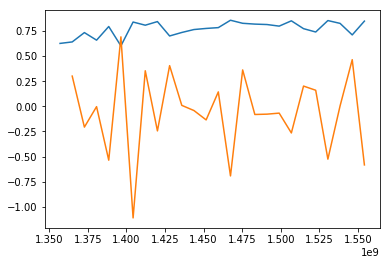

In [224]:
data_df['d_t_corr'] = data_df.apply(lambda x: pearsonr(x['d_t'][1:], x['log_rel_freq_diff'][1:])[0], axis=1)
display(data_df.sort_values(by='d_t_corr').head(10))

d_t_case = data_df.loc[4884]
plt.plot(d_t_case['time_steps'], d_t_case['d_t'])
plt.plot(d_t_case['time_steps'], d_t_case['log_rel_freq_diff'])

In [225]:
data_df['d_u_corr'] = data_df.apply(lambda x: spearmanr(x['d_u'][1:], x['log_rel_freq_diff'][1:])[0], axis=1)
display(data_df.sort_values(by='d_u_corr').head(10))

source         word                                               freq  \
1961    bnc     grouping  [7, 14, 8, 10, 8, 19, 16, 20, 12, 26, 20, 23, ...   
4926   nuts           eu  [41, 35, 67, 59, 112, 60, 123, 157, 183, 130, ...   
4478    bnc      abusive  [67, 47, 81, 86, 54, 52, 98, 53, 136, 109, 116...   
7236  conll  netherlands  [15, 13, 15, 24, 27, 20, 43, 42, 33, 45, 47, 6...   
4884   nuts        skype  [118, 166, 160, 150, 83, 184, 93, 115, 109, 17...   
541     bnc         mini  [1707, 1158, 1852, 2918, 1499, 1653, 2341, 439...   
9924  urban        miata  [37, 64, 31, 65, 55, 41, 91, 45, 68, 45, 51, 6...   
4009    bnc         flaw  [98, 118, 110, 94, 126, 87, 358, 184, 150, 214...   
5608   nuts         rams  [12, 12, 14, 8, 16, 12, 31, 18, 10, 13, 12, 10...   
8391  conll          fbi  [10, 14, 13, 24, 13, 6, 83, 73, 19, 31, 62, 24...   

                                               rel_freq  \
1961  [1.2159904833110517e-06, 2.334984946018484e-06...   
4926  [7.1222299736790176e-06, 5.837462365046209e-06...   
4478  [1.1638766054548639e-05, 7.838878033062053e-06...   
7236  [2.6056938928093965e-06, 2.1682003070171636e-0...   
4884  [2.0498125290100586e-05, 2.7686250074219164e-0...   
541   [0.00029652796500170933, 0.0001931366119635288...   
9924  [6.427378268929845e-06, 1.0674216896084497e-05...   
4009  [1.7023866766354724e-05, 1.968058740215579e-05...   
5608  [2.0845551142475174e-06, 2.001415668015843e-06...   
8391  [1.737129261872931e-06, 2.334984946018484e-06,...   

                                                   rank  \
1961  [18497, 13121, 18646, 16340, 17461, 11652, 159...   
4926  [6993, 7837, 5740, 5994, 3848, 6136, 5020, 390...   
4478  [5079, 6545, 5140, 4757, 6272, 6768, 5752, 774...   
7236  [12159, 13463, 13356, 10240, 9392, 11500, 9408...   
4884  [3501, 2858, 3245, 3259, 4709, 2944, 5915, 481...   
541   [393, 581, 450, 285, 490, 496, 531, 267, 595, ...   
9924  [7481, 5418, 9189, 5688, 6200, 7758, 6029, 856...   
4009  [3946, 3619, 4184, 4487, 3561, 4810, 2467, 351...   
5608  [13810, 13995, 13996, 18034, 12431, 14929, 111...   
8391  [15017, 13049, 14627, 10176, 14091, 20747, 635...   

                                            normed_rank  \
1961  [0.0032131679956863605, 0.0021883812483363234,...   
4926  [0.0012147744928277407, 0.001307091215853347, ...   
4478  [0.0008822879521052616, 0.001091605462263641, ...   
7236  [0.002112175469511297, 0.002245421594874775, 0...   
4884  [0.0006081689545817131, 0.0004766704982657733,...   
541   [6.82691799916062e-05, 9.690187525976707e-05, ...   
9924  [0.0012995464008071398, 0.0009036391741091532,...   
4009  [0.0006854712067350586, 0.000603593608545778, ...   
5608  [0.002398975510646518, 0.002334151022823477, 0...   
8391  [0.0026086470125545806, 0.002176372754328228, ...   

                                                    d_u  \
1961  [0.8551329623018359, 0.5750355818722328, 0.998...   
4926  [0.8398589629693415, 0.9708519219963465, 0.659...   
4478  [0.790503892492224, 0.8395247540839601, 0.6658...   
7236  [0.7432461665613953, 0.7729129827240155, 0.875...   
4884  [0.5941832395840552, 0.6316559040685963, 0.641...   
541   [0.5794452836551988, 0.7068194896860829, 0.610...   
9924  [0.7028233863694471, 0.42562298619958006, 0.92...   
4009  [0.886036143839883, 0.8052640483911165, 0.8733...   
5608  [0.8400993543472639, 0.7524079260956087, 0.792...   
8391  [0.6025028287531969, 0.7906739250743201, 0.929...   

                                                    d_t  \
1961  [0.8395358133899107, 0.8399081563286953, 0.981...   
4926  [0.7897826785833844, 0.952609440584648, 0.8368...   
4478  [0.8359303310143926, 0.9184252059867136, 0.826...   
7236  [0.9145570313168753, 0.9044840867021002, 0.916...   
4884  [0.62615482144028, 0.6409173615633141, 0.73387...   
541   [0.5684140969714951, 0.6803612746681549, 0.624...   
9924  [0.8749789819389001, 0.6902117451229381, 0.919...   
4009  [0.8033907262073109, 0.808460726942733, 0.8955...   
5608

In [206]:
#identify cases that have at least one non-null value for d^s: 
data_df['has_d_s_25'] = data_df['d_s_25'].map(lambda x: not all([np.isnan(y) for y in x]))
display(data_df['has_d_s_25'].value_counts())

#test to subset to cases that have d_s_25: 
# data_df = data_df[data_df['has_d_s_25'] == True]

False    5068
Name: has_d_s_25, dtype: int64

# Summary statistics: 

## Correlation matrices: 

In [219]:
# columns = ['freq', 'rel_freq', 'd_u', 'd_t', 'd_l', 'd_s_25',
#        'd_s_50', 'd_s_75', 'd_s_mean', 'log_freq',
#        'log_rel_freq', 'rank', 'normed_rank', 'log_freq_diff', 'log_rel_freq_diff']
# columns = ['freq', 'rel_freq', 'd_u', 'd_t', 'd_l', 'log_freq',
#        'log_rel_freq', 'rank', 'normed_rank', 'log_freq_diff', 'log_rel_freq_diff']
columns = ['d_u', 'd_t', 'd_l', 'log_rel_freq', 'log_rel_freq_diff', 'log_rank_diff']
column_names = ['$D^U$', '$D^T$', '$D^L$', '$log_{10}f$','$\Delta log_{10}f$', '$\Delta r$']

In [220]:
def CorrMatrix(in_df, title, cols, col_names, coeff='pearson', sig=False): 
    corr_df = pd.DataFrame()
    
    for col in cols: 
        all_vals = list(itertools.chain.from_iterable(in_df[col].tolist()))
        corr_df[col] = all_vals
    
    corr_df.columns = col_names
    
    if sig: 
        corr = corr_df.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(len(corr_df.columns)) 
    
    else: 
        corr = corr_df.corr(coeff)

    
    plt.figure(figsize=(8, 6))
    ax = sns.heatmap(corr, annot=True, linewidths=.5)
    ax.set_title(title)
    plt.savefig('%s_%s_matrix.png' %(title.split()[0].lower(), coeff))
    plt.show()


In [226]:
#generate groups: 
bnc = data_df[data_df['source'] == 'bnc']
wnut = data_df[data_df['source'] == 'nuts']
conll = data_df[data_df['source'] == 'conll']
nes = data_df[(data_df['source'] == 'conll') | (data_df['source'] == 'nuts')]
urban = data_df[data_df['source'] == 'urban']

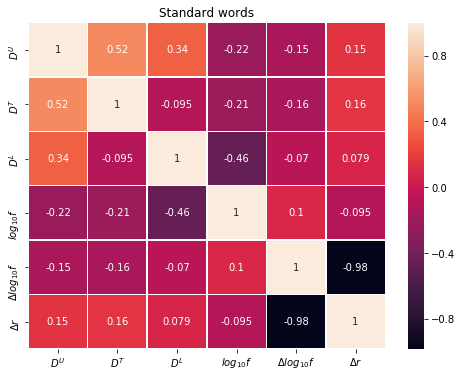

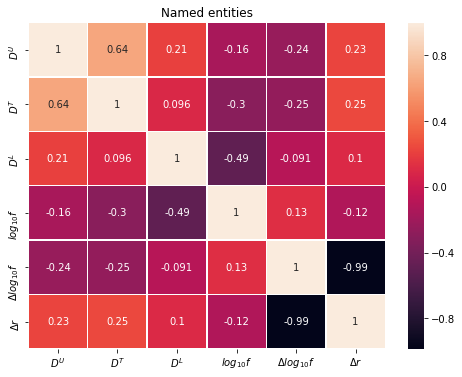

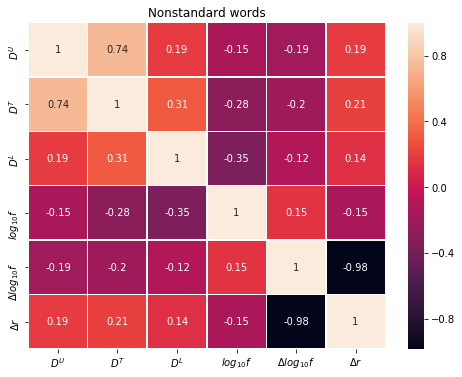

In [227]:
#plots for the actual paper: 
CorrMatrix(bnc, 'Standard words', columns, column_names)
CorrMatrix(nes, 'Named entities', columns, column_names)
CorrMatrix(urban, 'Nonstandard words', columns, column_names)

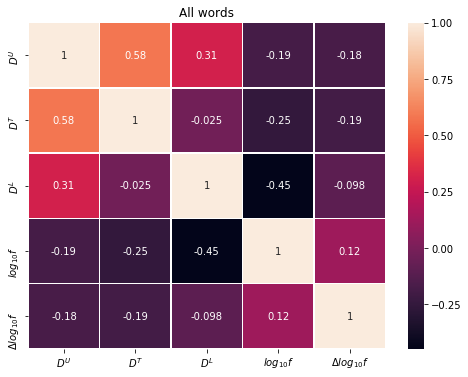

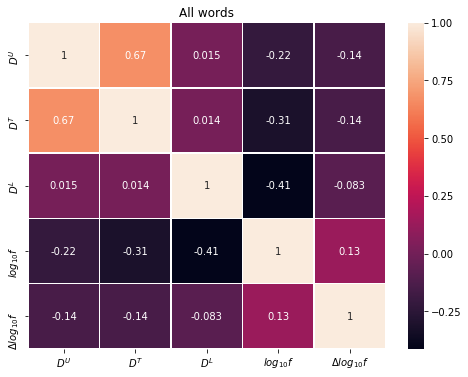

In [64]:
#full dataset: 
CorrMatrix(data_df, 'All words', columns, column_names)
CorrMatrix(data_df, 'All words', columns, column_names, 'spearman')

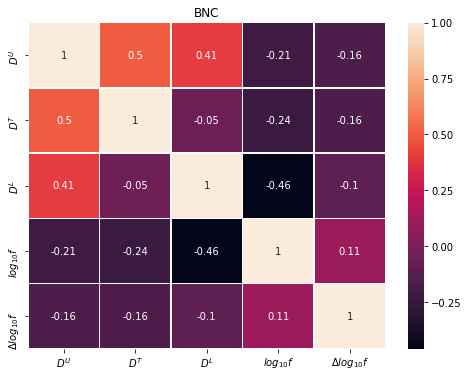

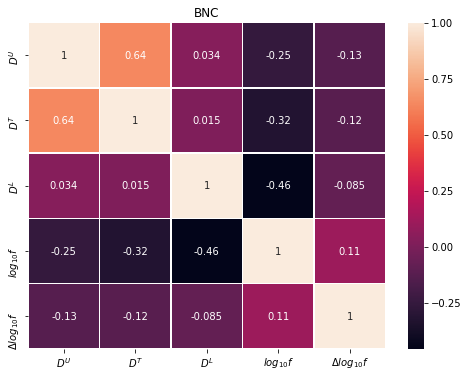

In [65]:
#just warriner: 
CorrMatrix(bnc, 'BNC', columns, column_names)
CorrMatrix(bnc, 'BNC', columns, column_names, 'spearman')

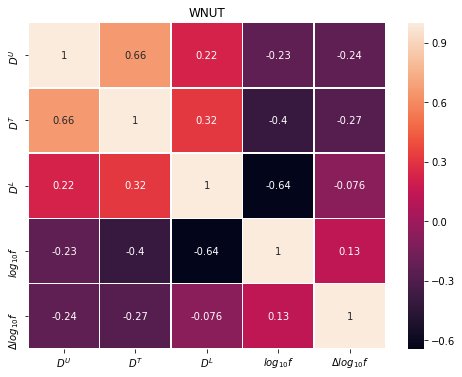

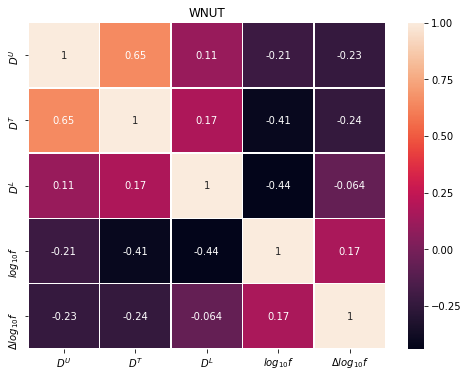

In [66]:
#standard: 
CorrMatrix(wnut, 'WNUT', columns, column_names)
CorrMatrix(wnut, 'WNUT', columns, column_names, 'spearman')

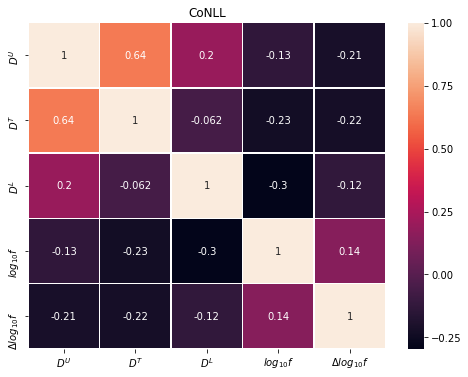

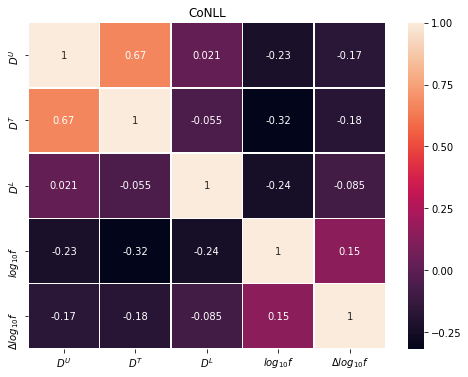

In [67]:
#conll
CorrMatrix(conll, 'CoNLL', columns, column_names)
CorrMatrix(conll, 'CoNLL', columns, column_names, 'spearman')

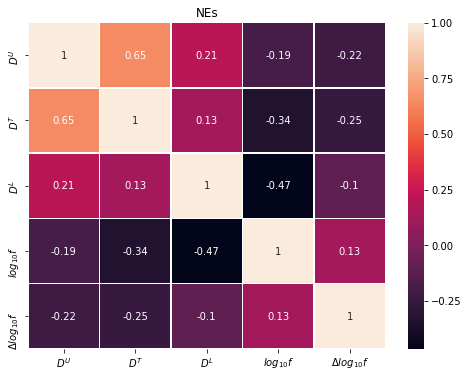

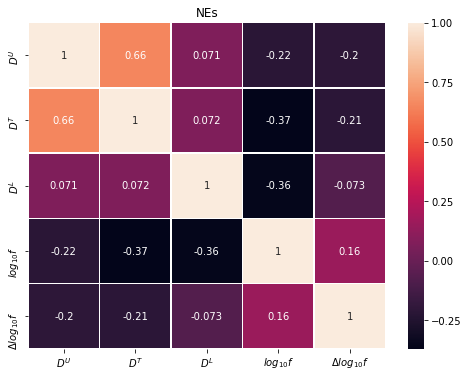

In [68]:
#all named entities
CorrMatrix(nes, 'NEs', columns, column_names)
CorrMatrix(nes, 'NEs', columns, column_names, 'spearman')

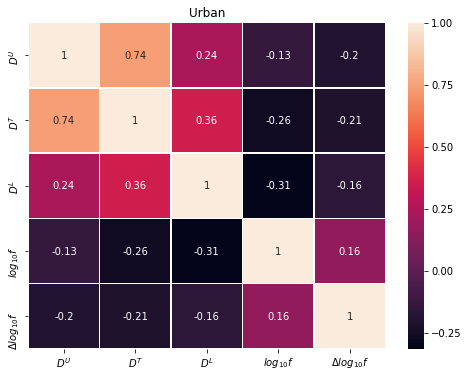

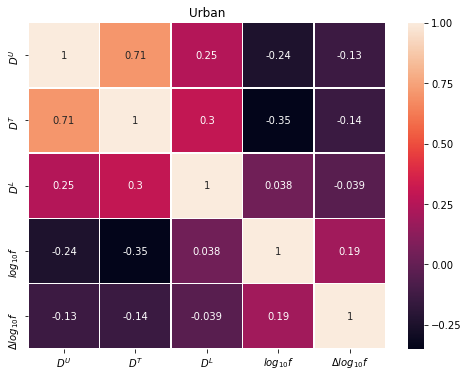

In [69]:
#conll
CorrMatrix(urban, 'Urban', columns, column_names)
CorrMatrix(urban, 'Urban', columns, column_names, 'spearman')

## Relative importance regression setup: 

In [70]:
#make relative importance dataframe: 
def RelaImpo(in_df, cols, name): 
    df = pd.DataFrame()
    
    for col in cols: 
        all_vals = list(itertools.chain.from_iterable(in_df[col].tolist()))
        df[col] = all_vals
    
    print(df.shape)
    df.to_csv(name)
    return df

In [71]:
dfs = [(bnc, 'bnc'), (nes, 'nes'), (urban, 'urban')]
for word_set in dfs: 
    rela_impo = RelaImpo(word_set[0], columns, '%s_rela_impo.csv' % word_set[1])

(9476, 5)
(4186, 5)
(782, 5)


## Extreme cases: 

In [138]:
def ExtremeCorr(arr1, arr2): 
    arr1 = np.array(arr1)
    arr2 = np.array(arr2)
    nas = np.logical_or(np.isnan(arr1), np.isnan(arr2))
#     if all(nas == True): 
#         print(nas)
#         return None
    
    corr = pearsonr(arr1[~nas], arr2[~nas])
    return corr[0]

In [139]:
#uncomment line below when you add d^s
print(ExtremeCorr(data_df.iloc[10]['log_rel_freq_diff'], data_df.iloc[10]['d_u']))

-0.25494169153906615


In [74]:
def ExtremeCases(var, num_cases, in_df, sort): 
    in_df['correlation'] = in_df.apply(lambda x: ExtremeCorr(x['log_rel_freq_diff'], x[var]), axis=1)
    extreme_df = in_df[(in_df['correlation'] > -1.00000) & (in_df['correlation'] < 1.00000)]
    display(extreme_df.shape)
    extreme_df = extreme_df.sort_values(by='correlation', ascending=sort).iloc[:num_cases]
    return extreme_df

In [75]:
# extreme_d_s_25 = ExtremeCases('d_s_25', 50, data_df, False)
# display(extreme_d_s_25)

In [76]:
# extreme_d_s_25 = ExtremeCases('d_s_25', 50, data_df, True)
# display(extreme_d_s_25)

In [77]:
# extreme_d_s_mean = ExtremeCases('d_s_mean', 200, data_df, False)
# display(extreme_d_s_mean[extreme_d_s_mean['source'] == 'urban'])

In [78]:
# extreme_d_s_mean = ExtremeCases('d_s_mean', 200, data_df, True)
# display(extreme_d_s_mean[extreme_d_s_mean['source'] == 'urban'])

## Histograms: 

In [79]:
group_colors = [(bnc, 'yellow'), (wnut, 'green'), (conll, 'red'), (urban, 'blue')]

In [80]:
def DistPlot(title, my_groups, corr_cols, names=None): 
    corr_df = pd.DataFrame()

    for col in corr_cols: 
        for group in my_groups: 
            all_vals = itertools.chain.from_iterable(group[0][col].tolist())
            no_na = pd.Series(list(all_vals)).dropna()
            ax = sns.distplot(no_na, color=group[1])
            ax.set_title(str(names) + ": " + col)
        plt.show()

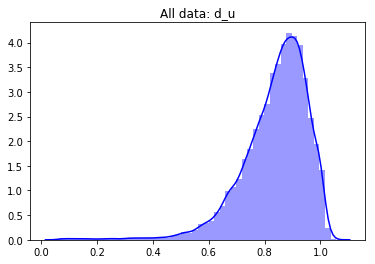

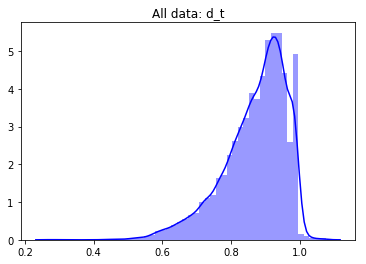

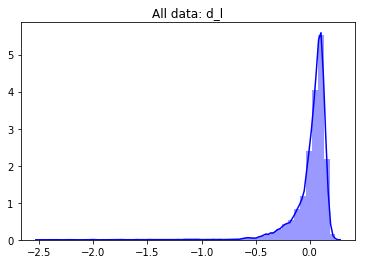

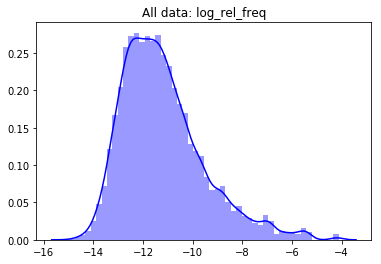

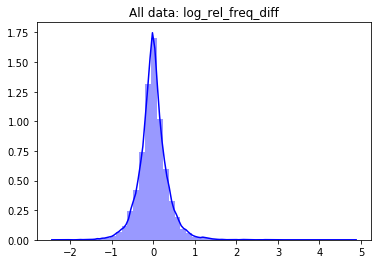

In [81]:
DistPlot('All values', [(data_df, 'b')], columns, 'All data')

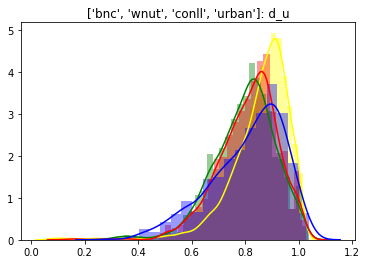

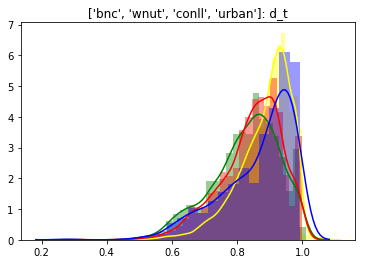

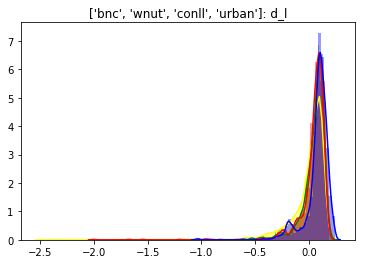

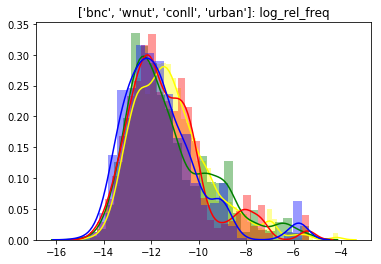

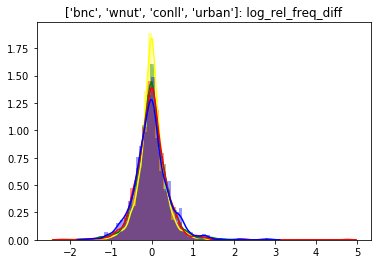

In [82]:
#distplot by group of words
DistPlot('All values', group_colors, columns, ['bnc', 'wnut', 'conll', 'urban'])

## Significance testing: 

In [83]:
#kruskal-wallis: 
kruskal_cols = ['d_u', 'd_t', 'd_l', 'rel_freq', 'log_rel_freq', 'log_rel_freq_diff']

for col in kruskal_cols: 
    groups_data = [list(itertools.chain.from_iterable(group[0][col].tolist())) for group in group_colors]
    kruskal_result = kruskal(*groups_data, nan_policy='omit')
    print("%s f-statistic: %s" %(col, str(kruskal_result[0])))
    print("%s p-value: %s" %(col, str(kruskal_result[1])))

d_u f-statistic: 862.7505042730382
d_u p-value: 1.0629028002708676e-186
d_t f-statistic: 951.090680724724
d_t p-value: 7.324697949611084e-206
d_l f-statistic: 585.7631388981496
d_l p-value: 1.2293941584755927e-126
rel_freq f-statistic: 121.73163488121565
rel_freq p-value: 3.2694734991690353e-26
log_rel_freq f-statistic: 121.73163488121565
log_rel_freq p-value: 3.2694734991690353e-26
log_rel_freq_diff f-statistic: 6.027892491955662
log_rel_freq_diff p-value: 0.11026105231485966


## Time series plots of changes in metrics over each time step: 

In [84]:
def TimeSeries(in_df, measure): 
    time_df = pd.DataFrame(columns=['time_steps', 'value'])

    time_df['time_steps'] = list(itertools.chain.from_iterable(in_df['time_steps'].tolist()))
    time_df['value'] = list(itertools.chain.from_iterable(in_df[measure].tolist()))
    
    ax = sns.lineplot(x='time_steps', y='value', data=time_df)
    ax.set_title(measure)
    plt.show()

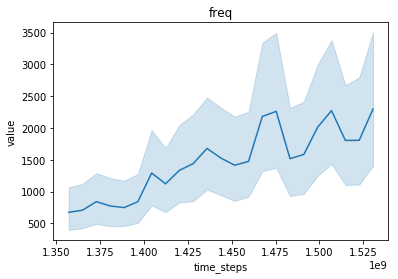

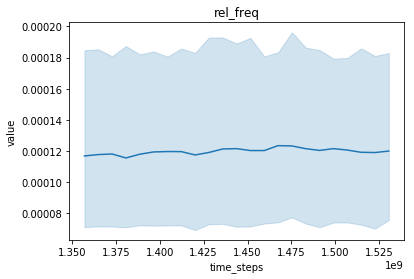

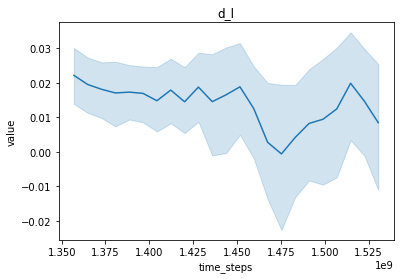

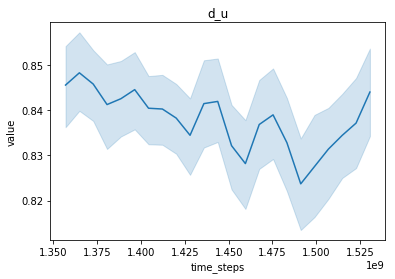

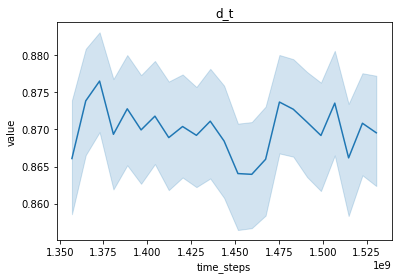

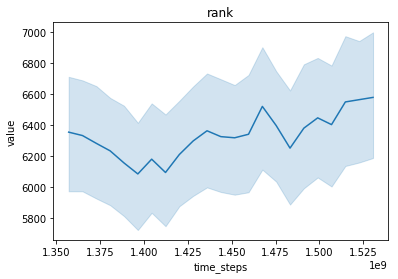

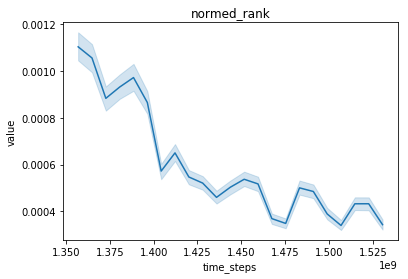

In [85]:
#for all data
# time_cols = ['freq', 'rel_freq', 'd_l', 'd_u', 'd_t', 'd_s_25', 'd_s_50', 'd_s_75', 'd_s_mean', 'log_freq', 'log_rel_freq', 'log_freq_diff', 'log_rel_freq_diff', 'freq_diff']

for col in time_cols: 
    TimeSeries(data_df, col)

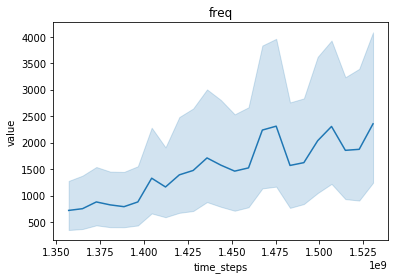

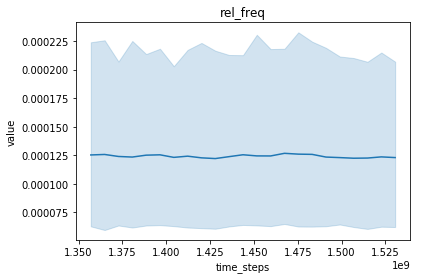

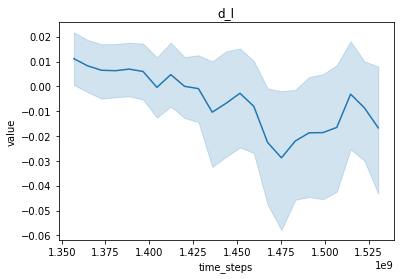

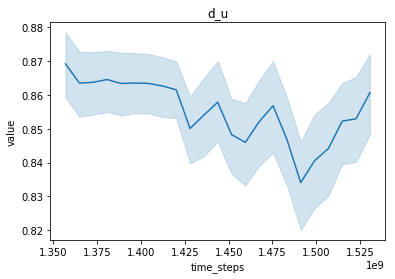

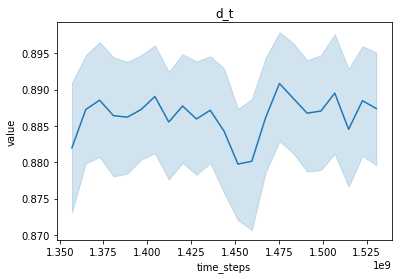

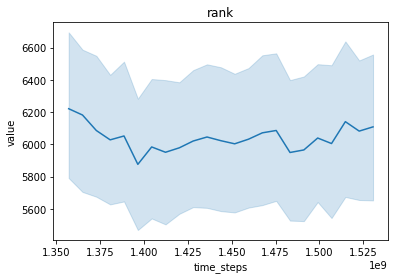

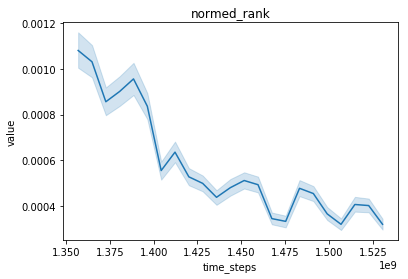

In [86]:
for col in time_cols: 
    TimeSeries(bnc, col)

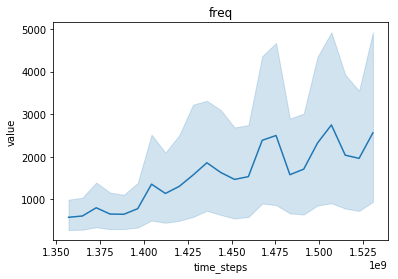

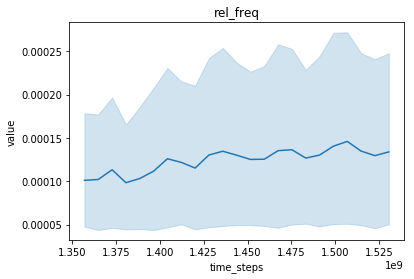

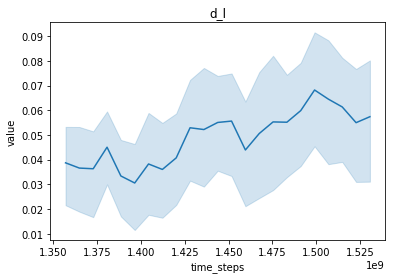

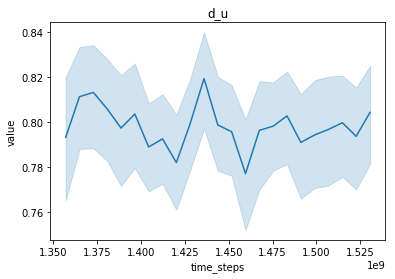

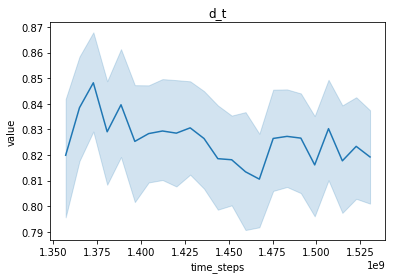

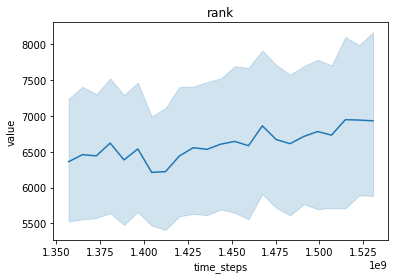

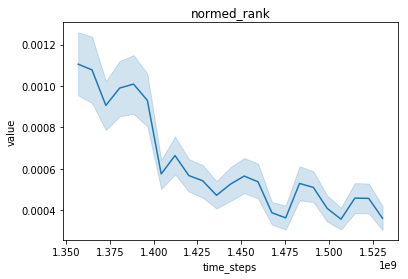

In [87]:
for col in time_cols: 
    TimeSeries(wnut, col)

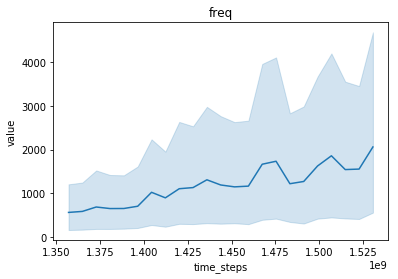

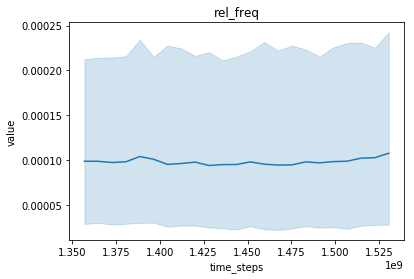

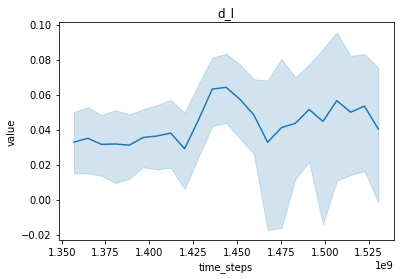

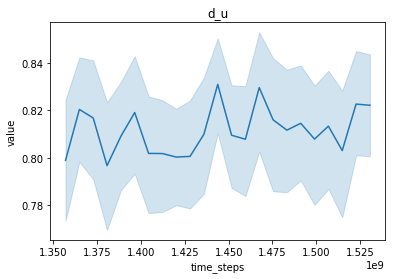

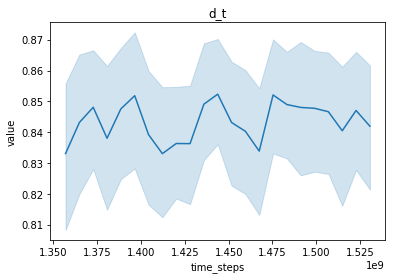

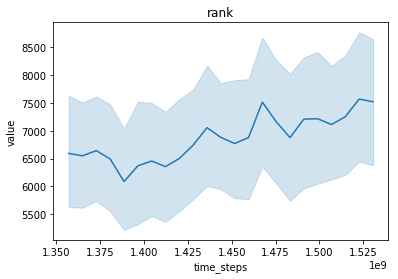

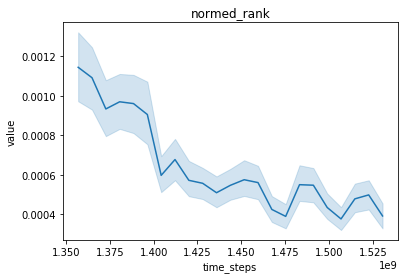

In [88]:
for col in time_cols: 
    TimeSeries(conll, col)

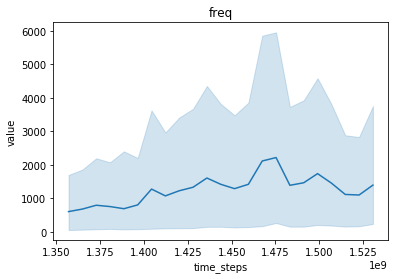

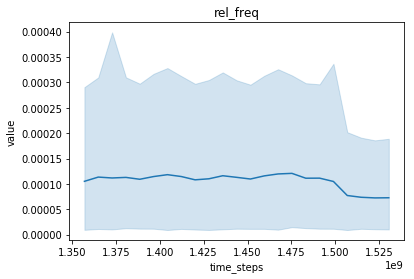

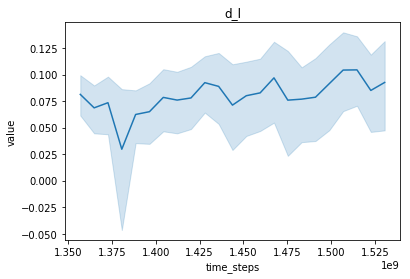

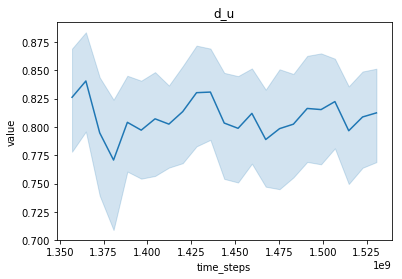

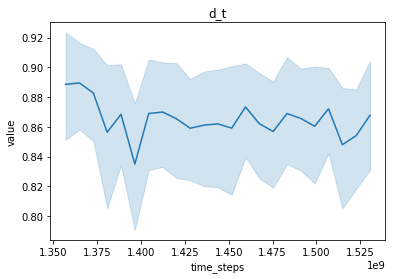

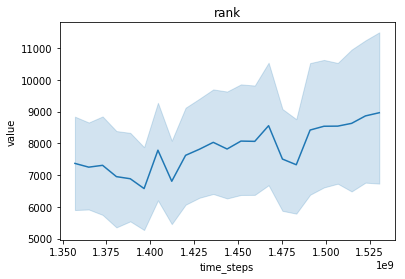

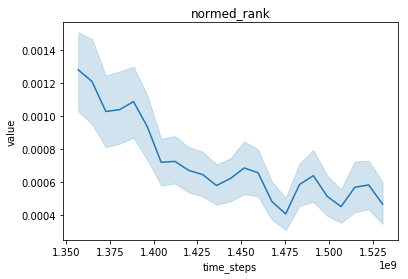

In [89]:
for col in time_cols: 
    TimeSeries(urban, col)

# Predictive modeling: 

## Logistic regression: 

### Feature extraction: 

In [122]:
#generate growth/decline labels: 
def MakeData(df, time, lag=0, balanced=False): 
    df['label'] = df['log_rel_freq_diff'].map(lambda x: x[time] >= 0 if not math.isnan(x[time]) else np.nan)
    df = df[(df['label'] == True) | (df['label'] == False)]
    df['label'] = df['label'].astype(int)
    
    if lag > 0: 
        if time - lag > 0: 
            df['lag'] = df['d_u'].map(lambda x: x[(time - lag):time])
        else: 
            df['lag'] = df['d_u'].map(lambda x: x[:time])

        df['has_lag'] = df['lag'].map(lambda x: not(any(math.isnan(y) for y in x)))
        display(df['has_lag'].value_counts())
        df = df[df['has_lag'] == True]
    
    if balanced: 
        sample_size = df['label'].value_counts().min()
        df = df.groupby('label').apply(lambda x: x.sample(sample_size))
        display(df['label'].value_counts())
    return df

In [123]:
label_test = MakeData(data_df, 4, lag=3)
display(label_test.head())

True    628
Name: has_lag, dtype: int64

source        word                                               freq  \
3     bnc      butter  [105, 118, 119, 90, 83, 90, 134, 117, 124, 153...   
8     bnc    measures  [35, 43, 50, 56, 31, 40, 106, 66, 88, 121, 139...   
14    bnc   networked  [12, 15, 21, 13, 21, 11, 10, 14, 30, 12, 18, 3...   
25    bnc      facial  [42, 35, 26, 26, 23, 11, 28, 31, 29, 65, 49, 4...   
27    bnc  headmaster  [92, 88, 127, 104, 89, 77, 154, 110, 243, 207,...   

                                             rel_freq  \
3   [1.8239857249665777e-05, 1.968058740215579e-05...   
8   [6.0799524165552585e-06, 7.171739477056772e-06...   
14  [2.0845551142475174e-06, 2.501769585019804e-06...   
25  [7.29594289986631e-06, 5.837462365046209e-06, ...   
27  [1.5981589209230964e-05, 1.4677048232116184e-0...   

                                                 rank  \
3   [3764, 3609, 3963, 4591, 4734, 4703, 4732, 476...   
8   [7679, 6876, 6937, 6201, 8678, 7793, 5468, 676...   
14  [13816, 12384, 11171, 13912, 10680, 15733, 201...   
25  [6883, 7848, 10174, 9800, 10309, 15606, 11865,...   
27  [4120, 4406, 3782, 4227, 4507, 5224, 4323, 497...   

                                          normed_rank  \
3   [0.0006538554541689713, 0.0006019257621557648,...   
8   [0.0013339415601922237, 0.0011468111777730781,...   
14  [0.0024000177882036416, 0.00206546096939235, 0...   
25  [0.0011956660709471385, 0.0013089258468823614,...   
27  [0.0007156972558916476, 0.0007348531194398171,...   

                                                  d_u  \
3   [0.8697726062767838, 0.7600244951107168, 0.845...   
8   [0.8900644349897722, 0.915284042411943, 0.9801...   
14  [0.9241092897819904, 0.8062311130836108, 0.727...   
25  [0.9199198400274963, 1.000271677208357, 0.8268...   
27  [0.8256153913721164, 0.6370166816078681, 0.751...   

                                                  d_t  \
3   [0.7688505922541659, 0.8834725469683474, 0.861...   
8   [0.8968528293757784, 0.8896589464730378, 0.963...   
14  [0.9797237729899164, 0.7839423418379499, 0.841...   
25  [0.9112044383103608, 0.952609440584648, 0.8690...   
27  [0.7806654246985104, 0.6698603133834019, 0.768...   

                                                  d_l d_s_25  ...  \
3   [0.030537249978431547, -0.03971446518984756, 0...     []  ...   
8   [0.09373050813087946, 0.004380106838015152, 0....     []  ...   
14  [0.03539724448030768, 0.09842756622569038, 0.0...     []  ...   
25  [0.012634085250220473, 0.018637808627656405, 0...     []  ...   
27  [0.04955466208896553, 0.029369554659108843, -0...     []  ...   

                                             log_freq  \
3   [4.653960350157523, 4.770684624465665, 4.77912...   
8   [3.5553480614894135, 3.7612001156935624, 3.912...   
14  [2.4849066497880004, 2.70805020110221, 3.04452...   
25  [3.7376696182833684, 3.5553480614894135, 3.258...   
27  [4.5217885770490405, 4.477336814478207, 4.8441...   

                                         log_rel_freq  \
3   [-10.911901399573178, -10.835877819115082, -10...   
8   [-12.010513688241288, -11.845362327887184, -11...   
14  [-13.0809550999427, -12.898512242478537, -12.7...   
25  [-11.828192131447333, -12.051214382091333, -12...   
27  [-11.044073172681662, -11.12922562910254, -10....   

                                        log_freq_diff  \
3   [nan, 0.11672427430814203, 0.00843886864586451...   
8   [nan, 0.20585205420414887, 0.15082288973458358...   
14  [nan, 0.2231435513142097, 0.33647223662121295,...   
25  [nan, -0.1823215567939549, -0.2972515234679314...   
27  [nan, -0.04445176257083361, 0.3668502719803843...   

                                    log_rel_freq_diff  \
3   [nan, 0.07602358045809687, -0.1620083953145510...   
8   [nan, 0.16515136035410372, -0.0196243742258328...   
14  [nan, 0.18244285746416367, 0.1660249726607983,...   
25  [nan, -0.22302225064400005, -0.467698787428346...   
27  [nan, -0.08515245642087876, 0.1964030080199688...   

                                            

In [124]:
#make training data, cutoff-1 so that we don't get the information from the final step
pd.options.mode.use_inf_as_na = True

def ExpandData(in_df, cols, cutoff, lag=0): 
    expanded_list = []
    for col in cols: 
        if cutoff - lag > 0 and lag > 0: 
            array = in_df[col].apply(lambda x: [x[i] for i in range(cutoff - lag, cutoff)]).values
            array = np.array([[value for value in row] for row in array])
            array = pd.DataFrame(array, columns = [col + '_' + str(i) for i in range (cutoff - lag, cutoff)])
        
        else: 
            array = in_df[col].apply(lambda x: [x[i] for i in range(cutoff)]).values
            array = np.array([[value for value in row] for row in array])
            array = pd.DataFrame(array, columns = [col + '_' + str(i) for i in range (cutoff)])
        
        if col is 'log_rel_freq': 
            #fill with log of 
            array = array.fillna(np.log(1.0))
        else: 
            #worst case: no values, so fill all with zero
            array = array.bfill(axis=1).ffill(axis=1).fillna(0)
        
        expanded_list.append(array)
        

    
    expanded_df = pd.concat(expanded_list, axis=1)
    
    #fill missing frequency values with 0
    display(expanded_df.head())
    return expanded_df

In [125]:
#sanity check
ExpandData(label_test, ['log_rel_freq', 'd_t'], 2)

log_rel_freq_0  log_rel_freq_1     d_t_0     d_t_1
0      -10.911901      -10.835878  0.768851  0.883473
1      -12.010514      -11.845362  0.896853  0.889659
2      -13.080955      -12.898512  0.979724  0.783942
3      -11.828192      -12.051214  0.911204  0.952609
4      -11.044073      -11.129226  0.780665  0.669860

log_rel_freq_0  log_rel_freq_1     d_t_0     d_t_1
0        -10.911901      -10.835878  0.768851  0.883473
1        -12.010514      -11.845362  0.896853  0.889659
2        -13.080955      -12.898512  0.979724  0.783942
3        -11.828192      -12.051214  0.911204  0.952609
4        -11.044073      -11.129226  0.780665  0.669860
5         -9.592052       -9.737266  0.700774  0.688866
6         -9.537583       -9.397972  0.854386  0.875604
7         -8.153701       -8.235073  0.779163  0.804834
8        -13.263277      -13.527121  0.979618  0.857222
9        -11.522810      -11.401870  0.913155  0.923127
10       -10.568649      -10.364815  0.853296  0.787665
11       -11.928276      -11.799900  0.877817  0.937377
12        -9.822859       -9.504004  0.834936  0.780725
13       -13.619952      -12.662123  0.979458  0.928486
14       -12.621423      -12.348466  0.980094  0.867200
15       -12.039501      -12.140827  0.952031  0.980523
16       -12.732648      -12.239267  0.691756  0.743765
17       -10.950741      -11.095703  0.896594  0.885388
18       -11.123210      -11.262757  0.948788  0.969329
19       -13.263277      -12.833974  0.979618  0.979963
20       -12.164664      -12.239267  0.947982  0.946610
21        -9.423824       -9.374114  0.678038  0.686965
22        -8.797369       -8.716971  0.912854  0.908447
23        -9.037904       -8.933264  0.814916  0.768482
24        -8.788215       -8.965380  0.512064  0.595061
25       -10.753677      -10.906082  0.825170  0.884894
26       -10.911901      -10.924431  0.815732  0.928528
27       -12.100126      -12.387687  0.950127  0.941067
28       -12.010514      -12.205365  0.980933  0.817044
29       -13.263277      -12.662123  0.979618  0.980068
..              ...             ...       ...       ...
598      -12.387808      -12.274358  0.980357  0.945369
599      -10.795177      -10.770281  0.776432  0.804185
600      -12.857812      -12.716191  0.979883  0.925587
601       -9.628326       -9.789451  0.913034  0.955333
602      -12.198566      -12.716191  0.946805  0.980033
603      -10.509616       -9.751491  0.842459  0.772460
604      -10.435963      -10.391627  0.940888  0.926789
605      -11.954944      -11.655319  0.981037  0.943480
606      -11.982343      -11.636271  0.790238  0.814626
607      -12.621423      -12.428509  0.980094  0.776026
608      -10.617102      -10.870364  0.965297  0.957474
609      -13.486420      -13.660652  0.979512  0.979647
610      -11.471517      -11.799900  0.572965  0.828379
611      -11.876982      -12.471068  0.834014  0.937590
612      -11.235128      -10.424779  0.711413  0.730833
613      -12.474819      -12.310726  0.980252  0.871421
614      -11.171413      -11.031851  0.849763  0.921981
615       -9.204559       -9.120402  0.944824  0.941214
616      -11.317367      -11.756415  0.954660  0.960172
617      -11.317367      -11.329896  0.982738  0.927360
618      -12.675490      -12.773349  0.762254  0.922351
619      -10.737548      -10.008140  0.725325  0.717627
620      -12.521339      -12.348466  0.980199  0.904904
621      -12.857812      -13.660652  0.914557  0.979647
622      -12.857812      -12.471068  0.979883  0.980208
623      -10.209275      -10.194916  0.770274  0.788760
624      -12.233657      -11.995645  0.910526  0.848170
625      -12.521339      -12.110055  0.980199  0.742847
626      -12.100126      -12.023044  0.980776  0.926181
627      -11.261797      -11.129226  0.664150  0.748011

[628 rows x 4 columns]

### Logistic regression: 

In [134]:
#fit logistic regression with cross-validation and print report: 
def Eval(my_X, my_y, classifier): 
    #fit and predict
    if classifier is 'logistic': 
        clf = LogisticRegression()
    if classifier is 'svm': 
        clf = SVC(kernel='rbf', C=1.0)
    if classifier is 'rf': 
        clf = RandomForestClassifier()
        
    pred = model_selection.cross_val_predict(clf, my_X, my_y, n_jobs=-1, cv=10)
    print(metrics.classification_report(my_y, pred))
    
    return (metrics.accuracy_score(my_y, pred), metrics.f1_score(my_y, pred, average='macro'))

In [135]:
def PlotPerformance(in_df, n_splits, start, my_lag, my_clf, feature_sets, scaling=True): 
    #get number of time steps: 
    num_time_steps = len(in_df['time_steps'].iloc[0])
    performance_df = pd.DataFrame(columns=['feature_set', 'months_training', 'accuracy'])
    #for each time step, predict based on previous label
    for i in range(start, num_time_steps): 
        for j, feature_set in enumerate(feature_sets): 
            labeled = MakeData(in_df, i, my_lag)
            if labeled.shape[0] > n_splits: 
                print(feature_set[0], i)
                X = ExpandData(labeled, feature_set[0], i, my_lag)
                
                if scaling: 
                    scaler = StandardScaler()
                    scaler.fit(X)
                    X = scaler.transform(X)
                
                y = labeled['label']
                print(y.value_counts())
                performance = Eval(X, y, my_clf)
                performance_df = performance_df.append({'feature_set': int(j), 'months_training': int(i), 'accuracy': performance[0], 'f1': performance[1]}, ignore_index=True)
    
    #plot accuracy score vs. number of months of training data for each feature set
    for i, feature_set in enumerate(feature_sets):
        set_df = performance_df[performance_df['feature_set'] == i]
        plt.plot(set_df['months_training'], set_df['f1'].rolling(4).mean(), color=feature_set[1])
    
    return performance_df
                

['log_rel_freq'] 1


log_rel_freq_0
0      -10.911901
1      -12.010514
2      -13.080955
3      -11.828192
4      -11.044073

1    321
0    307
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.51      0.24      0.33       307
           1       0.52      0.78      0.62       321

   micro avg       0.52      0.52      0.52       628
   macro avg       0.52      0.51      0.48       628
weighted avg       0.52      0.52      0.48       628

['log_rel_freq', 'd_u'] 1


log_rel_freq_0     d_u_0
0      -10.911901  0.869773
1      -12.010514  0.890064
2      -13.080955  0.924109
3      -11.828192  0.919920
4      -11.044073  0.825615

1    321
0    307
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.53      0.37      0.44       307
           1       0.53      0.69      0.60       321

   micro avg       0.53      0.53      0.53       628
   macro avg       0.53      0.53      0.52       628
weighted avg       0.53      0.53      0.52       628

['log_rel_freq', 'd_t'] 1


log_rel_freq_0     d_t_0
0      -10.911901  0.768851
1      -12.010514  0.896853
2      -13.080955  0.979724
3      -11.828192  0.911204
4      -11.044073  0.780665

1    321
0    307
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.55      0.39      0.46       307
           1       0.54      0.69      0.61       321

   micro avg       0.55      0.55      0.55       628
   macro avg       0.55      0.54      0.53       628
weighted avg       0.55      0.55      0.54       628

['log_rel_freq', 'd_l'] 1


log_rel_freq_0     d_l_0
0      -10.911901  0.030537
1      -12.010514  0.093731
2      -13.080955  0.035397
3      -11.828192  0.012634
4      -11.044073  0.049555

1    321
0    307
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.55      0.29      0.38       307
           1       0.53      0.77      0.63       321

   micro avg       0.54      0.54      0.54       628
   macro avg       0.54      0.53      0.50       628
weighted avg       0.54      0.54      0.51       628

['log_rel_freq', 'd_u', 'd_t', 'd_l'] 1


log_rel_freq_0     d_u_0     d_t_0     d_l_0
0      -10.911901  0.869773  0.768851  0.030537
1      -12.010514  0.890064  0.896853  0.093731
2      -13.080955  0.924109  0.979724  0.035397
3      -11.828192  0.919920  0.911204  0.012634
4      -11.044073  0.825615  0.780665  0.049555

1    321
0    307
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.56      0.42      0.48       307
           1       0.55      0.68      0.61       321

   micro avg       0.55      0.55      0.55       628
   macro avg       0.56      0.55      0.54       628
weighted avg       0.55      0.55      0.55       628

['log_rel_freq'] 2


log_rel_freq_0  log_rel_freq_1
0      -10.911901      -10.835878
1      -12.010514      -11.845362
2      -13.080955      -12.898512
3      -11.828192      -12.051214
4      -11.044073      -11.129226

0    346
1    282
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.66      0.80      0.72       346
           1       0.67      0.49      0.57       282

   micro avg       0.66      0.66      0.66       628
   macro avg       0.67      0.65      0.65       628
weighted avg       0.67      0.66      0.65       628

['log_rel_freq', 'd_u'] 2


log_rel_freq_0  log_rel_freq_1     d_u_0     d_u_1
0      -10.911901      -10.835878  0.869773  0.760024
1      -12.010514      -11.845362  0.890064  0.915284
2      -13.080955      -12.898512  0.924109  0.806231
3      -11.828192      -12.051214  0.919920  1.000272
4      -11.044073      -11.129226  0.825615  0.637017

0    346
1    282
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.67      0.80      0.73       346
           1       0.68      0.52      0.59       282

   micro avg       0.67      0.67      0.67       628
   macro avg       0.67      0.66      0.66       628
weighted avg       0.67      0.67      0.67       628

['log_rel_freq', 'd_t'] 2


log_rel_freq_0  log_rel_freq_1     d_t_0     d_t_1
0      -10.911901      -10.835878  0.768851  0.883473
1      -12.010514      -11.845362  0.896853  0.889659
2      -13.080955      -12.898512  0.979724  0.783942
3      -11.828192      -12.051214  0.911204  0.952609
4      -11.044073      -11.129226  0.780665  0.669860

0    346
1    282
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.66      0.79      0.71       346
           1       0.65      0.49      0.56       282

   micro avg       0.65      0.65      0.65       628
   macro avg       0.65      0.64      0.64       628
weighted avg       0.65      0.65      0.65       628

['log_rel_freq', 'd_l'] 2


log_rel_freq_0  log_rel_freq_1     d_l_0     d_l_1
0      -10.911901      -10.835878  0.030537 -0.039714
1      -12.010514      -11.845362  0.093731  0.004380
2      -13.080955      -12.898512  0.035397  0.098428
3      -11.828192      -12.051214  0.012634  0.018638
4      -11.044073      -11.129226  0.049555  0.029370

0    346
1    282
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.66      0.79      0.72       346
           1       0.66      0.49      0.56       282

   micro avg       0.66      0.66      0.66       628
   macro avg       0.66      0.64      0.64       628
weighted avg       0.66      0.66      0.65       628

['log_rel_freq', 'd_u', 'd_t', 'd_l'] 2


log_rel_freq_0  log_rel_freq_1     d_u_0     d_u_1     d_t_0     d_t_1  \
0      -10.911901      -10.835878  0.869773  0.760024  0.768851  0.883473   
1      -12.010514      -11.845362  0.890064  0.915284  0.896853  0.889659   
2      -13.080955      -12.898512  0.924109  0.806231  0.979724  0.783942   
3      -11.828192      -12.051214  0.919920  1.000272  0.911204  0.952609   
4      -11.044073      -11.129226  0.825615  0.637017  0.780665  0.669860   

      d_l_0     d_l_1  
0  0.030537 -0.039714  
1  0.093731  0.004380  
2  0.035397  0.098428  
3  0.012634  0.018638  
4  0.049555  0.029370

0    346
1    282
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.66      0.78      0.71       346
           1       0.65      0.51      0.57       282

   micro avg       0.66      0.66      0.66       628
   macro avg       0.65      0.64      0.64       628
weighted avg       0.66      0.66      0.65       628

['log_rel_freq'] 3


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2
0      -10.911901      -10.835878      -10.997886
1      -12.010514      -11.845362      -11.864987
2      -13.080955      -12.898512      -12.732487
3      -11.828192      -12.051214      -12.518913
4      -11.044073      -11.129226      -10.932823

0    319
1    309
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.66      0.72      0.69       319
           1       0.68      0.62      0.65       309

   micro avg       0.67      0.67      0.67       628
   macro avg       0.67      0.67      0.67       628
weighted avg       0.67      0.67      0.67       628

['log_rel_freq', 'd_u'] 3


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2     d_u_0     d_u_1  \
0      -10.911901      -10.835878      -10.997886  0.869773  0.760024   
1      -12.010514      -11.845362      -11.864987  0.890064  0.915284   
2      -13.080955      -12.898512      -12.732487  0.924109  0.806231   
3      -11.828192      -12.051214      -12.518913  0.919920  1.000272   
4      -11.044073      -11.129226      -10.932823  0.825615  0.637017   

      d_u_2  
0  0.845362  
1  0.980162  
2  0.727233  
3  0.826894  
4  0.751596

0    319
1    309
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.66      0.71      0.68       319
           1       0.68      0.63      0.65       309

   micro avg       0.67      0.67      0.67       628
   macro avg       0.67      0.67      0.67       628
weighted avg       0.67      0.67      0.67       628

['log_rel_freq', 'd_t'] 3


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2     d_t_0     d_t_1  \
0      -10.911901      -10.835878      -10.997886  0.768851  0.883473   
1      -12.010514      -11.845362      -11.864987  0.896853  0.889659   
2      -13.080955      -12.898512      -12.732487  0.979724  0.783942   
3      -11.828192      -12.051214      -12.518913  0.911204  0.952609   
4      -11.044073      -11.129226      -10.932823  0.780665  0.669860   

      d_t_2  
0  0.861191  
1  0.963498  
2  0.841894  
3  0.869024  
4  0.768348

0    319
1    309
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.65      0.69      0.67       319
           1       0.66      0.62      0.64       309

   micro avg       0.66      0.66      0.66       628
   macro avg       0.66      0.66      0.66       628
weighted avg       0.66      0.66      0.66       628

['log_rel_freq', 'd_l'] 3


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2     d_l_0     d_l_1  \
0      -10.911901      -10.835878      -10.997886  0.030537 -0.039714   
1      -12.010514      -11.845362      -11.864987  0.093731  0.004380   
2      -13.080955      -12.898512      -12.732487  0.035397  0.098428   
3      -11.828192      -12.051214      -12.518913  0.012634  0.018638   
4      -11.044073      -11.129226      -10.932823  0.049555  0.029370   

      d_l_2  
0  0.028621  
1  0.077819  
2  0.098100  
3  0.082933  
4 -0.001935

0    319
1    309
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.66      0.72      0.69       319
           1       0.68      0.62      0.65       309

   micro avg       0.67      0.67      0.67       628
   macro avg       0.67      0.67      0.67       628
weighted avg       0.67      0.67      0.67       628

['log_rel_freq', 'd_u', 'd_t', 'd_l'] 3


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2     d_u_0     d_u_1  \
0      -10.911901      -10.835878      -10.997886  0.869773  0.760024   
1      -12.010514      -11.845362      -11.864987  0.890064  0.915284   
2      -13.080955      -12.898512      -12.732487  0.924109  0.806231   
3      -11.828192      -12.051214      -12.518913  0.919920  1.000272   
4      -11.044073      -11.129226      -10.932823  0.825615  0.637017   

      d_u_2     d_t_0     d_t_1     d_t_2     d_l_0     d_l_1     d_l_2  
0  0.845362  0.768851  0.883473  0.861191  0.030537 -0.039714  0.028621  
1  0.980162  0.896853  0.889659  0.963498  0.093731  0.004380  0.077819  
2  0.727233  0.979724  0.783942  0.841894  0.035397  0.098428  0.098100  
3  0.826894  0.911204  0.952609  0.869024  0.012634  0.018638  0.082933  
4  0.751596  0.780665  0.669860  0.768348  0.049555  0.029370 -0.001935

0    319
1    309
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.67      0.71      0.69       319
           1       0.68      0.64      0.66       309

   micro avg       0.67      0.67      0.67       628
   macro avg       0.67      0.67      0.67       628
weighted avg       0.67      0.67      0.67       628

['log_rel_freq'] 4


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3
0      -10.911901      -10.835878      -10.997886      -11.216208
1      -12.010514      -11.845362      -11.864987      -11.690666
2      -13.080955      -12.898512      -12.732487      -13.151069
3      -11.828192      -12.051214      -12.518913      -12.457922
4      -11.044073      -11.129226      -10.932823      -11.071627

1    359
0    269
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.70      0.49      0.58       269
           1       0.69      0.84      0.76       359

   micro avg       0.69      0.69      0.69       628
   macro avg       0.70      0.67      0.67       628
weighted avg       0.70      0.69      0.68       628

['log_rel_freq', 'd_u'] 4


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3     d_u_0  \
0      -10.911901      -10.835878      -10.997886      -11.216208  0.869773   
1      -12.010514      -11.845362      -11.864987      -11.690666  0.890064   
2      -13.080955      -12.898512      -12.732487      -13.151069  0.924109   
3      -11.828192      -12.051214      -12.518913      -12.457922  0.919920   
4      -11.044073      -11.129226      -10.932823      -11.071627  0.825615   

      d_u_1     d_u_2     d_u_3  
0  0.760024  0.845362  0.910071  
1  0.915284  0.980162  0.832471  
2  0.806231  0.727233  1.001514  
3  1.000272  0.826894  0.976596  
4  0.637017  0.751596  0.720049

1    359
0    269
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.67      0.47      0.55       269
           1       0.68      0.83      0.74       359

   micro avg       0.67      0.67      0.67       628
   macro avg       0.67      0.65      0.65       628
weighted avg       0.67      0.67      0.66       628

['log_rel_freq', 'd_t'] 4


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3     d_t_0  \
0      -10.911901      -10.835878      -10.997886      -11.216208  0.768851   
1      -12.010514      -11.845362      -11.864987      -11.690666  0.896853   
2      -13.080955      -12.898512      -12.732487      -13.151069  0.979724   
3      -11.828192      -12.051214      -12.518913      -12.457922  0.911204   
4      -11.044073      -11.129226      -10.932823      -11.071627  0.780665   

      d_t_1     d_t_2     d_t_3  
0  0.883473  0.861191  0.886630  
1  0.889659  0.963498  0.878245  
2  0.783942  0.841894  0.981675  
3  0.952609  0.869024  0.906714  
4  0.669860  0.768348  0.796188

1    359
0    269
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.67      0.45      0.54       269
           1       0.67      0.83      0.74       359

   micro avg       0.67      0.67      0.67       628
   macro avg       0.67      0.64      0.64       628
weighted avg       0.67      0.67      0.65       628

['log_rel_freq', 'd_l'] 4


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3     d_l_0  \
0      -10.911901      -10.835878      -10.997886      -11.216208  0.030537   
1      -12.010514      -11.845362      -11.864987      -11.690666  0.093731   
2      -13.080955      -12.898512      -12.732487      -13.151069  0.035397   
3      -11.828192      -12.051214      -12.518913      -12.457922  0.012634   
4      -11.044073      -11.129226      -10.932823      -11.071627  0.049555   

      d_l_1     d_l_2     d_l_3  
0 -0.039714  0.028621  0.009015  
1  0.004380  0.077819  0.133478  
2  0.098428  0.098100  0.096517  
3  0.018638  0.082933  0.069968  
4  0.029370 -0.001935  0.052198

1    359
0    269
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.69      0.48      0.56       269
           1       0.68      0.84      0.75       359

   micro avg       0.68      0.68      0.68       628
   macro avg       0.68      0.66      0.66       628
weighted avg       0.68      0.68      0.67       628

['log_rel_freq', 'd_u', 'd_t', 'd_l'] 4


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3     d_u_0  \
0      -10.911901      -10.835878      -10.997886      -11.216208  0.869773   
1      -12.010514      -11.845362      -11.864987      -11.690666  0.890064   
2      -13.080955      -12.898512      -12.732487      -13.151069  0.924109   
3      -11.828192      -12.051214      -12.518913      -12.457922  0.919920   
4      -11.044073      -11.129226      -10.932823      -11.071627  0.825615   

      d_u_1     d_u_2     d_u_3     d_t_0     d_t_1     d_t_2     d_t_3  \
0  0.760024  0.845362  0.910071  0.768851  0.883473  0.861191  0.886630   
1  0.915284  0.980162  0.832471  0.896853  0.889659  0.963498  0.878245   
2  0.806231  0.727233  1.001514  0.979724  0.783942  0.841894  0.981675   
3  1.000272  0.826894  0.976596  0.911204  0.952609  0.869024  0.906714   
4  0.637017  0.751596  0.720049  0.780665  0.669860  0.768348  0.796188   

      d_l_0     d_l_1     d_l_2     d_l_3  
0  0.030537 -0.039714  0.028621  0.009015  
1  0.093731  0.004380  0.077819  0.133478  
2  0.035397  0.098428  0.098100  0.096517  
3  0.012634  0.018638  0.082933  0.069968  
4  0.049555  0.029370 -0.001935  0.052198

1    359
0    269
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.67      0.50      0.57       269
           1       0.68      0.81      0.74       359

   micro avg       0.68      0.68      0.68       628
   macro avg       0.67      0.66      0.66       628
weighted avg       0.68      0.68      0.67       628

['log_rel_freq'] 5


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -10.911901      -10.835878      -10.997886      -11.216208   
1      -12.010514      -11.845362      -11.864987      -11.690666   
2      -13.080955      -12.898512      -12.732487      -13.151069   
3      -11.828192      -12.051214      -12.518913      -12.457922   
4      -11.044073      -11.129226      -10.932823      -11.071627   

   log_rel_freq_4  
0      -11.241965  
1      -12.226819  
2      -12.616283  
3      -12.525312  
4      -11.172170

0    325
1    303
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.67      0.75      0.71       325
           1       0.69      0.60      0.64       303

   micro avg       0.68      0.68      0.68       628
   macro avg       0.68      0.68      0.68       628
weighted avg       0.68      0.68      0.68       628

['log_rel_freq', 'd_u'] 5


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -10.911901      -10.835878      -10.997886      -11.216208   
1      -12.010514      -11.845362      -11.864987      -11.690666   
2      -13.080955      -12.898512      -12.732487      -13.151069   
3      -11.828192      -12.051214      -12.518913      -12.457922   
4      -11.044073      -11.129226      -10.932823      -11.071627   

   log_rel_freq_4     d_u_0     d_u_1     d_u_2     d_u_3     d_u_4  
0      -11.241965  0.869773  0.760024  0.845362  0.910071  0.931536  
1      -12.226819  0.890064  0.915284  0.980162  0.832471  0.852873  
2      -12.616283  0.924109  0.806231  0.727233  1.001514  0.911992  
3      -12.525312  0.919920  1.000272  0.826894  0.976596  0.834293  
4      -11.172170  0.825615  0.637017  0.751596  0.720049  0.717670

0    325
1    303
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.68      0.69      0.68       325
           1       0.66      0.65      0.65       303

   micro avg       0.67      0.67      0.67       628
   macro avg       0.67      0.67      0.67       628
weighted avg       0.67      0.67      0.67       628

['log_rel_freq', 'd_t'] 5


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -10.911901      -10.835878      -10.997886      -11.216208   
1      -12.010514      -11.845362      -11.864987      -11.690666   
2      -13.080955      -12.898512      -12.732487      -13.151069   
3      -11.828192      -12.051214      -12.518913      -12.457922   
4      -11.044073      -11.129226      -10.932823      -11.071627   

   log_rel_freq_4     d_t_0     d_t_1     d_t_2     d_t_3     d_t_4  
0      -11.241965  0.768851  0.883473  0.861191  0.886630  0.817970  
1      -12.226819  0.896853  0.889659  0.963498  0.878245  0.918367  
2      -12.616283  0.979724  0.783942  0.841894  0.981675  0.934540  
3      -12.525312  0.911204  0.952609  0.869024  0.906714  0.853352  
4      -11.172170  0.780665  0.669860  0.768348  0.796188  0.763024

0    325
1    303
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.68      0.67      0.67       325
           1       0.65      0.65      0.65       303

   micro avg       0.66      0.66      0.66       628
   macro avg       0.66      0.66      0.66       628
weighted avg       0.66      0.66      0.66       628

['log_rel_freq', 'd_l'] 5


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -10.911901      -10.835878      -10.997886      -11.216208   
1      -12.010514      -11.845362      -11.864987      -11.690666   
2      -13.080955      -12.898512      -12.732487      -13.151069   
3      -11.828192      -12.051214      -12.518913      -12.457922   
4      -11.044073      -11.129226      -10.932823      -11.071627   

   log_rel_freq_4     d_l_0     d_l_1     d_l_2     d_l_3     d_l_4  
0      -11.241965  0.030537 -0.039714  0.028621  0.009015  0.023419  
1      -12.226819  0.093731  0.004380  0.077819  0.133478  0.035077  
2      -12.616283  0.035397  0.098428  0.098100  0.096517  0.062018  
3      -12.525312  0.012634  0.018638  0.082933  0.069968 -0.009103  
4      -11.172170  0.049555  0.029370 -0.001935  0.052198  0.035859

0    325
1    303
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.68      0.74      0.71       325
           1       0.69      0.63      0.66       303

   micro avg       0.68      0.68      0.68       628
   macro avg       0.68      0.68      0.68       628
weighted avg       0.68      0.68      0.68       628

['log_rel_freq', 'd_u', 'd_t', 'd_l'] 5


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -10.911901      -10.835878      -10.997886      -11.216208   
1      -12.010514      -11.845362      -11.864987      -11.690666   
2      -13.080955      -12.898512      -12.732487      -13.151069   
3      -11.828192      -12.051214      -12.518913      -12.457922   
4      -11.044073      -11.129226      -10.932823      -11.071627   

   log_rel_freq_4     d_u_0     d_u_1     d_u_2     d_u_3     d_u_4     d_t_0  \
0      -11.241965  0.869773  0.760024  0.845362  0.910071  0.931536  0.768851   
1      -12.226819  0.890064  0.915284  0.980162  0.832471  0.852873  0.896853   
2      -12.616283  0.924109  0.806231  0.727233  1.001514  0.911992  0.979724   
3      -12.525312  0.919920  1.000272  0.826894  0.976596  0.834293  0.911204   
4      -11.172170  0.825615  0.637017  0.751596  0.720049  0.717670  0.780665   

      d_t_1     d_t_2     d_t_3     d_t_4     d_l_0     d_l_1     d_l_2  \
0  0.883473  0.861191  0.886630  0.817970  0.030537 -0.039714  0.028621   
1  0.889659  0.963498  0.878245  0.918367  0.093731  0.004380  0.077819   
2  0.783942  0.841894  0.981675  0.934540  0.035397  0.098428  0.098100   
3  0.952609  0.869024  0.906714  0.853352  0.012634  0.018638  0.082933   
4  0.669860  0.768348  0.796188  0.763024  0.049555  0.029370 -0.001935   

      d_l_3     d_l_4  
0  0.009015  0.023419  
1  0.133478  0.035077  
2  0.096517  0.062018  
3  0.069968 -0.009103  
4  0.052198  0.035859

0    325
1    303
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.67      0.66      0.67       325
           1       0.64      0.65      0.65       303

   micro avg       0.66      0.66      0.66       628
   macro avg       0.66      0.66      0.66       628
weighted avg       0.66      0.66      0.66       628

['log_rel_freq'] 6


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -10.911901      -10.835878      -10.997886      -11.216208   
1      -12.010514      -11.845362      -11.864987      -11.690666   
2      -13.080955      -12.898512      -12.732487      -13.151069   
3      -11.828192      -12.051214      -12.518913      -12.457922   
4      -11.044073      -11.129226      -10.932823      -11.071627   

   log_rel_freq_4  log_rel_freq_5  
0      -11.241965      -11.265598  
1      -12.226819      -12.076528  
2      -12.616283      -13.367512  
3      -12.525312      -13.367512  
4      -11.172170      -11.421602

0    379
1    249
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.70      0.87      0.77       379
           1       0.68      0.43      0.52       249

   micro avg       0.69      0.69      0.69       628
   macro avg       0.69      0.65      0.65       628
weighted avg       0.69      0.69      0.68       628

['log_rel_freq', 'd_u'] 6


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -10.911901      -10.835878      -10.997886      -11.216208   
1      -12.010514      -11.845362      -11.864987      -11.690666   
2      -13.080955      -12.898512      -12.732487      -13.151069   
3      -11.828192      -12.051214      -12.518913      -12.457922   
4      -11.044073      -11.129226      -10.932823      -11.071627   

   log_rel_freq_4  log_rel_freq_5     d_u_0     d_u_1     d_u_2     d_u_3  \
0      -11.241965      -11.265598  0.869773  0.760024  0.845362  0.910071   
1      -12.226819      -12.076528  0.890064  0.915284  0.980162  0.832471   
2      -12.616283      -13.367512  0.924109  0.806231  0.727233  1.001514   
3      -12.525312      -13.367512  0.919920  1.000272  0.826894  0.976596   
4      -11.172170      -11.421602  0.825615  0.637017  0.751596  0.720049   

      d_u_4     d_u_5  
0  0.931536  0.941358  
1  0.852873  0.877785  
2  0.911992  0.819611  
3  0.834293  1.001747  
4  0.717670  0.725199

0    379
1    249
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.70      0.88      0.78       379
           1       0.70      0.43      0.53       249

   micro avg       0.70      0.70      0.70       628
   macro avg       0.70      0.65      0.66       628
weighted avg       0.70      0.70      0.68       628

['log_rel_freq', 'd_t'] 6


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -10.911901      -10.835878      -10.997886      -11.216208   
1      -12.010514      -11.845362      -11.864987      -11.690666   
2      -13.080955      -12.898512      -12.732487      -13.151069   
3      -11.828192      -12.051214      -12.518913      -12.457922   
4      -11.044073      -11.129226      -10.932823      -11.071627   

   log_rel_freq_4  log_rel_freq_5     d_t_0     d_t_1     d_t_2     d_t_3  \
0      -11.241965      -11.265598  0.768851  0.883473  0.861191  0.886630   
1      -12.226819      -12.076528  0.896853  0.889659  0.963498  0.878245   
2      -12.616283      -13.367512  0.979724  0.783942  0.841894  0.981675   
3      -12.525312      -13.367512  0.911204  0.952609  0.869024  0.906714   
4      -11.172170      -11.421602  0.780665  0.669860  0.768348  0.796188   

      d_t_4     d_t_5  
0  0.817970  0.886457  
1  0.918367  0.909453  
2  0.934540  0.714293  
3  0.853352  0.982153  
4  0.763024  0.779927

0    379
1    249
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.70      0.88      0.78       379
           1       0.70      0.43      0.53       249

   micro avg       0.70      0.70      0.70       628
   macro avg       0.70      0.65      0.66       628
weighted avg       0.70      0.70      0.68       628

['log_rel_freq', 'd_l'] 6


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -10.911901      -10.835878      -10.997886      -11.216208   
1      -12.010514      -11.845362      -11.864987      -11.690666   
2      -13.080955      -12.898512      -12.732487      -13.151069   
3      -11.828192      -12.051214      -12.518913      -12.457922   
4      -11.044073      -11.129226      -10.932823      -11.071627   

   log_rel_freq_4  log_rel_freq_5     d_l_0     d_l_1     d_l_2     d_l_3  \
0      -11.241965      -11.265598  0.030537 -0.039714  0.028621  0.009015   
1      -12.226819      -12.076528  0.093731  0.004380  0.077819  0.133478   
2      -12.616283      -13.367512  0.035397  0.098428  0.098100  0.096517   
3      -12.525312      -13.367512  0.012634  0.018638  0.082933  0.069968   
4      -11.172170      -11.421602  0.049555  0.029370 -0.001935  0.052198   

      d_l_4     d_l_5  
0  0.023419  0.000567  
1  0.035077  0.084124  
2  0.062018  0.087896  
3 -0.009103  0.087896  
4  0.035859 -0.041146

0    379
1    249
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.71      0.88      0.78       379
           1       0.71      0.44      0.54       249

   micro avg       0.71      0.71      0.71       628
   macro avg       0.71      0.66      0.66       628
weighted avg       0.71      0.71      0.69       628

['log_rel_freq', 'd_u', 'd_t', 'd_l'] 6


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -10.911901      -10.835878      -10.997886      -11.216208   
1      -12.010514      -11.845362      -11.864987      -11.690666   
2      -13.080955      -12.898512      -12.732487      -13.151069   
3      -11.828192      -12.051214      -12.518913      -12.457922   
4      -11.044073      -11.129226      -10.932823      -11.071627   

   log_rel_freq_4  log_rel_freq_5     d_u_0     d_u_1     d_u_2     d_u_3  \
0      -11.241965      -11.265598  0.869773  0.760024  0.845362  0.910071   
1      -12.226819      -12.076528  0.890064  0.915284  0.980162  0.832471   
2      -12.616283      -13.367512  0.924109  0.806231  0.727233  1.001514   
3      -12.525312      -13.367512  0.919920  1.000272  0.826894  0.976596   
4      -11.172170      -11.421602  0.825615  0.637017  0.751596  0.720049   

   ...     d_t_2     d_t_3     d_t_4     d_t_5     d_l_0     d_l_1     d_l_2  \
0  ...  0.861191  0.886630  0.817970  0.886457  0.030537 -0.039714  0.028621   
1  ...  0.963498  0.878245  0.918367  0.909453  0.093731  0.004380  0.077819   
2  ...  0.841894  0.981675  0.934540  0.714293  0.035397  0.098428  0.098100   
3  ...  0.869024  0.906714  0.853352  0.982153  0.012634  0.018638  0.082933   
4  ...  0.768348  0.796188  0.763024  0.779927  0.049555  0.029370 -0.001935   

      d_l_3     d_l_4     d_l_5  
0  0.009015  0.023419  0.000567  
1  0.133478  0.035077  0.084124  
2  0.096517  0.062018  0.087896  
3  0.069968 -0.009103  0.087896  
4  0.052198  0.035859 -0.041146  

[5 rows x 24 columns]

0    379
1    249
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.71      0.87      0.78       379
           1       0.70      0.45      0.54       249

   micro avg       0.70      0.70      0.70       628
   macro avg       0.70      0.66      0.66       628
weighted avg       0.70      0.70      0.69       628

['log_rel_freq'] 7


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -10.911901      -10.835878      -10.997886      -11.216208   
1      -12.010514      -11.845362      -11.864987      -11.690666   
2      -13.080955      -12.898512      -12.732487      -13.151069   
3      -11.828192      -12.051214      -12.518913      -12.457922   
4      -11.044073      -11.129226      -10.932823      -11.071627   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  
0      -11.241965      -11.265598      -11.296662  
1      -12.226819      -12.076528      -11.531063  
2      -12.616283      -13.367512      -13.891917  
3      -12.525312      -13.367512      -12.862297  
4      -11.172170      -11.421602      -11.157549

1    338
0    290
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.63      0.52      0.57       290
           1       0.64      0.74      0.69       338

   micro avg       0.64      0.64      0.64       628
   macro avg       0.64      0.63      0.63       628
weighted avg       0.64      0.64      0.64       628

['log_rel_freq', 'd_u'] 7


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -10.911901      -10.835878      -10.997886      -11.216208   
1      -12.010514      -11.845362      -11.864987      -11.690666   
2      -13.080955      -12.898512      -12.732487      -13.151069   
3      -11.828192      -12.051214      -12.518913      -12.457922   
4      -11.044073      -11.129226      -10.932823      -11.071627   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6     d_u_0     d_u_1  \
0      -11.241965      -11.265598      -11.296662  0.869773  0.760024   
1      -12.226819      -12.076528      -11.531063  0.890064  0.915284   
2      -12.616283      -13.367512      -13.891917  0.924109  0.806231   
3      -12.525312      -13.367512      -12.862297  0.919920  1.000272   
4      -11.172170      -11.421602      -11.157549  0.825615  0.637017   

      d_u_2     d_u_3     d_u_4     d_u_5     d_u_6  
0  0.845362  0.910071  0.931536  0.941358  0.866979  
1  0.980162  0.832471  0.852873  0.877785  0.852866  
2  0.727233  1.001514  0.911992  0.819611  0.994080  
3  0.826894  0.976596  0.834293  1.001747  0.899356  
4  0.751596  0.720049  0.717670  0.725199  0.737393

1    338
0    290
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.64      0.54      0.59       290
           1       0.65      0.73      0.69       338

   micro avg       0.65      0.65      0.65       628
   macro avg       0.64      0.64      0.64       628
weighted avg       0.65      0.65      0.64       628

['log_rel_freq', 'd_t'] 7


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -10.911901      -10.835878      -10.997886      -11.216208   
1      -12.010514      -11.845362      -11.864987      -11.690666   
2      -13.080955      -12.898512      -12.732487      -13.151069   
3      -11.828192      -12.051214      -12.518913      -12.457922   
4      -11.044073      -11.129226      -10.932823      -11.071627   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6     d_t_0     d_t_1  \
0      -11.241965      -11.265598      -11.296662  0.768851  0.883473   
1      -12.226819      -12.076528      -11.531063  0.896853  0.889659   
2      -12.616283      -13.367512      -13.891917  0.979724  0.783942   
3      -12.525312      -13.367512      -12.862297  0.911204  0.952609   
4      -11.172170      -11.421602      -11.157549  0.780665  0.669860   

      d_t_2     d_t_3     d_t_4     d_t_5     d_t_6  
0  0.861191  0.886630  0.817970  0.886457  0.826519  
1  0.963498  0.878245  0.918367  0.909453  0.913440  
2  0.841894  0.981675  0.934540  0.714293  0.984968  
3  0.869024  0.906714  0.853352  0.982153  0.915151  
4  0.768348  0.796188  0.763024  0.779927  0.809577

1    338
0    290
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.64      0.52      0.57       290
           1       0.64      0.75      0.69       338

   micro avg       0.64      0.64      0.64       628
   macro avg       0.64      0.63      0.63       628
weighted avg       0.64      0.64      0.63       628

['log_rel_freq', 'd_l'] 7


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -10.911901      -10.835878      -10.997886      -11.216208   
1      -12.010514      -11.845362      -11.864987      -11.690666   
2      -13.080955      -12.898512      -12.732487      -13.151069   
3      -11.828192      -12.051214      -12.518913      -12.457922   
4      -11.044073      -11.129226      -10.932823      -11.071627   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6     d_l_0     d_l_1  \
0      -11.241965      -11.265598      -11.296662  0.030537 -0.039714   
1      -12.226819      -12.076528      -11.531063  0.093731  0.004380   
2      -12.616283      -13.367512      -13.891917  0.035397  0.098428   
3      -12.525312      -13.367512      -12.862297  0.012634  0.018638   
4      -11.172170      -11.421602      -11.157549  0.049555  0.029370   

      d_l_2     d_l_3     d_l_4     d_l_5     d_l_6  
0  0.028621  0.009015  0.023419  0.000567  0.054551  
1  0.077819  0.133478  0.035077  0.084124  0.060069  
2  0.098100  0.096517  0.062018  0.087896  0.021062  
3  0.082933  0.069968 -0.009103  0.087896  0.082134  
4 -0.001935  0.052198  0.035859 -0.041146  0.034288

1    338
0    290
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.61      0.49      0.54       290
           1       0.62      0.73      0.67       338

   micro avg       0.62      0.62      0.62       628
   macro avg       0.62      0.61      0.61       628
weighted avg       0.62      0.62      0.61       628

['log_rel_freq', 'd_u', 'd_t', 'd_l'] 7


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -10.911901      -10.835878      -10.997886      -11.216208   
1      -12.010514      -11.845362      -11.864987      -11.690666   
2      -13.080955      -12.898512      -12.732487      -13.151069   
3      -11.828192      -12.051214      -12.518913      -12.457922   
4      -11.044073      -11.129226      -10.932823      -11.071627   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6     d_u_0     d_u_1  \
0      -11.241965      -11.265598      -11.296662  0.869773  0.760024   
1      -12.226819      -12.076528      -11.531063  0.890064  0.915284   
2      -12.616283      -13.367512      -13.891917  0.924109  0.806231   
3      -12.525312      -13.367512      -12.862297  0.919920  1.000272   
4      -11.172170      -11.421602      -11.157549  0.825615  0.637017   

      d_u_2  ...     d_t_4     d_t_5     d_t_6     d_l_0     d_l_1     d_l_2  \
0  0.845362  ...  0.817970  0.886457  0.826519  0.030537 -0.039714  0.028621   
1  0.980162  ...  0.918367  0.909453  0.913440  0.093731  0.004380  0.077819   
2  0.727233  ...  0.934540  0.714293  0.984968  0.035397  0.098428  0.098100   
3  0.826894  ...  0.853352  0.982153  0.915151  0.012634  0.018638  0.082933   
4  0.751596  ...  0.763024  0.779927  0.809577  0.049555  0.029370 -0.001935   

      d_l_3     d_l_4     d_l_5     d_l_6  
0  0.009015  0.023419  0.000567  0.054551  
1  0.133478  0.035077  0.084124  0.060069  
2  0.096517  0.062018  0.087896  0.021062  
3  0.069968 -0.009103  0.087896  0.082134  
4  0.052198  0.035859 -0.041146  0.034288  

[5 rows x 28 columns]

1    338
0    290
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.58      0.51      0.54       290
           1       0.62      0.69      0.65       338

   micro avg       0.61      0.61      0.61       628
   macro avg       0.60      0.60      0.60       628
weighted avg       0.60      0.61      0.60       628

['log_rel_freq'] 8


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -10.911901      -10.835878      -10.997886      -11.216208   
1      -12.010514      -11.845362      -11.864987      -11.690666   
2      -13.080955      -12.898512      -12.732487      -13.151069   
3      -11.828192      -12.051214      -12.518913      -12.457922   
4      -11.044073      -11.129226      -10.932823      -11.071627   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  log_rel_freq_7  
0      -11.241965      -11.265598      -11.296662      -11.290883  
1      -12.226819      -12.076528      -11.531063      -11.863402  
2      -12.616283      -13.367512      -13.891917      -13.414000  
3      -12.525312      -13.367512      -12.862297      -12.619070  
4      -11.172170      -11.421602      -11.157549      -11.352576

0    346
1    282
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.68      0.78      0.73       346
           1       0.67      0.56      0.61       282

   micro avg       0.68      0.68      0.68       628
   macro avg       0.68      0.67      0.67       628
weighted avg       0.68      0.68      0.67       628

['log_rel_freq', 'd_u'] 8


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -10.911901      -10.835878      -10.997886      -11.216208   
1      -12.010514      -11.845362      -11.864987      -11.690666   
2      -13.080955      -12.898512      -12.732487      -13.151069   
3      -11.828192      -12.051214      -12.518913      -12.457922   
4      -11.044073      -11.129226      -10.932823      -11.071627   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  log_rel_freq_7     d_u_0  \
0      -11.241965      -11.265598      -11.296662      -11.290883  0.869773   
1      -12.226819      -12.076528      -11.531063      -11.863402  0.890064   
2      -12.616283      -13.367512      -13.891917      -13.414000  0.924109   
3      -12.525312      -13.367512      -12.862297      -12.619070  0.919920   
4      -11.172170      -11.421602      -11.157549      -11.352576  0.825615   

      d_u_1     d_u_2     d_u_3     d_u_4     d_u_5     d_u_6     d_u_7  
0  0.760024  0.845362  0.910071  0.931536  0.941358  0.866979  0.914030  
1  0.915284  0.980162  0.832471  0.852873  0.877785  0.852866  0.843643  
2  0.806231  0.727233  1.001514  0.911992  0.819611  0.994080  0.778726  
3  1.000272  0.826894  0.976596  0.834293  1.001747  0.899356  0.966639  
4  0.637017  0.751596  0.720049  0.717670  0.725199  0.737393  0.634432

0    346
1    282
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.67      0.77      0.72       346
           1       0.66      0.54      0.59       282

   micro avg       0.67      0.67      0.67       628
   macro avg       0.66      0.65      0.65       628
weighted avg       0.66      0.67      0.66       628

['log_rel_freq', 'd_t'] 8


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -10.911901      -10.835878      -10.997886      -11.216208   
1      -12.010514      -11.845362      -11.864987      -11.690666   
2      -13.080955      -12.898512      -12.732487      -13.151069   
3      -11.828192      -12.051214      -12.518913      -12.457922   
4      -11.044073      -11.129226      -10.932823      -11.071627   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  log_rel_freq_7     d_t_0  \
0      -11.241965      -11.265598      -11.296662      -11.290883  0.768851   
1      -12.226819      -12.076528      -11.531063      -11.863402  0.896853   
2      -12.616283      -13.367512      -13.891917      -13.414000  0.979724   
3      -12.525312      -13.367512      -12.862297      -12.619070  0.911204   
4      -11.172170      -11.421602      -11.157549      -11.352576  0.780665   

      d_t_1     d_t_2     d_t_3     d_t_4     d_t_5     d_t_6     d_t_7  
0  0.883473  0.861191  0.886630  0.817970  0.886457  0.826519  0.819013  
1  0.889659  0.963498  0.878245  0.918367  0.909453  0.913440  0.881584  
2  0.783942  0.841894  0.981675  0.934540  0.714293  0.984968  0.843777  
3  0.952609  0.869024  0.906714  0.853352  0.982153  0.915151  0.984991  
4  0.669860  0.768348  0.796188  0.763024  0.779927  0.809577  0.736248

0    346
1    282
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.68      0.79      0.73       346
           1       0.68      0.55      0.61       282

   micro avg       0.68      0.68      0.68       628
   macro avg       0.68      0.67      0.67       628
weighted avg       0.68      0.68      0.68       628

['log_rel_freq', 'd_l'] 8


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -10.911901      -10.835878      -10.997886      -11.216208   
1      -12.010514      -11.845362      -11.864987      -11.690666   
2      -13.080955      -12.898512      -12.732487      -13.151069   
3      -11.828192      -12.051214      -12.518913      -12.457922   
4      -11.044073      -11.129226      -10.932823      -11.071627   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  log_rel_freq_7     d_l_0  \
0      -11.241965      -11.265598      -11.296662      -11.290883  0.030537   
1      -12.226819      -12.076528      -11.531063      -11.863402  0.093731   
2      -12.616283      -13.367512      -13.891917      -13.414000  0.035397   
3      -12.525312      -13.367512      -12.862297      -12.619070  0.012634   
4      -11.172170      -11.421602      -11.157549      -11.352576  0.049555   

      d_l_1     d_l_2     d_l_3     d_l_4     d_l_5     d_l_6     d_l_7  
0 -0.039714  0.028621  0.009015  0.023419  0.000567  0.054551  0.002161  
1  0.004380  0.077819  0.133478  0.035077  0.084124  0.060069  0.062811  
2  0.098428  0.098100  0.096517  0.062018  0.087896  0.021062  0.078652  
3  0.018638  0.082933  0.069968 -0.009103  0.087896  0.082134  0.078730  
4  0.029370 -0.001935  0.052198  0.035859 -0.041146  0.034288 -0.002196

0    346
1    282
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.67      0.75      0.71       346
           1       0.64      0.55      0.59       282

   micro avg       0.66      0.66      0.66       628
   macro avg       0.66      0.65      0.65       628
weighted avg       0.66      0.66      0.66       628

['log_rel_freq', 'd_u', 'd_t', 'd_l'] 8


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -10.911901      -10.835878      -10.997886      -11.216208   
1      -12.010514      -11.845362      -11.864987      -11.690666   
2      -13.080955      -12.898512      -12.732487      -13.151069   
3      -11.828192      -12.051214      -12.518913      -12.457922   
4      -11.044073      -11.129226      -10.932823      -11.071627   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  log_rel_freq_7     d_u_0  \
0      -11.241965      -11.265598      -11.296662      -11.290883  0.869773   
1      -12.226819      -12.076528      -11.531063      -11.863402  0.890064   
2      -12.616283      -13.367512      -13.891917      -13.414000  0.924109   
3      -12.525312      -13.367512      -12.862297      -12.619070  0.919920   
4      -11.172170      -11.421602      -11.157549      -11.352576  0.825615   

      d_u_1  ...     d_t_6     d_t_7     d_l_0     d_l_1     d_l_2     d_l_3  \
0  0.760024  ...  0.826519  0.819013  0.030537 -0.039714  0.028621  0.009015   
1  0.915284  ...  0.913440  0.881584  0.093731  0.004380  0.077819  0.133478   
2  0.806231  ...  0.984968  0.843777  0.035397  0.098428  0.098100  0.096517   
3  1.000272  ...  0.915151  0.984991  0.012634  0.018638  0.082933  0.069968   
4  0.637017  ...  0.809577  0.736248  0.049555  0.029370 -0.001935  0.052198   

      d_l_4     d_l_5     d_l_6     d_l_7  
0  0.023419  0.000567  0.054551  0.002161  
1  0.035077  0.084124  0.060069  0.062811  
2  0.062018  0.087896  0.021062  0.078652  
3 -0.009103  0.087896  0.082134  0.078730  
4  0.035859 -0.041146  0.034288 -0.002196  

[5 rows x 32 columns]

0    346
1    282
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.65      0.76      0.70       346
           1       0.63      0.51      0.56       282

   micro avg       0.64      0.64      0.64       628
   macro avg       0.64      0.63      0.63       628
weighted avg       0.64      0.64      0.64       628

['log_rel_freq'] 9


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -10.911901      -10.835878      -10.997886      -11.216208   
1      -12.010514      -11.845362      -11.864987      -11.690666   
2      -13.080955      -12.898512      -12.732487      -13.151069   
3      -11.828192      -12.051214      -12.518913      -12.457922   
4      -11.044073      -11.129226      -10.932823      -11.071627   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  log_rel_freq_7  \
0      -11.241965      -11.265598      -11.296662      -11.290883   
1      -12.226819      -12.076528      -11.531063      -11.863402   
2      -12.616283      -13.367512      -13.891917      -13.414000   
3      -12.525312      -13.367512      -12.862297      -12.619070   
4      -11.172170      -11.421602      -11.157549      -11.352576   

   log_rel_freq_8  
0      -11.424176  
1      -11.767121  
2      -12.843260  
3      -12.877162  
4      -10.751396

0    343
1    285
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.70      0.80      0.74       343
           1       0.71      0.58      0.64       285

   micro avg       0.70      0.70      0.70       628
   macro avg       0.70      0.69      0.69       628
weighted avg       0.70      0.70      0.69       628

['log_rel_freq', 'd_u'] 9


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -10.911901      -10.835878      -10.997886      -11.216208   
1      -12.010514      -11.845362      -11.864987      -11.690666   
2      -13.080955      -12.898512      -12.732487      -13.151069   
3      -11.828192      -12.051214      -12.518913      -12.457922   
4      -11.044073      -11.129226      -10.932823      -11.071627   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  log_rel_freq_7  \
0      -11.241965      -11.265598      -11.296662      -11.290883   
1      -12.226819      -12.076528      -11.531063      -11.863402   
2      -12.616283      -13.367512      -13.891917      -13.414000   
3      -12.525312      -13.367512      -12.862297      -12.619070   
4      -11.172170      -11.421602      -11.157549      -11.352576   

   log_rel_freq_8     d_u_0     d_u_1     d_u_2     d_u_3     d_u_4     d_u_5  \
0      -11.424176  0.869773  0.760024  0.845362  0.910071  0.931536  0.941358   
1      -11.767121  0.890064  0.915284  0.980162  0.832471  0.852873  0.877785   
2      -12.843260  0.924109  0.806231  0.727233  1.001514  0.911992  0.819611   
3      -12.877162  0.919920  1.000272  0.826894  0.976596  0.834293  1.001747   
4      -10.751396  0.825615  0.637017  0.751596  0.720049  0.717670  0.725199   

      d_u_6     d_u_7     d_u_8  
0  0.866979  0.914030  0.915950  
1  0.852866  0.843643  0.835126  
2  0.994080  0.778726  0.832215  
3  0.899356  0.966639  0.998237  
4  0.737393  0.634432  0.552259

0    343
1    285
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.69      0.76      0.72       343
           1       0.67      0.59      0.63       285

   micro avg       0.68      0.68      0.68       628
   macro avg       0.68      0.67      0.67       628
weighted avg       0.68      0.68      0.68       628

['log_rel_freq', 'd_t'] 9


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -10.911901      -10.835878      -10.997886      -11.216208   
1      -12.010514      -11.845362      -11.864987      -11.690666   
2      -13.080955      -12.898512      -12.732487      -13.151069   
3      -11.828192      -12.051214      -12.518913      -12.457922   
4      -11.044073      -11.129226      -10.932823      -11.071627   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  log_rel_freq_7  \
0      -11.241965      -11.265598      -11.296662      -11.290883   
1      -12.226819      -12.076528      -11.531063      -11.863402   
2      -12.616283      -13.367512      -13.891917      -13.414000   
3      -12.525312      -13.367512      -12.862297      -12.619070   
4      -11.172170      -11.421602      -11.157549      -11.352576   

   log_rel_freq_8     d_t_0     d_t_1     d_t_2     d_t_3     d_t_4     d_t_5  \
0      -11.424176  0.768851  0.883473  0.861191  0.886630  0.817970  0.886457   
1      -11.767121  0.896853  0.889659  0.963498  0.878245  0.918367  0.909453   
2      -12.843260  0.979724  0.783942  0.841894  0.981675  0.934540  0.714293   
3      -12.877162  0.911204  0.952609  0.869024  0.906714  0.853352  0.982153   
4      -10.751396  0.780665  0.669860  0.768348  0.796188  0.763024  0.779927   

      d_t_6     d_t_7     d_t_8  
0  0.826519  0.819013  0.909193  
1  0.913440  0.881584  0.909320  
2  0.984968  0.843777  0.920451  
3  0.915151  0.984991  0.952162  
4  0.809577  0.736248  0.730971

0    343
1    285
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.70      0.76      0.73       343
           1       0.67      0.60      0.64       285

   micro avg       0.69      0.69      0.69       628
   macro avg       0.69      0.68      0.68       628
weighted avg       0.69      0.69      0.69       628

['log_rel_freq', 'd_l'] 9


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -10.911901      -10.835878      -10.997886      -11.216208   
1      -12.010514      -11.845362      -11.864987      -11.690666   
2      -13.080955      -12.898512      -12.732487      -13.151069   
3      -11.828192      -12.051214      -12.518913      -12.457922   
4      -11.044073      -11.129226      -10.932823      -11.071627   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  log_rel_freq_7  \
0      -11.241965      -11.265598      -11.296662      -11.290883   
1      -12.226819      -12.076528      -11.531063      -11.863402   
2      -12.616283      -13.367512      -13.891917      -13.414000   
3      -12.525312      -13.367512      -12.862297      -12.619070   
4      -11.172170      -11.421602      -11.157549      -11.352576   

   log_rel_freq_8     d_l_0     d_l_1     d_l_2     d_l_3     d_l_4     d_l_5  \
0      -11.424176  0.030537 -0.039714  0.028621  0.009015  0.023419  0.000567   
1      -11.767121  0.093731  0.004380  0.077819  0.133478  0.035077  0.084124   
2      -12.843260  0.035397  0.098428  0.098100  0.096517  0.062018  0.087896   
3      -12.877162  0.012634  0.018638  0.082933  0.069968 -0.009103  0.087896   
4      -10.751396  0.049555  0.029370 -0.001935  0.052198  0.035859 -0.041146   

      d_l_6     d_l_7     d_l_8  
0  0.054551  0.002161 -0.025294  
1  0.060069  0.062811  0.084113  
2  0.021062  0.078652  0.055360  
3  0.082134  0.078730  0.063512  
4  0.034288 -0.002196  0.000037

0    343
1    285
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.69      0.78      0.74       343
           1       0.69      0.59      0.63       285

   micro avg       0.69      0.69      0.69       628
   macro avg       0.69      0.68      0.68       628
weighted avg       0.69      0.69      0.69       628

['log_rel_freq', 'd_u', 'd_t', 'd_l'] 9


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -10.911901      -10.835878      -10.997886      -11.216208   
1      -12.010514      -11.845362      -11.864987      -11.690666   
2      -13.080955      -12.898512      -12.732487      -13.151069   
3      -11.828192      -12.051214      -12.518913      -12.457922   
4      -11.044073      -11.129226      -10.932823      -11.071627   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  log_rel_freq_7  \
0      -11.241965      -11.265598      -11.296662      -11.290883   
1      -12.226819      -12.076528      -11.531063      -11.863402   
2      -12.616283      -13.367512      -13.891917      -13.414000   
3      -12.525312      -13.367512      -12.862297      -12.619070   
4      -11.172170      -11.421602      -11.157549      -11.352576   

   log_rel_freq_8     d_u_0  ...     d_t_8     d_l_0     d_l_1     d_l_2  \
0      -11.424176  0.869773  ...  0.909193  0.030537 -0.039714  0.028621   
1      -11.767121  0.890064  ...  0.909320  0.093731  0.004380  0.077819   
2      -12.843260  0.924109  ...  0.920451  0.035397  0.098428  0.098100   
3      -12.877162  0.919920  ...  0.952162  0.012634  0.018638  0.082933   
4      -10.751396  0.825615  ...  0.730971  0.049555  0.029370 -0.001935   

      d_l_3     d_l_4     d_l_5     d_l_6     d_l_7     d_l_8  
0  0.009015  0.023419  0.000567  0.054551  0.002161 -0.025294  
1  0.133478  0.035077  0.084124  0.060069  0.062811  0.084113  
2  0.096517  0.062018  0.087896  0.021062  0.078652  0.055360  
3  0.069968 -0.009103  0.087896  0.082134  0.078730  0.063512  
4  0.052198  0.035859 -0.041146  0.034288 -0.002196  0.000037  

[5 rows x 36 columns]

0    343
1    285
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.68      0.73      0.71       343
           1       0.65      0.59      0.62       285

   micro avg       0.67      0.67      0.67       628
   macro avg       0.66      0.66      0.66       628
weighted avg       0.67      0.67      0.67       628

['log_rel_freq'] 10


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -10.911901      -10.835878      -10.997886      -11.216208   
1      -12.010514      -11.845362      -11.864987      -11.690666   
2      -13.080955      -12.898512      -12.732487      -13.151069   
3      -11.828192      -12.051214      -12.518913      -12.457922   
4      -11.044073      -11.129226      -10.932823      -11.071627   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  log_rel_freq_7  \
0      -11.241965      -11.265598      -11.296662      -11.290883   
1      -12.226819      -12.076528      -11.531063      -11.863402   
2      -12.616283      -13.367512      -13.891917      -13.414000   
3      -12.525312      -13.367512      -12.862297      -12.619070   
4      -11.172170      -11.421602      -11.157549      -11.352576   

   log_rel_freq_8  log_rel_freq_9  
0      -11.424176      -11.276995  
1      -11.767121      -11.511642  
2      -12.843260      -13.822526  
3      -12.877162      -12.133046  
4      -10.751396      -10.974714

0    376
1    252
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.65      0.90      0.76       376
           1       0.65      0.29      0.40       252

   micro avg       0.65      0.65      0.65       628
   macro avg       0.65      0.59      0.58       628
weighted avg       0.65      0.65      0.61       628

['log_rel_freq', 'd_u'] 10


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -10.911901      -10.835878      -10.997886      -11.216208   
1      -12.010514      -11.845362      -11.864987      -11.690666   
2      -13.080955      -12.898512      -12.732487      -13.151069   
3      -11.828192      -12.051214      -12.518913      -12.457922   
4      -11.044073      -11.129226      -10.932823      -11.071627   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  log_rel_freq_7  \
0      -11.241965      -11.265598      -11.296662      -11.290883   
1      -12.226819      -12.076528      -11.531063      -11.863402   
2      -12.616283      -13.367512      -13.891917      -13.414000   
3      -12.525312      -13.367512      -12.862297      -12.619070   
4      -11.172170      -11.421602      -11.157549      -11.352576   

   log_rel_freq_8  log_rel_freq_9     d_u_0     d_u_1     d_u_2     d_u_3  \
0      -11.424176      -11.276995  0.869773  0.760024  0.845362  0.910071   
1      -11.767121      -11.511642  0.890064  0.915284  0.980162  0.832471   
2      -12.843260      -13.822526  0.924109  0.806231  0.727233  1.001514   
3      -12.877162      -12.133046  0.919920  1.000272  0.826894  0.976596   
4      -10.751396      -10.974714  0.825615  0.637017  0.751596  0.720049   

      d_u_4     d_u_5     d_u_6     d_u_7     d_u_8     d_u_9  
0  0.931536  0.941358  0.866979  0.914030  0.915950  0.940467  
1  0.852873  0.877785  0.852866  0.843643  0.835126  0.904857  
2  0.911992  0.819611  0.994080  0.778726  0.832215  0.991447  
3  0.834293  1.001747  0.899356  0.966639  0.998237  0.795194  
4  0.717670  0.725199  0.737393  0.634432  0.552259  0.643753

0    376
1    252
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.65      0.86      0.74       376
           1       0.61      0.32      0.42       252

   micro avg       0.64      0.64      0.64       628
   macro avg       0.63      0.59      0.58       628
weighted avg       0.64      0.64      0.61       628

['log_rel_freq', 'd_t'] 10


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -10.911901      -10.835878      -10.997886      -11.216208   
1      -12.010514      -11.845362      -11.864987      -11.690666   
2      -13.080955      -12.898512      -12.732487      -13.151069   
3      -11.828192      -12.051214      -12.518913      -12.457922   
4      -11.044073      -11.129226      -10.932823      -11.071627   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  log_rel_freq_7  \
0      -11.241965      -11.265598      -11.296662      -11.290883   
1      -12.226819      -12.076528      -11.531063      -11.863402   
2      -12.616283      -13.367512      -13.891917      -13.414000   
3      -12.525312      -13.367512      -12.862297      -12.619070   
4      -11.172170      -11.421602      -11.157549      -11.352576   

   log_rel_freq_8  log_rel_freq_9     d_t_0     d_t_1     d_t_2     d_t_3  \
0      -11.424176      -11.276995  0.768851  0.883473  0.861191  0.886630   
1      -11.767121      -11.511642  0.896853  0.889659  0.963498  0.878245   
2      -12.843260      -13.822526  0.979724  0.783942  0.841894  0.981675   
3      -12.877162      -12.133046  0.911204  0.952609  0.869024  0.906714   
4      -10.751396      -10.974714  0.780665  0.669860  0.768348  0.796188   

      d_t_4     d_t_5     d_t_6     d_t_7     d_t_8     d_t_9  
0  0.817970  0.886457  0.826519  0.819013  0.909193  0.841189  
1  0.918367  0.909453  0.913440  0.881584  0.909320  0.923755  
2  0.934540  0.714293  0.984968  0.843777  0.920451  0.986152  
3  0.853352  0.982153  0.915151  0.984991  0.952162  0.850876  
4  0.763024  0.779927  0.809577  0.736248  0.730971  0.756760

0    376
1    252
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.67      0.86      0.75       376
           1       0.64      0.36      0.46       252

   micro avg       0.66      0.66      0.66       628
   macro avg       0.65      0.61      0.61       628
weighted avg       0.66      0.66      0.64       628

['log_rel_freq', 'd_l'] 10


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -10.911901      -10.835878      -10.997886      -11.216208   
1      -12.010514      -11.845362      -11.864987      -11.690666   
2      -13.080955      -12.898512      -12.732487      -13.151069   
3      -11.828192      -12.051214      -12.518913      -12.457922   
4      -11.044073      -11.129226      -10.932823      -11.071627   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  log_rel_freq_7  \
0      -11.241965      -11.265598      -11.296662      -11.290883   
1      -12.226819      -12.076528      -11.531063      -11.863402   
2      -12.616283      -13.367512      -13.891917      -13.414000   
3      -12.525312      -13.367512      -12.862297      -12.619070   
4      -11.172170      -11.421602      -11.157549      -11.352576   

   log_rel_freq_8  log_rel_freq_9     d_l_0     d_l_1     d_l_2     d_l_3  \
0      -11.424176      -11.276995  0.030537 -0.039714  0.028621  0.009015   
1      -11.767121      -11.511642  0.093731  0.004380  0.077819  0.133478   
2      -12.843260      -13.822526  0.035397  0.098428  0.098100  0.096517   
3      -12.877162      -12.133046  0.012634  0.018638  0.082933  0.069968   
4      -10.751396      -10.974714  0.049555  0.029370 -0.001935  0.052198   

      d_l_4     d_l_5     d_l_6     d_l_7     d_l_8     d_l_9  
0  0.023419  0.000567  0.054551  0.002161 -0.025294 -0.028149  
1  0.035077  0.084124  0.060069  0.062811  0.084113  0.082306  
2  0.062018  0.087896  0.021062  0.078652  0.055360  0.076819  
3 -0.009103  0.087896  0.082134  0.078730  0.063512  0.050523  
4  0.035859 -0.041146  0.034288 -0.002196  0.000037  0.051070

0    376
1    252
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.66      0.88      0.75       376
           1       0.63      0.31      0.42       252

   micro avg       0.65      0.65      0.65       628
   macro avg       0.64      0.59      0.58       628
weighted avg       0.64      0.65      0.62       628

['log_rel_freq', 'd_u', 'd_t', 'd_l'] 10


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -10.911901      -10.835878      -10.997886      -11.216208   
1      -12.010514      -11.845362      -11.864987      -11.690666   
2      -13.080955      -12.898512      -12.732487      -13.151069   
3      -11.828192      -12.051214      -12.518913      -12.457922   
4      -11.044073      -11.129226      -10.932823      -11.071627   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  log_rel_freq_7  \
0      -11.241965      -11.265598      -11.296662      -11.290883   
1      -12.226819      -12.076528      -11.531063      -11.863402   
2      -12.616283      -13.367512      -13.891917      -13.414000   
3      -12.525312      -13.367512      -12.862297      -12.619070   
4      -11.172170      -11.421602      -11.157549      -11.352576   

   log_rel_freq_8  log_rel_freq_9  ...     d_l_0     d_l_1     d_l_2  \
0      -11.424176      -11.276995  ...  0.030537 -0.039714  0.028621   
1      -11.767121      -11.511642  ...  0.093731  0.004380  0.077819   
2      -12.843260      -13.822526  ...  0.035397  0.098428  0.098100   
3      -12.877162      -12.133046  ...  0.012634  0.018638  0.082933   
4      -10.751396      -10.974714  ...  0.049555  0.029370 -0.001935   

      d_l_3     d_l_4     d_l_5     d_l_6     d_l_7     d_l_8     d_l_9  
0  0.009015  0.023419  0.000567  0.054551  0.002161 -0.025294 -0.028149  
1  0.133478  0.035077  0.084124  0.060069  0.062811  0.084113  0.082306  
2  0.096517  0.062018  0.087896  0.021062  0.078652  0.055360  0.076819  
3  0.069968 -0.009103  0.087896  0.082134  0.078730  0.063512  0.050523  
4  0.052198  0.035859 -0.041146  0.034288 -0.002196  0.000037  0.051070  

[5 rows x 40 columns]

0    376
1    252
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.68      0.82      0.75       376
           1       0.62      0.42      0.50       252

   micro avg       0.66      0.66      0.66       628
   macro avg       0.65      0.62      0.62       628
weighted avg       0.66      0.66      0.65       628

['log_rel_freq'] 11


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -10.911901      -10.835878      -10.997886      -11.216208   
1      -12.010514      -11.845362      -11.864987      -11.690666   
2      -13.080955      -12.898512      -12.732487      -13.151069   
3      -11.828192      -12.051214      -12.518913      -12.457922   
4      -11.044073      -11.129226      -10.932823      -11.071627   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  log_rel_freq_7  \
0      -11.241965      -11.265598      -11.296662      -11.290883   
1      -12.226819      -12.076528      -11.531063      -11.863402   
2      -12.616283      -13.367512      -13.891917      -13.414000   
3      -12.525312      -13.367512      -12.862297      -12.619070   
4      -11.172170      -11.421602      -11.157549      -11.352576   

   log_rel_freq_8  log_rel_freq_9  log_rel_freq_10  
0      -11.424176      -11.276995       -11.465655  
1      -11.767121      -11.511642       -11.507915  
2      -12.843260      -13.822526       -13.552017  
3      -12.877162      -12.133046       -12.550568  
4      -10.751396      -10.974714       -10.924936

1    338
0    290
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.66      0.43      0.52       290
           1       0.62      0.81      0.71       338

   micro avg       0.64      0.64      0.64       628
   macro avg       0.64      0.62      0.61       628
weighted avg       0.64      0.64      0.62       628

['log_rel_freq', 'd_u'] 11


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -10.911901      -10.835878      -10.997886      -11.216208   
1      -12.010514      -11.845362      -11.864987      -11.690666   
2      -13.080955      -12.898512      -12.732487      -13.151069   
3      -11.828192      -12.051214      -12.518913      -12.457922   
4      -11.044073      -11.129226      -10.932823      -11.071627   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  log_rel_freq_7  \
0      -11.241965      -11.265598      -11.296662      -11.290883   
1      -12.226819      -12.076528      -11.531063      -11.863402   
2      -12.616283      -13.367512      -13.891917      -13.414000   
3      -12.525312      -13.367512      -12.862297      -12.619070   
4      -11.172170      -11.421602      -11.157549      -11.352576   

   log_rel_freq_8  log_rel_freq_9  ...     d_u_1     d_u_2     d_u_3  \
0      -11.424176      -11.276995  ...  0.760024  0.845362  0.910071   
1      -11.767121      -11.511642  ...  0.915284  0.980162  0.832471   
2      -12.843260      -13.822526  ...  0.806231  0.727233  1.001514   
3      -12.877162      -12.133046  ...  1.000272  0.826894  0.976596   
4      -10.751396      -10.974714  ...  0.637017  0.751596  0.720049   

      d_u_4     d_u_5     d_u_6     d_u_7     d_u_8     d_u_9    d_u_10  
0  0.931536  0.941358  0.866979  0.914030  0.915950  0.940467  0.921762  
1  0.852873  0.877785  0.852866  0.843643  0.835126  0.904857  0.869988  
2  0.911992  0.819611  0.994080  0.778726  0.832215  0.991447  0.996857  
3  0.834293  1.001747  0.899356  0.966639  0.998237  0.795194  0.784491  
4  0.717670  0.725199  0.737393  0.634432  0.552259  0.643753  0.605841  

[5 rows x 22 columns]

1    338
0    290
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.64      0.45      0.53       290
           1       0.62      0.78      0.69       338

   micro avg       0.63      0.63      0.63       628
   macro avg       0.63      0.61      0.61       628
weighted avg       0.63      0.63      0.62       628

['log_rel_freq', 'd_t'] 11


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -10.911901      -10.835878      -10.997886      -11.216208   
1      -12.010514      -11.845362      -11.864987      -11.690666   
2      -13.080955      -12.898512      -12.732487      -13.151069   
3      -11.828192      -12.051214      -12.518913      -12.457922   
4      -11.044073      -11.129226      -10.932823      -11.071627   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  log_rel_freq_7  \
0      -11.241965      -11.265598      -11.296662      -11.290883   
1      -12.226819      -12.076528      -11.531063      -11.863402   
2      -12.616283      -13.367512      -13.891917      -13.414000   
3      -12.525312      -13.367512      -12.862297      -12.619070   
4      -11.172170      -11.421602      -11.157549      -11.352576   

   log_rel_freq_8  log_rel_freq_9  ...     d_t_1     d_t_2     d_t_3  \
0      -11.424176      -11.276995  ...  0.883473  0.861191  0.886630   
1      -11.767121      -11.511642  ...  0.889659  0.963498  0.878245   
2      -12.843260      -13.822526  ...  0.783942  0.841894  0.981675   
3      -12.877162      -12.133046  ...  0.952609  0.869024  0.906714   
4      -10.751396      -10.974714  ...  0.669860  0.768348  0.796188   

      d_t_4     d_t_5     d_t_6     d_t_7     d_t_8     d_t_9    d_t_10  
0  0.817970  0.886457  0.826519  0.819013  0.909193  0.841189  0.846759  
1  0.918367  0.909453  0.913440  0.881584  0.909320  0.923755  0.868935  
2  0.934540  0.714293  0.984968  0.843777  0.920451  0.986152  0.986999  
3  0.853352  0.982153  0.915151  0.984991  0.952162  0.850876  0.866832  
4  0.763024  0.779927  0.809577  0.736248  0.730971  0.756760  0.705616  

[5 rows x 22 columns]

1    338
0    290
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.62      0.43      0.51       290
           1       0.61      0.77      0.68       338

   micro avg       0.62      0.62      0.62       628
   macro avg       0.62      0.60      0.60       628
weighted avg       0.62      0.62      0.60       628

['log_rel_freq', 'd_l'] 11


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -10.911901      -10.835878      -10.997886      -11.216208   
1      -12.010514      -11.845362      -11.864987      -11.690666   
2      -13.080955      -12.898512      -12.732487      -13.151069   
3      -11.828192      -12.051214      -12.518913      -12.457922   
4      -11.044073      -11.129226      -10.932823      -11.071627   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  log_rel_freq_7  \
0      -11.241965      -11.265598      -11.296662      -11.290883   
1      -12.226819      -12.076528      -11.531063      -11.863402   
2      -12.616283      -13.367512      -13.891917      -13.414000   
3      -12.525312      -13.367512      -12.862297      -12.619070   
4      -11.172170      -11.421602      -11.157549      -11.352576   

   log_rel_freq_8  log_rel_freq_9  ...     d_l_1     d_l_2     d_l_3  \
0      -11.424176      -11.276995  ... -0.039714  0.028621  0.009015   
1      -11.767121      -11.511642  ...  0.004380  0.077819  0.133478   
2      -12.843260      -13.822526  ...  0.098428  0.098100  0.096517   
3      -12.877162      -12.133046  ...  0.018638  0.082933  0.069968   
4      -10.751396      -10.974714  ...  0.029370 -0.001935  0.052198   

      d_l_4     d_l_5     d_l_6     d_l_7     d_l_8     d_l_9    d_l_10  
0  0.023419  0.000567  0.054551  0.002161 -0.025294 -0.028149 -0.007520  
1  0.035077  0.084124  0.060069  0.062811  0.084113  0.082306  0.102788  
2  0.062018  0.087896  0.021062  0.078652  0.055360  0.076819  0.072789  
3 -0.009103  0.087896  0.082134  0.078730  0.063512  0.050523  0.126437  
4  0.035859 -0.041146  0.034288 -0.002196  0.000037  0.051070  0.005985  

[5 rows x 22 columns]

1    338
0    290
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.62      0.45      0.52       290
           1       0.62      0.76      0.68       338

   micro avg       0.62      0.62      0.62       628
   macro avg       0.62      0.61      0.60       628
weighted avg       0.62      0.62      0.61       628

['log_rel_freq', 'd_u', 'd_t', 'd_l'] 11


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -10.911901      -10.835878      -10.997886      -11.216208   
1      -12.010514      -11.845362      -11.864987      -11.690666   
2      -13.080955      -12.898512      -12.732487      -13.151069   
3      -11.828192      -12.051214      -12.518913      -12.457922   
4      -11.044073      -11.129226      -10.932823      -11.071627   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  log_rel_freq_7  \
0      -11.241965      -11.265598      -11.296662      -11.290883   
1      -12.226819      -12.076528      -11.531063      -11.863402   
2      -12.616283      -13.367512      -13.891917      -13.414000   
3      -12.525312      -13.367512      -12.862297      -12.619070   
4      -11.172170      -11.421602      -11.157549      -11.352576   

   log_rel_freq_8  log_rel_freq_9  ...     d_l_1     d_l_2     d_l_3  \
0      -11.424176      -11.276995  ... -0.039714  0.028621  0.009015   
1      -11.767121      -11.511642  ...  0.004380  0.077819  0.133478   
2      -12.843260      -13.822526  ...  0.098428  0.098100  0.096517   
3      -12.877162      -12.133046  ...  0.018638  0.082933  0.069968   
4      -10.751396      -10.974714  ...  0.029370 -0.001935  0.052198   

      d_l_4     d_l_5     d_l_6     d_l_7     d_l_8     d_l_9    d_l_10  
0  0.023419  0.000567  0.054551  0.002161 -0.025294 -0.028149 -0.007520  
1  0.035077  0.084124  0.060069  0.062811  0.084113  0.082306  0.102788  
2  0.062018  0.087896  0.021062  0.078652  0.055360  0.076819  0.072789  
3 -0.009103  0.087896  0.082134  0.078730  0.063512  0.050523  0.126437  
4  0.035859 -0.041146  0.034288 -0.002196  0.000037  0.051070  0.005985  

[5 rows x 44 columns]

1    338
0    290
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.59      0.46      0.52       290
           1       0.61      0.73      0.66       338

   micro avg       0.60      0.60      0.60       628
   macro avg       0.60      0.59      0.59       628
weighted avg       0.60      0.60      0.60       628

['log_rel_freq'] 12


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -10.911901      -10.835878      -10.997886      -11.216208   
1      -12.010514      -11.845362      -11.864987      -11.690666   
2      -13.080955      -12.898512      -12.732487      -13.151069   
3      -11.828192      -12.051214      -12.518913      -12.457922   
4      -11.044073      -11.129226      -10.932823      -11.071627   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  log_rel_freq_7  \
0      -11.241965      -11.265598      -11.296662      -11.290883   
1      -12.226819      -12.076528      -11.531063      -11.863402   
2      -12.616283      -13.367512      -13.891917      -13.414000   
3      -12.525312      -13.367512      -12.862297      -12.619070   
4      -11.172170      -11.421602      -11.157549      -11.352576   

   log_rel_freq_8  log_rel_freq_9  log_rel_freq_10  log_rel_freq_11  
0      -11.424176      -11.276995       -11.465655       -11.376440  
1      -11.767121      -11.511642       -11.507915       -11.645773  
2      -12.843260      -13.822526       -13.552017       -12.912266  
3      -12.877162      -12.133046       -12.550568       -12.562064  
4      -10.751396      -10.974714       -10.924936       -10.903836

1    335
0    293
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.67      0.57      0.62       293
           1       0.67      0.76      0.71       335

   micro avg       0.67      0.67      0.67       628
   macro avg       0.67      0.66      0.66       628
weighted avg       0.67      0.67      0.67       628

['log_rel_freq', 'd_u'] 12


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -10.911901      -10.835878      -10.997886      -11.216208   
1      -12.010514      -11.845362      -11.864987      -11.690666   
2      -13.080955      -12.898512      -12.732487      -13.151069   
3      -11.828192      -12.051214      -12.518913      -12.457922   
4      -11.044073      -11.129226      -10.932823      -11.071627   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  log_rel_freq_7  \
0      -11.241965      -11.265598      -11.296662      -11.290883   
1      -12.226819      -12.076528      -11.531063      -11.863402   
2      -12.616283      -13.367512      -13.891917      -13.414000   
3      -12.525312      -13.367512      -12.862297      -12.619070   
4      -11.172170      -11.421602      -11.157549      -11.352576   

   log_rel_freq_8  log_rel_freq_9  ...     d_u_2     d_u_3     d_u_4  \
0      -11.424176      -11.276995  ...  0.845362  0.910071  0.931536   
1      -11.767121      -11.511642  ...  0.980162  0.832471  0.852873   
2      -12.843260      -13.822526  ...  0.727233  1.001514  0.911992   
3      -12.877162      -12.133046  ...  0.826894  0.976596  0.834293   
4      -10.751396      -10.974714  ...  0.751596  0.720049  0.717670   

      d_u_5     d_u_6     d_u_7     d_u_8     d_u_9    d_u_10    d_u_11  
0  0.941358  0.866979  0.914030  0.915950  0.940467  0.921762  0.871624  
1  0.877785  0.852866  0.843643  0.835126  0.904857  0.869988  0.875343  
2  0.819611  0.994080  0.778726  0.832215  0.991447  0.996857  0.809408  
3  1.001747  0.899356  0.966639  0.998237  0.795194  0.784491  0.826289  
4  0.725199  0.737393  0.634432  0.552259  0.643753  0.605841  0.610889  

[5 rows x 24 columns]

1    335
0    293
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.69      0.57      0.63       293
           1       0.68      0.78      0.72       335

   micro avg       0.68      0.68      0.68       628
   macro avg       0.68      0.67      0.67       628
weighted avg       0.68      0.68      0.68       628

['log_rel_freq', 'd_t'] 12


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -10.911901      -10.835878      -10.997886      -11.216208   
1      -12.010514      -11.845362      -11.864987      -11.690666   
2      -13.080955      -12.898512      -12.732487      -13.151069   
3      -11.828192      -12.051214      -12.518913      -12.457922   
4      -11.044073      -11.129226      -10.932823      -11.071627   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  log_rel_freq_7  \
0      -11.241965      -11.265598      -11.296662      -11.290883   
1      -12.226819      -12.076528      -11.531063      -11.863402   
2      -12.616283      -13.367512      -13.891917      -13.414000   
3      -12.525312      -13.367512      -12.862297      -12.619070   
4      -11.172170      -11.421602      -11.157549      -11.352576   

   log_rel_freq_8  log_rel_freq_9  ...     d_t_2     d_t_3     d_t_4  \
0      -11.424176      -11.276995  ...  0.861191  0.886630  0.817970   
1      -11.767121      -11.511642  ...  0.963498  0.878245  0.918367   
2      -12.843260      -13.822526  ...  0.841894  0.981675  0.934540   
3      -12.877162      -12.133046  ...  0.869024  0.906714  0.853352   
4      -10.751396      -10.974714  ...  0.768348  0.796188  0.763024   

      d_t_5     d_t_6     d_t_7     d_t_8     d_t_9    d_t_10    d_t_11  
0  0.886457  0.826519  0.819013  0.909193  0.841189  0.846759  0.824916  
1  0.909453  0.913440  0.881584  0.909320  0.923755  0.868935  0.917072  
2  0.714293  0.984968  0.843777  0.920451  0.986152  0.986999  0.764029  
3  0.982153  0.915151  0.984991  0.952162  0.850876  0.866832  0.942351  
4  0.779927  0.809577  0.736248  0.730971  0.756760  0.705616  0.674327  

[5 rows x 24 columns]

1    335
0    293
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.68      0.53      0.60       293
           1       0.66      0.79      0.72       335

   micro avg       0.67      0.67      0.67       628
   macro avg       0.67      0.66      0.66       628
weighted avg       0.67      0.67      0.66       628

['log_rel_freq', 'd_l'] 12


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -10.911901      -10.835878      -10.997886      -11.216208   
1      -12.010514      -11.845362      -11.864987      -11.690666   
2      -13.080955      -12.898512      -12.732487      -13.151069   
3      -11.828192      -12.051214      -12.518913      -12.457922   
4      -11.044073      -11.129226      -10.932823      -11.071627   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  log_rel_freq_7  \
0      -11.241965      -11.265598      -11.296662      -11.290883   
1      -12.226819      -12.076528      -11.531063      -11.863402   
2      -12.616283      -13.367512      -13.891917      -13.414000   
3      -12.525312      -13.367512      -12.862297      -12.619070   
4      -11.172170      -11.421602      -11.157549      -11.352576   

   log_rel_freq_8  log_rel_freq_9  ...     d_l_2     d_l_3     d_l_4  \
0      -11.424176      -11.276995  ...  0.028621  0.009015  0.023419   
1      -11.767121      -11.511642  ...  0.077819  0.133478  0.035077   
2      -12.843260      -13.822526  ...  0.098100  0.096517  0.062018   
3      -12.877162      -12.133046  ...  0.082933  0.069968 -0.009103   
4      -10.751396      -10.974714  ... -0.001935  0.052198  0.035859   

      d_l_5     d_l_6     d_l_7     d_l_8     d_l_9    d_l_10    d_l_11  
0  0.000567  0.054551  0.002161 -0.025294 -0.028149 -0.007520  0.011526  
1  0.084124  0.060069  0.062811  0.084113  0.082306  0.102788  0.091726  
2  0.087896  0.021062  0.078652  0.055360  0.076819  0.072789  0.037398  
3  0.087896  0.082134  0.078730  0.063512  0.050523  0.126437  0.104144  
4 -0.041146  0.034288 -0.002196  0.000037  0.051070  0.005985  0.048202  

[5 rows x 24 columns]

1    335
0    293
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.66      0.57      0.61       293
           1       0.66      0.75      0.70       335

   micro avg       0.66      0.66      0.66       628
   macro avg       0.66      0.66      0.66       628
weighted avg       0.66      0.66      0.66       628

['log_rel_freq', 'd_u', 'd_t', 'd_l'] 12


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -10.911901      -10.835878      -10.997886      -11.216208   
1      -12.010514      -11.845362      -11.864987      -11.690666   
2      -13.080955      -12.898512      -12.732487      -13.151069   
3      -11.828192      -12.051214      -12.518913      -12.457922   
4      -11.044073      -11.129226      -10.932823      -11.071627   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  log_rel_freq_7  \
0      -11.241965      -11.265598      -11.296662      -11.290883   
1      -12.226819      -12.076528      -11.531063      -11.863402   
2      -12.616283      -13.367512      -13.891917      -13.414000   
3      -12.525312      -13.367512      -12.862297      -12.619070   
4      -11.172170      -11.421602      -11.157549      -11.352576   

   log_rel_freq_8  log_rel_freq_9  ...     d_l_2     d_l_3     d_l_4  \
0      -11.424176      -11.276995  ...  0.028621  0.009015  0.023419   
1      -11.767121      -11.511642  ...  0.077819  0.133478  0.035077   
2      -12.843260      -13.822526  ...  0.098100  0.096517  0.062018   
3      -12.877162      -12.133046  ...  0.082933  0.069968 -0.009103   
4      -10.751396      -10.974714  ... -0.001935  0.052198  0.035859   

      d_l_5     d_l_6     d_l_7     d_l_8     d_l_9    d_l_10    d_l_11  
0  0.000567  0.054551  0.002161 -0.025294 -0.028149 -0.007520  0.011526  
1  0.084124  0.060069  0.062811  0.084113  0.082306  0.102788  0.091726  
2  0.087896  0.021062  0.078652  0.055360  0.076819  0.072789  0.037398  
3  0.087896  0.082134  0.078730  0.063512  0.050523  0.126437  0.104144  
4 -0.041146  0.034288 -0.002196  0.000037  0.051070  0.005985  0.048202  

[5 rows x 48 columns]

1    335
0    293
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.67      0.58      0.62       293
           1       0.67      0.74      0.71       335

   micro avg       0.67      0.67      0.67       628
   macro avg       0.67      0.66      0.66       628
weighted avg       0.67      0.67      0.67       628

['log_rel_freq'] 13


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -10.911901      -10.835878      -10.997886      -11.216208   
1      -12.010514      -11.845362      -11.864987      -11.690666   
2      -13.080955      -12.898512      -12.732487      -13.151069   
3      -11.828192      -12.051214      -12.518913      -12.457922   
4      -11.044073      -11.129226      -10.932823      -11.071627   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  log_rel_freq_7  \
0      -11.241965      -11.265598      -11.296662      -11.290883   
1      -12.226819      -12.076528      -11.531063      -11.863402   
2      -12.616283      -13.367512      -13.891917      -13.414000   
3      -12.525312      -13.367512      -12.862297      -12.619070   
4      -11.172170      -11.421602      -11.157549      -11.352576   

   log_rel_freq_8  log_rel_freq_9  log_rel_freq_10  log_rel_freq_11  \
0      -11.424176      -11.276995       -11.465655       -11.376440   
1      -11.767121      -11.511642       -11.507915       -11.645773   
2      -12.843260      -13.822526       -13.552017       -12.912266   
3      -12.877162      -12.133046       -12.550568       -12.562064   
4      -10.751396      -10.974714       -10.924936       -10.903836   

   log_rel_freq_12  
0       -11.389446  
1       -11.389446  
2       -13.640738  
3       -12.254443  
4       -11.075788

0    336
1    292
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.69      0.74      0.72       336
           1       0.68      0.62      0.65       292

   micro avg       0.68      0.68      0.68       628
   macro avg       0.68      0.68      0.68       628
weighted avg       0.68      0.68      0.68       628

['log_rel_freq', 'd_u'] 13


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -10.911901      -10.835878      -10.997886      -11.216208   
1      -12.010514      -11.845362      -11.864987      -11.690666   
2      -13.080955      -12.898512      -12.732487      -13.151069   
3      -11.828192      -12.051214      -12.518913      -12.457922   
4      -11.044073      -11.129226      -10.932823      -11.071627   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  log_rel_freq_7  \
0      -11.241965      -11.265598      -11.296662      -11.290883   
1      -12.226819      -12.076528      -11.531063      -11.863402   
2      -12.616283      -13.367512      -13.891917      -13.414000   
3      -12.525312      -13.367512      -12.862297      -12.619070   
4      -11.172170      -11.421602      -11.157549      -11.352576   

   log_rel_freq_8  log_rel_freq_9  ...     d_u_3     d_u_4     d_u_5  \
0      -11.424176      -11.276995  ...  0.910071  0.931536  0.941358   
1      -11.767121      -11.511642  ...  0.832471  0.852873  0.877785   
2      -12.843260      -13.822526  ...  1.001514  0.911992  0.819611   
3      -12.877162      -12.133046  ...  0.976596  0.834293  1.001747   
4      -10.751396      -10.974714  ...  0.720049  0.717670  0.725199   

      d_u_6     d_u_7     d_u_8     d_u_9    d_u_10    d_u_11    d_u_12  
0  0.866979  0.914030  0.915950  0.940467  0.921762  0.871624  0.883408  
1  0.852866  0.843643  0.835126  0.904857  0.869988  0.875343  0.813666  
2  0.994080  0.778726  0.832215  0.991447  0.996857  0.809408  0.849948  
3  0.899356  0.966639  0.998237  0.795194  0.784491  0.826289  0.845620  
4  0.737393  0.634432  0.552259  0.643753  0.605841  0.610889  0.773669  

[5 rows x 26 columns]

0    336
1    292
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.68      0.70      0.69       336
           1       0.64      0.62      0.63       292

   micro avg       0.66      0.66      0.66       628
   macro avg       0.66      0.66      0.66       628
weighted avg       0.66      0.66      0.66       628

['log_rel_freq', 'd_t'] 13


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -10.911901      -10.835878      -10.997886      -11.216208   
1      -12.010514      -11.845362      -11.864987      -11.690666   
2      -13.080955      -12.898512      -12.732487      -13.151069   
3      -11.828192      -12.051214      -12.518913      -12.457922   
4      -11.044073      -11.129226      -10.932823      -11.071627   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  log_rel_freq_7  \
0      -11.241965      -11.265598      -11.296662      -11.290883   
1      -12.226819      -12.076528      -11.531063      -11.863402   
2      -12.616283      -13.367512      -13.891917      -13.414000   
3      -12.525312      -13.367512      -12.862297      -12.619070   
4      -11.172170      -11.421602      -11.157549      -11.352576   

   log_rel_freq_8  log_rel_freq_9  ...     d_t_3     d_t_4     d_t_5  \
0      -11.424176      -11.276995  ...  0.886630  0.817970  0.886457   
1      -11.767121      -11.511642  ...  0.878245  0.918367  0.909453   
2      -12.843260      -13.822526  ...  0.981675  0.934540  0.714293   
3      -12.877162      -12.133046  ...  0.906714  0.853352  0.982153   
4      -10.751396      -10.974714  ...  0.796188  0.763024  0.779927   

      d_t_6     d_t_7     d_t_8     d_t_9    d_t_10    d_t_11    d_t_12  
0  0.826519  0.819013  0.909193  0.841189  0.846759  0.824916  0.810941  
1  0.913440  0.881584  0.909320  0.923755  0.868935  0.917072  0.929979  
2  0.984968  0.843777  0.920451  0.986152  0.986999  0.764029  0.845036  
3  0.915151  0.984991  0.952162  0.850876  0.866832  0.942351  0.775635  
4  0.809577  0.736248  0.730971  0.756760  0.705616  0.674327  0.800377  

[5 rows x 26 columns]

0    336
1    292
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.71      0.74      0.72       336
           1       0.69      0.65      0.67       292

   micro avg       0.70      0.70      0.70       628
   macro avg       0.70      0.70      0.70       628
weighted avg       0.70      0.70      0.70       628

['log_rel_freq', 'd_l'] 13


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -10.911901      -10.835878      -10.997886      -11.216208   
1      -12.010514      -11.845362      -11.864987      -11.690666   
2      -13.080955      -12.898512      -12.732487      -13.151069   
3      -11.828192      -12.051214      -12.518913      -12.457922   
4      -11.044073      -11.129226      -10.932823      -11.071627   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  log_rel_freq_7  \
0      -11.241965      -11.265598      -11.296662      -11.290883   
1      -12.226819      -12.076528      -11.531063      -11.863402   
2      -12.616283      -13.367512      -13.891917      -13.414000   
3      -12.525312      -13.367512      -12.862297      -12.619070   
4      -11.172170      -11.421602      -11.157549      -11.352576   

   log_rel_freq_8  log_rel_freq_9  ...     d_l_3     d_l_4     d_l_5  \
0      -11.424176      -11.276995  ...  0.009015  0.023419  0.000567   
1      -11.767121      -11.511642  ...  0.133478  0.035077  0.084124   
2      -12.843260      -13.822526  ...  0.096517  0.062018  0.087896   
3      -12.877162      -12.133046  ...  0.069968 -0.009103  0.087896   
4      -10.751396      -10.974714  ...  0.052198  0.035859 -0.041146   

      d_l_6     d_l_7     d_l_8     d_l_9    d_l_10    d_l_11    d_l_12  
0  0.054551  0.002161 -0.025294 -0.028149 -0.007520  0.011526  0.024435  
1  0.060069  0.062811  0.084113  0.082306  0.102788  0.091726  0.091810  
2  0.021062  0.078652  0.055360  0.076819  0.072789  0.037398  0.115393  
3  0.082134  0.078730  0.063512  0.050523  0.126437  0.104144  0.102192  
4  0.034288 -0.002196  0.000037  0.051070  0.005985  0.048202  0.023539  

[5 rows x 26 columns]

0    336
1    292
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.68      0.73      0.70       336
           1       0.66      0.60      0.63       292

   micro avg       0.67      0.67      0.67       628
   macro avg       0.67      0.67      0.67       628
weighted avg       0.67      0.67      0.67       628

['log_rel_freq', 'd_u', 'd_t', 'd_l'] 13


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -10.911901      -10.835878      -10.997886      -11.216208   
1      -12.010514      -11.845362      -11.864987      -11.690666   
2      -13.080955      -12.898512      -12.732487      -13.151069   
3      -11.828192      -12.051214      -12.518913      -12.457922   
4      -11.044073      -11.129226      -10.932823      -11.071627   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  log_rel_freq_7  \
0      -11.241965      -11.265598      -11.296662      -11.290883   
1      -12.226819      -12.076528      -11.531063      -11.863402   
2      -12.616283      -13.367512      -13.891917      -13.414000   
3      -12.525312      -13.367512      -12.862297      -12.619070   
4      -11.172170      -11.421602      -11.157549      -11.352576   

   log_rel_freq_8  log_rel_freq_9  ...     d_l_3     d_l_4     d_l_5  \
0      -11.424176      -11.276995  ...  0.009015  0.023419  0.000567   
1      -11.767121      -11.511642  ...  0.133478  0.035077  0.084124   
2      -12.843260      -13.822526  ...  0.096517  0.062018  0.087896   
3      -12.877162      -12.133046  ...  0.069968 -0.009103  0.087896   
4      -10.751396      -10.974714  ...  0.052198  0.035859 -0.041146   

      d_l_6     d_l_7     d_l_8     d_l_9    d_l_10    d_l_11    d_l_12  
0  0.054551  0.002161 -0.025294 -0.028149 -0.007520  0.011526  0.024435  
1  0.060069  0.062811  0.084113  0.082306  0.102788  0.091726  0.091810  
2  0.021062  0.078652  0.055360  0.076819  0.072789  0.037398  0.115393  
3  0.082134  0.078730  0.063512  0.050523  0.126437  0.104144  0.102192  
4  0.034288 -0.002196  0.000037  0.051070  0.005985  0.048202  0.023539  

[5 rows x 52 columns]

0    336
1    292
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.69      0.72      0.71       336
           1       0.66      0.63      0.65       292

   micro avg       0.68      0.68      0.68       628
   macro avg       0.68      0.68      0.68       628
weighted avg       0.68      0.68      0.68       628

['log_rel_freq'] 14


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -10.911901      -10.835878      -10.997886      -11.216208   
1      -12.010514      -11.845362      -11.864987      -11.690666   
2      -13.080955      -12.898512      -12.732487      -13.151069   
3      -11.828192      -12.051214      -12.518913      -12.457922   
4      -11.044073      -11.129226      -10.932823      -11.071627   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  log_rel_freq_7  \
0      -11.241965      -11.265598      -11.296662      -11.290883   
1      -12.226819      -12.076528      -11.531063      -11.863402   
2      -12.616283      -13.367512      -13.891917      -13.414000   
3      -12.525312      -13.367512      -12.862297      -12.619070   
4      -11.172170      -11.421602      -11.157549      -11.352576   

   log_rel_freq_8  log_rel_freq_9  log_rel_freq_10  log_rel_freq_11  \
0      -11.424176      -11.276995       -11.465655       -11.376440   
1      -11.767121      -11.511642       -11.507915       -11.645773   
2      -12.843260      -13.822526       -13.552017       -12.912266   
3      -12.877162      -12.133046       -12.550568       -12.562064   
4      -10.751396      -10.974714       -10.924936       -10.903836   

   log_rel_freq_12  log_rel_freq_13  
0       -11.389446       -11.476934  
1       -11.389446       -11.602622  
2       -13.640738       -14.123896  
3       -12.254443       -12.514458  
4       -11.075788       -10.891775

0    395
1    233
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.70      0.88      0.78       395
           1       0.63      0.36      0.46       233

   micro avg       0.68      0.68      0.68       628
   macro avg       0.67      0.62      0.62       628
weighted avg       0.67      0.68      0.66       628

['log_rel_freq', 'd_u'] 14


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -10.911901      -10.835878      -10.997886      -11.216208   
1      -12.010514      -11.845362      -11.864987      -11.690666   
2      -13.080955      -12.898512      -12.732487      -13.151069   
3      -11.828192      -12.051214      -12.518913      -12.457922   
4      -11.044073      -11.129226      -10.932823      -11.071627   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  log_rel_freq_7  \
0      -11.241965      -11.265598      -11.296662      -11.290883   
1      -12.226819      -12.076528      -11.531063      -11.863402   
2      -12.616283      -13.367512      -13.891917      -13.414000   
3      -12.525312      -13.367512      -12.862297      -12.619070   
4      -11.172170      -11.421602      -11.157549      -11.352576   

   log_rel_freq_8  log_rel_freq_9  ...     d_u_4     d_u_5     d_u_6  \
0      -11.424176      -11.276995  ...  0.931536  0.941358  0.866979   
1      -11.767121      -11.511642  ...  0.852873  0.877785  0.852866   
2      -12.843260      -13.822526  ...  0.911992  0.819611  0.994080   
3      -12.877162      -12.133046  ...  0.834293  1.001747  0.899356   
4      -10.751396      -10.974714  ...  0.717670  0.725199  0.737393   

      d_u_7     d_u_8     d_u_9    d_u_10    d_u_11    d_u_12    d_u_13  
0  0.914030  0.915950  0.940467  0.921762  0.871624  0.883408  0.931245  
1  0.843643  0.835126  0.904857  0.869988  0.875343  0.813666  0.813937  
2  0.778726  0.832215  0.991447  0.996857  0.809408  0.849948  0.989620  
3  0.966639  0.998237  0.795194  0.784491  0.826289  0.845620  0.914160  
4  0.634432  0.552259  0.643753  0.605841  0.610889  0.773669  0.679011  

[5 rows x 28 columns]

0    395
1    233
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.71      0.85      0.77       395
           1       0.62      0.42      0.50       233

   micro avg       0.69      0.69      0.69       628
   macro avg       0.67      0.63      0.64       628
weighted avg       0.68      0.69      0.67       628

['log_rel_freq', 'd_t'] 14


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -10.911901      -10.835878      -10.997886      -11.216208   
1      -12.010514      -11.845362      -11.864987      -11.690666   
2      -13.080955      -12.898512      -12.732487      -13.151069   
3      -11.828192      -12.051214      -12.518913      -12.457922   
4      -11.044073      -11.129226      -10.932823      -11.071627   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  log_rel_freq_7  \
0      -11.241965      -11.265598      -11.296662      -11.290883   
1      -12.226819      -12.076528      -11.531063      -11.863402   
2      -12.616283      -13.367512      -13.891917      -13.414000   
3      -12.525312      -13.367512      -12.862297      -12.619070   
4      -11.172170      -11.421602      -11.157549      -11.352576   

   log_rel_freq_8  log_rel_freq_9  ...     d_t_4     d_t_5     d_t_6  \
0      -11.424176      -11.276995  ...  0.817970  0.886457  0.826519   
1      -11.767121      -11.511642  ...  0.918367  0.909453  0.913440   
2      -12.843260      -13.822526  ...  0.934540  0.714293  0.984968   
3      -12.877162      -12.133046  ...  0.853352  0.982153  0.915151   
4      -10.751396      -10.974714  ...  0.763024  0.779927  0.809577   

      d_t_7     d_t_8     d_t_9    d_t_10    d_t_11    d_t_12    d_t_13  
0  0.819013  0.909193  0.841189  0.846759  0.824916  0.810941  0.880356  
1  0.881584  0.909320  0.923755  0.868935  0.917072  0.929979  0.856550  
2  0.843777  0.920451  0.986152  0.986999  0.764029  0.845036  0.986053  
3  0.984991  0.952162  0.850876  0.866832  0.942351  0.775635  0.899356  
4  0.736248  0.730971  0.756760  0.705616  0.674327  0.800377  0.696284  

[5 rows x 28 columns]

0    395
1    233
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.72      0.83      0.77       395
           1       0.60      0.44      0.51       233

   micro avg       0.68      0.68      0.68       628
   macro avg       0.66      0.63      0.64       628
weighted avg       0.67      0.68      0.67       628

['log_rel_freq', 'd_l'] 14


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -10.911901      -10.835878      -10.997886      -11.216208   
1      -12.010514      -11.845362      -11.864987      -11.690666   
2      -13.080955      -12.898512      -12.732487      -13.151069   
3      -11.828192      -12.051214      -12.518913      -12.457922   
4      -11.044073      -11.129226      -10.932823      -11.071627   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  log_rel_freq_7  \
0      -11.241965      -11.265598      -11.296662      -11.290883   
1      -12.226819      -12.076528      -11.531063      -11.863402   
2      -12.616283      -13.367512      -13.891917      -13.414000   
3      -12.525312      -13.367512      -12.862297      -12.619070   
4      -11.172170      -11.421602      -11.157549      -11.352576   

   log_rel_freq_8  log_rel_freq_9  ...     d_l_4     d_l_5     d_l_6  \
0      -11.424176      -11.276995  ...  0.023419  0.000567  0.054551   
1      -11.767121      -11.511642  ...  0.035077  0.084124  0.060069   
2      -12.843260      -13.822526  ...  0.062018  0.087896  0.021062   
3      -12.877162      -12.133046  ... -0.009103  0.087896  0.082134   
4      -10.751396      -10.974714  ...  0.035859 -0.041146  0.034288   

      d_l_7     d_l_8     d_l_9    d_l_10    d_l_11    d_l_12    d_l_13  
0  0.002161 -0.025294 -0.028149 -0.007520  0.011526  0.024435  0.018216  
1  0.062811  0.084113  0.082306  0.102788  0.091726  0.091810  0.128897  
2  0.078652  0.055360  0.076819  0.072789  0.037398  0.115393  0.093937  
3  0.078730  0.063512  0.050523  0.126437  0.104144  0.102192  0.094567  
4 -0.002196  0.000037  0.051070  0.005985  0.048202  0.023539  0.030157  

[5 rows x 28 columns]

0    395
1    233
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.72      0.87      0.78       395
           1       0.65      0.42      0.51       233

   micro avg       0.70      0.70      0.70       628
   macro avg       0.68      0.64      0.65       628
weighted avg       0.69      0.70      0.68       628

['log_rel_freq', 'd_u', 'd_t', 'd_l'] 14


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -10.911901      -10.835878      -10.997886      -11.216208   
1      -12.010514      -11.845362      -11.864987      -11.690666   
2      -13.080955      -12.898512      -12.732487      -13.151069   
3      -11.828192      -12.051214      -12.518913      -12.457922   
4      -11.044073      -11.129226      -10.932823      -11.071627   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  log_rel_freq_7  \
0      -11.241965      -11.265598      -11.296662      -11.290883   
1      -12.226819      -12.076528      -11.531063      -11.863402   
2      -12.616283      -13.367512      -13.891917      -13.414000   
3      -12.525312      -13.367512      -12.862297      -12.619070   
4      -11.172170      -11.421602      -11.157549      -11.352576   

   log_rel_freq_8  log_rel_freq_9  ...     d_l_4     d_l_5     d_l_6  \
0      -11.424176      -11.276995  ...  0.023419  0.000567  0.054551   
1      -11.767121      -11.511642  ...  0.035077  0.084124  0.060069   
2      -12.843260      -13.822526  ...  0.062018  0.087896  0.021062   
3      -12.877162      -12.133046  ... -0.009103  0.087896  0.082134   
4      -10.751396      -10.974714  ...  0.035859 -0.041146  0.034288   

      d_l_7     d_l_8     d_l_9    d_l_10    d_l_11    d_l_12    d_l_13  
0  0.002161 -0.025294 -0.028149 -0.007520  0.011526  0.024435  0.018216  
1  0.062811  0.084113  0.082306  0.102788  0.091726  0.091810  0.128897  
2  0.078652  0.055360  0.076819  0.072789  0.037398  0.115393  0.093937  
3  0.078730  0.063512  0.050523  0.126437  0.104144  0.102192  0.094567  
4 -0.002196  0.000037  0.051070  0.005985  0.048202  0.023539  0.030157  

[5 rows x 56 columns]

0    395
1    233
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.72      0.83      0.77       395
           1       0.61      0.45      0.52       233

   micro avg       0.69      0.69      0.69       628
   macro avg       0.67      0.64      0.65       628
weighted avg       0.68      0.69      0.68       628

['log_rel_freq'] 15


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -10.911901      -10.835878      -10.997886      -11.216208   
1      -12.010514      -11.845362      -11.864987      -11.690666   
2      -13.080955      -12.898512      -12.732487      -13.151069   
3      -11.828192      -12.051214      -12.518913      -12.457922   
4      -11.044073      -11.129226      -10.932823      -11.071627   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  log_rel_freq_7  \
0      -11.241965      -11.265598      -11.296662      -11.290883   
1      -12.226819      -12.076528      -11.531063      -11.863402   
2      -12.616283      -13.367512      -13.891917      -13.414000   
3      -12.525312      -13.367512      -12.862297      -12.619070   
4      -11.172170      -11.421602      -11.157549      -11.352576   

   log_rel_freq_8  log_rel_freq_9  log_rel_freq_10  log_rel_freq_11  \
0      -11.424176      -11.276995       -11.465655       -11.376440   
1      -11.767121      -11.511642       -11.507915       -11.645773   
2      -12.843260      -13.822526       -13.552017       -12.912266   
3      -12.877162      -12.133046       -12.550568       -12.562064   
4      -10.751396      -10.974714       -10.924936       -10.903836   

   log_rel_freq_12  log_rel_freq_13  log_rel_freq_14  
0       -11.389446       -11.476934       -11.611962  
1       -11.389446       -11.602622       -11.858822  
2       -13.640738       -14.123896       -13.914547  
3       -12.254443       -12.514458       -12.154536  
4       -11.075788       -10.891775       -11.302640

0    320
1    308
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.61      0.67      0.64       320
           1       0.62      0.55      0.58       308

   micro avg       0.61      0.61      0.61       628
   macro avg       0.61      0.61      0.61       628
weighted avg       0.61      0.61      0.61       628

['log_rel_freq', 'd_u'] 15


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -10.911901      -10.835878      -10.997886      -11.216208   
1      -12.010514      -11.845362      -11.864987      -11.690666   
2      -13.080955      -12.898512      -12.732487      -13.151069   
3      -11.828192      -12.051214      -12.518913      -12.457922   
4      -11.044073      -11.129226      -10.932823      -11.071627   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  log_rel_freq_7  \
0      -11.241965      -11.265598      -11.296662      -11.290883   
1      -12.226819      -12.076528      -11.531063      -11.863402   
2      -12.616283      -13.367512      -13.891917      -13.414000   
3      -12.525312      -13.367512      -12.862297      -12.619070   
4      -11.172170      -11.421602      -11.157549      -11.352576   

   log_rel_freq_8  log_rel_freq_9  ...     d_u_5     d_u_6     d_u_7  \
0      -11.424176      -11.276995  ...  0.941358  0.866979  0.914030   
1      -11.767121      -11.511642  ...  0.877785  0.852866  0.843643   
2      -12.843260      -13.822526  ...  0.819611  0.994080  0.778726   
3      -12.877162      -12.133046  ...  1.001747  0.899356  0.966639   
4      -10.751396      -10.974714  ...  0.725199  0.737393  0.634432   

      d_u_8     d_u_9    d_u_10    d_u_11    d_u_12    d_u_13    d_u_14  
0  0.915950  0.940467  0.921762  0.871624  0.883408  0.931245  0.919143  
1  0.835126  0.904857  0.869988  0.875343  0.813666  0.813937  0.927567  
2  0.832215  0.991447  0.996857  0.809408  0.849948  0.989620  0.935398  
3  0.998237  0.795194  0.784491  0.826289  0.845620  0.914160  0.883475  
4  0.552259  0.643753  0.605841  0.610889  0.773669  0.679011  0.720548  

[5 rows x 30 columns]

0    320
1    308
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.58      0.62      0.60       320
           1       0.58      0.54      0.56       308

   micro avg       0.58      0.58      0.58       628
   macro avg       0.58      0.58      0.58       628
weighted avg       0.58      0.58      0.58       628

['log_rel_freq', 'd_t'] 15


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -10.911901      -10.835878      -10.997886      -11.216208   
1      -12.010514      -11.845362      -11.864987      -11.690666   
2      -13.080955      -12.898512      -12.732487      -13.151069   
3      -11.828192      -12.051214      -12.518913      -12.457922   
4      -11.044073      -11.129226      -10.932823      -11.071627   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  log_rel_freq_7  \
0      -11.241965      -11.265598      -11.296662      -11.290883   
1      -12.226819      -12.076528      -11.531063      -11.863402   
2      -12.616283      -13.367512      -13.891917      -13.414000   
3      -12.525312      -13.367512      -12.862297      -12.619070   
4      -11.172170      -11.421602      -11.157549      -11.352576   

   log_rel_freq_8  log_rel_freq_9  ...     d_t_5     d_t_6     d_t_7  \
0      -11.424176      -11.276995  ...  0.886457  0.826519  0.819013   
1      -11.767121      -11.511642  ...  0.909453  0.913440  0.881584   
2      -12.843260      -13.822526  ...  0.714293  0.984968  0.843777   
3      -12.877162      -12.133046  ...  0.982153  0.915151  0.984991   
4      -10.751396      -10.974714  ...  0.779927  0.809577  0.736248   

      d_t_8     d_t_9    d_t_10    d_t_11    d_t_12    d_t_13    d_t_14  
0  0.909193  0.841189  0.846759  0.824916  0.810941  0.880356  0.919639  
1  0.909320  0.923755  0.868935  0.917072  0.929979  0.856550  0.961186  
2  0.920451  0.986152  0.986999  0.764029  0.845036  0.986053  0.988793  
3  0.952162  0.850876  0.866832  0.942351  0.775635  0.899356  0.874477  
4  0.730971  0.756760  0.705616  0.674327  0.800377  0.696284  0.831672  

[5 rows x 30 columns]

0    320
1    308
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.61      0.64      0.63       320
           1       0.61      0.57      0.59       308

   micro avg       0.61      0.61      0.61       628
   macro avg       0.61      0.61      0.61       628
weighted avg       0.61      0.61      0.61       628

['log_rel_freq', 'd_l'] 15


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -10.911901      -10.835878      -10.997886      -11.216208   
1      -12.010514      -11.845362      -11.864987      -11.690666   
2      -13.080955      -12.898512      -12.732487      -13.151069   
3      -11.828192      -12.051214      -12.518913      -12.457922   
4      -11.044073      -11.129226      -10.932823      -11.071627   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  log_rel_freq_7  \
0      -11.241965      -11.265598      -11.296662      -11.290883   
1      -12.226819      -12.076528      -11.531063      -11.863402   
2      -12.616283      -13.367512      -13.891917      -13.414000   
3      -12.525312      -13.367512      -12.862297      -12.619070   
4      -11.172170      -11.421602      -11.157549      -11.352576   

   log_rel_freq_8  log_rel_freq_9  ...     d_l_5     d_l_6     d_l_7  \
0      -11.424176      -11.276995  ...  0.000567  0.054551  0.002161   
1      -11.767121      -11.511642  ...  0.084124  0.060069  0.062811   
2      -12.843260      -13.822526  ...  0.087896  0.021062  0.078652   
3      -12.877162      -12.133046  ...  0.087896  0.082134  0.078730   
4      -10.751396      -10.974714  ... -0.041146  0.034288 -0.002196   

      d_l_8     d_l_9    d_l_10    d_l_11    d_l_12    d_l_13    d_l_14  
0 -0.025294 -0.028149 -0.007520  0.011526  0.024435  0.018216  0.017310  
1  0.084113  0.082306  0.102788  0.091726  0.091810  0.128897  0.145340  
2  0.055360  0.076819  0.072789  0.037398  0.115393  0.093937  0.131025  
3  0.063512  0.050523  0.126437  0.104144  0.102192  0.094567  0.043042  
4  0.000037  0.051070  0.005985  0.048202  0.023539  0.030157  0.065465  

[5 rows x 30 columns]

0    320
1    308
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.58      0.65      0.62       320
           1       0.59      0.51      0.55       308

   micro avg       0.58      0.58      0.58       628
   macro avg       0.58      0.58      0.58       628
weighted avg       0.58      0.58      0.58       628

['log_rel_freq', 'd_u', 'd_t', 'd_l'] 15


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -10.911901      -10.835878      -10.997886      -11.216208   
1      -12.010514      -11.845362      -11.864987      -11.690666   
2      -13.080955      -12.898512      -12.732487      -13.151069   
3      -11.828192      -12.051214      -12.518913      -12.457922   
4      -11.044073      -11.129226      -10.932823      -11.071627   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  log_rel_freq_7  \
0      -11.241965      -11.265598      -11.296662      -11.290883   
1      -12.226819      -12.076528      -11.531063      -11.863402   
2      -12.616283      -13.367512      -13.891917      -13.414000   
3      -12.525312      -13.367512      -12.862297      -12.619070   
4      -11.172170      -11.421602      -11.157549      -11.352576   

   log_rel_freq_8  log_rel_freq_9  ...     d_l_5     d_l_6     d_l_7  \
0      -11.424176      -11.276995  ...  0.000567  0.054551  0.002161   
1      -11.767121      -11.511642  ...  0.084124  0.060069  0.062811   
2      -12.843260      -13.822526  ...  0.087896  0.021062  0.078652   
3      -12.877162      -12.133046  ...  0.087896  0.082134  0.078730   
4      -10.751396      -10.974714  ... -0.041146  0.034288 -0.002196   

      d_l_8     d_l_9    d_l_10    d_l_11    d_l_12    d_l_13    d_l_14  
0 -0.025294 -0.028149 -0.007520  0.011526  0.024435  0.018216  0.017310  
1  0.084113  0.082306  0.102788  0.091726  0.091810  0.128897  0.145340  
2  0.055360  0.076819  0.072789  0.037398  0.115393  0.093937  0.131025  
3  0.063512  0.050523  0.126437  0.104144  0.102192  0.094567  0.043042  
4  0.000037  0.051070  0.005985  0.048202  0.023539  0.030157  0.065465  

[5 rows x 60 columns]

0    320
1    308
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.59      0.63      0.61       320
           1       0.59      0.55      0.57       308

   micro avg       0.59      0.59      0.59       628
   macro avg       0.59      0.59      0.59       628
weighted avg       0.59      0.59      0.59       628

['log_rel_freq'] 16


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -10.911901      -10.835878      -10.997886      -11.216208   
1      -12.010514      -11.845362      -11.864987      -11.690666   
2      -13.080955      -12.898512      -12.732487      -13.151069   
3      -11.828192      -12.051214      -12.518913      -12.457922   
4      -11.044073      -11.129226      -10.932823      -11.071627   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  log_rel_freq_7  \
0      -11.241965      -11.265598      -11.296662      -11.290883   
1      -12.226819      -12.076528      -11.531063      -11.863402   
2      -12.616283      -13.367512      -13.891917      -13.414000   
3      -12.525312      -13.367512      -12.862297      -12.619070   
4      -11.172170      -11.421602      -11.157549      -11.352576   

   log_rel_freq_8  log_rel_freq_9  log_rel_freq_10  log_rel_freq_11  \
0      -11.424176      -11.276995       -11.465655       -11.376440   
1      -11.767121      -11.511642       -11.507915       -11.645773   
2      -12.843260      -13.822526       -13.552017       -12.912266   
3      -12.877162      -12.133046       -12.550568       -12.562064   
4      -10.751396      -10.974714       -10.924936       -10.903836   

   log_rel_freq_12  log_rel_freq_13  log_rel_freq_14  log_rel_freq_15  
0       -11.389446       -11.476934       -11.611962       -11.537734  
1       -11.389446       -11.602622       -11.858822       -11.662525  
2       -13.640738       -14.123896       -13.914547       -13.589626  
3       -12.254443       -12.514458       -12.154536       -12.476625  
4       -11.075788       -10.891775       -11.302640       -11.431815

1    399
0    229
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.79      0.55      0.65       229
           1       0.78      0.91      0.84       399

   micro avg       0.78      0.78      0.78       628
   macro avg       0.79      0.73      0.75       628
weighted avg       0.78      0.78      0.77       628

['log_rel_freq', 'd_u'] 16


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -10.911901      -10.835878      -10.997886      -11.216208   
1      -12.010514      -11.845362      -11.864987      -11.690666   
2      -13.080955      -12.898512      -12.732487      -13.151069   
3      -11.828192      -12.051214      -12.518913      -12.457922   
4      -11.044073      -11.129226      -10.932823      -11.071627   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  log_rel_freq_7  \
0      -11.241965      -11.265598      -11.296662      -11.290883   
1      -12.226819      -12.076528      -11.531063      -11.863402   
2      -12.616283      -13.367512      -13.891917      -13.414000   
3      -12.525312      -13.367512      -12.862297      -12.619070   
4      -11.172170      -11.421602      -11.157549      -11.352576   

   log_rel_freq_8  log_rel_freq_9  ...     d_u_6     d_u_7     d_u_8  \
0      -11.424176      -11.276995  ...  0.866979  0.914030  0.915950   
1      -11.767121      -11.511642  ...  0.852866  0.843643  0.835126   
2      -12.843260      -13.822526  ...  0.994080  0.778726  0.832215   
3      -12.877162      -12.133046  ...  0.899356  0.966639  0.998237   
4      -10.751396      -10.974714  ...  0.737393  0.634432  0.552259   

      d_u_9    d_u_10    d_u_11    d_u_12    d_u_13    d_u_14    d_u_15  
0  0.940467  0.921762  0.871624  0.883408  0.931245  0.919143  0.832136  
1  0.904857  0.869988  0.875343  0.813666  0.813937  0.927567  0.886192  
2  0.991447  0.996857  0.809408  0.849948  0.989620  0.935398  1.003659  
3  0.795194  0.784491  0.826289  0.845620  0.914160  0.883475  0.964837  
4  0.643753  0.605841  0.610889  0.773669  0.679011  0.720548  0.624163  

[5 rows x 32 columns]

1    399
0    229
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.76      0.55      0.63       229
           1       0.78      0.90      0.83       399

   micro avg       0.77      0.77      0.77       628
   macro avg       0.77      0.72      0.73       628
weighted avg       0.77      0.77      0.76       628

['log_rel_freq', 'd_t'] 16


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -10.911901      -10.835878      -10.997886      -11.216208   
1      -12.010514      -11.845362      -11.864987      -11.690666   
2      -13.080955      -12.898512      -12.732487      -13.151069   
3      -11.828192      -12.051214      -12.518913      -12.457922   
4      -11.044073      -11.129226      -10.932823      -11.071627   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  log_rel_freq_7  \
0      -11.241965      -11.265598      -11.296662      -11.290883   
1      -12.226819      -12.076528      -11.531063      -11.863402   
2      -12.616283      -13.367512      -13.891917      -13.414000   
3      -12.525312      -13.367512      -12.862297      -12.619070   
4      -11.172170      -11.421602      -11.157549      -11.352576   

   log_rel_freq_8  log_rel_freq_9  ...     d_t_6     d_t_7     d_t_8  \
0      -11.424176      -11.276995  ...  0.826519  0.819013  0.909193   
1      -11.767121      -11.511642  ...  0.913440  0.881584  0.909320   
2      -12.843260      -13.822526  ...  0.984968  0.843777  0.920451   
3      -12.877162      -12.133046  ...  0.915151  0.984991  0.952162   
4      -10.751396      -10.974714  ...  0.809577  0.736248  0.730971   

      d_t_9    d_t_10    d_t_11    d_t_12    d_t_13    d_t_14    d_t_15  
0  0.841189  0.846759  0.824916  0.810941  0.880356  0.919639  0.842893  
1  0.923755  0.868935  0.917072  0.929979  0.856550  0.961186  0.916786  
2  0.986152  0.986999  0.764029  0.845036  0.986053  0.988793  0.988966  
3  0.850876  0.866832  0.942351  0.775635  0.899356  0.874477  0.947657  
4  0.756760  0.705616  0.674327  0.800377  0.696284  0.831672  0.808429  

[5 rows x 32 columns]

1    399
0    229
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.74      0.57      0.64       229
           1       0.78      0.89      0.83       399

   micro avg       0.77      0.77      0.77       628
   macro avg       0.76      0.73      0.74       628
weighted avg       0.77      0.77      0.76       628

['log_rel_freq', 'd_l'] 16


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -10.911901      -10.835878      -10.997886      -11.216208   
1      -12.010514      -11.845362      -11.864987      -11.690666   
2      -13.080955      -12.898512      -12.732487      -13.151069   
3      -11.828192      -12.051214      -12.518913      -12.457922   
4      -11.044073      -11.129226      -10.932823      -11.071627   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  log_rel_freq_7  \
0      -11.241965      -11.265598      -11.296662      -11.290883   
1      -12.226819      -12.076528      -11.531063      -11.863402   
2      -12.616283      -13.367512      -13.891917      -13.414000   
3      -12.525312      -13.367512      -12.862297      -12.619070   
4      -11.172170      -11.421602      -11.157549      -11.352576   

   log_rel_freq_8  log_rel_freq_9  ...     d_l_6     d_l_7     d_l_8  \
0      -11.424176      -11.276995  ...  0.054551  0.002161 -0.025294   
1      -11.767121      -11.511642  ...  0.060069  0.062811  0.084113   
2      -12.843260      -13.822526  ...  0.021062  0.078652  0.055360   
3      -12.877162      -12.133046  ...  0.082134  0.078730  0.063512   
4      -10.751396      -10.974714  ...  0.034288 -0.002196  0.000037   

      d_l_9    d_l_10    d_l_11    d_l_12    d_l_13    d_l_14    d_l_15  
0 -0.028149 -0.007520  0.011526  0.024435  0.018216  0.017310  0.034674  
1  0.082306  0.102788  0.091726  0.091810  0.128897  0.145340  0.111294  
2  0.076819  0.072789  0.037398  0.115393  0.093937  0.131025  0.133540  
3  0.050523  0.126437  0.104144  0.102192  0.094567  0.043042  0.100772  
4  0.051070  0.005985  0.048202  0.023539  0.030157  0.065465  0.065002  

[5 rows x 32 columns]

1    399
0    229
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.73      0.59      0.65       229
           1       0.79      0.88      0.83       399

   micro avg       0.77      0.77      0.77       628
   macro avg       0.76      0.73      0.74       628
weighted avg       0.77      0.77      0.76       628

['log_rel_freq', 'd_u', 'd_t', 'd_l'] 16


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -10.911901      -10.835878      -10.997886      -11.216208   
1      -12.010514      -11.845362      -11.864987      -11.690666   
2      -13.080955      -12.898512      -12.732487      -13.151069   
3      -11.828192      -12.051214      -12.518913      -12.457922   
4      -11.044073      -11.129226      -10.932823      -11.071627   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  log_rel_freq_7  \
0      -11.241965      -11.265598      -11.296662      -11.290883   
1      -12.226819      -12.076528      -11.531063      -11.863402   
2      -12.616283      -13.367512      -13.891917      -13.414000   
3      -12.525312      -13.367512      -12.862297      -12.619070   
4      -11.172170      -11.421602      -11.157549      -11.352576   

   log_rel_freq_8  log_rel_freq_9  ...     d_l_6     d_l_7     d_l_8  \
0      -11.424176      -11.276995  ...  0.054551  0.002161 -0.025294   
1      -11.767121      -11.511642  ...  0.060069  0.062811  0.084113   
2      -12.843260      -13.822526  ...  0.021062  0.078652  0.055360   
3      -12.877162      -12.133046  ...  0.082134  0.078730  0.063512   
4      -10.751396      -10.974714  ...  0.034288 -0.002196  0.000037   

      d_l_9    d_l_10    d_l_11    d_l_12    d_l_13    d_l_14    d_l_15  
0 -0.028149 -0.007520  0.011526  0.024435  0.018216  0.017310  0.034674  
1  0.082306  0.102788  0.091726  0.091810  0.128897  0.145340  0.111294  
2  0.076819  0.072789  0.037398  0.115393  0.093937  0.131025  0.133540  
3  0.050523  0.126437  0.104144  0.102192  0.094567  0.043042  0.100772  
4  0.051070  0.005985  0.048202  0.023539  0.030157  0.065465  0.065002  

[5 rows x 64 columns]

1    399
0    229
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.72      0.57      0.64       229
           1       0.78      0.87      0.82       399

   micro avg       0.76      0.76      0.76       628
   macro avg       0.75      0.72      0.73       628
weighted avg       0.76      0.76      0.76       628

['log_rel_freq'] 17


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -10.911901      -10.835878      -10.997886      -11.216208   
1      -12.010514      -11.845362      -11.864987      -11.690666   
2      -13.080955      -12.898512      -12.732487      -13.151069   
3      -11.828192      -12.051214      -12.518913      -12.457922   
4      -11.044073      -11.129226      -10.932823      -11.071627   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  log_rel_freq_7  \
0      -11.241965      -11.265598      -11.296662      -11.290883   
1      -12.226819      -12.076528      -11.531063      -11.863402   
2      -12.616283      -13.367512      -13.891917      -13.414000   
3      -12.525312      -13.367512      -12.862297      -12.619070   
4      -11.172170      -11.421602      -11.157549      -11.352576   

   log_rel_freq_8  log_rel_freq_9  log_rel_freq_10  log_rel_freq_11  \
0      -11.424176      -11.276995       -11.465655       -11.376440   
1      -11.767121      -11.511642       -11.507915       -11.645773   
2      -12.843260      -13.822526       -13.552017       -12.912266   
3      -12.877162      -12.133046       -12.550568       -12.562064   
4      -10.751396      -10.974714       -10.924936       -10.903836   

   log_rel_freq_12  log_rel_freq_13  log_rel_freq_14  log_rel_freq_15  \
0       -11.389446       -11.476934       -11.611962       -11.537734   
1       -11.389446       -11.602622       -11.858822       -11.662525   
2       -13.640738       -14.123896       -13.914547       -13.589626   
3       -12.254443       -12.514458       -12.154536       -12.476625   
4       -11.075788       -10.891775       -11.302640       -11.431815   

   log_rel_freq_16  
0       -11.215994  
1       -11.434684  
2       -13.855052  
3       -11.657827  
4       -10.997624

0    372
1    256
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.67      0.84      0.74       372
           1       0.63      0.40      0.49       256

   micro avg       0.66      0.66      0.66       628
   macro avg       0.65      0.62      0.62       628
weighted avg       0.65      0.66      0.64       628

['log_rel_freq', 'd_u'] 17


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -10.911901      -10.835878      -10.997886      -11.216208   
1      -12.010514      -11.845362      -11.864987      -11.690666   
2      -13.080955      -12.898512      -12.732487      -13.151069   
3      -11.828192      -12.051214      -12.518913      -12.457922   
4      -11.044073      -11.129226      -10.932823      -11.071627   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  log_rel_freq_7  \
0      -11.241965      -11.265598      -11.296662      -11.290883   
1      -12.226819      -12.076528      -11.531063      -11.863402   
2      -12.616283      -13.367512      -13.891917      -13.414000   
3      -12.525312      -13.367512      -12.862297      -12.619070   
4      -11.172170      -11.421602      -11.157549      -11.352576   

   log_rel_freq_8  log_rel_freq_9  ...     d_u_7     d_u_8     d_u_9  \
0      -11.424176      -11.276995  ...  0.914030  0.915950  0.940467   
1      -11.767121      -11.511642  ...  0.843643  0.835126  0.904857   
2      -12.843260      -13.822526  ...  0.778726  0.832215  0.991447   
3      -12.877162      -12.133046  ...  0.966639  0.998237  0.795194   
4      -10.751396      -10.974714  ...  0.634432  0.552259  0.643753   

     d_u_10    d_u_11    d_u_12    d_u_13    d_u_14    d_u_15    d_u_16  
0  0.921762  0.871624  0.883408  0.931245  0.919143  0.832136  0.924161  
1  0.869988  0.875343  0.813666  0.813937  0.927567  0.886192  0.913294  
2  0.996857  0.809408  0.849948  0.989620  0.935398  1.003659  0.990843  
3  0.784491  0.826289  0.845620  0.914160  0.883475  0.964837  0.850637  
4  0.605841  0.610889  0.773669  0.679011  0.720548  0.624163  0.649286  

[5 rows x 34 columns]

0    372
1    256
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.69      0.84      0.76       372
           1       0.66      0.44      0.53       256

   micro avg       0.68      0.68      0.68       628
   macro avg       0.67      0.64      0.64       628
weighted avg       0.67      0.68      0.66       628

['log_rel_freq', 'd_t'] 17


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -10.911901      -10.835878      -10.997886      -11.216208   
1      -12.010514      -11.845362      -11.864987      -11.690666   
2      -13.080955      -12.898512      -12.732487      -13.151069   
3      -11.828192      -12.051214      -12.518913      -12.457922   
4      -11.044073      -11.129226      -10.932823      -11.071627   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  log_rel_freq_7  \
0      -11.241965      -11.265598      -11.296662      -11.290883   
1      -12.226819      -12.076528      -11.531063      -11.863402   
2      -12.616283      -13.367512      -13.891917      -13.414000   
3      -12.525312      -13.367512      -12.862297      -12.619070   
4      -11.172170      -11.421602      -11.157549      -11.352576   

   log_rel_freq_8  log_rel_freq_9  ...     d_t_7     d_t_8     d_t_9  \
0      -11.424176      -11.276995  ...  0.819013  0.909193  0.841189   
1      -11.767121      -11.511642  ...  0.881584  0.909320  0.923755   
2      -12.843260      -13.822526  ...  0.843777  0.920451  0.986152   
3      -12.877162      -12.133046  ...  0.984991  0.952162  0.850876   
4      -10.751396      -10.974714  ...  0.736248  0.730971  0.756760   

     d_t_10    d_t_11    d_t_12    d_t_13    d_t_14    d_t_15    d_t_16  
0  0.846759  0.824916  0.810941  0.880356  0.919639  0.842893  0.795618  
1  0.868935  0.917072  0.929979  0.856550  0.961186  0.916786  0.908704  
2  0.986999  0.764029  0.845036  0.986053  0.988793  0.988966  0.986273  
3  0.866832  0.942351  0.775635  0.899356  0.874477  0.947657  0.851348  
4  0.705616  0.674327  0.800377  0.696284  0.831672  0.808429  0.697065  

[5 rows x 34 columns]

0    372
1    256
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.67      0.82      0.74       372
           1       0.62      0.42      0.50       256

   micro avg       0.66      0.66      0.66       628
   macro avg       0.65      0.62      0.62       628
weighted avg       0.65      0.66      0.64       628

['log_rel_freq', 'd_l'] 17


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -10.911901      -10.835878      -10.997886      -11.216208   
1      -12.010514      -11.845362      -11.864987      -11.690666   
2      -13.080955      -12.898512      -12.732487      -13.151069   
3      -11.828192      -12.051214      -12.518913      -12.457922   
4      -11.044073      -11.129226      -10.932823      -11.071627   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  log_rel_freq_7  \
0      -11.241965      -11.265598      -11.296662      -11.290883   
1      -12.226819      -12.076528      -11.531063      -11.863402   
2      -12.616283      -13.367512      -13.891917      -13.414000   
3      -12.525312      -13.367512      -12.862297      -12.619070   
4      -11.172170      -11.421602      -11.157549      -11.352576   

   log_rel_freq_8  log_rel_freq_9  ...     d_l_7     d_l_8     d_l_9  \
0      -11.424176      -11.276995  ...  0.002161 -0.025294 -0.028149   
1      -11.767121      -11.511642  ...  0.062811  0.084113  0.082306   
2      -12.843260      -13.822526  ...  0.078652  0.055360  0.076819   
3      -12.877162      -12.133046  ...  0.078730  0.063512  0.050523   
4      -10.751396      -10.974714  ... -0.002196  0.000037  0.051070   

     d_l_10    d_l_11    d_l_12    d_l_13    d_l_14    d_l_15    d_l_16  
0 -0.007520  0.011526  0.024435  0.018216  0.017310  0.034674 -0.005352  
1  0.102788  0.091726  0.091810  0.128897  0.145340  0.111294  0.115217  
2  0.072789  0.037398  0.115393  0.093937  0.131025  0.133540  0.080199  
3  0.126437  0.104144  0.102192  0.094567  0.043042  0.100772  0.017995  
4  0.005985  0.048202  0.023539  0.030157  0.065465  0.065002  0.004430  

[5 rows x 34 columns]

0    372
1    256
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.69      0.82      0.75       372
           1       0.64      0.47      0.54       256

   micro avg       0.68      0.68      0.68       628
   macro avg       0.67      0.64      0.65       628
weighted avg       0.67      0.68      0.67       628

['log_rel_freq', 'd_u', 'd_t', 'd_l'] 17


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -10.911901      -10.835878      -10.997886      -11.216208   
1      -12.010514      -11.845362      -11.864987      -11.690666   
2      -13.080955      -12.898512      -12.732487      -13.151069   
3      -11.828192      -12.051214      -12.518913      -12.457922   
4      -11.044073      -11.129226      -10.932823      -11.071627   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  log_rel_freq_7  \
0      -11.241965      -11.265598      -11.296662      -11.290883   
1      -12.226819      -12.076528      -11.531063      -11.863402   
2      -12.616283      -13.367512      -13.891917      -13.414000   
3      -12.525312      -13.367512      -12.862297      -12.619070   
4      -11.172170      -11.421602      -11.157549      -11.352576   

   log_rel_freq_8  log_rel_freq_9  ...     d_l_7     d_l_8     d_l_9  \
0      -11.424176      -11.276995  ...  0.002161 -0.025294 -0.028149   
1      -11.767121      -11.511642  ...  0.062811  0.084113  0.082306   
2      -12.843260      -13.822526  ...  0.078652  0.055360  0.076819   
3      -12.877162      -12.133046  ...  0.078730  0.063512  0.050523   
4      -10.751396      -10.974714  ... -0.002196  0.000037  0.051070   

     d_l_10    d_l_11    d_l_12    d_l_13    d_l_14    d_l_15    d_l_16  
0 -0.007520  0.011526  0.024435  0.018216  0.017310  0.034674 -0.005352  
1  0.102788  0.091726  0.091810  0.128897  0.145340  0.111294  0.115217  
2  0.072789  0.037398  0.115393  0.093937  0.131025  0.133540  0.080199  
3  0.126437  0.104144  0.102192  0.094567  0.043042  0.100772  0.017995  
4  0.005985  0.048202  0.023539  0.030157  0.065465  0.065002  0.004430  

[5 rows x 68 columns]

0    372
1    256
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.69      0.80      0.74       372
           1       0.62      0.47      0.54       256

   micro avg       0.67      0.67      0.67       628
   macro avg       0.65      0.64      0.64       628
weighted avg       0.66      0.67      0.66       628

['log_rel_freq'] 18


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -10.911901      -10.835878      -10.997886      -11.216208   
1      -12.010514      -11.845362      -11.864987      -11.690666   
2      -13.080955      -12.898512      -12.732487      -13.151069   
3      -11.828192      -12.051214      -12.518913      -12.457922   
4      -11.044073      -11.129226      -10.932823      -11.071627   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  log_rel_freq_7  \
0      -11.241965      -11.265598      -11.296662      -11.290883   
1      -12.226819      -12.076528      -11.531063      -11.863402   
2      -12.616283      -13.367512      -13.891917      -13.414000   
3      -12.525312      -13.367512      -12.862297      -12.619070   
4      -11.172170      -11.421602      -11.157549      -11.352576   

   log_rel_freq_8  log_rel_freq_9  log_rel_freq_10  log_rel_freq_11  \
0      -11.424176      -11.276995       -11.465655       -11.376440   
1      -11.767121      -11.511642       -11.507915       -11.645773   
2      -12.843260      -13.822526       -13.552017       -12.912266   
3      -12.877162      -12.133046       -12.550568       -12.562064   
4      -10.751396      -10.974714       -10.924936       -10.903836   

   log_rel_freq_12  log_rel_freq_13  log_rel_freq_14  log_rel_freq_15  \
0       -11.389446       -11.476934       -11.611962       -11.537734   
1       -11.389446       -11.602622       -11.858822       -11.662525   
2       -13.640738       -14.123896       -13.914547       -13.589626   
3       -12.254443       -12.514458       -12.154536       -12.476625   
4       -11.075788       -10.891775       -11.302640       -11.431815   

   log_rel_freq_16  log_rel_freq_17  
0       -11.215994       -11.323128  
1       -11.434684       -11.621347  
2       -13.855052       -13.396300  
3       -11.657827       -11.579847  
4       -10.997624       -10.816083

0    355
1    273
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.69      0.80      0.74       355
           1       0.67      0.53      0.60       273

   micro avg       0.68      0.68      0.68       628
   macro avg       0.68      0.67      0.67       628
weighted avg       0.68      0.68      0.68       628

['log_rel_freq', 'd_u'] 18


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -10.911901      -10.835878      -10.997886      -11.216208   
1      -12.010514      -11.845362      -11.864987      -11.690666   
2      -13.080955      -12.898512      -12.732487      -13.151069   
3      -11.828192      -12.051214      -12.518913      -12.457922   
4      -11.044073      -11.129226      -10.932823      -11.071627   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  log_rel_freq_7  \
0      -11.241965      -11.265598      -11.296662      -11.290883   
1      -12.226819      -12.076528      -11.531063      -11.863402   
2      -12.616283      -13.367512      -13.891917      -13.414000   
3      -12.525312      -13.367512      -12.862297      -12.619070   
4      -11.172170      -11.421602      -11.157549      -11.352576   

   log_rel_freq_8  log_rel_freq_9  ...     d_u_8     d_u_9    d_u_10  \
0      -11.424176      -11.276995  ...  0.915950  0.940467  0.921762   
1      -11.767121      -11.511642  ...  0.835126  0.904857  0.869988   
2      -12.843260      -13.822526  ...  0.832215  0.991447  0.996857   
3      -12.877162      -12.133046  ...  0.998237  0.795194  0.784491   
4      -10.751396      -10.974714  ...  0.552259  0.643753  0.605841   

     d_u_11    d_u_12    d_u_13    d_u_14    d_u_15    d_u_16    d_u_17  
0  0.871624  0.883408  0.931245  0.919143  0.832136  0.924161  0.890757  
1  0.875343  0.813666  0.813937  0.927567  0.886192  0.913294  0.858700  
2  0.809408  0.849948  0.989620  0.935398  1.003659  0.990843  0.894388  
3  0.826289  0.845620  0.914160  0.883475  0.964837  0.850637  0.691537  
4  0.610889  0.773669  0.679011  0.720548  0.624163  0.649286  0.560469  

[5 rows x 36 columns]

0    355
1    273
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.68      0.80      0.74       355
           1       0.67      0.51      0.58       273

   micro avg       0.68      0.68      0.68       628
   macro avg       0.67      0.66      0.66       628
weighted avg       0.68      0.68      0.67       628

['log_rel_freq', 'd_t'] 18


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -10.911901      -10.835878      -10.997886      -11.216208   
1      -12.010514      -11.845362      -11.864987      -11.690666   
2      -13.080955      -12.898512      -12.732487      -13.151069   
3      -11.828192      -12.051214      -12.518913      -12.457922   
4      -11.044073      -11.129226      -10.932823      -11.071627   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  log_rel_freq_7  \
0      -11.241965      -11.265598      -11.296662      -11.290883   
1      -12.226819      -12.076528      -11.531063      -11.863402   
2      -12.616283      -13.367512      -13.891917      -13.414000   
3      -12.525312      -13.367512      -12.862297      -12.619070   
4      -11.172170      -11.421602      -11.157549      -11.352576   

   log_rel_freq_8  log_rel_freq_9  ...     d_t_8     d_t_9    d_t_10  \
0      -11.424176      -11.276995  ...  0.909193  0.841189  0.846759   
1      -11.767121      -11.511642  ...  0.909320  0.923755  0.868935   
2      -12.843260      -13.822526  ...  0.920451  0.986152  0.986999   
3      -12.877162      -12.133046  ...  0.952162  0.850876  0.866832   
4      -10.751396      -10.974714  ...  0.730971  0.756760  0.705616   

     d_t_11    d_t_12    d_t_13    d_t_14    d_t_15    d_t_16    d_t_17  
0  0.824916  0.810941  0.880356  0.919639  0.842893  0.795618  0.853252  
1  0.917072  0.929979  0.856550  0.961186  0.916786  0.908704  0.888684  
2  0.764029  0.845036  0.986053  0.988793  0.988966  0.986273  0.888174  
3  0.942351  0.775635  0.899356  0.874477  0.947657  0.851348  0.852662  
4  0.674327  0.800377  0.696284  0.831672  0.808429  0.697065  0.642998  

[5 rows x 36 columns]

0    355
1    273
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.71      0.78      0.74       355
           1       0.67      0.58      0.62       273

   micro avg       0.69      0.69      0.69       628
   macro avg       0.69      0.68      0.68       628
weighted avg       0.69      0.69      0.69       628

['log_rel_freq', 'd_l'] 18


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -10.911901      -10.835878      -10.997886      -11.216208   
1      -12.010514      -11.845362      -11.864987      -11.690666   
2      -13.080955      -12.898512      -12.732487      -13.151069   
3      -11.828192      -12.051214      -12.518913      -12.457922   
4      -11.044073      -11.129226      -10.932823      -11.071627   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  log_rel_freq_7  \
0      -11.241965      -11.265598      -11.296662      -11.290883   
1      -12.226819      -12.076528      -11.531063      -11.863402   
2      -12.616283      -13.367512      -13.891917      -13.414000   
3      -12.525312      -13.367512      -12.862297      -12.619070   
4      -11.172170      -11.421602      -11.157549      -11.352576   

   log_rel_freq_8  log_rel_freq_9  ...     d_l_8     d_l_9    d_l_10  \
0      -11.424176      -11.276995  ... -0.025294 -0.028149 -0.007520   
1      -11.767121      -11.511642  ...  0.084113  0.082306  0.102788   
2      -12.843260      -13.822526  ...  0.055360  0.076819  0.072789   
3      -12.877162      -12.133046  ...  0.063512  0.050523  0.126437   
4      -10.751396      -10.974714  ...  0.000037  0.051070  0.005985   

     d_l_11    d_l_12    d_l_13    d_l_14    d_l_15    d_l_16    d_l_17  
0  0.011526  0.024435  0.018216  0.017310  0.034674 -0.005352  0.002389  
1  0.091726  0.091810  0.128897  0.145340  0.111294  0.115217  0.086770  
2  0.037398  0.115393  0.093937  0.131025  0.133540  0.080199  0.102257  
3  0.104144  0.102192  0.094567  0.043042  0.100772  0.017995  0.001083  
4  0.048202  0.023539  0.030157  0.065465  0.065002  0.004430  0.017410  

[5 rows x 36 columns]

0    355
1    273
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.69      0.79      0.74       355
           1       0.67      0.53      0.59       273

   micro avg       0.68      0.68      0.68       628
   macro avg       0.68      0.66      0.67       628
weighted avg       0.68      0.68      0.68       628

['log_rel_freq', 'd_u', 'd_t', 'd_l'] 18


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -10.911901      -10.835878      -10.997886      -11.216208   
1      -12.010514      -11.845362      -11.864987      -11.690666   
2      -13.080955      -12.898512      -12.732487      -13.151069   
3      -11.828192      -12.051214      -12.518913      -12.457922   
4      -11.044073      -11.129226      -10.932823      -11.071627   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  log_rel_freq_7  \
0      -11.241965      -11.265598      -11.296662      -11.290883   
1      -12.226819      -12.076528      -11.531063      -11.863402   
2      -12.616283      -13.367512      -13.891917      -13.414000   
3      -12.525312      -13.367512      -12.862297      -12.619070   
4      -11.172170      -11.421602      -11.157549      -11.352576   

   log_rel_freq_8  log_rel_freq_9  ...     d_l_8     d_l_9    d_l_10  \
0      -11.424176      -11.276995  ... -0.025294 -0.028149 -0.007520   
1      -11.767121      -11.511642  ...  0.084113  0.082306  0.102788   
2      -12.843260      -13.822526  ...  0.055360  0.076819  0.072789   
3      -12.877162      -12.133046  ...  0.063512  0.050523  0.126437   
4      -10.751396      -10.974714  ...  0.000037  0.051070  0.005985   

     d_l_11    d_l_12    d_l_13    d_l_14    d_l_15    d_l_16    d_l_17  
0  0.011526  0.024435  0.018216  0.017310  0.034674 -0.005352  0.002389  
1  0.091726  0.091810  0.128897  0.145340  0.111294  0.115217  0.086770  
2  0.037398  0.115393  0.093937  0.131025  0.133540  0.080199  0.102257  
3  0.104144  0.102192  0.094567  0.043042  0.100772  0.017995  0.001083  
4  0.048202  0.023539  0.030157  0.065465  0.065002  0.004430  0.017410  

[5 rows x 72 columns]

0    355
1    273
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.71      0.75      0.73       355
           1       0.65      0.59      0.62       273

   micro avg       0.68      0.68      0.68       628
   macro avg       0.68      0.67      0.68       628
weighted avg       0.68      0.68      0.68       628

['log_rel_freq'] 19


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -10.911901      -10.835878      -10.997886      -11.216208   
1      -12.010514      -11.845362      -11.864987      -11.690666   
2      -13.080955      -12.898512      -12.732487      -13.151069   
3      -11.828192      -12.051214      -12.518913      -12.457922   
4      -11.044073      -11.129226      -10.932823      -11.071627   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  log_rel_freq_7  \
0      -11.241965      -11.265598      -11.296662      -11.290883   
1      -12.226819      -12.076528      -11.531063      -11.863402   
2      -12.616283      -13.367512      -13.891917      -13.414000   
3      -12.525312      -13.367512      -12.862297      -12.619070   
4      -11.172170      -11.421602      -11.157549      -11.352576   

   log_rel_freq_8  log_rel_freq_9  log_rel_freq_10  log_rel_freq_11  \
0      -11.424176      -11.276995       -11.465655       -11.376440   
1      -11.767121      -11.511642       -11.507915       -11.645773   
2      -12.843260      -13.822526       -13.552017       -12.912266   
3      -12.877162      -12.133046       -12.550568       -12.562064   
4      -10.751396      -10.974714       -10.924936       -10.903836   

   log_rel_freq_12  log_rel_freq_13  log_rel_freq_14  log_rel_freq_15  \
0       -11.389446       -11.476934       -11.611962       -11.537734   
1       -11.389446       -11.602622       -11.858822       -11.662525   
2       -13.640738       -14.123896       -13.914547       -13.589626   
3       -12.254443       -12.514458       -12.154536       -12.476625   
4       -11.075788       -10.891775       -11.302640       -11.431815   

   log_rel_freq_16  log_rel_freq_17  log_rel_freq_18  
0       -11.215994       -11.323128       -11.560422  
1       -11.434684       -11.621347       -11.547843  
2       -13.855052       -13.396300       -13.789803  
3       -11.657827       -11.579847        -9.374513  
4       -10.997624       -10.816083       -11.035768

0    322
1    306
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.59      0.65      0.62       322
           1       0.59      0.54      0.56       306

   micro avg       0.59      0.59      0.59       628
   macro avg       0.59      0.59      0.59       628
weighted avg       0.59      0.59      0.59       628

['log_rel_freq', 'd_u'] 19


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -10.911901      -10.835878      -10.997886      -11.216208   
1      -12.010514      -11.845362      -11.864987      -11.690666   
2      -13.080955      -12.898512      -12.732487      -13.151069   
3      -11.828192      -12.051214      -12.518913      -12.457922   
4      -11.044073      -11.129226      -10.932823      -11.071627   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  log_rel_freq_7  \
0      -11.241965      -11.265598      -11.296662      -11.290883   
1      -12.226819      -12.076528      -11.531063      -11.863402   
2      -12.616283      -13.367512      -13.891917      -13.414000   
3      -12.525312      -13.367512      -12.862297      -12.619070   
4      -11.172170      -11.421602      -11.157549      -11.352576   

   log_rel_freq_8  log_rel_freq_9  ...     d_u_9    d_u_10    d_u_11  \
0      -11.424176      -11.276995  ...  0.940467  0.921762  0.871624   
1      -11.767121      -11.511642  ...  0.904857  0.869988  0.875343   
2      -12.843260      -13.822526  ...  0.991447  0.996857  0.809408   
3      -12.877162      -12.133046  ...  0.795194  0.784491  0.826289   
4      -10.751396      -10.974714  ...  0.643753  0.605841  0.610889   

     d_u_12    d_u_13    d_u_14    d_u_15    d_u_16    d_u_17    d_u_18  
0  0.883408  0.931245  0.919143  0.832136  0.924161  0.890757  0.924254  
1  0.813666  0.813937  0.927567  0.886192  0.913294  0.858700  0.835382  
2  0.849948  0.989620  0.935398  1.003659  0.990843  0.894388  0.819607  
3  0.845620  0.914160  0.883475  0.964837  0.850637  0.691537  0.679327  
4  0.773669  0.679011  0.720548  0.624163  0.649286  0.560469  0.653532  

[5 rows x 38 columns]

0    322
1    306
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.60      0.63      0.61       322
           1       0.59      0.55      0.57       306

   micro avg       0.59      0.59      0.59       628
   macro avg       0.59      0.59      0.59       628
weighted avg       0.59      0.59      0.59       628

['log_rel_freq', 'd_t'] 19


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -10.911901      -10.835878      -10.997886      -11.216208   
1      -12.010514      -11.845362      -11.864987      -11.690666   
2      -13.080955      -12.898512      -12.732487      -13.151069   
3      -11.828192      -12.051214      -12.518913      -12.457922   
4      -11.044073      -11.129226      -10.932823      -11.071627   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  log_rel_freq_7  \
0      -11.241965      -11.265598      -11.296662      -11.290883   
1      -12.226819      -12.076528      -11.531063      -11.863402   
2      -12.616283      -13.367512      -13.891917      -13.414000   
3      -12.525312      -13.367512      -12.862297      -12.619070   
4      -11.172170      -11.421602      -11.157549      -11.352576   

   log_rel_freq_8  log_rel_freq_9  ...     d_t_9    d_t_10    d_t_11  \
0      -11.424176      -11.276995  ...  0.841189  0.846759  0.824916   
1      -11.767121      -11.511642  ...  0.923755  0.868935  0.917072   
2      -12.843260      -13.822526  ...  0.986152  0.986999  0.764029   
3      -12.877162      -12.133046  ...  0.850876  0.866832  0.942351   
4      -10.751396      -10.974714  ...  0.756760  0.705616  0.674327   

     d_t_12    d_t_13    d_t_14    d_t_15    d_t_16    d_t_17    d_t_18  
0  0.810941  0.880356  0.919639  0.842893  0.795618  0.853252  0.886124  
1  0.929979  0.856550  0.961186  0.916786  0.908704  0.888684  0.918543  
2  0.845036  0.986053  0.988793  0.988966  0.986273  0.888174  0.872278  
3  0.775635  0.899356  0.874477  0.947657  0.851348  0.852662  0.710794  
4  0.800377  0.696284  0.831672  0.808429  0.697065  0.642998  0.742280  

[5 rows x 38 columns]

0    322
1    306
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.63      0.66      0.65       322
           1       0.63      0.60      0.61       306

   micro avg       0.63      0.63      0.63       628
   macro avg       0.63      0.63      0.63       628
weighted avg       0.63      0.63      0.63       628

['log_rel_freq', 'd_l'] 19


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -10.911901      -10.835878      -10.997886      -11.216208   
1      -12.010514      -11.845362      -11.864987      -11.690666   
2      -13.080955      -12.898512      -12.732487      -13.151069   
3      -11.828192      -12.051214      -12.518913      -12.457922   
4      -11.044073      -11.129226      -10.932823      -11.071627   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  log_rel_freq_7  \
0      -11.241965      -11.265598      -11.296662      -11.290883   
1      -12.226819      -12.076528      -11.531063      -11.863402   
2      -12.616283      -13.367512      -13.891917      -13.414000   
3      -12.525312      -13.367512      -12.862297      -12.619070   
4      -11.172170      -11.421602      -11.157549      -11.352576   

   log_rel_freq_8  log_rel_freq_9  ...     d_l_9    d_l_10    d_l_11  \
0      -11.424176      -11.276995  ... -0.028149 -0.007520  0.011526   
1      -11.767121      -11.511642  ...  0.082306  0.102788  0.091726   
2      -12.843260      -13.822526  ...  0.076819  0.072789  0.037398   
3      -12.877162      -12.133046  ...  0.050523  0.126437  0.104144   
4      -10.751396      -10.974714  ...  0.051070  0.005985  0.048202   

     d_l_12    d_l_13    d_l_14    d_l_15    d_l_16    d_l_17    d_l_18  
0  0.024435  0.018216  0.017310  0.034674 -0.005352  0.002389  0.014366  
1  0.091810  0.128897  0.145340  0.111294  0.115217  0.086770  0.112780  
2  0.115393  0.093937  0.131025  0.133540  0.080199  0.102257  0.010873  
3  0.102192  0.094567  0.043042  0.100772  0.017995  0.001083 -0.170152  
4  0.023539  0.030157  0.065465  0.065002  0.004430  0.017410  0.028437  

[5 rows x 38 columns]

0    322
1    306
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.60      0.64      0.62       322
           1       0.59      0.55      0.57       306

   micro avg       0.59      0.59      0.59       628
   macro avg       0.59      0.59      0.59       628
weighted avg       0.59      0.59      0.59       628

['log_rel_freq', 'd_u', 'd_t', 'd_l'] 19


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -10.911901      -10.835878      -10.997886      -11.216208   
1      -12.010514      -11.845362      -11.864987      -11.690666   
2      -13.080955      -12.898512      -12.732487      -13.151069   
3      -11.828192      -12.051214      -12.518913      -12.457922   
4      -11.044073      -11.129226      -10.932823      -11.071627   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  log_rel_freq_7  \
0      -11.241965      -11.265598      -11.296662      -11.290883   
1      -12.226819      -12.076528      -11.531063      -11.863402   
2      -12.616283      -13.367512      -13.891917      -13.414000   
3      -12.525312      -13.367512      -12.862297      -12.619070   
4      -11.172170      -11.421602      -11.157549      -11.352576   

   log_rel_freq_8  log_rel_freq_9  ...     d_l_9    d_l_10    d_l_11  \
0      -11.424176      -11.276995  ... -0.028149 -0.007520  0.011526   
1      -11.767121      -11.511642  ...  0.082306  0.102788  0.091726   
2      -12.843260      -13.822526  ...  0.076819  0.072789  0.037398   
3      -12.877162      -12.133046  ...  0.050523  0.126437  0.104144   
4      -10.751396      -10.974714  ...  0.051070  0.005985  0.048202   

     d_l_12    d_l_13    d_l_14    d_l_15    d_l_16    d_l_17    d_l_18  
0  0.024435  0.018216  0.017310  0.034674 -0.005352  0.002389  0.014366  
1  0.091810  0.128897  0.145340  0.111294  0.115217  0.086770  0.112780  
2  0.115393  0.093937  0.131025  0.133540  0.080199  0.102257  0.010873  
3  0.102192  0.094567  0.043042  0.100772  0.017995  0.001083 -0.170152  
4  0.023539  0.030157  0.065465  0.065002  0.004430  0.017410  0.028437  

[5 rows x 76 columns]

0    322
1    306
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.59      0.63      0.61       322
           1       0.58      0.55      0.56       306

   micro avg       0.59      0.59      0.59       628
   macro avg       0.59      0.59      0.59       628
weighted avg       0.59      0.59      0.59       628

['log_rel_freq'] 20


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -10.911901      -10.835878      -10.997886      -11.216208   
1      -12.010514      -11.845362      -11.864987      -11.690666   
2      -13.080955      -12.898512      -12.732487      -13.151069   
3      -11.828192      -12.051214      -12.518913      -12.457922   
4      -11.044073      -11.129226      -10.932823      -11.071627   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  log_rel_freq_7  \
0      -11.241965      -11.265598      -11.296662      -11.290883   
1      -12.226819      -12.076528      -11.531063      -11.863402   
2      -12.616283      -13.367512      -13.891917      -13.414000   
3      -12.525312      -13.367512      -12.862297      -12.619070   
4      -11.172170      -11.421602      -11.157549      -11.352576   

   log_rel_freq_8  log_rel_freq_9  log_rel_freq_10  log_rel_freq_11  \
0      -11.424176      -11.276995       -11.465655       -11.376440   
1      -11.767121      -11.511642       -11.507915       -11.645773   
2      -12.843260      -13.822526       -13.552017       -12.912266   
3      -12.877162      -12.133046       -12.550568       -12.562064   
4      -10.751396      -10.974714       -10.924936       -10.903836   

   log_rel_freq_12  log_rel_freq_13  log_rel_freq_14  log_rel_freq_15  \
0       -11.389446       -11.476934       -11.611962       -11.537734   
1       -11.389446       -11.602622       -11.858822       -11.662525   
2       -13.640738       -14.123896       -13.914547       -13.589626   
3       -12.254443       -12.514458       -12.154536       -12.476625   
4       -11.075788       -10.891775       -11.302640       -11.431815   

   log_rel_freq_16  log_rel_freq_17  log_rel_freq_18  log_rel_freq_19  
0       -11.215994       -11.323128       -11.560422       -11.423760  
1       -11.434684       -11.621347       -11.547843       -11.399778  
2       -13.855052       -13.396300       -13.789803       -13.707113  
3       -11.657827       -11.579847        -9.374513       -10.151765  
4       -10.997624       -10.816083       -11.035768       -11.317914

1    345
0    283
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.74      0.66      0.70       283
           1       0.74      0.81      0.78       345

   micro avg       0.74      0.74      0.74       628
   macro avg       0.74      0.73      0.74       628
weighted avg       0.74      0.74      0.74       628

['log_rel_freq', 'd_u'] 20


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -10.911901      -10.835878      -10.997886      -11.216208   
1      -12.010514      -11.845362      -11.864987      -11.690666   
2      -13.080955      -12.898512      -12.732487      -13.151069   
3      -11.828192      -12.051214      -12.518913      -12.457922   
4      -11.044073      -11.129226      -10.932823      -11.071627   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  log_rel_freq_7  \
0      -11.241965      -11.265598      -11.296662      -11.290883   
1      -12.226819      -12.076528      -11.531063      -11.863402   
2      -12.616283      -13.367512      -13.891917      -13.414000   
3      -12.525312      -13.367512      -12.862297      -12.619070   
4      -11.172170      -11.421602      -11.157549      -11.352576   

   log_rel_freq_8  log_rel_freq_9  ...    d_u_10    d_u_11    d_u_12  \
0      -11.424176      -11.276995  ...  0.921762  0.871624  0.883408   
1      -11.767121      -11.511642  ...  0.869988  0.875343  0.813666   
2      -12.843260      -13.822526  ...  0.996857  0.809408  0.849948   
3      -12.877162      -12.133046  ...  0.784491  0.826289  0.845620   
4      -10.751396      -10.974714  ...  0.605841  0.610889  0.773669   

     d_u_13    d_u_14    d_u_15    d_u_16    d_u_17    d_u_18    d_u_19  
0  0.931245  0.919143  0.832136  0.924161  0.890757  0.924254  0.880436  
1  0.813937  0.927567  0.886192  0.913294  0.858700  0.835382  0.835513  
2  0.989620  0.935398  1.003659  0.990843  0.894388  0.819607  0.761103  
3  0.914160  0.883475  0.964837  0.850637  0.691537  0.679327  0.765674  
4  0.679011  0.720548  0.624163  0.649286  0.560469  0.653532  0.621189  

[5 rows x 40 columns]

1    345
0    283
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.72      0.64      0.68       283
           1       0.73      0.80      0.76       345

   micro avg       0.73      0.73      0.73       628
   macro avg       0.73      0.72      0.72       628
weighted avg       0.73      0.73      0.73       628

['log_rel_freq', 'd_t'] 20


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -10.911901      -10.835878      -10.997886      -11.216208   
1      -12.010514      -11.845362      -11.864987      -11.690666   
2      -13.080955      -12.898512      -12.732487      -13.151069   
3      -11.828192      -12.051214      -12.518913      -12.457922   
4      -11.044073      -11.129226      -10.932823      -11.071627   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  log_rel_freq_7  \
0      -11.241965      -11.265598      -11.296662      -11.290883   
1      -12.226819      -12.076528      -11.531063      -11.863402   
2      -12.616283      -13.367512      -13.891917      -13.414000   
3      -12.525312      -13.367512      -12.862297      -12.619070   
4      -11.172170      -11.421602      -11.157549      -11.352576   

   log_rel_freq_8  log_rel_freq_9  ...    d_t_10    d_t_11    d_t_12  \
0      -11.424176      -11.276995  ...  0.846759  0.824916  0.810941   
1      -11.767121      -11.511642  ...  0.868935  0.917072  0.929979   
2      -12.843260      -13.822526  ...  0.986999  0.764029  0.845036   
3      -12.877162      -12.133046  ...  0.866832  0.942351  0.775635   
4      -10.751396      -10.974714  ...  0.705616  0.674327  0.800377   

     d_t_13    d_t_14    d_t_15    d_t_16    d_t_17    d_t_18    d_t_19  
0  0.880356  0.919639  0.842893  0.795618  0.853252  0.886124  0.870047  
1  0.856550  0.961186  0.916786  0.908704  0.888684  0.918543  0.916047  
2  0.986053  0.988793  0.988966  0.986273  0.888174  0.872278  0.754974  
3  0.899356  0.874477  0.947657  0.851348  0.852662  0.710794  0.805299  
4  0.696284  0.831672  0.808429  0.697065  0.642998  0.742280  0.752725  

[5 rows x 40 columns]

1    345
0    283
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.73      0.67      0.70       283
           1       0.75      0.80      0.77       345

   micro avg       0.74      0.74      0.74       628
   macro avg       0.74      0.73      0.74       628
weighted avg       0.74      0.74      0.74       628

['log_rel_freq', 'd_l'] 20


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -10.911901      -10.835878      -10.997886      -11.216208   
1      -12.010514      -11.845362      -11.864987      -11.690666   
2      -13.080955      -12.898512      -12.732487      -13.151069   
3      -11.828192      -12.051214      -12.518913      -12.457922   
4      -11.044073      -11.129226      -10.932823      -11.071627   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  log_rel_freq_7  \
0      -11.241965      -11.265598      -11.296662      -11.290883   
1      -12.226819      -12.076528      -11.531063      -11.863402   
2      -12.616283      -13.367512      -13.891917      -13.414000   
3      -12.525312      -13.367512      -12.862297      -12.619070   
4      -11.172170      -11.421602      -11.157549      -11.352576   

   log_rel_freq_8  log_rel_freq_9  ...    d_l_10    d_l_11    d_l_12  \
0      -11.424176      -11.276995  ... -0.007520  0.011526  0.024435   
1      -11.767121      -11.511642  ...  0.102788  0.091726  0.091810   
2      -12.843260      -13.822526  ...  0.072789  0.037398  0.115393   
3      -12.877162      -12.133046  ...  0.126437  0.104144  0.102192   
4      -10.751396      -10.974714  ...  0.005985  0.048202  0.023539   

     d_l_13    d_l_14    d_l_15    d_l_16    d_l_17    d_l_18    d_l_19  
0  0.018216  0.017310  0.034674 -0.005352  0.002389  0.014366 -0.013675  
1  0.128897  0.145340  0.111294  0.115217  0.086770  0.112780  0.105365  
2  0.093937  0.131025  0.133540  0.080199  0.102257  0.010873  0.153453  
3  0.094567  0.043042  0.100772  0.017995  0.001083 -0.170152 -0.023563  
4  0.030157  0.065465  0.065002  0.004430  0.017410  0.028437  0.022028  

[5 rows x 40 columns]

1    345
0    283
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.73      0.64      0.68       283
           1       0.73      0.81      0.77       345

   micro avg       0.73      0.73      0.73       628
   macro avg       0.73      0.72      0.73       628
weighted avg       0.73      0.73      0.73       628

['log_rel_freq', 'd_u', 'd_t', 'd_l'] 20


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -10.911901      -10.835878      -10.997886      -11.216208   
1      -12.010514      -11.845362      -11.864987      -11.690666   
2      -13.080955      -12.898512      -12.732487      -13.151069   
3      -11.828192      -12.051214      -12.518913      -12.457922   
4      -11.044073      -11.129226      -10.932823      -11.071627   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  log_rel_freq_7  \
0      -11.241965      -11.265598      -11.296662      -11.290883   
1      -12.226819      -12.076528      -11.531063      -11.863402   
2      -12.616283      -13.367512      -13.891917      -13.414000   
3      -12.525312      -13.367512      -12.862297      -12.619070   
4      -11.172170      -11.421602      -11.157549      -11.352576   

   log_rel_freq_8  log_rel_freq_9  ...    d_l_10    d_l_11    d_l_12  \
0      -11.424176      -11.276995  ... -0.007520  0.011526  0.024435   
1      -11.767121      -11.511642  ...  0.102788  0.091726  0.091810   
2      -12.843260      -13.822526  ...  0.072789  0.037398  0.115393   
3      -12.877162      -12.133046  ...  0.126437  0.104144  0.102192   
4      -10.751396      -10.974714  ...  0.005985  0.048202  0.023539   

     d_l_13    d_l_14    d_l_15    d_l_16    d_l_17    d_l_18    d_l_19  
0  0.018216  0.017310  0.034674 -0.005352  0.002389  0.014366 -0.013675  
1  0.128897  0.145340  0.111294  0.115217  0.086770  0.112780  0.105365  
2  0.093937  0.131025  0.133540  0.080199  0.102257  0.010873  0.153453  
3  0.094567  0.043042  0.100772  0.017995  0.001083 -0.170152 -0.023563  
4  0.030157  0.065465  0.065002  0.004430  0.017410  0.028437  0.022028  

[5 rows x 80 columns]

1    345
0    283
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.70      0.63      0.67       283
           1       0.72      0.78      0.75       345

   micro avg       0.71      0.71      0.71       628
   macro avg       0.71      0.71      0.71       628
weighted avg       0.71      0.71      0.71       628

['log_rel_freq'] 21


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -10.911901      -10.835878      -10.997886      -11.216208   
1      -12.010514      -11.845362      -11.864987      -11.690666   
2      -13.080955      -12.898512      -12.732487      -13.151069   
3      -11.828192      -12.051214      -12.518913      -12.457922   
4      -11.044073      -11.129226      -10.932823      -11.071627   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  log_rel_freq_7  \
0      -11.241965      -11.265598      -11.296662      -11.290883   
1      -12.226819      -12.076528      -11.531063      -11.863402   
2      -12.616283      -13.367512      -13.891917      -13.414000   
3      -12.525312      -13.367512      -12.862297      -12.619070   
4      -11.172170      -11.421602      -11.157549      -11.352576   

   log_rel_freq_8  log_rel_freq_9  ...  log_rel_freq_11  log_rel_freq_12  \
0      -11.424176      -11.276995  ...       -11.376440       -11.389446   
1      -11.767121      -11.511642  ...       -11.645773       -11.389446   
2      -12.843260      -13.822526  ...       -12.912266       -13.640738   
3      -12.877162      -12.133046  ...       -12.562064       -12.254443   
4      -10.751396      -10.974714  ...       -10.903836       -11.075788   

   log_rel_freq_13  log_rel_freq_14  log_rel_freq_15  log_rel_freq_16  \
0       -11.476934       -11.611962       -11.537734       -11.215994   
1       -11.602622       -11.858822       -11.662525       -11.434684   
2       -14.123896       -13.914547       -13.589626       -13.855052   
3       -12.514458       -12.154536       -12.476625       -11.657827   
4       -10.891775       -11.302640       -11.431815       -10.997624   

   log_rel_freq_17  log_rel_freq_18  log_rel_freq_19  log_rel_freq_20  
0       -11.323128       -11.560422       -11.423760       -11.301764  
1       -11.621347       -11.547843       -11.399778       -11.528927  
2       -13.396300       -13.789803       -13.707113       -13.699660  
3       -11.579847        -9.374513       -10.151765       -11.069041  
4       -10.816083       -11.035768       -11.317914       -10.767682  

[5 rows x 21 columns]

0    333
1    295
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.59      0.73      0.65       333
           1       0.59      0.43      0.50       295

   micro avg       0.59      0.59      0.59       628
   macro avg       0.59      0.58      0.57       628
weighted avg       0.59      0.59      0.58       628

['log_rel_freq', 'd_u'] 21


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -10.911901      -10.835878      -10.997886      -11.216208   
1      -12.010514      -11.845362      -11.864987      -11.690666   
2      -13.080955      -12.898512      -12.732487      -13.151069   
3      -11.828192      -12.051214      -12.518913      -12.457922   
4      -11.044073      -11.129226      -10.932823      -11.071627   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  log_rel_freq_7  \
0      -11.241965      -11.265598      -11.296662      -11.290883   
1      -12.226819      -12.076528      -11.531063      -11.863402   
2      -12.616283      -13.367512      -13.891917      -13.414000   
3      -12.525312      -13.367512      -12.862297      -12.619070   
4      -11.172170      -11.421602      -11.157549      -11.352576   

   log_rel_freq_8  log_rel_freq_9  ...    d_u_11    d_u_12    d_u_13  \
0      -11.424176      -11.276995  ...  0.871624  0.883408  0.931245   
1      -11.767121      -11.511642  ...  0.875343  0.813666  0.813937   
2      -12.843260      -13.822526  ...  0.809408  0.849948  0.989620   
3      -12.877162      -12.133046  ...  0.826289  0.845620  0.914160   
4      -10.751396      -10.974714  ...  0.610889  0.773669  0.679011   

     d_u_14    d_u_15    d_u_16    d_u_17    d_u_18    d_u_19    d_u_20  
0  0.919143  0.832136  0.924161  0.890757  0.924254  0.880436  0.893938  
1  0.927567  0.886192  0.913294  0.858700  0.835382  0.835513  0.878453  
2  0.935398  1.003659  0.990843  0.894388  0.819607  0.761103  0.994626  
3  0.883475  0.964837  0.850637  0.691537  0.679327  0.765674  0.776682  
4  0.720548  0.624163  0.649286  0.560469  0.653532  0.621189  0.712098  

[5 rows x 42 columns]

0    333
1    295
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.62      0.66      0.64       333
           1       0.59      0.54      0.56       295

   micro avg       0.61      0.61      0.61       628
   macro avg       0.60      0.60      0.60       628
weighted avg       0.61      0.61      0.61       628

['log_rel_freq', 'd_t'] 21


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -10.911901      -10.835878      -10.997886      -11.216208   
1      -12.010514      -11.845362      -11.864987      -11.690666   
2      -13.080955      -12.898512      -12.732487      -13.151069   
3      -11.828192      -12.051214      -12.518913      -12.457922   
4      -11.044073      -11.129226      -10.932823      -11.071627   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  log_rel_freq_7  \
0      -11.241965      -11.265598      -11.296662      -11.290883   
1      -12.226819      -12.076528      -11.531063      -11.863402   
2      -12.616283      -13.367512      -13.891917      -13.414000   
3      -12.525312      -13.367512      -12.862297      -12.619070   
4      -11.172170      -11.421602      -11.157549      -11.352576   

   log_rel_freq_8  log_rel_freq_9  ...    d_t_11    d_t_12    d_t_13  \
0      -11.424176      -11.276995  ...  0.824916  0.810941  0.880356   
1      -11.767121      -11.511642  ...  0.917072  0.929979  0.856550   
2      -12.843260      -13.822526  ...  0.764029  0.845036  0.986053   
3      -12.877162      -12.133046  ...  0.942351  0.775635  0.899356   
4      -10.751396      -10.974714  ...  0.674327  0.800377  0.696284   

     d_t_14    d_t_15    d_t_16    d_t_17    d_t_18    d_t_19    d_t_20  
0  0.919639  0.842893  0.795618  0.853252  0.886124  0.870047  0.816595  
1  0.961186  0.916786  0.908704  0.888684  0.918543  0.916047  0.911015  
2  0.988793  0.988966  0.986273  0.888174  0.872278  0.754974  0.988095  
3  0.874477  0.947657  0.851348  0.852662  0.710794  0.805299  0.757037  
4  0.831672  0.808429  0.697065  0.642998  0.742280  0.752725  0.751103  

[5 rows x 42 columns]

0    333
1    295
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.62      0.65      0.63       333
           1       0.58      0.55      0.57       295

   micro avg       0.60      0.60      0.60       628
   macro avg       0.60      0.60      0.60       628
weighted avg       0.60      0.60      0.60       628

['log_rel_freq', 'd_l'] 21


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -10.911901      -10.835878      -10.997886      -11.216208   
1      -12.010514      -11.845362      -11.864987      -11.690666   
2      -13.080955      -12.898512      -12.732487      -13.151069   
3      -11.828192      -12.051214      -12.518913      -12.457922   
4      -11.044073      -11.129226      -10.932823      -11.071627   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  log_rel_freq_7  \
0      -11.241965      -11.265598      -11.296662      -11.290883   
1      -12.226819      -12.076528      -11.531063      -11.863402   
2      -12.616283      -13.367512      -13.891917      -13.414000   
3      -12.525312      -13.367512      -12.862297      -12.619070   
4      -11.172170      -11.421602      -11.157549      -11.352576   

   log_rel_freq_8  log_rel_freq_9  ...    d_l_11    d_l_12    d_l_13  \
0      -11.424176      -11.276995  ...  0.011526  0.024435  0.018216   
1      -11.767121      -11.511642  ...  0.091726  0.091810  0.128897   
2      -12.843260      -13.822526  ...  0.037398  0.115393  0.093937   
3      -12.877162      -12.133046  ...  0.104144  0.102192  0.094567   
4      -10.751396      -10.974714  ...  0.048202  0.023539  0.030157   

     d_l_14    d_l_15    d_l_16    d_l_17    d_l_18    d_l_19    d_l_20  
0  0.017310  0.034674 -0.005352  0.002389  0.014366 -0.013675  0.004597  
1  0.145340  0.111294  0.115217  0.086770  0.112780  0.105365  0.110279  
2  0.131025  0.133540  0.080199  0.102257  0.010873  0.153453  0.135918  
3  0.043042  0.100772  0.017995  0.001083 -0.170152 -0.023563  0.008347  
4  0.065465  0.065002  0.004430  0.017410  0.028437  0.022028 -0.043266  

[5 rows x 42 columns]

0    333
1    295
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.61      0.71      0.65       333
           1       0.59      0.48      0.53       295

   micro avg       0.60      0.60      0.60       628
   macro avg       0.60      0.60      0.59       628
weighted avg       0.60      0.60      0.60       628

['log_rel_freq', 'd_u', 'd_t', 'd_l'] 21


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -10.911901      -10.835878      -10.997886      -11.216208   
1      -12.010514      -11.845362      -11.864987      -11.690666   
2      -13.080955      -12.898512      -12.732487      -13.151069   
3      -11.828192      -12.051214      -12.518913      -12.457922   
4      -11.044073      -11.129226      -10.932823      -11.071627   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  log_rel_freq_7  \
0      -11.241965      -11.265598      -11.296662      -11.290883   
1      -12.226819      -12.076528      -11.531063      -11.863402   
2      -12.616283      -13.367512      -13.891917      -13.414000   
3      -12.525312      -13.367512      -12.862297      -12.619070   
4      -11.172170      -11.421602      -11.157549      -11.352576   

   log_rel_freq_8  log_rel_freq_9  ...    d_l_11    d_l_12    d_l_13  \
0      -11.424176      -11.276995  ...  0.011526  0.024435  0.018216   
1      -11.767121      -11.511642  ...  0.091726  0.091810  0.128897   
2      -12.843260      -13.822526  ...  0.037398  0.115393  0.093937   
3      -12.877162      -12.133046  ...  0.104144  0.102192  0.094567   
4      -10.751396      -10.974714  ...  0.048202  0.023539  0.030157   

     d_l_14    d_l_15    d_l_16    d_l_17    d_l_18    d_l_19    d_l_20  
0  0.017310  0.034674 -0.005352  0.002389  0.014366 -0.013675  0.004597  
1  0.145340  0.111294  0.115217  0.086770  0.112780  0.105365  0.110279  
2  0.131025  0.133540  0.080199  0.102257  0.010873  0.153453  0.135918  
3  0.043042  0.100772  0.017995  0.001083 -0.170152 -0.023563  0.008347  
4  0.065465  0.065002  0.004430  0.017410  0.028437  0.022028 -0.043266  

[5 rows x 84 columns]

0    333
1    295
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.63      0.65      0.64       333
           1       0.59      0.57      0.58       295

   micro avg       0.61      0.61      0.61       628
   macro avg       0.61      0.61      0.61       628
weighted avg       0.61      0.61      0.61       628

['log_rel_freq'] 22


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -10.911901      -10.835878      -10.997886      -11.216208   
1      -12.010514      -11.845362      -11.864987      -11.690666   
2      -13.080955      -12.898512      -12.732487      -13.151069   
3      -11.828192      -12.051214      -12.518913      -12.457922   
4      -11.044073      -11.129226      -10.932823      -11.071627   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  log_rel_freq_7  \
0      -11.241965      -11.265598      -11.296662      -11.290883   
1      -12.226819      -12.076528      -11.531063      -11.863402   
2      -12.616283      -13.367512      -13.891917      -13.414000   
3      -12.525312      -13.367512      -12.862297      -12.619070   
4      -11.172170      -11.421602      -11.157549      -11.352576   

   log_rel_freq_8  log_rel_freq_9  ...  log_rel_freq_12  log_rel_freq_13  \
0      -11.424176      -11.276995  ...       -11.389446       -11.476934   
1      -11.767121      -11.511642  ...       -11.389446       -11.602622   
2      -12.843260      -13.822526  ...       -13.640738       -14.123896   
3      -12.877162      -12.133046  ...       -12.254443       -12.514458   
4      -10.751396      -10.974714  ...       -11.075788       -10.891775   

   log_rel_freq_14  log_rel_freq_15  log_rel_freq_16  log_rel_freq_17  \
0       -11.611962       -11.537734       -11.215994       -11.323128   
1       -11.858822       -11.662525       -11.434684       -11.621347   
2       -13.914547       -13.589626       -13.855052       -13.396300   
3       -12.154536       -12.476625       -11.657827       -11.579847   
4       -11.302640       -11.431815       -10.997624       -10.816083   

   log_rel_freq_18  log_rel_freq_19  log_rel_freq_20  log_rel_freq_21  
0       -11.560422       -11.423760       -11.301764       -11.537603  
1       -11.547843       -11.399778       -11.528927       -11.465911  
2       -13.789803       -13.707113       -13.699660       -13.895758  
3        -9.374513       -10.151765       -11.069041       -11.614834  
4       -11.035768       -11.317914       -10.767682       -10.708815  

[5 rows x 22 columns]

0    346
1    282
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.69      0.84      0.76       346
           1       0.73      0.55      0.62       282

   micro avg       0.71      0.71      0.71       628
   macro avg       0.71      0.69      0.69       628
weighted avg       0.71      0.71      0.70       628

['log_rel_freq', 'd_u'] 22


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -10.911901      -10.835878      -10.997886      -11.216208   
1      -12.010514      -11.845362      -11.864987      -11.690666   
2      -13.080955      -12.898512      -12.732487      -13.151069   
3      -11.828192      -12.051214      -12.518913      -12.457922   
4      -11.044073      -11.129226      -10.932823      -11.071627   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  log_rel_freq_7  \
0      -11.241965      -11.265598      -11.296662      -11.290883   
1      -12.226819      -12.076528      -11.531063      -11.863402   
2      -12.616283      -13.367512      -13.891917      -13.414000   
3      -12.525312      -13.367512      -12.862297      -12.619070   
4      -11.172170      -11.421602      -11.157549      -11.352576   

   log_rel_freq_8  log_rel_freq_9  ...    d_u_12    d_u_13    d_u_14  \
0      -11.424176      -11.276995  ...  0.883408  0.931245  0.919143   
1      -11.767121      -11.511642  ...  0.813666  0.813937  0.927567   
2      -12.843260      -13.822526  ...  0.849948  0.989620  0.935398   
3      -12.877162      -12.133046  ...  0.845620  0.914160  0.883475   
4      -10.751396      -10.974714  ...  0.773669  0.679011  0.720548   

     d_u_15    d_u_16    d_u_17    d_u_18    d_u_19    d_u_20    d_u_21  
0  0.832136  0.924161  0.890757  0.924254  0.880436  0.893938  1.000377  
1  0.886192  0.913294  0.858700  0.835382  0.835513  0.878453  0.881277  
2  1.003659  0.990843  0.894388  0.819607  0.761103  0.994626  0.922299  
3  0.964837  0.850637  0.691537  0.679327  0.765674  0.776682  0.906133  
4  0.624163  0.649286  0.560469  0.653532  0.621189  0.712098  0.678824  

[5 rows x 44 columns]

0    346
1    282
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.68      0.77      0.72       346
           1       0.67      0.55      0.60       282

   micro avg       0.68      0.68      0.68       628
   macro avg       0.67      0.66      0.66       628
weighted avg       0.67      0.68      0.67       628

['log_rel_freq', 'd_t'] 22


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -10.911901      -10.835878      -10.997886      -11.216208   
1      -12.010514      -11.845362      -11.864987      -11.690666   
2      -13.080955      -12.898512      -12.732487      -13.151069   
3      -11.828192      -12.051214      -12.518913      -12.457922   
4      -11.044073      -11.129226      -10.932823      -11.071627   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  log_rel_freq_7  \
0      -11.241965      -11.265598      -11.296662      -11.290883   
1      -12.226819      -12.076528      -11.531063      -11.863402   
2      -12.616283      -13.367512      -13.891917      -13.414000   
3      -12.525312      -13.367512      -12.862297      -12.619070   
4      -11.172170      -11.421602      -11.157549      -11.352576   

   log_rel_freq_8  log_rel_freq_9  ...    d_t_12    d_t_13    d_t_14  \
0      -11.424176      -11.276995  ...  0.810941  0.880356  0.919639   
1      -11.767121      -11.511642  ...  0.929979  0.856550  0.961186   
2      -12.843260      -13.822526  ...  0.845036  0.986053  0.988793   
3      -12.877162      -12.133046  ...  0.775635  0.899356  0.874477   
4      -10.751396      -10.974714  ...  0.800377  0.696284  0.831672   

     d_t_15    d_t_16    d_t_17    d_t_18    d_t_19    d_t_20    d_t_21  
0  0.842893  0.795618  0.853252  0.886124  0.870047  0.816595  0.931281  
1  0.916786  0.908704  0.888684  0.918543  0.916047  0.911015  0.898282  
2  0.988966  0.986273  0.888174  0.872278  0.754974  0.988095  0.917529  
3  0.947657  0.851348  0.852662  0.710794  0.805299  0.757037  0.897238  
4  0.808429  0.697065  0.642998  0.742280  0.752725  0.751103  0.716987  

[5 rows x 44 columns]

0    346
1    282
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.68      0.78      0.73       346
           1       0.68      0.56      0.61       282

   micro avg       0.68      0.68      0.68       628
   macro avg       0.68      0.67      0.67       628
weighted avg       0.68      0.68      0.68       628

['log_rel_freq', 'd_l'] 22


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -10.911901      -10.835878      -10.997886      -11.216208   
1      -12.010514      -11.845362      -11.864987      -11.690666   
2      -13.080955      -12.898512      -12.732487      -13.151069   
3      -11.828192      -12.051214      -12.518913      -12.457922   
4      -11.044073      -11.129226      -10.932823      -11.071627   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  log_rel_freq_7  \
0      -11.241965      -11.265598      -11.296662      -11.290883   
1      -12.226819      -12.076528      -11.531063      -11.863402   
2      -12.616283      -13.367512      -13.891917      -13.414000   
3      -12.525312      -13.367512      -12.862297      -12.619070   
4      -11.172170      -11.421602      -11.157549      -11.352576   

   log_rel_freq_8  log_rel_freq_9  ...    d_l_12    d_l_13    d_l_14  \
0      -11.424176      -11.276995  ...  0.024435  0.018216  0.017310   
1      -11.767121      -11.511642  ...  0.091810  0.128897  0.145340   
2      -12.843260      -13.822526  ...  0.115393  0.093937  0.131025   
3      -12.877162      -12.133046  ...  0.102192  0.094567  0.043042   
4      -10.751396      -10.974714  ...  0.023539  0.030157  0.065465   

     d_l_15    d_l_16    d_l_17    d_l_18    d_l_19    d_l_20    d_l_21  
0  0.034674 -0.005352  0.002389  0.014366 -0.013675  0.004597  0.050033  
1  0.111294  0.115217  0.086770  0.112780  0.105365  0.110279  0.064621  
2  0.133540  0.080199  0.102257  0.010873  0.153453  0.135918  0.048697  
3  0.100772  0.017995  0.001083 -0.170152 -0.023563  0.008347  0.087909  
4  0.065002  0.004430  0.017410  0.028437  0.022028 -0.043266  0.017010  

[5 rows x 44 columns]

0    346
1    282
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.70      0.80      0.75       346
           1       0.70      0.59      0.64       282

   micro avg       0.70      0.70      0.70       628
   macro avg       0.70      0.69      0.69       628
weighted avg       0.70      0.70      0.70       628

['log_rel_freq', 'd_u', 'd_t', 'd_l'] 22


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -10.911901      -10.835878      -10.997886      -11.216208   
1      -12.010514      -11.845362      -11.864987      -11.690666   
2      -13.080955      -12.898512      -12.732487      -13.151069   
3      -11.828192      -12.051214      -12.518913      -12.457922   
4      -11.044073      -11.129226      -10.932823      -11.071627   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  log_rel_freq_7  \
0      -11.241965      -11.265598      -11.296662      -11.290883   
1      -12.226819      -12.076528      -11.531063      -11.863402   
2      -12.616283      -13.367512      -13.891917      -13.414000   
3      -12.525312      -13.367512      -12.862297      -12.619070   
4      -11.172170      -11.421602      -11.157549      -11.352576   

   log_rel_freq_8  log_rel_freq_9  ...    d_l_12    d_l_13    d_l_14  \
0      -11.424176      -11.276995  ...  0.024435  0.018216  0.017310   
1      -11.767121      -11.511642  ...  0.091810  0.128897  0.145340   
2      -12.843260      -13.822526  ...  0.115393  0.093937  0.131025   
3      -12.877162      -12.133046  ...  0.102192  0.094567  0.043042   
4      -10.751396      -10.974714  ...  0.023539  0.030157  0.065465   

     d_l_15    d_l_16    d_l_17    d_l_18    d_l_19    d_l_20    d_l_21  
0  0.034674 -0.005352  0.002389  0.014366 -0.013675  0.004597  0.050033  
1  0.111294  0.115217  0.086770  0.112780  0.105365  0.110279  0.064621  
2  0.133540  0.080199  0.102257  0.010873  0.153453  0.135918  0.048697  
3  0.100772  0.017995  0.001083 -0.170152 -0.023563  0.008347  0.087909  
4  0.065002  0.004430  0.017410  0.028437  0.022028 -0.043266  0.017010  

[5 rows x 88 columns]

0    346
1    282
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.67      0.74      0.70       346
           1       0.64      0.55      0.59       282

   micro avg       0.66      0.66      0.66       628
   macro avg       0.65      0.65      0.65       628
weighted avg       0.65      0.66      0.65       628



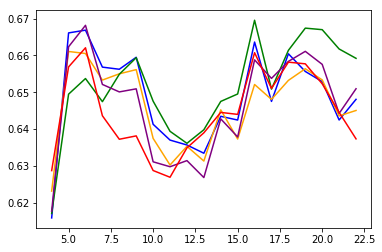

In [136]:
f_sets = [(['log_rel_freq'], 'blue'), (['log_rel_freq', 'd_u'], 'orange'), (['log_rel_freq', 'd_t'], 'green'), (['log_rel_freq', 'd_l'], 'purple'), (['log_rel_freq', 'd_u', 'd_t', 'd_l'], 'red')]
splits = 10
my_start = 1
lag = 0
clf_choice = 'logistic'

all_data_predict = PlotPerformance(data_df, splits, my_start, lag, clf_choice, f_sets)

In [235]:
display(all_data_predict.groupby(['feature_set', 'months_training']).agg(['mean', 'std']))

months_training            accuracy                  f1          
                       mean       std      mean       std      mean       std
feature_set                                                                  
0.0                    11.5  6.493587  0.665171  0.054955  0.643773  0.058972
1.0                    11.5  6.493587  0.660177  0.050471  0.642868  0.047855
2.0                    11.5  6.493587  0.664302  0.047430  0.647715  0.045951
3.0                    11.5  6.493587  0.661335  0.052939  0.643080  0.053310
4.0                    11.5  6.493587  0.655400  0.047876  0.641351  0.043097

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    412
Name: has_lag, dtype: int64

['log_rel_freq'] 1


log_rel_freq_0
0      -10.911901
1      -12.010514
2      -13.080955
3      -11.828192
4      -11.044073

1    208
0    204
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.54      0.38      0.45       204
           1       0.53      0.68      0.60       208

   micro avg       0.53      0.53      0.53       412
   macro avg       0.54      0.53      0.52       412
weighted avg       0.54      0.53      0.52       412



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    412
Name: has_lag, dtype: int64

['log_rel_freq', 'd_u'] 1


log_rel_freq_0     d_u_0
0      -10.911901  0.869773
1      -12.010514  0.890064
2      -13.080955  0.924109
3      -11.828192  0.919920
4      -11.044073  0.825615

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


1    208
0    204
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.51      0.44      0.47       204
           1       0.51      0.58      0.54       208

   micro avg       0.51      0.51      0.51       412
   macro avg       0.51      0.51      0.51       412
weighted avg       0.51      0.51      0.51       412



True    412
Name: has_lag, dtype: int64

['log_rel_freq', 'd_t'] 1


log_rel_freq_0     d_t_0
0      -10.911901  0.768851
1      -12.010514  0.896853
2      -13.080955  0.979724
3      -11.828192  0.911204
4      -11.044073  0.780665

1    208
0    204
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.53      0.43      0.47       204
           1       0.53      0.62      0.57       208

   micro avg       0.53      0.53      0.53       412
   macro avg       0.53      0.53      0.52       412
weighted avg       0.53      0.53      0.52       412



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    412
Name: has_lag, dtype: int64

['log_rel_freq', 'd_l'] 1


log_rel_freq_0     d_l_0
0      -10.911901  0.030537
1      -12.010514  0.093731
2      -13.080955  0.035397
3      -11.828192  0.012634
4      -11.044073  0.049555

1    208
0    204
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.54      0.33      0.41       204
           1       0.53      0.73      0.61       208

   micro avg       0.53      0.53      0.53       412
   macro avg       0.54      0.53      0.51       412
weighted avg       0.53      0.53      0.51       412



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    412
Name: has_lag, dtype: int64

['log_rel_freq', 'd_u', 'd_t', 'd_l'] 1


log_rel_freq_0     d_u_0     d_t_0     d_l_0
0      -10.911901  0.869773  0.768851  0.030537
1      -12.010514  0.890064  0.896853  0.093731
2      -13.080955  0.924109  0.979724  0.035397
3      -11.828192  0.919920  0.911204  0.012634
4      -11.044073  0.825615  0.780665  0.049555

1    208
0    204
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.53      0.45      0.48       204
           1       0.53      0.61      0.57       208

   micro avg       0.53      0.53      0.53       412
   macro avg       0.53      0.53      0.53       412
weighted avg       0.53      0.53      0.53       412



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    412
Name: has_lag, dtype: int64

['log_rel_freq'] 2


log_rel_freq_0  log_rel_freq_1
0      -10.911901      -10.835878
1      -12.010514      -11.845362
2      -13.080955      -12.898512
3      -11.828192      -12.051214
4      -11.044073      -11.129226

0    213
1    199
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.64      0.71      0.67       213
           1       0.65      0.57      0.61       199

   micro avg       0.64      0.64      0.64       412
   macro avg       0.64      0.64      0.64       412
weighted avg       0.64      0.64      0.64       412



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    412
Name: has_lag, dtype: int64

['log_rel_freq', 'd_u'] 2


log_rel_freq_0  log_rel_freq_1     d_u_0     d_u_1
0      -10.911901      -10.835878  0.869773  0.760024
1      -12.010514      -11.845362  0.890064  0.915284
2      -13.080955      -12.898512  0.924109  0.806231
3      -11.828192      -12.051214  0.919920  1.000272
4      -11.044073      -11.129226  0.825615  0.637017

0    213
1    199
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.64      0.72      0.68       213
           1       0.65      0.56      0.60       199

   micro avg       0.64      0.64      0.64       412
   macro avg       0.64      0.64      0.64       412
weighted avg       0.64      0.64      0.64       412



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    412
Name: has_lag, dtype: int64

['log_rel_freq', 'd_t'] 2


log_rel_freq_0  log_rel_freq_1     d_t_0     d_t_1
0      -10.911901      -10.835878  0.768851  0.883473
1      -12.010514      -11.845362  0.896853  0.889659
2      -13.080955      -12.898512  0.979724  0.783942
3      -11.828192      -12.051214  0.911204  0.952609
4      -11.044073      -11.129226  0.780665  0.669860

0    213
1    199
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.62      0.69      0.65       213
           1       0.62      0.54      0.58       199

   micro avg       0.62      0.62      0.62       412
   macro avg       0.62      0.61      0.61       412
weighted avg       0.62      0.62      0.61       412



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    412
Name: has_lag, dtype: int64

['log_rel_freq', 'd_l'] 2


log_rel_freq_0  log_rel_freq_1     d_l_0     d_l_1
0      -10.911901      -10.835878  0.030537 -0.039714
1      -12.010514      -11.845362  0.093731  0.004380
2      -13.080955      -12.898512  0.035397  0.098428
3      -11.828192      -12.051214  0.012634  0.018638
4      -11.044073      -11.129226  0.049555  0.029370

0    213
1    199
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.63      0.70      0.66       213
           1       0.64      0.56      0.60       199

   micro avg       0.63      0.63      0.63       412
   macro avg       0.63      0.63      0.63       412
weighted avg       0.63      0.63      0.63       412



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    412
Name: has_lag, dtype: int64

['log_rel_freq', 'd_u', 'd_t', 'd_l'] 2


log_rel_freq_0  log_rel_freq_1     d_u_0     d_u_1     d_t_0     d_t_1  \
0      -10.911901      -10.835878  0.869773  0.760024  0.768851  0.883473   
1      -12.010514      -11.845362  0.890064  0.915284  0.896853  0.889659   
2      -13.080955      -12.898512  0.924109  0.806231  0.979724  0.783942   
3      -11.828192      -12.051214  0.919920  1.000272  0.911204  0.952609   
4      -11.044073      -11.129226  0.825615  0.637017  0.780665  0.669860   

      d_l_0     d_l_1  
0  0.030537 -0.039714  
1  0.093731  0.004380  
2  0.035397  0.098428  
3  0.012634  0.018638  
4  0.049555  0.029370

0    213
1    199
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.62      0.68      0.65       213
           1       0.62      0.55      0.58       199

   micro avg       0.62      0.62      0.62       412
   macro avg       0.62      0.61      0.61       412
weighted avg       0.62      0.62      0.61       412



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    412
Name: has_lag, dtype: int64

['log_rel_freq'] 3


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2
0      -10.911901      -10.835878      -10.997886
1      -12.010514      -11.845362      -11.864987
2      -13.080955      -12.898512      -12.732487
3      -11.828192      -12.051214      -12.518913
4      -11.044073      -11.129226      -10.932823

1    210
0    202
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.67      0.67      0.67       202
           1       0.68      0.68      0.68       210

   micro avg       0.68      0.68      0.68       412
   macro avg       0.68      0.68      0.68       412
weighted avg       0.68      0.68      0.68       412



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    412
Name: has_lag, dtype: int64

['log_rel_freq', 'd_u'] 3


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2     d_u_0     d_u_1  \
0      -10.911901      -10.835878      -10.997886  0.869773  0.760024   
1      -12.010514      -11.845362      -11.864987  0.890064  0.915284   
2      -13.080955      -12.898512      -12.732487  0.924109  0.806231   
3      -11.828192      -12.051214      -12.518913  0.919920  1.000272   
4      -11.044073      -11.129226      -10.932823  0.825615  0.637017   

      d_u_2  
0  0.845362  
1  0.980162  
2  0.727233  
3  0.826894  
4  0.751596

1    210
0    202
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.65      0.66      0.65       202
           1       0.67      0.65      0.66       210

   micro avg       0.66      0.66      0.66       412
   macro avg       0.66      0.66      0.66       412
weighted avg       0.66      0.66      0.66       412



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    412
Name: has_lag, dtype: int64

['log_rel_freq', 'd_t'] 3


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2     d_t_0     d_t_1  \
0      -10.911901      -10.835878      -10.997886  0.768851  0.883473   
1      -12.010514      -11.845362      -11.864987  0.896853  0.889659   
2      -13.080955      -12.898512      -12.732487  0.979724  0.783942   
3      -11.828192      -12.051214      -12.518913  0.911204  0.952609   
4      -11.044073      -11.129226      -10.932823  0.780665  0.669860   

      d_t_2  
0  0.861191  
1  0.963498  
2  0.841894  
3  0.869024  
4  0.768348

1    210
0    202
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.65      0.66      0.66       202
           1       0.67      0.66      0.67       210

   micro avg       0.66      0.66      0.66       412
   macro avg       0.66      0.66      0.66       412
weighted avg       0.66      0.66      0.66       412



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    412
Name: has_lag, dtype: int64

['log_rel_freq', 'd_l'] 3


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2     d_l_0     d_l_1  \
0      -10.911901      -10.835878      -10.997886  0.030537 -0.039714   
1      -12.010514      -11.845362      -11.864987  0.093731  0.004380   
2      -13.080955      -12.898512      -12.732487  0.035397  0.098428   
3      -11.828192      -12.051214      -12.518913  0.012634  0.018638   
4      -11.044073      -11.129226      -10.932823  0.049555  0.029370   

      d_l_2  
0  0.028621  
1  0.077819  
2  0.098100  
3  0.082933  
4 -0.001935

1    210
0    202
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.67      0.70      0.69       202
           1       0.70      0.67      0.68       210

   micro avg       0.68      0.68      0.68       412
   macro avg       0.68      0.68      0.68       412
weighted avg       0.69      0.68      0.68       412



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    412
Name: has_lag, dtype: int64

['log_rel_freq', 'd_u', 'd_t', 'd_l'] 3


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2     d_u_0     d_u_1  \
0      -10.911901      -10.835878      -10.997886  0.869773  0.760024   
1      -12.010514      -11.845362      -11.864987  0.890064  0.915284   
2      -13.080955      -12.898512      -12.732487  0.924109  0.806231   
3      -11.828192      -12.051214      -12.518913  0.919920  1.000272   
4      -11.044073      -11.129226      -10.932823  0.825615  0.637017   

      d_u_2     d_t_0     d_t_1     d_t_2     d_l_0     d_l_1     d_l_2  
0  0.845362  0.768851  0.883473  0.861191  0.030537 -0.039714  0.028621  
1  0.980162  0.896853  0.889659  0.963498  0.093731  0.004380  0.077819  
2  0.727233  0.979724  0.783942  0.841894  0.035397  0.098428  0.098100  
3  0.826894  0.911204  0.952609  0.869024  0.012634  0.018638  0.082933  
4  0.751596  0.780665  0.669860  0.768348  0.049555  0.029370 -0.001935

1    210
0    202
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.63      0.60      0.62       202
           1       0.63      0.66      0.65       210

   micro avg       0.63      0.63      0.63       412
   macro avg       0.63      0.63      0.63       412
weighted avg       0.63      0.63      0.63       412



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    412
Name: has_lag, dtype: int64

['log_rel_freq'] 4


log_rel_freq_1  log_rel_freq_2  log_rel_freq_3
0      -10.835878      -10.997886      -11.216208
1      -11.845362      -11.864987      -11.690666
2      -12.898512      -12.732487      -13.151069
3      -12.051214      -12.518913      -12.457922
4      -11.129226      -10.932823      -11.071627

1    224
0    188
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.75      0.53      0.62       188
           1       0.68      0.85      0.76       224

   micro avg       0.70      0.70      0.70       412
   macro avg       0.71      0.69      0.69       412
weighted avg       0.71      0.70      0.69       412



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    412
Name: has_lag, dtype: int64

['log_rel_freq', 'd_u'] 4


log_rel_freq_1  log_rel_freq_2  log_rel_freq_3     d_u_1     d_u_2  \
0      -10.835878      -10.997886      -11.216208  0.760024  0.845362   
1      -11.845362      -11.864987      -11.690666  0.915284  0.980162   
2      -12.898512      -12.732487      -13.151069  0.806231  0.727233   
3      -12.051214      -12.518913      -12.457922  1.000272  0.826894   
4      -11.129226      -10.932823      -11.071627  0.637017  0.751596   

      d_u_3  
0  0.910071  
1  0.832471  
2  1.001514  
3  0.976596  
4  0.720049

1    224
0    188
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.70      0.51      0.59       188
           1       0.66      0.82      0.73       224

   micro avg       0.67      0.67      0.67       412
   macro avg       0.68      0.66      0.66       412
weighted avg       0.68      0.67      0.67       412



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    412
Name: has_lag, dtype: int64

['log_rel_freq', 'd_t'] 4


log_rel_freq_1  log_rel_freq_2  log_rel_freq_3     d_t_1     d_t_2  \
0      -10.835878      -10.997886      -11.216208  0.883473  0.861191   
1      -11.845362      -11.864987      -11.690666  0.889659  0.963498   
2      -12.898512      -12.732487      -13.151069  0.783942  0.841894   
3      -12.051214      -12.518913      -12.457922  0.952609  0.869024   
4      -11.129226      -10.932823      -11.071627  0.669860  0.768348   

      d_t_3  
0  0.886630  
1  0.878245  
2  0.981675  
3  0.906714  
4  0.796188

1    224
0    188
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.68      0.53      0.60       188
           1       0.67      0.79      0.73       224

   micro avg       0.67      0.67      0.67       412
   macro avg       0.68      0.66      0.66       412
weighted avg       0.68      0.67      0.67       412



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    412
Name: has_lag, dtype: int64

['log_rel_freq', 'd_l'] 4


log_rel_freq_1  log_rel_freq_2  log_rel_freq_3     d_l_1     d_l_2  \
0      -10.835878      -10.997886      -11.216208 -0.039714  0.028621   
1      -11.845362      -11.864987      -11.690666  0.004380  0.077819   
2      -12.898512      -12.732487      -13.151069  0.098428  0.098100   
3      -12.051214      -12.518913      -12.457922  0.018638  0.082933   
4      -11.129226      -10.932823      -11.071627  0.029370 -0.001935   

      d_l_3  
0  0.009015  
1  0.133478  
2  0.096517  
3  0.069968  
4  0.052198

1    224
0    188
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.71      0.51      0.59       188
           1       0.67      0.82      0.74       224

   micro avg       0.68      0.68      0.68       412
   macro avg       0.69      0.67      0.66       412
weighted avg       0.68      0.68      0.67       412



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    412
Name: has_lag, dtype: int64

['log_rel_freq', 'd_u', 'd_t', 'd_l'] 4


log_rel_freq_1  log_rel_freq_2  log_rel_freq_3     d_u_1     d_u_2  \
0      -10.835878      -10.997886      -11.216208  0.760024  0.845362   
1      -11.845362      -11.864987      -11.690666  0.915284  0.980162   
2      -12.898512      -12.732487      -13.151069  0.806231  0.727233   
3      -12.051214      -12.518913      -12.457922  1.000272  0.826894   
4      -11.129226      -10.932823      -11.071627  0.637017  0.751596   

      d_u_3     d_t_1     d_t_2     d_t_3     d_l_1     d_l_2     d_l_3  
0  0.910071  0.883473  0.861191  0.886630 -0.039714  0.028621  0.009015  
1  0.832471  0.889659  0.963498  0.878245  0.004380  0.077819  0.133478  
2  1.001514  0.783942  0.841894  0.981675  0.098428  0.098100  0.096517  
3  0.976596  0.952609  0.869024  0.906714  0.018638  0.082933  0.069968  
4  0.720049  0.669860  0.768348  0.796188  0.029370 -0.001935  0.052198

1    224
0    188
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.66      0.51      0.57       188
           1       0.65      0.78      0.71       224

   micro avg       0.66      0.66      0.66       412
   macro avg       0.66      0.64      0.64       412
weighted avg       0.66      0.66      0.65       412



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    412
Name: has_lag, dtype: int64

['log_rel_freq'] 5


log_rel_freq_2  log_rel_freq_3  log_rel_freq_4
0      -10.997886      -11.216208      -11.241965
1      -11.864987      -11.690666      -12.226819
2      -12.732487      -13.151069      -12.616283
3      -12.518913      -12.457922      -12.525312
4      -10.932823      -11.071627      -11.172170

1    212
0    200
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.67      0.68      0.67       200
           1       0.69      0.68      0.69       212

   micro avg       0.68      0.68      0.68       412
   macro avg       0.68      0.68      0.68       412
weighted avg       0.68      0.68      0.68       412



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    412
Name: has_lag, dtype: int64

['log_rel_freq', 'd_u'] 5


log_rel_freq_2  log_rel_freq_3  log_rel_freq_4     d_u_2     d_u_3  \
0      -10.997886      -11.216208      -11.241965  0.845362  0.910071   
1      -11.864987      -11.690666      -12.226819  0.980162  0.832471   
2      -12.732487      -13.151069      -12.616283  0.727233  1.001514   
3      -12.518913      -12.457922      -12.525312  0.826894  0.976596   
4      -10.932823      -11.071627      -11.172170  0.751596  0.720049   

      d_u_4  
0  0.931536  
1  0.852873  
2  0.911992  
3  0.834293  
4  0.717670

1    212
0    200
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.63      0.59      0.61       200
           1       0.64      0.67      0.66       212

   micro avg       0.64      0.64      0.64       412
   macro avg       0.64      0.63      0.63       412
weighted avg       0.64      0.64      0.64       412



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    412
Name: has_lag, dtype: int64

['log_rel_freq', 'd_t'] 5


log_rel_freq_2  log_rel_freq_3  log_rel_freq_4     d_t_2     d_t_3  \
0      -10.997886      -11.216208      -11.241965  0.861191  0.886630   
1      -11.864987      -11.690666      -12.226819  0.963498  0.878245   
2      -12.732487      -13.151069      -12.616283  0.841894  0.981675   
3      -12.518913      -12.457922      -12.525312  0.869024  0.906714   
4      -10.932823      -11.071627      -11.172170  0.768348  0.796188   

      d_t_4  
0  0.817970  
1  0.918367  
2  0.934540  
3  0.853352  
4  0.763024

1    212
0    200
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.64      0.60      0.62       200
           1       0.64      0.67      0.66       212

   micro avg       0.64      0.64      0.64       412
   macro avg       0.64      0.64      0.64       412
weighted avg       0.64      0.64      0.64       412



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    412
Name: has_lag, dtype: int64

['log_rel_freq', 'd_l'] 5


log_rel_freq_2  log_rel_freq_3  log_rel_freq_4     d_l_2     d_l_3  \
0      -10.997886      -11.216208      -11.241965  0.028621  0.009015   
1      -11.864987      -11.690666      -12.226819  0.077819  0.133478   
2      -12.732487      -13.151069      -12.616283  0.098100  0.096517   
3      -12.518913      -12.457922      -12.525312  0.082933  0.069968   
4      -10.932823      -11.071627      -11.172170 -0.001935  0.052198   

      d_l_4  
0  0.023419  
1  0.035077  
2  0.062018  
3 -0.009103  
4  0.035859

1    212
0    200
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.65      0.67      0.66       200
           1       0.68      0.66      0.67       212

   micro avg       0.66      0.66      0.66       412
   macro avg       0.66      0.66      0.66       412
weighted avg       0.66      0.66      0.66       412



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    412
Name: has_lag, dtype: int64

['log_rel_freq', 'd_u', 'd_t', 'd_l'] 5


log_rel_freq_2  log_rel_freq_3  log_rel_freq_4     d_u_2     d_u_3  \
0      -10.997886      -11.216208      -11.241965  0.845362  0.910071   
1      -11.864987      -11.690666      -12.226819  0.980162  0.832471   
2      -12.732487      -13.151069      -12.616283  0.727233  1.001514   
3      -12.518913      -12.457922      -12.525312  0.826894  0.976596   
4      -10.932823      -11.071627      -11.172170  0.751596  0.720049   

      d_u_4     d_t_2     d_t_3     d_t_4     d_l_2     d_l_3     d_l_4  
0  0.931536  0.861191  0.886630  0.817970  0.028621  0.009015  0.023419  
1  0.852873  0.963498  0.878245  0.918367  0.077819  0.133478  0.035077  
2  0.911992  0.841894  0.981675  0.934540  0.098100  0.096517  0.062018  
3  0.834293  0.869024  0.906714  0.853352  0.082933  0.069968 -0.009103  
4  0.717670  0.768348  0.796188  0.763024 -0.001935  0.052198  0.035859

1    212
0    200
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.64      0.60      0.62       200
           1       0.65      0.68      0.67       212

   micro avg       0.65      0.65      0.65       412
   macro avg       0.65      0.64      0.64       412
weighted avg       0.65      0.65      0.65       412



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    412
Name: has_lag, dtype: int64

['log_rel_freq'] 6


log_rel_freq_3  log_rel_freq_4  log_rel_freq_5
0      -11.216208      -11.241965      -11.265598
1      -11.690666      -12.226819      -12.076528
2      -13.151069      -12.616283      -13.367512
3      -12.457922      -12.525312      -13.367512
4      -11.071627      -11.172170      -11.421602

0    241
1    171
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.67      0.89      0.76       241
           1       0.71      0.37      0.49       171

   micro avg       0.68      0.68      0.68       412
   macro avg       0.69      0.63      0.63       412
weighted avg       0.69      0.68      0.65       412



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    412
Name: has_lag, dtype: int64

['log_rel_freq', 'd_u'] 6


log_rel_freq_3  log_rel_freq_4  log_rel_freq_5     d_u_3     d_u_4  \
0      -11.216208      -11.241965      -11.265598  0.910071  0.931536   
1      -11.690666      -12.226819      -12.076528  0.832471  0.852873   
2      -13.151069      -12.616283      -13.367512  1.001514  0.911992   
3      -12.457922      -12.525312      -13.367512  0.976596  0.834293   
4      -11.071627      -11.172170      -11.421602  0.720049  0.717670   

      d_u_5  
0  0.941358  
1  0.877785  
2  0.819611  
3  1.001747  
4  0.725199

0    241
1    171
Name: label, dtype: int64


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


              precision    recall  f1-score   support

           0       0.67      0.88      0.76       241
           1       0.70      0.39      0.50       171

   micro avg       0.68      0.68      0.68       412
   macro avg       0.69      0.63      0.63       412
weighted avg       0.68      0.68      0.65       412



True    412
Name: has_lag, dtype: int64

['log_rel_freq', 'd_t'] 6


log_rel_freq_3  log_rel_freq_4  log_rel_freq_5     d_t_3     d_t_4  \
0      -11.216208      -11.241965      -11.265598  0.886630  0.817970   
1      -11.690666      -12.226819      -12.076528  0.878245  0.918367   
2      -13.151069      -12.616283      -13.367512  0.981675  0.934540   
3      -12.457922      -12.525312      -13.367512  0.906714  0.853352   
4      -11.071627      -11.172170      -11.421602  0.796188  0.763024   

      d_t_5  
0  0.886457  
1  0.909453  
2  0.714293  
3  0.982153  
4  0.779927

0    241
1    171
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.66      0.87      0.75       241
           1       0.66      0.36      0.46       171

   micro avg       0.66      0.66      0.66       412
   macro avg       0.66      0.61      0.60       412
weighted avg       0.66      0.66      0.63       412



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    412
Name: has_lag, dtype: int64

['log_rel_freq', 'd_l'] 6


log_rel_freq_3  log_rel_freq_4  log_rel_freq_5     d_l_3     d_l_4  \
0      -11.216208      -11.241965      -11.265598  0.009015  0.023419   
1      -11.690666      -12.226819      -12.076528  0.133478  0.035077   
2      -13.151069      -12.616283      -13.367512  0.096517  0.062018   
3      -12.457922      -12.525312      -13.367512  0.069968 -0.009103   
4      -11.071627      -11.172170      -11.421602  0.052198  0.035859   

      d_l_5  
0  0.000567  
1  0.084124  
2  0.087896  
3  0.087896  
4 -0.041146

0    241
1    171
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.66      0.88      0.76       241
           1       0.69      0.37      0.48       171

   micro avg       0.67      0.67      0.67       412
   macro avg       0.68      0.63      0.62       412
weighted avg       0.68      0.67      0.64       412



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    412
Name: has_lag, dtype: int64

['log_rel_freq', 'd_u', 'd_t', 'd_l'] 6


log_rel_freq_3  log_rel_freq_4  log_rel_freq_5     d_u_3     d_u_4  \
0      -11.216208      -11.241965      -11.265598  0.910071  0.931536   
1      -11.690666      -12.226819      -12.076528  0.832471  0.852873   
2      -13.151069      -12.616283      -13.367512  1.001514  0.911992   
3      -12.457922      -12.525312      -13.367512  0.976596  0.834293   
4      -11.071627      -11.172170      -11.421602  0.720049  0.717670   

      d_u_5     d_t_3     d_t_4     d_t_5     d_l_3     d_l_4     d_l_5  
0  0.941358  0.886630  0.817970  0.886457  0.009015  0.023419  0.000567  
1  0.877785  0.878245  0.918367  0.909453  0.133478  0.035077  0.084124  
2  0.819611  0.981675  0.934540  0.714293  0.096517  0.062018  0.087896  
3  1.001747  0.906714  0.853352  0.982153  0.069968 -0.009103  0.087896  
4  0.725199  0.796188  0.763024  0.779927  0.052198  0.035859 -0.041146

0    241
1    171
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.65      0.83      0.73       241
           1       0.62      0.37      0.47       171

   micro avg       0.64      0.64      0.64       412
   macro avg       0.63      0.60      0.60       412
weighted avg       0.64      0.64      0.62       412



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    412
Name: has_lag, dtype: int64

['log_rel_freq'] 7


log_rel_freq_4  log_rel_freq_5  log_rel_freq_6
0      -11.241965      -11.265598      -11.296662
1      -12.226819      -12.076528      -11.531063
2      -12.616283      -13.367512      -13.891917
3      -12.525312      -13.367512      -12.862297
4      -11.172170      -11.421602      -11.157549

1    216
0    196
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.61      0.52      0.56       196
           1       0.61      0.70      0.65       216

   micro avg       0.61      0.61      0.61       412
   macro avg       0.61      0.61      0.61       412
weighted avg       0.61      0.61      0.61       412



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    412
Name: has_lag, dtype: int64

['log_rel_freq', 'd_u'] 7


log_rel_freq_4  log_rel_freq_5  log_rel_freq_6     d_u_4     d_u_5  \
0      -11.241965      -11.265598      -11.296662  0.931536  0.941358   
1      -12.226819      -12.076528      -11.531063  0.852873  0.877785   
2      -12.616283      -13.367512      -13.891917  0.911992  0.819611   
3      -12.525312      -13.367512      -12.862297  0.834293  1.001747   
4      -11.172170      -11.421602      -11.157549  0.717670  0.725199   

      d_u_6  
0  0.866979  
1  0.852866  
2  0.994080  
3  0.899356  
4  0.737393

1    216
0    196
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.62      0.58      0.60       196
           1       0.64      0.67      0.65       216

   micro avg       0.63      0.63      0.63       412
   macro avg       0.63      0.63      0.63       412
weighted avg       0.63      0.63      0.63       412



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    412
Name: has_lag, dtype: int64

['log_rel_freq', 'd_t'] 7


log_rel_freq_4  log_rel_freq_5  log_rel_freq_6     d_t_4     d_t_5  \
0      -11.241965      -11.265598      -11.296662  0.817970  0.886457   
1      -12.226819      -12.076528      -11.531063  0.918367  0.909453   
2      -12.616283      -13.367512      -13.891917  0.934540  0.714293   
3      -12.525312      -13.367512      -12.862297  0.853352  0.982153   
4      -11.172170      -11.421602      -11.157549  0.763024  0.779927   

      d_t_6  
0  0.826519  
1  0.913440  
2  0.984968  
3  0.915151  
4  0.809577

1    216
0    196
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.61      0.54      0.57       196
           1       0.62      0.69      0.65       216

   micro avg       0.61      0.61      0.61       412
   macro avg       0.61      0.61      0.61       412
weighted avg       0.61      0.61      0.61       412



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    412
Name: has_lag, dtype: int64

['log_rel_freq', 'd_l'] 7


log_rel_freq_4  log_rel_freq_5  log_rel_freq_6     d_l_4     d_l_5  \
0      -11.241965      -11.265598      -11.296662  0.023419  0.000567   
1      -12.226819      -12.076528      -11.531063  0.035077  0.084124   
2      -12.616283      -13.367512      -13.891917  0.062018  0.087896   
3      -12.525312      -13.367512      -12.862297 -0.009103  0.087896   
4      -11.172170      -11.421602      -11.157549  0.035859 -0.041146   

      d_l_6  
0  0.054551  
1  0.060069  
2  0.021062  
3  0.082134  
4  0.034288

1    216
0    196
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.59      0.53      0.56       196
           1       0.61      0.67      0.64       216

   micro avg       0.60      0.60      0.60       412
   macro avg       0.60      0.60      0.60       412
weighted avg       0.60      0.60      0.60       412



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    412
Name: has_lag, dtype: int64

['log_rel_freq', 'd_u', 'd_t', 'd_l'] 7


log_rel_freq_4  log_rel_freq_5  log_rel_freq_6     d_u_4     d_u_5  \
0      -11.241965      -11.265598      -11.296662  0.931536  0.941358   
1      -12.226819      -12.076528      -11.531063  0.852873  0.877785   
2      -12.616283      -13.367512      -13.891917  0.911992  0.819611   
3      -12.525312      -13.367512      -12.862297  0.834293  1.001747   
4      -11.172170      -11.421602      -11.157549  0.717670  0.725199   

      d_u_6     d_t_4     d_t_5     d_t_6     d_l_4     d_l_5     d_l_6  
0  0.866979  0.817970  0.886457  0.826519  0.023419  0.000567  0.054551  
1  0.852866  0.918367  0.909453  0.913440  0.035077  0.084124  0.060069  
2  0.994080  0.934540  0.714293  0.984968  0.062018  0.087896  0.021062  
3  0.899356  0.853352  0.982153  0.915151 -0.009103  0.087896  0.082134  
4  0.737393  0.763024  0.779927  0.809577  0.035859 -0.041146  0.034288

1    216
0    196
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.58      0.53      0.55       196
           1       0.60      0.65      0.62       216

   micro avg       0.59      0.59      0.59       412
   macro avg       0.59      0.59      0.59       412
weighted avg       0.59      0.59      0.59       412



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    412
Name: has_lag, dtype: int64

['log_rel_freq'] 8


log_rel_freq_5  log_rel_freq_6  log_rel_freq_7
0      -11.265598      -11.296662      -11.290883
1      -12.076528      -11.531063      -11.863402
2      -13.367512      -13.891917      -13.414000
3      -13.367512      -12.862297      -12.619070
4      -11.421602      -11.157549      -11.352576

0    227
1    185
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.65      0.77      0.70       227
           1       0.63      0.48      0.55       185

   micro avg       0.64      0.64      0.64       412
   macro avg       0.64      0.63      0.62       412
weighted avg       0.64      0.64      0.63       412



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    412
Name: has_lag, dtype: int64

['log_rel_freq', 'd_u'] 8


log_rel_freq_5  log_rel_freq_6  log_rel_freq_7     d_u_5     d_u_6  \
0      -11.265598      -11.296662      -11.290883  0.941358  0.866979   
1      -12.076528      -11.531063      -11.863402  0.877785  0.852866   
2      -13.367512      -13.891917      -13.414000  0.819611  0.994080   
3      -13.367512      -12.862297      -12.619070  1.001747  0.899356   
4      -11.421602      -11.157549      -11.352576  0.725199  0.737393   

      d_u_7  
0  0.914030  
1  0.843643  
2  0.778726  
3  0.966639  
4  0.634432

0    227
1    185
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.64      0.74      0.69       227
           1       0.60      0.49      0.54       185

   micro avg       0.63      0.63      0.63       412
   macro avg       0.62      0.61      0.61       412
weighted avg       0.62      0.63      0.62       412



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    412
Name: has_lag, dtype: int64

['log_rel_freq', 'd_t'] 8


log_rel_freq_5  log_rel_freq_6  log_rel_freq_7     d_t_5     d_t_6  \
0      -11.265598      -11.296662      -11.290883  0.886457  0.826519   
1      -12.076528      -11.531063      -11.863402  0.909453  0.913440   
2      -13.367512      -13.891917      -13.414000  0.714293  0.984968   
3      -13.367512      -12.862297      -12.619070  0.982153  0.915151   
4      -11.421602      -11.157549      -11.352576  0.779927  0.809577   

      d_t_7  
0  0.819013  
1  0.881584  
2  0.843777  
3  0.984991  
4  0.736248

0    227
1    185
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.66      0.77      0.71       227
           1       0.64      0.51      0.57       185

   micro avg       0.65      0.65      0.65       412
   macro avg       0.65      0.64      0.64       412
weighted avg       0.65      0.65      0.65       412



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    412
Name: has_lag, dtype: int64

['log_rel_freq', 'd_l'] 8


log_rel_freq_5  log_rel_freq_6  log_rel_freq_7     d_l_5     d_l_6  \
0      -11.265598      -11.296662      -11.290883  0.000567  0.054551   
1      -12.076528      -11.531063      -11.863402  0.084124  0.060069   
2      -13.367512      -13.891917      -13.414000  0.087896  0.021062   
3      -13.367512      -12.862297      -12.619070  0.087896  0.082134   
4      -11.421602      -11.157549      -11.352576 -0.041146  0.034288   

      d_l_7  
0  0.002161  
1  0.062811  
2  0.078652  
3  0.078730  
4 -0.002196

0    227
1    185
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.65      0.75      0.70       227
           1       0.62      0.49      0.55       185

   micro avg       0.64      0.64      0.64       412
   macro avg       0.63      0.62      0.62       412
weighted avg       0.63      0.64      0.63       412



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    412
Name: has_lag, dtype: int64

['log_rel_freq', 'd_u', 'd_t', 'd_l'] 8


log_rel_freq_5  log_rel_freq_6  log_rel_freq_7     d_u_5     d_u_6  \
0      -11.265598      -11.296662      -11.290883  0.941358  0.866979   
1      -12.076528      -11.531063      -11.863402  0.877785  0.852866   
2      -13.367512      -13.891917      -13.414000  0.819611  0.994080   
3      -13.367512      -12.862297      -12.619070  1.001747  0.899356   
4      -11.421602      -11.157549      -11.352576  0.725199  0.737393   

      d_u_7     d_t_5     d_t_6     d_t_7     d_l_5     d_l_6     d_l_7  
0  0.914030  0.886457  0.826519  0.819013  0.000567  0.054551  0.002161  
1  0.843643  0.909453  0.913440  0.881584  0.084124  0.060069  0.062811  
2  0.778726  0.714293  0.984968  0.843777  0.087896  0.021062  0.078652  
3  0.966639  0.982153  0.915151  0.984991  0.087896  0.082134  0.078730  
4  0.634432  0.779927  0.809577  0.736248 -0.041146  0.034288 -0.002196

0    227
1    185
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.64      0.76      0.70       227
           1       0.62      0.49      0.55       185

   micro avg       0.64      0.64      0.64       412
   macro avg       0.63      0.62      0.62       412
weighted avg       0.63      0.64      0.63       412



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    412
Name: has_lag, dtype: int64

['log_rel_freq'] 9


log_rel_freq_6  log_rel_freq_7  log_rel_freq_8
0      -11.296662      -11.290883      -11.424176
1      -11.531063      -11.863402      -11.767121
2      -13.891917      -13.414000      -12.843260
3      -12.862297      -12.619070      -12.877162
4      -11.157549      -11.352576      -10.751396

0    222
1    190
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.68      0.83      0.75       222
           1       0.73      0.54      0.62       190

   micro avg       0.70      0.70      0.70       412
   macro avg       0.71      0.69      0.68       412
weighted avg       0.70      0.70      0.69       412



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    412
Name: has_lag, dtype: int64

['log_rel_freq', 'd_u'] 9


log_rel_freq_6  log_rel_freq_7  log_rel_freq_8     d_u_6     d_u_7  \
0      -11.296662      -11.290883      -11.424176  0.866979  0.914030   
1      -11.531063      -11.863402      -11.767121  0.852866  0.843643   
2      -13.891917      -13.414000      -12.843260  0.994080  0.778726   
3      -12.862297      -12.619070      -12.877162  0.899356  0.966639   
4      -11.157549      -11.352576      -10.751396  0.737393  0.634432   

      d_u_8  
0  0.915950  
1  0.835126  
2  0.832215  
3  0.998237  
4  0.552259

0    222
1    190
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.69      0.74      0.71       222
           1       0.67      0.61      0.64       190

   micro avg       0.68      0.68      0.68       412
   macro avg       0.68      0.67      0.68       412
weighted avg       0.68      0.68      0.68       412



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    412
Name: has_lag, dtype: int64

['log_rel_freq', 'd_t'] 9


log_rel_freq_6  log_rel_freq_7  log_rel_freq_8     d_t_6     d_t_7  \
0      -11.296662      -11.290883      -11.424176  0.826519  0.819013   
1      -11.531063      -11.863402      -11.767121  0.913440  0.881584   
2      -13.891917      -13.414000      -12.843260  0.984968  0.843777   
3      -12.862297      -12.619070      -12.877162  0.915151  0.984991   
4      -11.157549      -11.352576      -10.751396  0.809577  0.736248   

      d_t_8  
0  0.909193  
1  0.909320  
2  0.920451  
3  0.952162  
4  0.730971

0    222
1    190
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.68      0.73      0.70       222
           1       0.65      0.61      0.63       190

   micro avg       0.67      0.67      0.67       412
   macro avg       0.67      0.67      0.67       412
weighted avg       0.67      0.67      0.67       412



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    412
Name: has_lag, dtype: int64

['log_rel_freq', 'd_l'] 9


log_rel_freq_6  log_rel_freq_7  log_rel_freq_8     d_l_6     d_l_7  \
0      -11.296662      -11.290883      -11.424176  0.054551  0.002161   
1      -11.531063      -11.863402      -11.767121  0.060069  0.062811   
2      -13.891917      -13.414000      -12.843260  0.021062  0.078652   
3      -12.862297      -12.619070      -12.877162  0.082134  0.078730   
4      -11.157549      -11.352576      -10.751396  0.034288 -0.002196   

      d_l_8  
0 -0.025294  
1  0.084113  
2  0.055360  
3  0.063512  
4  0.000037

0    222
1    190
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.67      0.80      0.73       222
           1       0.70      0.55      0.62       190

   micro avg       0.68      0.68      0.68       412
   macro avg       0.69      0.67      0.67       412
weighted avg       0.69      0.68      0.68       412



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    412
Name: has_lag, dtype: int64

['log_rel_freq', 'd_u', 'd_t', 'd_l'] 9


log_rel_freq_6  log_rel_freq_7  log_rel_freq_8     d_u_6     d_u_7  \
0      -11.296662      -11.290883      -11.424176  0.866979  0.914030   
1      -11.531063      -11.863402      -11.767121  0.852866  0.843643   
2      -13.891917      -13.414000      -12.843260  0.994080  0.778726   
3      -12.862297      -12.619070      -12.877162  0.899356  0.966639   
4      -11.157549      -11.352576      -10.751396  0.737393  0.634432   

      d_u_8     d_t_6     d_t_7     d_t_8     d_l_6     d_l_7     d_l_8  
0  0.915950  0.826519  0.819013  0.909193  0.054551  0.002161 -0.025294  
1  0.835126  0.913440  0.881584  0.909320  0.060069  0.062811  0.084113  
2  0.832215  0.984968  0.843777  0.920451  0.021062  0.078652  0.055360  
3  0.998237  0.915151  0.984991  0.952162  0.082134  0.078730  0.063512  
4  0.552259  0.809577  0.736248  0.730971  0.034288 -0.002196  0.000037

0    222
1    190
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.66      0.75      0.70       222
           1       0.66      0.55      0.60       190

   micro avg       0.66      0.66      0.66       412
   macro avg       0.66      0.65      0.65       412
weighted avg       0.66      0.66      0.66       412



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    412
Name: has_lag, dtype: int64

['log_rel_freq'] 10


log_rel_freq_7  log_rel_freq_8  log_rel_freq_9
0      -11.290883      -11.424176      -11.276995
1      -11.863402      -11.767121      -11.511642
2      -13.414000      -12.843260      -13.822526
3      -12.619070      -12.877162      -12.133046
4      -11.352576      -10.751396      -10.974714

0    248
1    164
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.64      0.95      0.76       248
           1       0.70      0.19      0.30       164

   micro avg       0.65      0.65      0.65       412
   macro avg       0.67      0.57      0.53       412
weighted avg       0.66      0.65      0.58       412



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    412
Name: has_lag, dtype: int64

['log_rel_freq', 'd_u'] 10


log_rel_freq_7  log_rel_freq_8  log_rel_freq_9     d_u_7     d_u_8  \
0      -11.290883      -11.424176      -11.276995  0.914030  0.915950   
1      -11.863402      -11.767121      -11.511642  0.843643  0.835126   
2      -13.414000      -12.843260      -13.822526  0.778726  0.832215   
3      -12.619070      -12.877162      -12.133046  0.966639  0.998237   
4      -11.352576      -10.751396      -10.974714  0.634432  0.552259   

      d_u_9  
0  0.940467  
1  0.904857  
2  0.991447  
3  0.795194  
4  0.643753

0    248
1    164
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.62      0.92      0.74       248
           1       0.56      0.16      0.25       164

   micro avg       0.62      0.62      0.62       412
   macro avg       0.59      0.54      0.50       412
weighted avg       0.60      0.62      0.55       412



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    412
Name: has_lag, dtype: int64

['log_rel_freq', 'd_t'] 10


log_rel_freq_7  log_rel_freq_8  log_rel_freq_9     d_t_7     d_t_8  \
0      -11.290883      -11.424176      -11.276995  0.819013  0.909193   
1      -11.863402      -11.767121      -11.511642  0.881584  0.909320   
2      -13.414000      -12.843260      -13.822526  0.843777  0.920451   
3      -12.619070      -12.877162      -12.133046  0.984991  0.952162   
4      -11.352576      -10.751396      -10.974714  0.736248  0.730971   

      d_t_9  
0  0.841189  
1  0.923755  
2  0.986152  
3  0.850876  
4  0.756760

0    248
1    164
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.65      0.87      0.74       248
           1       0.58      0.28      0.38       164

   micro avg       0.63      0.63      0.63       412
   macro avg       0.61      0.57      0.56       412
weighted avg       0.62      0.63      0.60       412



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    412
Name: has_lag, dtype: int64

['log_rel_freq', 'd_l'] 10


log_rel_freq_7  log_rel_freq_8  log_rel_freq_9     d_l_7     d_l_8  \
0      -11.290883      -11.424176      -11.276995  0.002161 -0.025294   
1      -11.863402      -11.767121      -11.511642  0.062811  0.084113   
2      -13.414000      -12.843260      -13.822526  0.078652  0.055360   
3      -12.619070      -12.877162      -12.133046  0.078730  0.063512   
4      -11.352576      -10.751396      -10.974714 -0.002196  0.000037   

      d_l_9  
0 -0.028149  
1  0.082306  
2  0.076819  
3  0.050523  
4  0.051070

0    248
1    164
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.65      0.94      0.77       248
           1       0.72      0.23      0.35       164

   micro avg       0.66      0.66      0.66       412
   macro avg       0.68      0.59      0.56       412
weighted avg       0.68      0.66      0.60       412



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    412
Name: has_lag, dtype: int64

['log_rel_freq', 'd_u', 'd_t', 'd_l'] 10


log_rel_freq_7  log_rel_freq_8  log_rel_freq_9     d_u_7     d_u_8  \
0      -11.290883      -11.424176      -11.276995  0.914030  0.915950   
1      -11.863402      -11.767121      -11.511642  0.843643  0.835126   
2      -13.414000      -12.843260      -13.822526  0.778726  0.832215   
3      -12.619070      -12.877162      -12.133046  0.966639  0.998237   
4      -11.352576      -10.751396      -10.974714  0.634432  0.552259   

      d_u_9     d_t_7     d_t_8     d_t_9     d_l_7     d_l_8     d_l_9  
0  0.940467  0.819013  0.909193  0.841189  0.002161 -0.025294 -0.028149  
1  0.904857  0.881584  0.909320  0.923755  0.062811  0.084113  0.082306  
2  0.991447  0.843777  0.920451  0.986152  0.078652  0.055360  0.076819  
3  0.795194  0.984991  0.952162  0.850876  0.078730  0.063512  0.050523  
4  0.643753  0.736248  0.730971  0.756760 -0.002196  0.000037  0.051070

0    248
1    164
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.65      0.82      0.73       248
           1       0.56      0.34      0.42       164

   micro avg       0.63      0.63      0.63       412
   macro avg       0.60      0.58      0.57       412
weighted avg       0.61      0.63      0.60       412



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    412
Name: has_lag, dtype: int64

['log_rel_freq'] 11


log_rel_freq_8  log_rel_freq_9  log_rel_freq_10
0      -11.424176      -11.276995       -11.465655
1      -11.767121      -11.511642       -11.507915
2      -12.843260      -13.822526       -13.552017
3      -12.877162      -12.133046       -12.550568
4      -10.751396      -10.974714       -10.924936

1    222
0    190
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.66      0.39      0.49       190
           1       0.61      0.83      0.70       222

   micro avg       0.63      0.63      0.63       412
   macro avg       0.64      0.61      0.60       412
weighted avg       0.64      0.63      0.61       412



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    412
Name: has_lag, dtype: int64

['log_rel_freq', 'd_u'] 11


log_rel_freq_8  log_rel_freq_9  log_rel_freq_10     d_u_8     d_u_9  \
0      -11.424176      -11.276995       -11.465655  0.915950  0.940467   
1      -11.767121      -11.511642       -11.507915  0.835126  0.904857   
2      -12.843260      -13.822526       -13.552017  0.832215  0.991447   
3      -12.877162      -12.133046       -12.550568  0.998237  0.795194   
4      -10.751396      -10.974714       -10.924936  0.552259  0.643753   

     d_u_10  
0  0.921762  
1  0.869988  
2  0.996857  
3  0.784491  
4  0.605841

1    222
0    190
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.62      0.37      0.47       190
           1       0.60      0.80      0.69       222

   micro avg       0.60      0.60      0.60       412
   macro avg       0.61      0.59      0.58       412
weighted avg       0.61      0.60      0.58       412



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    412
Name: has_lag, dtype: int64

['log_rel_freq', 'd_t'] 11


log_rel_freq_8  log_rel_freq_9  log_rel_freq_10     d_t_8     d_t_9  \
0      -11.424176      -11.276995       -11.465655  0.909193  0.841189   
1      -11.767121      -11.511642       -11.507915  0.909320  0.923755   
2      -12.843260      -13.822526       -13.552017  0.920451  0.986152   
3      -12.877162      -12.133046       -12.550568  0.952162  0.850876   
4      -10.751396      -10.974714       -10.924936  0.730971  0.756760   

     d_t_10  
0  0.846759  
1  0.868935  
2  0.986999  
3  0.866832  
4  0.705616

1    222
0    190
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.61      0.39      0.47       190
           1       0.60      0.78      0.68       222

   micro avg       0.60      0.60      0.60       412
   macro avg       0.60      0.59      0.58       412
weighted avg       0.60      0.60      0.58       412



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    412
Name: has_lag, dtype: int64

['log_rel_freq', 'd_l'] 11


log_rel_freq_8  log_rel_freq_9  log_rel_freq_10     d_l_8     d_l_9  \
0      -11.424176      -11.276995       -11.465655 -0.025294 -0.028149   
1      -11.767121      -11.511642       -11.507915  0.084113  0.082306   
2      -12.843260      -13.822526       -13.552017  0.055360  0.076819   
3      -12.877162      -12.133046       -12.550568  0.063512  0.050523   
4      -10.751396      -10.974714       -10.924936  0.000037  0.051070   

     d_l_10  
0 -0.007520  
1  0.102788  
2  0.072789  
3  0.126437  
4  0.005985

1    222
0    190
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.62      0.41      0.50       190
           1       0.61      0.79      0.69       222

   micro avg       0.61      0.61      0.61       412
   macro avg       0.62      0.60      0.59       412
weighted avg       0.62      0.61      0.60       412



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    412
Name: has_lag, dtype: int64

['log_rel_freq', 'd_u', 'd_t', 'd_l'] 11


log_rel_freq_8  log_rel_freq_9  log_rel_freq_10     d_u_8     d_u_9  \
0      -11.424176      -11.276995       -11.465655  0.915950  0.940467   
1      -11.767121      -11.511642       -11.507915  0.835126  0.904857   
2      -12.843260      -13.822526       -13.552017  0.832215  0.991447   
3      -12.877162      -12.133046       -12.550568  0.998237  0.795194   
4      -10.751396      -10.974714       -10.924936  0.552259  0.643753   

     d_u_10     d_t_8     d_t_9    d_t_10     d_l_8     d_l_9    d_l_10  
0  0.921762  0.909193  0.841189  0.846759 -0.025294 -0.028149 -0.007520  
1  0.869988  0.909320  0.923755  0.868935  0.084113  0.082306  0.102788  
2  0.996857  0.920451  0.986152  0.986999  0.055360  0.076819  0.072789  
3  0.784491  0.952162  0.850876  0.866832  0.063512  0.050523  0.126437  
4  0.605841  0.730971  0.756760  0.705616  0.000037  0.051070  0.005985

1    222
0    190
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.58      0.40      0.47       190
           1       0.59      0.75      0.66       222

   micro avg       0.59      0.59      0.59       412
   macro avg       0.59      0.58      0.57       412
weighted avg       0.59      0.59      0.58       412



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    412
Name: has_lag, dtype: int64

['log_rel_freq'] 12


log_rel_freq_9  log_rel_freq_10  log_rel_freq_11
0      -11.276995       -11.465655       -11.376440
1      -11.511642       -11.507915       -11.645773
2      -13.822526       -13.552017       -12.912266
3      -12.133046       -12.550568       -12.562064
4      -10.974714       -10.924936       -10.903836

1    212
0    200
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.64      0.59      0.61       200
           1       0.64      0.69      0.66       212

   micro avg       0.64      0.64      0.64       412
   macro avg       0.64      0.64      0.64       412
weighted avg       0.64      0.64      0.64       412



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    412
Name: has_lag, dtype: int64

['log_rel_freq', 'd_u'] 12


log_rel_freq_9  log_rel_freq_10  log_rel_freq_11     d_u_9    d_u_10  \
0      -11.276995       -11.465655       -11.376440  0.940467  0.921762   
1      -11.511642       -11.507915       -11.645773  0.904857  0.869988   
2      -13.822526       -13.552017       -12.912266  0.991447  0.996857   
3      -12.133046       -12.550568       -12.562064  0.795194  0.784491   
4      -10.974714       -10.924936       -10.903836  0.643753  0.605841   

     d_u_11  
0  0.871624  
1  0.875343  
2  0.809408  
3  0.826289  
4  0.610889

1    212
0    200
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.63      0.55      0.59       200
           1       0.62      0.69      0.65       212

   micro avg       0.62      0.62      0.62       412
   macro avg       0.62      0.62      0.62       412
weighted avg       0.62      0.62      0.62       412



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    412
Name: has_lag, dtype: int64

['log_rel_freq', 'd_t'] 12


log_rel_freq_9  log_rel_freq_10  log_rel_freq_11     d_t_9    d_t_10  \
0      -11.276995       -11.465655       -11.376440  0.841189  0.846759   
1      -11.511642       -11.507915       -11.645773  0.923755  0.868935   
2      -13.822526       -13.552017       -12.912266  0.986152  0.986999   
3      -12.133046       -12.550568       -12.562064  0.850876  0.866832   
4      -10.974714       -10.924936       -10.903836  0.756760  0.705616   

     d_t_11  
0  0.824916  
1  0.917072  
2  0.764029  
3  0.942351  
4  0.674327

1    212
0    200
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.63      0.57      0.60       200
           1       0.63      0.68      0.65       212

   micro avg       0.63      0.63      0.63       412
   macro avg       0.63      0.63      0.63       412
weighted avg       0.63      0.63      0.63       412



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    412
Name: has_lag, dtype: int64

['log_rel_freq', 'd_l'] 12


log_rel_freq_9  log_rel_freq_10  log_rel_freq_11     d_l_9    d_l_10  \
0      -11.276995       -11.465655       -11.376440 -0.028149 -0.007520   
1      -11.511642       -11.507915       -11.645773  0.082306  0.102788   
2      -13.822526       -13.552017       -12.912266  0.076819  0.072789   
3      -12.133046       -12.550568       -12.562064  0.050523  0.126437   
4      -10.974714       -10.924936       -10.903836  0.051070  0.005985   

     d_l_11  
0  0.011526  
1  0.091726  
2  0.037398  
3  0.104144  
4  0.048202

1    212
0    200
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.67      0.57      0.62       200
           1       0.65      0.74      0.69       212

   micro avg       0.66      0.66      0.66       412
   macro avg       0.66      0.66      0.65       412
weighted avg       0.66      0.66      0.66       412



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    412
Name: has_lag, dtype: int64

['log_rel_freq', 'd_u', 'd_t', 'd_l'] 12


log_rel_freq_9  log_rel_freq_10  log_rel_freq_11     d_u_9    d_u_10  \
0      -11.276995       -11.465655       -11.376440  0.940467  0.921762   
1      -11.511642       -11.507915       -11.645773  0.904857  0.869988   
2      -13.822526       -13.552017       -12.912266  0.991447  0.996857   
3      -12.133046       -12.550568       -12.562064  0.795194  0.784491   
4      -10.974714       -10.924936       -10.903836  0.643753  0.605841   

     d_u_11     d_t_9    d_t_10    d_t_11     d_l_9    d_l_10    d_l_11  
0  0.871624  0.841189  0.846759  0.824916 -0.028149 -0.007520  0.011526  
1  0.875343  0.923755  0.868935  0.917072  0.082306  0.102788  0.091726  
2  0.809408  0.986152  0.986999  0.764029  0.076819  0.072789  0.037398  
3  0.826289  0.850876  0.866832  0.942351  0.050523  0.126437  0.104144  
4  0.610889  0.756760  0.705616  0.674327  0.051070  0.005985  0.048202

1    212
0    200
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.67      0.59      0.63       200
           1       0.65      0.72      0.69       212

   micro avg       0.66      0.66      0.66       412
   macro avg       0.66      0.66      0.66       412
weighted avg       0.66      0.66      0.66       412



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    412
Name: has_lag, dtype: int64

['log_rel_freq'] 13


log_rel_freq_10  log_rel_freq_11  log_rel_freq_12
0       -11.465655       -11.376440       -11.389446
1       -11.507915       -11.645773       -11.389446
2       -13.552017       -12.912266       -13.640738
3       -12.550568       -12.562064       -12.254443
4       -10.924936       -10.903836       -11.075788

0    221
1    191
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.64      0.73      0.68       221
           1       0.63      0.52      0.57       191

   micro avg       0.64      0.64      0.64       412
   macro avg       0.63      0.63      0.63       412
weighted avg       0.64      0.64      0.63       412



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    412
Name: has_lag, dtype: int64

['log_rel_freq', 'd_u'] 13


log_rel_freq_10  log_rel_freq_11  log_rel_freq_12    d_u_10    d_u_11  \
0       -11.465655       -11.376440       -11.389446  0.921762  0.871624   
1       -11.507915       -11.645773       -11.389446  0.869988  0.875343   
2       -13.552017       -12.912266       -13.640738  0.996857  0.809408   
3       -12.550568       -12.562064       -12.254443  0.784491  0.826289   
4       -10.924936       -10.903836       -11.075788  0.605841  0.610889   

     d_u_12  
0  0.883408  
1  0.813666  
2  0.849948  
3  0.845620  
4  0.773669

0    221
1    191
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.65      0.71      0.68       221
           1       0.63      0.57      0.60       191

   micro avg       0.64      0.64      0.64       412
   macro avg       0.64      0.64      0.64       412
weighted avg       0.64      0.64      0.64       412



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    412
Name: has_lag, dtype: int64

['log_rel_freq', 'd_t'] 13


log_rel_freq_10  log_rel_freq_11  log_rel_freq_12    d_t_10    d_t_11  \
0       -11.465655       -11.376440       -11.389446  0.846759  0.824916   
1       -11.507915       -11.645773       -11.389446  0.868935  0.917072   
2       -13.552017       -12.912266       -13.640738  0.986999  0.764029   
3       -12.550568       -12.562064       -12.254443  0.866832  0.942351   
4       -10.924936       -10.903836       -11.075788  0.705616  0.674327   

     d_t_12  
0  0.810941  
1  0.929979  
2  0.845036  
3  0.775635  
4  0.800377

0    221
1    191
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.66      0.69      0.67       221
           1       0.62      0.59      0.61       191

   micro avg       0.64      0.64      0.64       412
   macro avg       0.64      0.64      0.64       412
weighted avg       0.64      0.64      0.64       412



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    412
Name: has_lag, dtype: int64

['log_rel_freq', 'd_l'] 13


log_rel_freq_10  log_rel_freq_11  log_rel_freq_12    d_l_10    d_l_11  \
0       -11.465655       -11.376440       -11.389446 -0.007520  0.011526   
1       -11.507915       -11.645773       -11.389446  0.102788  0.091726   
2       -13.552017       -12.912266       -13.640738  0.072789  0.037398   
3       -12.550568       -12.562064       -12.254443  0.126437  0.104144   
4       -10.924936       -10.903836       -11.075788  0.005985  0.048202   

     d_l_12  
0  0.024435  
1  0.091810  
2  0.115393  
3  0.102192  
4  0.023539

0    221
1    191
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.63      0.74      0.68       221
           1       0.63      0.51      0.56       191

   micro avg       0.63      0.63      0.63       412
   macro avg       0.63      0.62      0.62       412
weighted avg       0.63      0.63      0.63       412



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    412
Name: has_lag, dtype: int64

['log_rel_freq', 'd_u', 'd_t', 'd_l'] 13


log_rel_freq_10  log_rel_freq_11  log_rel_freq_12    d_u_10    d_u_11  \
0       -11.465655       -11.376440       -11.389446  0.921762  0.871624   
1       -11.507915       -11.645773       -11.389446  0.869988  0.875343   
2       -13.552017       -12.912266       -13.640738  0.996857  0.809408   
3       -12.550568       -12.562064       -12.254443  0.784491  0.826289   
4       -10.924936       -10.903836       -11.075788  0.605841  0.610889   

     d_u_12    d_t_10    d_t_11    d_t_12    d_l_10    d_l_11    d_l_12  
0  0.883408  0.846759  0.824916  0.810941 -0.007520  0.011526  0.024435  
1  0.813666  0.868935  0.917072  0.929979  0.102788  0.091726  0.091810  
2  0.849948  0.986999  0.764029  0.845036  0.072789  0.037398  0.115393  
3  0.845620  0.866832  0.942351  0.775635  0.126437  0.104144  0.102192  
4  0.773669  0.705616  0.674327  0.800377  0.005985  0.048202  0.023539

0    221
1    191
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.63      0.68      0.66       221
           1       0.59      0.54      0.57       191

   micro avg       0.62      0.62      0.62       412
   macro avg       0.61      0.61      0.61       412
weighted avg       0.62      0.62      0.61       412



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    412
Name: has_lag, dtype: int64

['log_rel_freq'] 14


log_rel_freq_11  log_rel_freq_12  log_rel_freq_13
0       -11.376440       -11.389446       -11.476934
1       -11.645773       -11.389446       -11.602622
2       -12.912266       -13.640738       -14.123896
3       -12.562064       -12.254443       -12.514458
4       -10.903836       -11.075788       -10.891775

0    244
1    168
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.65      0.93      0.77       244
           1       0.74      0.27      0.40       168

   micro avg       0.67      0.67      0.67       412
   macro avg       0.70      0.60      0.58       412
weighted avg       0.69      0.67      0.62       412



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    412
Name: has_lag, dtype: int64

['log_rel_freq', 'd_u'] 14


log_rel_freq_11  log_rel_freq_12  log_rel_freq_13    d_u_11    d_u_12  \
0       -11.376440       -11.389446       -11.476934  0.871624  0.883408   
1       -11.645773       -11.389446       -11.602622  0.875343  0.813666   
2       -12.912266       -13.640738       -14.123896  0.809408  0.849948   
3       -12.562064       -12.254443       -12.514458  0.826289  0.845620   
4       -10.903836       -11.075788       -10.891775  0.610889  0.773669   

     d_u_13  
0  0.931245  
1  0.813937  
2  0.989620  
3  0.914160  
4  0.679011

0    244
1    168
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.65      0.89      0.75       244
           1       0.65      0.30      0.41       168

   micro avg       0.65      0.65      0.65       412
   macro avg       0.65      0.59      0.58       412
weighted avg       0.65      0.65      0.61       412



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    412
Name: has_lag, dtype: int64

['log_rel_freq', 'd_t'] 14


log_rel_freq_11  log_rel_freq_12  log_rel_freq_13    d_t_11    d_t_12  \
0       -11.376440       -11.389446       -11.476934  0.824916  0.810941   
1       -11.645773       -11.389446       -11.602622  0.917072  0.929979   
2       -12.912266       -13.640738       -14.123896  0.764029  0.845036   
3       -12.562064       -12.254443       -12.514458  0.942351  0.775635   
4       -10.903836       -11.075788       -10.891775  0.674327  0.800377   

     d_t_13  
0  0.880356  
1  0.856550  
2  0.986053  
3  0.899356  
4  0.696284

0    244
1    168
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.65      0.86      0.74       244
           1       0.62      0.32      0.42       168

   micro avg       0.64      0.64      0.64       412
   macro avg       0.63      0.59      0.58       412
weighted avg       0.64      0.64      0.61       412



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    412
Name: has_lag, dtype: int64

['log_rel_freq', 'd_l'] 14


log_rel_freq_11  log_rel_freq_12  log_rel_freq_13    d_l_11    d_l_12  \
0       -11.376440       -11.389446       -11.476934  0.011526  0.024435   
1       -11.645773       -11.389446       -11.602622  0.091726  0.091810   
2       -12.912266       -13.640738       -14.123896  0.037398  0.115393   
3       -12.562064       -12.254443       -12.514458  0.104144  0.102192   
4       -10.903836       -11.075788       -10.891775  0.048202  0.023539   

     d_l_13  
0  0.018216  
1  0.128897  
2  0.093937  
3  0.094567  
4  0.030157

0    244
1    168
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.65      0.90      0.75       244
           1       0.66      0.29      0.40       168

   micro avg       0.65      0.65      0.65       412
   macro avg       0.66      0.59      0.58       412
weighted avg       0.65      0.65      0.61       412



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    412
Name: has_lag, dtype: int64

['log_rel_freq', 'd_u', 'd_t', 'd_l'] 14


log_rel_freq_11  log_rel_freq_12  log_rel_freq_13    d_u_11    d_u_12  \
0       -11.376440       -11.389446       -11.476934  0.871624  0.883408   
1       -11.645773       -11.389446       -11.602622  0.875343  0.813666   
2       -12.912266       -13.640738       -14.123896  0.809408  0.849948   
3       -12.562064       -12.254443       -12.514458  0.826289  0.845620   
4       -10.903836       -11.075788       -10.891775  0.610889  0.773669   

     d_u_13    d_t_11    d_t_12    d_t_13    d_l_11    d_l_12    d_l_13  
0  0.931245  0.824916  0.810941  0.880356  0.011526  0.024435  0.018216  
1  0.813937  0.917072  0.929979  0.856550  0.091726  0.091810  0.128897  
2  0.989620  0.764029  0.845036  0.986053  0.037398  0.115393  0.093937  
3  0.914160  0.942351  0.775635  0.899356  0.104144  0.102192  0.094567  
4  0.679011  0.674327  0.800377  0.696284  0.048202  0.023539  0.030157

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


0    244
1    168
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.65      0.86      0.74       244
           1       0.62      0.34      0.44       168

   micro avg       0.65      0.65      0.65       412
   macro avg       0.64      0.60      0.59       412
weighted avg       0.64      0.65      0.62       412



True    412
Name: has_lag, dtype: int64

['log_rel_freq'] 15


log_rel_freq_12  log_rel_freq_13  log_rel_freq_14
0       -11.389446       -11.476934       -11.611962
1       -11.389446       -11.602622       -11.858822
2       -13.640738       -14.123896       -13.914547
3       -12.254443       -12.514458       -12.154536
4       -11.075788       -10.891775       -11.302640

0    220
1    192
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.59      0.78      0.67       220
           1       0.59      0.37      0.46       192

   micro avg       0.59      0.59      0.59       412
   macro avg       0.59      0.57      0.56       412
weighted avg       0.59      0.59      0.57       412



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    412
Name: has_lag, dtype: int64

['log_rel_freq', 'd_u'] 15


log_rel_freq_12  log_rel_freq_13  log_rel_freq_14    d_u_12    d_u_13  \
0       -11.389446       -11.476934       -11.611962  0.883408  0.931245   
1       -11.389446       -11.602622       -11.858822  0.813666  0.813937   
2       -13.640738       -14.123896       -13.914547  0.849948  0.989620   
3       -12.254443       -12.514458       -12.154536  0.845620  0.914160   
4       -11.075788       -10.891775       -11.302640  0.773669  0.679011   

     d_u_14  
0  0.919143  
1  0.927567  
2  0.935398  
3  0.883475  
4  0.720548

0    220
1    192
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.59      0.77      0.67       220
           1       0.60      0.39      0.47       192

   micro avg       0.59      0.59      0.59       412
   macro avg       0.59      0.58      0.57       412
weighted avg       0.59      0.59      0.58       412



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    412
Name: has_lag, dtype: int64

['log_rel_freq', 'd_t'] 15


log_rel_freq_12  log_rel_freq_13  log_rel_freq_14    d_t_12    d_t_13  \
0       -11.389446       -11.476934       -11.611962  0.810941  0.880356   
1       -11.389446       -11.602622       -11.858822  0.929979  0.856550   
2       -13.640738       -14.123896       -13.914547  0.845036  0.986053   
3       -12.254443       -12.514458       -12.154536  0.775635  0.899356   
4       -11.075788       -10.891775       -11.302640  0.800377  0.696284   

     d_t_14  
0  0.919639  
1  0.961186  
2  0.988793  
3  0.874477  
4  0.831672

0    220
1    192
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.60      0.71      0.65       220
           1       0.58      0.46      0.51       192

   micro avg       0.59      0.59      0.59       412
   macro avg       0.59      0.59      0.58       412
weighted avg       0.59      0.59      0.59       412



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    412
Name: has_lag, dtype: int64

['log_rel_freq', 'd_l'] 15


log_rel_freq_12  log_rel_freq_13  log_rel_freq_14    d_l_12    d_l_13  \
0       -11.389446       -11.476934       -11.611962  0.024435  0.018216   
1       -11.389446       -11.602622       -11.858822  0.091810  0.128897   
2       -13.640738       -14.123896       -13.914547  0.115393  0.093937   
3       -12.254443       -12.514458       -12.154536  0.102192  0.094567   
4       -11.075788       -10.891775       -11.302640  0.023539  0.030157   

     d_l_14  
0  0.017310  
1  0.145340  
2  0.131025  
3  0.043042  
4  0.065465

0    220
1    192
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.59      0.73      0.65       220
           1       0.57      0.42      0.49       192

   micro avg       0.58      0.58      0.58       412
   macro avg       0.58      0.57      0.57       412
weighted avg       0.58      0.58      0.57       412



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    412
Name: has_lag, dtype: int64

['log_rel_freq', 'd_u', 'd_t', 'd_l'] 15


log_rel_freq_12  log_rel_freq_13  log_rel_freq_14    d_u_12    d_u_13  \
0       -11.389446       -11.476934       -11.611962  0.883408  0.931245   
1       -11.389446       -11.602622       -11.858822  0.813666  0.813937   
2       -13.640738       -14.123896       -13.914547  0.849948  0.989620   
3       -12.254443       -12.514458       -12.154536  0.845620  0.914160   
4       -11.075788       -10.891775       -11.302640  0.773669  0.679011   

     d_u_14    d_t_12    d_t_13    d_t_14    d_l_12    d_l_13    d_l_14  
0  0.919143  0.810941  0.880356  0.919639  0.024435  0.018216  0.017310  
1  0.927567  0.929979  0.856550  0.961186  0.091810  0.128897  0.145340  
2  0.935398  0.845036  0.986053  0.988793  0.115393  0.093937  0.131025  
3  0.883475  0.775635  0.899356  0.874477  0.102192  0.094567  0.043042  
4  0.720548  0.800377  0.696284  0.831672  0.023539  0.030157  0.065465

0    220
1    192
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.60      0.71      0.65       220
           1       0.58      0.45      0.50       192

   micro avg       0.59      0.59      0.59       412
   macro avg       0.59      0.58      0.58       412
weighted avg       0.59      0.59      0.58       412



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    412
Name: has_lag, dtype: int64

['log_rel_freq'] 16


log_rel_freq_13  log_rel_freq_14  log_rel_freq_15
0       -11.476934       -11.611962       -11.537734
1       -11.602622       -11.858822       -11.662525
2       -14.123896       -13.914547       -13.589626
3       -12.514458       -12.154536       -12.476625
4       -10.891775       -11.302640       -11.431815

1    254
0    158
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.83      0.49      0.62       158
           1       0.75      0.94      0.83       254

   micro avg       0.77      0.77      0.77       412
   macro avg       0.79      0.72      0.73       412
weighted avg       0.78      0.77      0.75       412



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    412
Name: has_lag, dtype: int64

['log_rel_freq', 'd_u'] 16


log_rel_freq_13  log_rel_freq_14  log_rel_freq_15    d_u_13    d_u_14  \
0       -11.476934       -11.611962       -11.537734  0.931245  0.919143   
1       -11.602622       -11.858822       -11.662525  0.813937  0.927567   
2       -14.123896       -13.914547       -13.589626  0.989620  0.935398   
3       -12.514458       -12.154536       -12.476625  0.914160  0.883475   
4       -10.891775       -11.302640       -11.431815  0.679011  0.720548   

     d_u_15  
0  0.832136  
1  0.886192  
2  1.003659  
3  0.964837  
4  0.624163

1    254
0    158
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.79      0.51      0.62       158
           1       0.75      0.92      0.82       254

   micro avg       0.76      0.76      0.76       412
   macro avg       0.77      0.71      0.72       412
weighted avg       0.77      0.76      0.75       412



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    412
Name: has_lag, dtype: int64

['log_rel_freq', 'd_t'] 16


log_rel_freq_13  log_rel_freq_14  log_rel_freq_15    d_t_13    d_t_14  \
0       -11.476934       -11.611962       -11.537734  0.880356  0.919639   
1       -11.602622       -11.858822       -11.662525  0.856550  0.961186   
2       -14.123896       -13.914547       -13.589626  0.986053  0.988793   
3       -12.514458       -12.154536       -12.476625  0.899356  0.874477   
4       -10.891775       -11.302640       -11.431815  0.696284  0.831672   

     d_t_15  
0  0.842893  
1  0.916786  
2  0.988966  
3  0.947657  
4  0.808429

1    254
0    158
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.80      0.51      0.63       158
           1       0.75      0.92      0.83       254

   micro avg       0.76      0.76      0.76       412
   macro avg       0.78      0.72      0.73       412
weighted avg       0.77      0.76      0.75       412



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    412
Name: has_lag, dtype: int64

['log_rel_freq', 'd_l'] 16


log_rel_freq_13  log_rel_freq_14  log_rel_freq_15    d_l_13    d_l_14  \
0       -11.476934       -11.611962       -11.537734  0.018216  0.017310   
1       -11.602622       -11.858822       -11.662525  0.128897  0.145340   
2       -14.123896       -13.914547       -13.589626  0.093937  0.131025   
3       -12.514458       -12.154536       -12.476625  0.094567  0.043042   
4       -10.891775       -11.302640       -11.431815  0.030157  0.065465   

     d_l_15  
0  0.034674  
1  0.111294  
2  0.133540  
3  0.100772  
4  0.065002

1    254
0    158
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.75      0.51      0.61       158
           1       0.75      0.89      0.81       254

   micro avg       0.75      0.75      0.75       412
   macro avg       0.75      0.70      0.71       412
weighted avg       0.75      0.75      0.74       412



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    412
Name: has_lag, dtype: int64

['log_rel_freq', 'd_u', 'd_t', 'd_l'] 16


log_rel_freq_13  log_rel_freq_14  log_rel_freq_15    d_u_13    d_u_14  \
0       -11.476934       -11.611962       -11.537734  0.931245  0.919143   
1       -11.602622       -11.858822       -11.662525  0.813937  0.927567   
2       -14.123896       -13.914547       -13.589626  0.989620  0.935398   
3       -12.514458       -12.154536       -12.476625  0.914160  0.883475   
4       -10.891775       -11.302640       -11.431815  0.679011  0.720548   

     d_u_15    d_t_13    d_t_14    d_t_15    d_l_13    d_l_14    d_l_15  
0  0.832136  0.880356  0.919639  0.842893  0.018216  0.017310  0.034674  
1  0.886192  0.856550  0.961186  0.916786  0.128897  0.145340  0.111294  
2  1.003659  0.986053  0.988793  0.988966  0.093937  0.131025  0.133540  
3  0.964837  0.899356  0.874477  0.947657  0.094567  0.043042  0.100772  
4  0.624163  0.696284  0.831672  0.808429  0.030157  0.065465  0.065002

1    254
0    158
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.75      0.53      0.62       158
           1       0.75      0.89      0.81       254

   micro avg       0.75      0.75      0.75       412
   macro avg       0.75      0.71      0.72       412
weighted avg       0.75      0.75      0.74       412



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    412
Name: has_lag, dtype: int64

['log_rel_freq'] 17


log_rel_freq_14  log_rel_freq_15  log_rel_freq_16
0       -11.611962       -11.537734       -11.215994
1       -11.858822       -11.662525       -11.434684
2       -13.914547       -13.589626       -13.855052
3       -12.154536       -12.476625       -11.657827
4       -11.302640       -11.431815       -10.997624

0    237
1    175
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.63      0.85      0.73       237
           1       0.62      0.34      0.44       175

   micro avg       0.63      0.63      0.63       412
   macro avg       0.63      0.59      0.58       412
weighted avg       0.63      0.63      0.60       412



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    412
Name: has_lag, dtype: int64

['log_rel_freq', 'd_u'] 17


log_rel_freq_14  log_rel_freq_15  log_rel_freq_16    d_u_14    d_u_15  \
0       -11.611962       -11.537734       -11.215994  0.919143  0.832136   
1       -11.858822       -11.662525       -11.434684  0.927567  0.886192   
2       -13.914547       -13.589626       -13.855052  0.935398  1.003659   
3       -12.154536       -12.476625       -11.657827  0.883475  0.964837   
4       -11.302640       -11.431815       -10.997624  0.720548  0.624163   

     d_u_16  
0  0.924161  
1  0.913294  
2  0.990843  
3  0.850637  
4  0.649286

0    237
1    175
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.64      0.81      0.72       237
           1       0.60      0.38      0.46       175

   micro avg       0.63      0.63      0.63       412
   macro avg       0.62      0.60      0.59       412
weighted avg       0.62      0.63      0.61       412



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    412
Name: has_lag, dtype: int64

['log_rel_freq', 'd_t'] 17


log_rel_freq_14  log_rel_freq_15  log_rel_freq_16    d_t_14    d_t_15  \
0       -11.611962       -11.537734       -11.215994  0.919639  0.842893   
1       -11.858822       -11.662525       -11.434684  0.961186  0.916786   
2       -13.914547       -13.589626       -13.855052  0.988793  0.988966   
3       -12.154536       -12.476625       -11.657827  0.874477  0.947657   
4       -11.302640       -11.431815       -10.997624  0.831672  0.808429   

     d_t_16  
0  0.795618  
1  0.908704  
2  0.986273  
3  0.851348  
4  0.697065

0    237
1    175
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.64      0.82      0.72       237
           1       0.60      0.37      0.46       175

   micro avg       0.63      0.63      0.63       412
   macro avg       0.62      0.59      0.59       412
weighted avg       0.62      0.63      0.61       412



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    412
Name: has_lag, dtype: int64

['log_rel_freq', 'd_l'] 17


log_rel_freq_14  log_rel_freq_15  log_rel_freq_16    d_l_14    d_l_15  \
0       -11.611962       -11.537734       -11.215994  0.017310  0.034674   
1       -11.858822       -11.662525       -11.434684  0.145340  0.111294   
2       -13.914547       -13.589626       -13.855052  0.131025  0.133540   
3       -12.154536       -12.476625       -11.657827  0.043042  0.100772   
4       -11.302640       -11.431815       -10.997624  0.065465  0.065002   

     d_l_16  
0 -0.005352  
1  0.115217  
2  0.080199  
3  0.017995  
4  0.004430

0    237
1    175
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.63      0.82      0.71       237
           1       0.59      0.34      0.43       175

   micro avg       0.62      0.62      0.62       412
   macro avg       0.61      0.58      0.57       412
weighted avg       0.61      0.62      0.59       412



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    412
Name: has_lag, dtype: int64

['log_rel_freq', 'd_u', 'd_t', 'd_l'] 17


log_rel_freq_14  log_rel_freq_15  log_rel_freq_16    d_u_14    d_u_15  \
0       -11.611962       -11.537734       -11.215994  0.919143  0.832136   
1       -11.858822       -11.662525       -11.434684  0.927567  0.886192   
2       -13.914547       -13.589626       -13.855052  0.935398  1.003659   
3       -12.154536       -12.476625       -11.657827  0.883475  0.964837   
4       -11.302640       -11.431815       -10.997624  0.720548  0.624163   

     d_u_16    d_t_14    d_t_15    d_t_16    d_l_14    d_l_15    d_l_16  
0  0.924161  0.919639  0.842893  0.795618  0.017310  0.034674 -0.005352  
1  0.913294  0.961186  0.916786  0.908704  0.145340  0.111294  0.115217  
2  0.990843  0.988793  0.988966  0.986273  0.131025  0.133540  0.080199  
3  0.850637  0.874477  0.947657  0.851348  0.043042  0.100772  0.017995  
4  0.649286  0.831672  0.808429  0.697065  0.065465  0.065002  0.004430

0    237
1    175
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.63      0.78      0.70       237
           1       0.56      0.38      0.45       175

   micro avg       0.61      0.61      0.61       412
   macro avg       0.60      0.58      0.58       412
weighted avg       0.60      0.61      0.59       412



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    412
Name: has_lag, dtype: int64

['log_rel_freq'] 18


log_rel_freq_15  log_rel_freq_16  log_rel_freq_17
0       -11.537734       -11.215994       -11.323128
1       -11.662525       -11.434684       -11.621347
2       -13.589626       -13.855052       -13.396300
3       -12.476625       -11.657827       -11.579847
4       -11.431815       -10.997624       -10.816083

0    229
1    183
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.62      0.82      0.71       229
           1       0.62      0.37      0.47       183

   micro avg       0.62      0.62      0.62       412
   macro avg       0.62      0.60      0.59       412
weighted avg       0.62      0.62      0.60       412



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    412
Name: has_lag, dtype: int64

['log_rel_freq', 'd_u'] 18


log_rel_freq_15  log_rel_freq_16  log_rel_freq_17    d_u_15    d_u_16  \
0       -11.537734       -11.215994       -11.323128  0.832136  0.924161   
1       -11.662525       -11.434684       -11.621347  0.886192  0.913294   
2       -13.589626       -13.855052       -13.396300  1.003659  0.990843   
3       -12.476625       -11.657827       -11.579847  0.964837  0.850637   
4       -11.431815       -10.997624       -10.816083  0.624163  0.649286   

     d_u_17  
0  0.890757  
1  0.858700  
2  0.894388  
3  0.691537  
4  0.560469

0    229
1    183
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.62      0.81      0.70       229
           1       0.61      0.37      0.46       183

   micro avg       0.62      0.62      0.62       412
   macro avg       0.62      0.59      0.58       412
weighted avg       0.62      0.62      0.60       412



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    412
Name: has_lag, dtype: int64

['log_rel_freq', 'd_t'] 18


log_rel_freq_15  log_rel_freq_16  log_rel_freq_17    d_t_15    d_t_16  \
0       -11.537734       -11.215994       -11.323128  0.842893  0.795618   
1       -11.662525       -11.434684       -11.621347  0.916786  0.908704   
2       -13.589626       -13.855052       -13.396300  0.988966  0.986273   
3       -12.476625       -11.657827       -11.579847  0.947657  0.851348   
4       -11.431815       -10.997624       -10.816083  0.808429  0.697065   

     d_t_17  
0  0.853252  
1  0.888684  
2  0.888174  
3  0.852662  
4  0.642998

0    229
1    183
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.63      0.78      0.70       229
           1       0.62      0.44      0.51       183

   micro avg       0.63      0.63      0.63       412
   macro avg       0.63      0.61      0.61       412
weighted avg       0.63      0.63      0.62       412



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    412
Name: has_lag, dtype: int64

['log_rel_freq', 'd_l'] 18


log_rel_freq_15  log_rel_freq_16  log_rel_freq_17    d_l_15    d_l_16  \
0       -11.537734       -11.215994       -11.323128  0.034674 -0.005352   
1       -11.662525       -11.434684       -11.621347  0.111294  0.115217   
2       -13.589626       -13.855052       -13.396300  0.133540  0.080199   
3       -12.476625       -11.657827       -11.579847  0.100772  0.017995   
4       -11.431815       -10.997624       -10.816083  0.065002  0.004430   

     d_l_17  
0  0.002389  
1  0.086770  
2  0.102257  
3  0.001083  
4  0.017410

0    229
1    183
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.62      0.82      0.71       229
           1       0.63      0.38      0.48       183

   micro avg       0.63      0.63      0.63       412
   macro avg       0.63      0.60      0.59       412
weighted avg       0.63      0.63      0.61       412



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    412
Name: has_lag, dtype: int64

['log_rel_freq', 'd_u', 'd_t', 'd_l'] 18


log_rel_freq_15  log_rel_freq_16  log_rel_freq_17    d_u_15    d_u_16  \
0       -11.537734       -11.215994       -11.323128  0.832136  0.924161   
1       -11.662525       -11.434684       -11.621347  0.886192  0.913294   
2       -13.589626       -13.855052       -13.396300  1.003659  0.990843   
3       -12.476625       -11.657827       -11.579847  0.964837  0.850637   
4       -11.431815       -10.997624       -10.816083  0.624163  0.649286   

     d_u_17    d_t_15    d_t_16    d_t_17    d_l_15    d_l_16    d_l_17  
0  0.890757  0.842893  0.795618  0.853252  0.034674 -0.005352  0.002389  
1  0.858700  0.916786  0.908704  0.888684  0.111294  0.115217  0.086770  
2  0.894388  0.988966  0.986273  0.888174  0.133540  0.080199  0.102257  
3  0.691537  0.947657  0.851348  0.852662  0.100772  0.017995  0.001083  
4  0.560469  0.808429  0.697065  0.642998  0.065002  0.004430  0.017410

0    229
1    183
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.61      0.77      0.68       229
           1       0.58      0.39      0.47       183

   micro avg       0.60      0.60      0.60       412
   macro avg       0.59      0.58      0.57       412
weighted avg       0.60      0.60      0.59       412



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    412
Name: has_lag, dtype: int64

['log_rel_freq'] 19


log_rel_freq_16  log_rel_freq_17  log_rel_freq_18
0       -11.215994       -11.323128       -11.560422
1       -11.434684       -11.621347       -11.547843
2       -13.855052       -13.396300       -13.789803
3       -11.657827       -11.579847        -9.374513
4       -10.997624       -10.816083       -11.035768

1    211
0    201
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.56      0.46      0.51       201
           1       0.56      0.66      0.61       211

   micro avg       0.56      0.56      0.56       412
   macro avg       0.56      0.56      0.56       412
weighted avg       0.56      0.56      0.56       412



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    412
Name: has_lag, dtype: int64

['log_rel_freq', 'd_u'] 19


log_rel_freq_16  log_rel_freq_17  log_rel_freq_18    d_u_16    d_u_17  \
0       -11.215994       -11.323128       -11.560422  0.924161  0.890757   
1       -11.434684       -11.621347       -11.547843  0.913294  0.858700   
2       -13.855052       -13.396300       -13.789803  0.990843  0.894388   
3       -11.657827       -11.579847        -9.374513  0.850637  0.691537   
4       -10.997624       -10.816083       -11.035768  0.649286  0.560469   

     d_u_18  
0  0.924254  
1  0.835382  
2  0.819607  
3  0.679327  
4  0.653532

1    211
0    201
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.55      0.44      0.49       201
           1       0.55      0.65      0.60       211

   micro avg       0.55      0.55      0.55       412
   macro avg       0.55      0.55      0.54       412
weighted avg       0.55      0.55      0.54       412



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    412
Name: has_lag, dtype: int64

['log_rel_freq', 'd_t'] 19


log_rel_freq_16  log_rel_freq_17  log_rel_freq_18    d_t_16    d_t_17  \
0       -11.215994       -11.323128       -11.560422  0.795618  0.853252   
1       -11.434684       -11.621347       -11.547843  0.908704  0.888684   
2       -13.855052       -13.396300       -13.789803  0.986273  0.888174   
3       -11.657827       -11.579847        -9.374513  0.851348  0.852662   
4       -10.997624       -10.816083       -11.035768  0.697065  0.642998   

     d_t_18  
0  0.886124  
1  0.918543  
2  0.872278  
3  0.710794  
4  0.742280

1    211
0    201
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.52      0.48      0.50       201
           1       0.54      0.57      0.56       211

   micro avg       0.53      0.53      0.53       412
   macro avg       0.53      0.53      0.53       412
weighted avg       0.53      0.53      0.53       412



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    412
Name: has_lag, dtype: int64

['log_rel_freq', 'd_l'] 19


log_rel_freq_16  log_rel_freq_17  log_rel_freq_18    d_l_16    d_l_17  \
0       -11.215994       -11.323128       -11.560422 -0.005352  0.002389   
1       -11.434684       -11.621347       -11.547843  0.115217  0.086770   
2       -13.855052       -13.396300       -13.789803  0.080199  0.102257   
3       -11.657827       -11.579847        -9.374513  0.017995  0.001083   
4       -10.997624       -10.816083       -11.035768  0.004430  0.017410   

     d_l_18  
0  0.014366  
1  0.112780  
2  0.010873  
3 -0.170152  
4  0.028437

1    211
0    201
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.56      0.47      0.51       201
           1       0.56      0.64      0.60       211

   micro avg       0.56      0.56      0.56       412
   macro avg       0.56      0.56      0.55       412
weighted avg       0.56      0.56      0.55       412



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    412
Name: has_lag, dtype: int64

['log_rel_freq', 'd_u', 'd_t', 'd_l'] 19


log_rel_freq_16  log_rel_freq_17  log_rel_freq_18    d_u_16    d_u_17  \
0       -11.215994       -11.323128       -11.560422  0.924161  0.890757   
1       -11.434684       -11.621347       -11.547843  0.913294  0.858700   
2       -13.855052       -13.396300       -13.789803  0.990843  0.894388   
3       -11.657827       -11.579847        -9.374513  0.850637  0.691537   
4       -10.997624       -10.816083       -11.035768  0.649286  0.560469   

     d_u_18    d_t_16    d_t_17    d_t_18    d_l_16    d_l_17    d_l_18  
0  0.924254  0.795618  0.853252  0.886124 -0.005352  0.002389  0.014366  
1  0.835382  0.908704  0.888684  0.918543  0.115217  0.086770  0.112780  
2  0.819607  0.986273  0.888174  0.872278  0.080199  0.102257  0.010873  
3  0.679327  0.851348  0.852662  0.710794  0.017995  0.001083 -0.170152  
4  0.653532  0.697065  0.642998  0.742280  0.004430  0.017410  0.028437

1    211
0    201
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.53      0.45      0.49       201
           1       0.54      0.61      0.57       211

   micro avg       0.53      0.53      0.53       412
   macro avg       0.53      0.53      0.53       412
weighted avg       0.53      0.53      0.53       412



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    412
Name: has_lag, dtype: int64

['log_rel_freq'] 20


log_rel_freq_17  log_rel_freq_18  log_rel_freq_19
0       -11.323128       -11.560422       -11.423760
1       -11.621347       -11.547843       -11.399778
2       -13.396300       -13.789803       -13.707113
3       -11.579847        -9.374513       -10.151765
4       -10.816083       -11.035768       -11.317914

1    217
0    195
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.75      0.71      0.73       195
           1       0.75      0.79      0.77       217

   micro avg       0.75      0.75      0.75       412
   macro avg       0.75      0.75      0.75       412
weighted avg       0.75      0.75      0.75       412



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    412
Name: has_lag, dtype: int64

['log_rel_freq', 'd_u'] 20


log_rel_freq_17  log_rel_freq_18  log_rel_freq_19    d_u_17    d_u_18  \
0       -11.323128       -11.560422       -11.423760  0.890757  0.924254   
1       -11.621347       -11.547843       -11.399778  0.858700  0.835382   
2       -13.396300       -13.789803       -13.707113  0.894388  0.819607   
3       -11.579847        -9.374513       -10.151765  0.691537  0.679327   
4       -10.816083       -11.035768       -11.317914  0.560469  0.653532   

     d_u_19  
0  0.880436  
1  0.835513  
2  0.761103  
3  0.765674  
4  0.621189

1    217
0    195
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.75      0.62      0.67       195
           1       0.70      0.81      0.75       217

   micro avg       0.72      0.72      0.72       412
   macro avg       0.72      0.71      0.71       412
weighted avg       0.72      0.72      0.72       412



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    412
Name: has_lag, dtype: int64

['log_rel_freq', 'd_t'] 20


log_rel_freq_17  log_rel_freq_18  log_rel_freq_19    d_t_17    d_t_18  \
0       -11.323128       -11.560422       -11.423760  0.853252  0.886124   
1       -11.621347       -11.547843       -11.399778  0.888684  0.918543   
2       -13.396300       -13.789803       -13.707113  0.888174  0.872278   
3       -11.579847        -9.374513       -10.151765  0.852662  0.710794   
4       -10.816083       -11.035768       -11.317914  0.642998  0.742280   

     d_t_19  
0  0.870047  
1  0.916047  
2  0.754974  
3  0.805299  
4  0.752725

1    217
0    195
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.73      0.68      0.70       195
           1       0.73      0.77      0.75       217

   micro avg       0.73      0.73      0.73       412
   macro avg       0.73      0.72      0.72       412
weighted avg       0.73      0.73      0.72       412



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    412
Name: has_lag, dtype: int64

['log_rel_freq', 'd_l'] 20


log_rel_freq_17  log_rel_freq_18  log_rel_freq_19    d_l_17    d_l_18  \
0       -11.323128       -11.560422       -11.423760  0.002389  0.014366   
1       -11.621347       -11.547843       -11.399778  0.086770  0.112780   
2       -13.396300       -13.789803       -13.707113  0.102257  0.010873   
3       -11.579847        -9.374513       -10.151765  0.001083 -0.170152   
4       -10.816083       -11.035768       -11.317914  0.017410  0.028437   

     d_l_19  
0 -0.013675  
1  0.105365  
2  0.153453  
3 -0.023563  
4  0.022028

1    217
0    195
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.72      0.67      0.70       195
           1       0.72      0.77      0.75       217

   micro avg       0.72      0.72      0.72       412
   macro avg       0.72      0.72      0.72       412
weighted avg       0.72      0.72      0.72       412



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    412
Name: has_lag, dtype: int64

['log_rel_freq', 'd_u', 'd_t', 'd_l'] 20


log_rel_freq_17  log_rel_freq_18  log_rel_freq_19    d_u_17    d_u_18  \
0       -11.323128       -11.560422       -11.423760  0.890757  0.924254   
1       -11.621347       -11.547843       -11.399778  0.858700  0.835382   
2       -13.396300       -13.789803       -13.707113  0.894388  0.819607   
3       -11.579847        -9.374513       -10.151765  0.691537  0.679327   
4       -10.816083       -11.035768       -11.317914  0.560469  0.653532   

     d_u_19    d_t_17    d_t_18    d_t_19    d_l_17    d_l_18    d_l_19  
0  0.880436  0.853252  0.886124  0.870047  0.002389  0.014366 -0.013675  
1  0.835513  0.888684  0.918543  0.916047  0.086770  0.112780  0.105365  
2  0.761103  0.888174  0.872278  0.754974  0.102257  0.010873  0.153453  
3  0.765674  0.852662  0.710794  0.805299  0.001083 -0.170152 -0.023563  
4  0.621189  0.642998  0.742280  0.752725  0.017410  0.028437  0.022028

1    217
0    195
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.71      0.63      0.66       195
           1       0.70      0.77      0.73       217

   micro avg       0.70      0.70      0.70       412
   macro avg       0.70      0.70      0.70       412
weighted avg       0.70      0.70      0.70       412



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    412
Name: has_lag, dtype: int64

['log_rel_freq'] 21


log_rel_freq_18  log_rel_freq_19  log_rel_freq_20
0       -11.560422       -11.423760       -11.301764
1       -11.547843       -11.399778       -11.528927
2       -13.789803       -13.707113       -13.699660
3        -9.374513       -10.151765       -11.069041
4       -11.035768       -11.317914       -10.767682

0    210
1    202
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.59      0.70      0.64       210
           1       0.62      0.50      0.55       202

   micro avg       0.60      0.60      0.60       412
   macro avg       0.60      0.60      0.60       412
weighted avg       0.60      0.60      0.60       412



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    412
Name: has_lag, dtype: int64

['log_rel_freq', 'd_u'] 21


log_rel_freq_18  log_rel_freq_19  log_rel_freq_20    d_u_18    d_u_19  \
0       -11.560422       -11.423760       -11.301764  0.924254  0.880436   
1       -11.547843       -11.399778       -11.528927  0.835382  0.835513   
2       -13.789803       -13.707113       -13.699660  0.819607  0.761103   
3        -9.374513       -10.151765       -11.069041  0.679327  0.765674   
4       -11.035768       -11.317914       -10.767682  0.653532  0.621189   

     d_u_20  
0  0.893938  
1  0.878453  
2  0.994626  
3  0.776682  
4  0.712098

0    210
1    202
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.60      0.68      0.64       210
           1       0.61      0.53      0.57       202

   micro avg       0.61      0.61      0.61       412
   macro avg       0.61      0.61      0.60       412
weighted avg       0.61      0.61      0.60       412



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    412
Name: has_lag, dtype: int64

['log_rel_freq', 'd_t'] 21


log_rel_freq_18  log_rel_freq_19  log_rel_freq_20    d_t_18    d_t_19  \
0       -11.560422       -11.423760       -11.301764  0.886124  0.870047   
1       -11.547843       -11.399778       -11.528927  0.918543  0.916047   
2       -13.789803       -13.707113       -13.699660  0.872278  0.754974   
3        -9.374513       -10.151765       -11.069041  0.710794  0.805299   
4       -11.035768       -11.317914       -10.767682  0.742280  0.752725   

     d_t_20  
0  0.816595  
1  0.911015  
2  0.988095  
3  0.757037  
4  0.751103

0    210
1    202
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.63      0.57      0.59       210
           1       0.59      0.65      0.62       202

   micro avg       0.61      0.61      0.61       412
   macro avg       0.61      0.61      0.61       412
weighted avg       0.61      0.61      0.61       412



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    412
Name: has_lag, dtype: int64

['log_rel_freq', 'd_l'] 21


log_rel_freq_18  log_rel_freq_19  log_rel_freq_20    d_l_18    d_l_19  \
0       -11.560422       -11.423760       -11.301764  0.014366 -0.013675   
1       -11.547843       -11.399778       -11.528927  0.112780  0.105365   
2       -13.789803       -13.707113       -13.699660  0.010873  0.153453   
3        -9.374513       -10.151765       -11.069041 -0.170152 -0.023563   
4       -11.035768       -11.317914       -10.767682  0.028437  0.022028   

     d_l_20  
0  0.004597  
1  0.110279  
2  0.135918  
3  0.008347  
4 -0.043266

0    210
1    202
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.60      0.66      0.63       210
           1       0.61      0.54      0.57       202

   micro avg       0.60      0.60      0.60       412
   macro avg       0.60      0.60      0.60       412
weighted avg       0.60      0.60      0.60       412



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    412
Name: has_lag, dtype: int64

['log_rel_freq', 'd_u', 'd_t', 'd_l'] 21


log_rel_freq_18  log_rel_freq_19  log_rel_freq_20    d_u_18    d_u_19  \
0       -11.560422       -11.423760       -11.301764  0.924254  0.880436   
1       -11.547843       -11.399778       -11.528927  0.835382  0.835513   
2       -13.789803       -13.707113       -13.699660  0.819607  0.761103   
3        -9.374513       -10.151765       -11.069041  0.679327  0.765674   
4       -11.035768       -11.317914       -10.767682  0.653532  0.621189   

     d_u_20    d_t_18    d_t_19    d_t_20    d_l_18    d_l_19    d_l_20  
0  0.893938  0.886124  0.870047  0.816595  0.014366 -0.013675  0.004597  
1  0.878453  0.918543  0.916047  0.911015  0.112780  0.105365  0.110279  
2  0.994626  0.872278  0.754974  0.988095  0.010873  0.153453  0.135918  
3  0.776682  0.710794  0.805299  0.757037 -0.170152 -0.023563  0.008347  
4  0.712098  0.742280  0.752725  0.751103  0.028437  0.022028 -0.043266

0    210
1    202
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.64      0.60      0.62       210
           1       0.61      0.65      0.63       202

   micro avg       0.63      0.63      0.63       412
   macro avg       0.63      0.63      0.63       412
weighted avg       0.63      0.63      0.63       412



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    412
Name: has_lag, dtype: int64

['log_rel_freq'] 22


log_rel_freq_19  log_rel_freq_20  log_rel_freq_21
0       -11.423760       -11.301764       -11.537603
1       -11.399778       -11.528927       -11.465911
2       -13.707113       -13.699660       -13.895758
3       -10.151765       -11.069041       -11.614834
4       -11.317914       -10.767682       -10.708815

0    235
1    177
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.66      0.88      0.76       235
           1       0.72      0.40      0.51       177

   micro avg       0.67      0.67      0.67       412
   macro avg       0.69      0.64      0.63       412
weighted avg       0.69      0.67      0.65       412



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    412
Name: has_lag, dtype: int64

['log_rel_freq', 'd_u'] 22


log_rel_freq_19  log_rel_freq_20  log_rel_freq_21    d_u_19    d_u_20  \
0       -11.423760       -11.301764       -11.537603  0.880436  0.893938   
1       -11.399778       -11.528927       -11.465911  0.835513  0.878453   
2       -13.707113       -13.699660       -13.895758  0.761103  0.994626   
3       -10.151765       -11.069041       -11.614834  0.765674  0.776682   
4       -11.317914       -10.767682       -10.708815  0.621189  0.712098   

     d_u_21  
0  1.000377  
1  0.881277  
2  0.922299  
3  0.906133  
4  0.678824

0    235
1    177
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.68      0.87      0.76       235
           1       0.72      0.45      0.55       177

   micro avg       0.69      0.69      0.69       412
   macro avg       0.70      0.66      0.66       412
weighted avg       0.69      0.69      0.67       412



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    412
Name: has_lag, dtype: int64

['log_rel_freq', 'd_t'] 22


log_rel_freq_19  log_rel_freq_20  log_rel_freq_21    d_t_19    d_t_20  \
0       -11.423760       -11.301764       -11.537603  0.870047  0.816595   
1       -11.399778       -11.528927       -11.465911  0.916047  0.911015   
2       -13.707113       -13.699660       -13.895758  0.754974  0.988095   
3       -10.151765       -11.069041       -11.614834  0.805299  0.757037   
4       -11.317914       -10.767682       -10.708815  0.752725  0.751103   

     d_t_21  
0  0.931281  
1  0.898282  
2  0.917529  
3  0.897238  
4  0.716987

0    235
1    177
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.66      0.86      0.75       235
           1       0.70      0.41      0.52       177

   micro avg       0.67      0.67      0.67       412
   macro avg       0.68      0.64      0.63       412
weighted avg       0.68      0.67      0.65       412



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    412
Name: has_lag, dtype: int64

['log_rel_freq', 'd_l'] 22


log_rel_freq_19  log_rel_freq_20  log_rel_freq_21    d_l_19    d_l_20  \
0       -11.423760       -11.301764       -11.537603 -0.013675  0.004597   
1       -11.399778       -11.528927       -11.465911  0.105365  0.110279   
2       -13.707113       -13.699660       -13.895758  0.153453  0.135918   
3       -10.151765       -11.069041       -11.614834 -0.023563  0.008347   
4       -11.317914       -10.767682       -10.708815  0.022028 -0.043266   

     d_l_21  
0  0.050033  
1  0.064621  
2  0.048697  
3  0.087909  
4  0.017010

0    235
1    177
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.69      0.88      0.77       235
           1       0.75      0.48      0.58       177

   micro avg       0.71      0.71      0.71       412
   macro avg       0.72      0.68      0.68       412
weighted avg       0.71      0.71      0.69       412



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    412
Name: has_lag, dtype: int64

['log_rel_freq', 'd_u', 'd_t', 'd_l'] 22


log_rel_freq_19  log_rel_freq_20  log_rel_freq_21    d_u_19    d_u_20  \
0       -11.423760       -11.301764       -11.537603  0.880436  0.893938   
1       -11.399778       -11.528927       -11.465911  0.835513  0.878453   
2       -13.707113       -13.699660       -13.895758  0.761103  0.994626   
3       -10.151765       -11.069041       -11.614834  0.765674  0.776682   
4       -11.317914       -10.767682       -10.708815  0.621189  0.712098   

     d_u_21    d_t_19    d_t_20    d_t_21    d_l_19    d_l_20    d_l_21  
0  1.000377  0.870047  0.816595  0.931281 -0.013675  0.004597  0.050033  
1  0.881277  0.916047  0.911015  0.898282  0.105365  0.110279  0.064621  
2  0.922299  0.754974  0.988095  0.917529  0.153453  0.135918  0.048697  
3  0.906133  0.805299  0.757037  0.897238 -0.023563  0.008347  0.087909  
4  0.678824  0.752725  0.751103  0.716987  0.022028 -0.043266  0.017010

0    235
1    177
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.70      0.86      0.77       235
           1       0.72      0.50      0.59       177

   micro avg       0.70      0.70      0.70       412
   macro avg       0.71      0.68      0.68       412
weighted avg       0.71      0.70      0.69       412



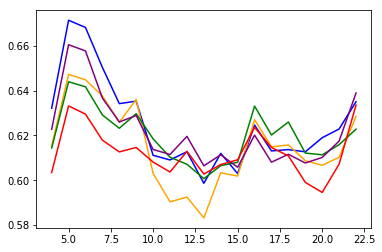

In [129]:
bnc_predict = PlotPerformance(bnc, splits, my_start, lag, clf_choice, f_sets)

In [232]:
display(bnc_predict.groupby(['feature_set', 'months_training']).mean())

accuracy        f1
feature_set months_training                    
0.0         1.0              0.533981  0.522457
            2.0              0.643204  0.639978
            3.0              0.677184  0.677091
            4.0              0.703883  0.689045
            5.0              0.679612  0.679423
            6.0              0.677184  0.627093
            7.0              0.611650  0.605845
            8.0              0.640777  0.624412
            9.0              0.696602  0.683768
            10.0             0.645631  0.530532
            11.0             0.626214  0.597524
            12.0             0.640777  0.639110
            13.0             0.635922  0.627486
            14.0             0.665049  0.583838
            15.0             0.587379  0.561548
            16.0             0.766990  0.725608
            17.0             0.631068  0.581334
            18.0             0.621359  0.586260
            19.0             0.563107  0.557592
            20.0             0.752427  0.750730
            21.0             0.601942  0.596917
            22.0             0.674757  0.634984
1.0         1.0              0.509709  0.507095
            2.0              0.643204  0.639635
            3.0              0.655340  0.655307
            4.0              0.674757  0.659210
            5.0              0.635922  0.634683
            6.0              0.677184  0.630094
            7.0              0.628641  0.626526
            8.0              0.626214  0.612318
...                               ...       ...
3.0         15.0             0.584951  0.569109
            16.0             0.747573  0.711321
            17.0             0.618932  0.573096
            18.0             0.626214  0.592812
            19.0             0.558252  0.553614
            20.0             0.723301  0.721172
            21.0             0.604369  0.602399
            22.0             0.706311  0.678588
4.0         1.0              0.529126  0.525503
            2.0              0.616505  0.613554
            3.0              0.633495  0.632870
            4.0              0.655340  0.641836
            5.0              0.645631  0.644424
            6.0              0.643204  0.598847
            7.0              0.589806  0.586471
            8.0              0.635922  0.620905
            9.0              0.660194  0.652321
            10.0             0.628641  0.572762
            11.0             0.589806  0.568768
            12.0             0.660194  0.657864
            13.0             0.616505  0.611664
            14.0             0.645631  0.589798
            15.0             0.589806  0.577251
            16.0             0.750000  0.715757
            17.0             0.611650  0.575651
            18.0             0.601942  0.574852
            19.0             0.533981  0.529982
            20.0             0.701456  0.697852
            21.0             0.626214  0.626178
            22.0             0.703883  0.680254

[110 rows x 2 columns]

['log_rel_freq'] 1


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


log_rel_freq_0
0      -12.307765
1      -11.634036
2      -11.852290
3       -9.421676
4      -10.176790

0    92
1    90
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.51      0.62      0.56        92
           1       0.51      0.40      0.45        90

   micro avg       0.51      0.51      0.51       182
   macro avg       0.51      0.51      0.50       182
weighted avg       0.51      0.51      0.51       182

['log_rel_freq', 'd_u'] 1


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


log_rel_freq_0     d_u_0
0      -12.307765  0.672877
1      -11.634036  0.844493
2      -11.852290  0.839859
3       -9.421676  0.874120
4      -10.176790  0.807780

0    92
1    90
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.54      0.53      0.54        92
           1       0.53      0.53      0.53        90

   micro avg       0.53      0.53      0.53       182
   macro avg       0.53      0.53      0.53       182
weighted avg       0.53      0.53      0.53       182

['log_rel_freq', 'd_t'] 1


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


log_rel_freq_0     d_t_0
0      -12.307765  0.603361
1      -11.634036  0.981763
2      -11.852290  0.885514
3       -9.421676  0.796897
4      -10.176790  0.827272

0    92
1    90
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.57      0.51      0.54        92
           1       0.55      0.60      0.57        90

   micro avg       0.55      0.55      0.55       182
   macro avg       0.56      0.56      0.55       182
weighted avg       0.56      0.55      0.55       182

['log_rel_freq', 'd_l'] 1


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


log_rel_freq_0     d_l_0
0      -12.307765  0.121459
1      -11.634036  0.043459
2      -11.852290  0.113792
3       -9.421676  0.027959
4      -10.176790  0.064319

0    92
1    90
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.46      0.47      0.46        92
           1       0.45      0.44      0.45        90

   micro avg       0.46      0.46      0.46       182
   macro avg       0.46      0.46      0.46       182
weighted avg       0.46      0.46      0.46       182

['log_rel_freq', 'd_u', 'd_t', 'd_l'] 1


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


log_rel_freq_0     d_u_0     d_t_0     d_l_0
0      -12.307765  0.672877  0.603361  0.121459
1      -11.634036  0.844493  0.981763  0.043459
2      -11.852290  0.839859  0.885514  0.113792
3       -9.421676  0.874120  0.796897  0.027959
4      -10.176790  0.807780  0.827272  0.064319

0    92
1    90
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.52      0.47      0.49        92
           1       0.51      0.57      0.54        90

   micro avg       0.52      0.52      0.52       182
   macro avg       0.52      0.52      0.52       182
weighted avg       0.52      0.52      0.52       182

['log_rel_freq'] 2


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


log_rel_freq_0  log_rel_freq_1
0      -12.307765      -12.310726
1      -11.634036      -11.822373
2      -11.852290      -11.917683
3       -9.421676       -9.492880
4      -10.176790      -10.470764

0    110
1     72
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.66      0.93      0.77       110
           1       0.70      0.26      0.38        72

   micro avg       0.66      0.66      0.66       182
   macro avg       0.68      0.60      0.58       182
weighted avg       0.68      0.66      0.62       182

['log_rel_freq', 'd_u'] 2


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


log_rel_freq_0  log_rel_freq_1     d_u_0     d_u_1
0      -12.307765      -12.310726  0.672877  0.719448
1      -11.634036      -11.822373  0.844493  0.777298
2      -11.852290      -11.917683  0.839859  0.671829
3       -9.421676       -9.492880  0.874120  0.871688
4      -10.176790      -10.470764  0.807780  0.884697

0    110
1     72
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.64      0.88      0.74       110
           1       0.58      0.25      0.35        72

   micro avg       0.63      0.63      0.63       182
   macro avg       0.61      0.57      0.55       182
weighted avg       0.62      0.63      0.59       182

['log_rel_freq', 'd_t'] 2


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


log_rel_freq_0  log_rel_freq_1     d_t_0     d_t_1
0      -12.307765      -12.310726  0.603361  0.580947
1      -11.634036      -11.822373  0.981763  0.914058
2      -11.852290      -11.917683  0.885514  0.760121
3       -9.421676       -9.492880  0.796897  0.860212
4      -10.176790      -10.470764  0.827272  0.875132

0    110
1     72
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.65      0.91      0.76       110
           1       0.66      0.26      0.38        72

   micro avg       0.65      0.65      0.65       182
   macro avg       0.65      0.59      0.57       182
weighted avg       0.65      0.65      0.61       182

['log_rel_freq', 'd_l'] 2


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


log_rel_freq_0  log_rel_freq_1     d_l_0     d_l_1
0      -12.307765      -12.310726  0.121459  0.094845
1      -11.634036      -11.822373  0.043459  0.042332
2      -11.852290      -11.917683  0.113792  0.074065
3       -9.421676       -9.492880  0.027959  0.068133
4      -10.176790      -10.470764  0.064319  0.092369

0    110
1     72
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.65      0.91      0.76       110
           1       0.64      0.25      0.36        72

   micro avg       0.65      0.65      0.65       182
   macro avg       0.65      0.58      0.56       182
weighted avg       0.65      0.65      0.60       182

['log_rel_freq', 'd_u', 'd_t', 'd_l'] 2


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


log_rel_freq_0  log_rel_freq_1     d_u_0     d_u_1     d_t_0     d_t_1  \
0      -12.307765      -12.310726  0.672877  0.719448  0.603361  0.580947   
1      -11.634036      -11.822373  0.844493  0.777298  0.981763  0.914058   
2      -11.852290      -11.917683  0.839859  0.671829  0.885514  0.760121   
3       -9.421676       -9.492880  0.874120  0.871688  0.796897  0.860212   
4      -10.176790      -10.470764  0.807780  0.884697  0.827272  0.875132   

      d_l_0     d_l_1  
0  0.121459  0.094845  
1  0.043459  0.042332  
2  0.113792  0.074065  
3  0.027959  0.068133  
4  0.064319  0.092369

0    110
1     72
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.62      0.84      0.71       110
           1       0.45      0.21      0.29        72

   micro avg       0.59      0.59      0.59       182
   macro avg       0.54      0.52      0.50       182
weighted avg       0.55      0.59      0.54       182

['log_rel_freq'] 3


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2
0      -12.307765      -12.310726      -12.598956
1      -11.634036      -11.822373      -11.433204
2      -11.852290      -11.917683      -11.948368
3       -9.421676       -9.492880       -9.213154
4      -10.176790      -10.470764      -10.365364

0    101
1     81
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.65      0.80      0.72       101
           1       0.65      0.46      0.54        81

   micro avg       0.65      0.65      0.65       182
   macro avg       0.65      0.63      0.63       182
weighted avg       0.65      0.65      0.64       182



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


['log_rel_freq', 'd_u'] 3


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2     d_u_0     d_u_1  \
0      -12.307765      -12.310726      -12.598956  0.672877  0.719448   
1      -11.634036      -11.822373      -11.433204  0.844493  0.777298   
2      -11.852290      -11.917683      -11.948368  0.839859  0.671829   
3       -9.421676       -9.492880       -9.213154  0.874120  0.871688   
4      -10.176790      -10.470764      -10.365364  0.807780  0.884697   

      d_u_2  
0  0.766209  
1  0.863921  
2  0.701024  
3  0.821928  
4  0.880784

0    101
1     81
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.65      0.79      0.71       101
           1       0.64      0.46      0.53        81

   micro avg       0.64      0.64      0.64       182
   macro avg       0.64      0.62      0.62       182
weighted avg       0.64      0.64      0.63       182



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


['log_rel_freq', 'd_t'] 3


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2     d_t_0     d_t_1  \
0      -12.307765      -12.310726      -12.598956  0.603361  0.580947   
1      -11.634036      -11.822373      -11.433204  0.981763  0.914058   
2      -11.852290      -11.917683      -11.948368  0.885514  0.760121   
3       -9.421676       -9.492880       -9.213154  0.796897  0.860212   
4      -10.176790      -10.470764      -10.365364  0.827272  0.875132   

      d_t_2  
0  0.736732  
1  0.830684  
2  0.833438  
3  0.776994  
4  0.860745

0    101
1     81
Name: label, dtype: int64


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


              precision    recall  f1-score   support

           0       0.65      0.77      0.71       101
           1       0.63      0.48      0.55        81

   micro avg       0.64      0.64      0.64       182
   macro avg       0.64      0.63      0.63       182
weighted avg       0.64      0.64      0.63       182

['log_rel_freq', 'd_l'] 3


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2     d_l_0     d_l_1  \
0      -12.307765      -12.310726      -12.598956  0.121459  0.094845   
1      -11.634036      -11.822373      -11.433204  0.043459  0.042332   
2      -11.852290      -11.917683      -11.948368  0.113792  0.074065   
3       -9.421676       -9.492880       -9.213154  0.027959  0.068133   
4      -10.176790      -10.470764      -10.365364  0.064319  0.092369   

      d_l_2  
0  0.090964  
1  0.033882  
2  0.076227  
3  0.036162  
4  0.074918

0    101
1     81
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.67      0.82      0.74       101
           1       0.69      0.49      0.58        81

   micro avg       0.68      0.68      0.68       182
   macro avg       0.68      0.66      0.66       182
weighted avg       0.68      0.68      0.67       182

['log_rel_freq', 'd_u', 'd_t', 'd_l'] 3


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2     d_u_0     d_u_1  \
0      -12.307765      -12.310726      -12.598956  0.672877  0.719448   
1      -11.634036      -11.822373      -11.433204  0.844493  0.777298   
2      -11.852290      -11.917683      -11.948368  0.839859  0.671829   
3       -9.421676       -9.492880       -9.213154  0.874120  0.871688   
4      -10.176790      -10.470764      -10.365364  0.807780  0.884697   

      d_u_2     d_t_0     d_t_1     d_t_2     d_l_0     d_l_1     d_l_2  
0  0.766209  0.603361  0.580947  0.736732  0.121459  0.094845  0.090964  
1  0.863921  0.981763  0.914058  0.830684  0.043459  0.042332  0.033882  
2  0.701024  0.885514  0.760121  0.833438  0.113792  0.074065  0.076227  
3  0.821928  0.796897  0.860212  0.776994  0.027959  0.068133  0.036162  
4  0.880784  0.827272  0.875132  0.860745  0.064319  0.092369  0.074918

0    101
1     81
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.65      0.76      0.70       101
           1       0.62      0.48      0.54        81

   micro avg       0.64      0.64      0.64       182
   macro avg       0.63      0.62      0.62       182
weighted avg       0.63      0.64      0.63       182

['log_rel_freq'] 4


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3
0      -12.307765      -12.310726      -12.598956      -12.771579
1      -11.634036      -11.822373      -11.433204      -11.727034
2      -11.852290      -11.917683      -11.948368      -12.160670
3       -9.421676       -9.492880       -9.213154       -9.325777
4      -10.176790      -10.470764      -10.365364      -10.063529

1    117
0     65
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.68      0.20      0.31        65
           1       0.68      0.95      0.79       117

   micro avg       0.68      0.68      0.68       182
   macro avg       0.68      0.57      0.55       182
weighted avg       0.68      0.68      0.62       182

['log_rel_freq', 'd_u'] 4


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3     d_u_0  \
0      -12.307765      -12.310726      -12.598956      -12.771579  0.672877   
1      -11.634036      -11.822373      -11.433204      -11.727034  0.844493   
2      -11.852290      -11.917683      -11.948368      -12.160670  0.839859   
3       -9.421676       -9.492880       -9.213154       -9.325777  0.874120   
4      -10.176790      -10.470764      -10.365364      -10.063529  0.807780   

      d_u_1     d_u_2     d_u_3  
0  0.719448  0.766209  0.583955  
1  0.777298  0.863921  0.804946  
2  0.671829  0.701024  0.789244  
3  0.871688  0.821928  0.836661  
4  0.884697  0.880784  0.747543

1    117
0     65
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.68      0.23      0.34        65
           1       0.69      0.94      0.79       117

   micro avg       0.69      0.69      0.69       182
   macro avg       0.68      0.59      0.57       182
weighted avg       0.69      0.69      0.63       182

['log_rel_freq', 'd_t'] 4


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3     d_t_0  \
0      -12.307765      -12.310726      -12.598956      -12.771579  0.603361   
1      -11.634036      -11.822373      -11.433204      -11.727034  0.981763   
2      -11.852290      -11.917683      -11.948368      -12.160670  0.885514   
3       -9.421676       -9.492880       -9.213154       -9.325777  0.796897   
4      -10.176790      -10.470764      -10.365364      -10.063529  0.827272   

      d_t_1     d_t_2     d_t_3  
0  0.580947  0.736732  0.671862  
1  0.914058  0.830684  0.910689  
2  0.760121  0.833438  0.729994  
3  0.860212  0.776994  0.792322  
4  0.875132  0.860745  0.717924

1    117
0     65
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.67      0.34      0.45        65
           1       0.71      0.91      0.80       117

   micro avg       0.70      0.70      0.70       182
   macro avg       0.69      0.62      0.62       182
weighted avg       0.70      0.70      0.67       182

['log_rel_freq', 'd_l'] 4


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3     d_l_0  \
0      -12.307765      -12.310726      -12.598956      -12.771579  0.121459   
1      -11.634036      -11.822373      -11.433204      -11.727034  0.043459   
2      -11.852290      -11.917683      -11.948368      -12.160670  0.113792   
3       -9.421676       -9.492880       -9.213154       -9.325777  0.027959   
4      -10.176790      -10.470764      -10.365364      -10.063529  0.064319   

      d_l_1     d_l_2     d_l_3  
0  0.094845  0.090964  0.075086  
1  0.042332  0.033882  0.059743  
2  0.074065  0.076227  0.094962  
3  0.068133  0.036162  0.012897  
4  0.092369  0.074918  0.060159

1    117
0     65
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.75      0.18      0.30        65
           1       0.68      0.97      0.80       117

   micro avg       0.69      0.69      0.69       182
   macro avg       0.72      0.58      0.55       182
weighted avg       0.71      0.69      0.62       182

['log_rel_freq', 'd_u', 'd_t', 'd_l'] 4


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3     d_u_0  \
0      -12.307765      -12.310726      -12.598956      -12.771579  0.672877   
1      -11.634036      -11.822373      -11.433204      -11.727034  0.844493   
2      -11.852290      -11.917683      -11.948368      -12.160670  0.839859   
3       -9.421676       -9.492880       -9.213154       -9.325777  0.874120   
4      -10.176790      -10.470764      -10.365364      -10.063529  0.807780   

      d_u_1     d_u_2     d_u_3     d_t_0     d_t_1     d_t_2     d_t_3  \
0  0.719448  0.766209  0.583955  0.603361  0.580947  0.736732  0.671862   
1  0.777298  0.863921  0.804946  0.981763  0.914058  0.830684  0.910689   
2  0.671829  0.701024  0.789244  0.885514  0.760121  0.833438  0.729994   
3  0.871688  0.821928  0.836661  0.796897  0.860212  0.776994  0.792322   
4  0.884697  0.880784  0.747543  0.827272  0.875132  0.860745  0.717924   

      d_l_0     d_l_1     d_l_2     d_l_3  
0  0.121459  0.094845  0.090964  0.075086  
1  0.043459  0.042332  0.033882  0.059743  
2  0.113792  0.074065  0.076227  0.094962  
3  0.027959  0.068133  0.036162  0.012897  
4  0.064319  0.092369  0.074918  0.060159

1    117
0     65
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.60      0.32      0.42        65
           1       0.70      0.88      0.78       117

   micro avg       0.68      0.68      0.68       182
   macro avg       0.65      0.60      0.60       182
weighted avg       0.66      0.68      0.65       182

['log_rel_freq'] 5


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -12.307765      -12.310726      -12.598956      -12.771579   
1      -11.634036      -11.822373      -11.433204      -11.727034   
2      -11.852290      -11.917683      -11.948368      -12.160670   
3       -9.421676       -9.492880       -9.213154       -9.325777   
4      -10.176790      -10.470764      -10.365364      -10.063529   

   log_rel_freq_4  
0      -12.888217  
1      -11.533672  
2      -12.134445  
3       -9.414699  
4      -10.604560

0    107
1     75
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.70      0.89      0.78       107
           1       0.74      0.45      0.56        75

   micro avg       0.71      0.71      0.71       182
   macro avg       0.72      0.67      0.67       182
weighted avg       0.72      0.71      0.69       182

['log_rel_freq', 'd_u'] 5


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -12.307765      -12.310726      -12.598956      -12.771579   
1      -11.634036      -11.822373      -11.433204      -11.727034   
2      -11.852290      -11.917683      -11.948368      -12.160670   
3       -9.421676       -9.492880       -9.213154       -9.325777   
4      -10.176790      -10.470764      -10.365364      -10.063529   

   log_rel_freq_4     d_u_0     d_u_1     d_u_2     d_u_3     d_u_4  
0      -12.888217  0.672877  0.719448  0.766209  0.583955  0.814700  
1      -11.533672  0.844493  0.777298  0.863921  0.804946  0.818647  
2      -12.134445  0.839859  0.671829  0.701024  0.789244  0.779392  
3       -9.414699  0.874120  0.871688  0.821928  0.836661  0.833985  
4      -10.604560  0.807780  0.884697  0.880784  0.747543  0.863969

0    107
1     75
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.69      0.84      0.76       107
           1       0.67      0.45      0.54        75

   micro avg       0.68      0.68      0.68       182
   macro avg       0.68      0.65      0.65       182
weighted avg       0.68      0.68      0.67       182

['log_rel_freq', 'd_t'] 5


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -12.307765      -12.310726      -12.598956      -12.771579   
1      -11.634036      -11.822373      -11.433204      -11.727034   
2      -11.852290      -11.917683      -11.948368      -12.160670   
3       -9.421676       -9.492880       -9.213154       -9.325777   
4      -10.176790      -10.470764      -10.365364      -10.063529   

   log_rel_freq_4     d_t_0     d_t_1     d_t_2     d_t_3     d_t_4  
0      -12.888217  0.603361  0.580947  0.736732  0.671862  0.981049  
1      -11.533672  0.981763  0.914058  0.830684  0.910689  0.872051  
2      -12.134445  0.885514  0.760121  0.833438  0.729994  0.895200  
3       -9.414699  0.796897  0.860212  0.776994  0.792322  0.791373  
4      -10.604560  0.827272  0.875132  0.860745  0.717924  0.836144

0    107
1     75
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.67      0.88      0.76       107
           1       0.68      0.37      0.48        75

   micro avg       0.67      0.67      0.67       182
   macro avg       0.67      0.63      0.62       182
weighted avg       0.67      0.67      0.64       182

['log_rel_freq', 'd_l'] 5


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -12.307765      -12.310726      -12.598956      -12.771579   
1      -11.634036      -11.822373      -11.433204      -11.727034   
2      -11.852290      -11.917683      -11.948368      -12.160670   
3       -9.421676       -9.492880       -9.213154       -9.325777   
4      -10.176790      -10.470764      -10.365364      -10.063529   

   log_rel_freq_4     d_l_0     d_l_1     d_l_2     d_l_3     d_l_4  
0      -12.888217  0.121459  0.094845  0.090964  0.075086  0.100882  
1      -11.533672  0.043459  0.042332  0.033882  0.059743  0.066243  
2      -12.134445  0.113792  0.074065  0.076227  0.094962  0.046719  
3       -9.414699  0.027959  0.068133  0.036162  0.012897  0.040691  
4      -10.604560  0.064319  0.092369  0.074918  0.060159  0.081472

0    107
1     75
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.69      0.89      0.78       107
           1       0.73      0.43      0.54        75

   micro avg       0.70      0.70      0.70       182
   macro avg       0.71      0.66      0.66       182
weighted avg       0.70      0.70      0.68       182

['log_rel_freq', 'd_u', 'd_t', 'd_l'] 5


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -12.307765      -12.310726      -12.598956      -12.771579   
1      -11.634036      -11.822373      -11.433204      -11.727034   
2      -11.852290      -11.917683      -11.948368      -12.160670   
3       -9.421676       -9.492880       -9.213154       -9.325777   
4      -10.176790      -10.470764      -10.365364      -10.063529   

   log_rel_freq_4     d_u_0     d_u_1     d_u_2     d_u_3     d_u_4     d_t_0  \
0      -12.888217  0.672877  0.719448  0.766209  0.583955  0.814700  0.603361   
1      -11.533672  0.844493  0.777298  0.863921  0.804946  0.818647  0.981763   
2      -12.134445  0.839859  0.671829  0.701024  0.789244  0.779392  0.885514   
3       -9.414699  0.874120  0.871688  0.821928  0.836661  0.833985  0.796897   
4      -10.604560  0.807780  0.884697  0.880784  0.747543  0.863969  0.827272   

      d_t_1     d_t_2     d_t_3     d_t_4     d_l_0     d_l_1     d_l_2  \
0  0.580947  0.736732  0.671862  0.981049  0.121459  0.094845  0.090964   
1  0.914058  0.830684  0.910689  0.872051  0.043459  0.042332  0.033882   
2  0.760121  0.833438  0.729994  0.895200  0.113792  0.074065  0.076227   
3  0.860212  0.776994  0.792322  0.791373  0.027959  0.068133  0.036162   
4  0.875132  0.860745  0.717924  0.836144  0.064319  0.092369  0.074918   

      d_l_3     d_l_4  
0  0.075086  0.100882  
1  0.059743  0.066243  
2  0.094962  0.046719  
3  0.012897  0.040691  
4  0.060159  0.081472

0    107
1     75
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.66      0.81      0.73       107
           1       0.60      0.40      0.48        75

   micro avg       0.64      0.64      0.64       182
   macro avg       0.63      0.61      0.60       182
weighted avg       0.63      0.64      0.63       182

['log_rel_freq'] 6


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -12.307765      -12.310726      -12.598956      -12.771579   
1      -11.634036      -11.822373      -11.433204      -11.727034   
2      -11.852290      -11.917683      -11.948368      -12.160670   
3       -9.421676       -9.492880       -9.213154       -9.325777   
4      -10.176790      -10.470764      -10.365364      -10.063529   

   log_rel_freq_4  log_rel_freq_5  
0      -12.888217      -13.973648  
1      -11.533672      -11.704965  
2      -12.134445      -11.516912  
3       -9.414699       -9.392088  
4      -10.604560      -10.432689

0    115
1     67
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.68      0.93      0.79       115
           1       0.68      0.25      0.37        67

   micro avg       0.68      0.68      0.68       182
   macro avg       0.68      0.59      0.58       182
weighted avg       0.68      0.68      0.63       182

['log_rel_freq', 'd_u'] 6


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -12.307765      -12.310726      -12.598956      -12.771579   
1      -11.634036      -11.822373      -11.433204      -11.727034   
2      -11.852290      -11.917683      -11.948368      -12.160670   
3       -9.421676       -9.492880       -9.213154       -9.325777   
4      -10.176790      -10.470764      -10.365364      -10.063529   

   log_rel_freq_4  log_rel_freq_5     d_u_0     d_u_1     d_u_2     d_u_3  \
0      -12.888217      -13.973648  0.672877  0.719448  0.766209  0.583955   
1      -11.533672      -11.704965  0.844493  0.777298  0.863921  0.804946   
2      -12.134445      -11.516912  0.839859  0.671829  0.701024  0.789244   
3       -9.414699       -9.392088  0.874120  0.871688  0.821928  0.836661   
4      -10.604560      -10.432689  0.807780  0.884697  0.880784  0.747543   

      d_u_4     d_u_5  
0  0.814700  0.993498  
1  0.818647  0.792170  
2  0.779392  0.645231  
3  0.833985  0.828128  
4  0.863969  0.772276

0    115
1     67
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.69      0.85      0.76       115
           1       0.57      0.34      0.43        67

   micro avg       0.66      0.66      0.66       182
   macro avg       0.63      0.60      0.60       182
weighted avg       0.65      0.66      0.64       182

['log_rel_freq', 'd_t'] 6


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -12.307765      -12.310726      -12.598956      -12.771579   
1      -11.634036      -11.822373      -11.433204      -11.727034   
2      -11.852290      -11.917683      -11.948368      -12.160670   
3       -9.421676       -9.492880       -9.213154       -9.325777   
4      -10.176790      -10.470764      -10.365364      -10.063529   

   log_rel_freq_4  log_rel_freq_5     d_t_0     d_t_1     d_t_2     d_t_3  \
0      -12.888217      -13.973648  0.603361  0.580947  0.736732  0.671862   
1      -11.533672      -11.704965  0.981763  0.914058  0.830684  0.910689   
2      -12.134445      -11.516912  0.885514  0.760121  0.833438  0.729994   
3       -9.414699       -9.392088  0.796897  0.860212  0.776994  0.792322   
4      -10.604560      -10.432689  0.827272  0.875132  0.860745  0.717924   

      d_t_4     d_t_5  
0  0.981049  0.981972  
1  0.872051  0.899018  
2  0.895200  0.688977  
3  0.791373  0.814542  
4  0.836144  0.769161

0    115
1     67
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.72      0.90      0.80       115
           1       0.71      0.40      0.51        67

   micro avg       0.72      0.72      0.72       182
   macro avg       0.72      0.65      0.66       182
weighted avg       0.72      0.72      0.70       182

['log_rel_freq', 'd_l'] 6


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -12.307765      -12.310726      -12.598956      -12.771579   
1      -11.634036      -11.822373      -11.433204      -11.727034   
2      -11.852290      -11.917683      -11.948368      -12.160670   
3       -9.421676       -9.492880       -9.213154       -9.325777   
4      -10.176790      -10.470764      -10.365364      -10.063529   

   log_rel_freq_4  log_rel_freq_5     d_l_0     d_l_1     d_l_2     d_l_3  \
0      -12.888217      -13.973648  0.121459  0.094845  0.090964  0.075086   
1      -11.533672      -11.704965  0.043459  0.042332  0.033882  0.059743   
2      -12.134445      -11.516912  0.113792  0.074065  0.076227  0.094962   
3       -9.414699       -9.392088  0.027959  0.068133  0.036162  0.012897   
4      -10.604560      -10.432689  0.064319  0.092369  0.074918  0.060159   

      d_l_4     d_l_5  
0  0.100882  0.065585  
1  0.066243  0.026992  
2  0.046719  0.040018  
3  0.040691  0.038855  
4  0.081472  0.070871

0    115
1     67
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.68      0.88      0.77       115
           1       0.58      0.28      0.38        67

   micro avg       0.66      0.66      0.66       182
   macro avg       0.63      0.58      0.57       182
weighted avg       0.64      0.66      0.62       182

['log_rel_freq', 'd_u', 'd_t', 'd_l'] 6


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -12.307765      -12.310726      -12.598956      -12.771579   
1      -11.634036      -11.822373      -11.433204      -11.727034   
2      -11.852290      -11.917683      -11.948368      -12.160670   
3       -9.421676       -9.492880       -9.213154       -9.325777   
4      -10.176790      -10.470764      -10.365364      -10.063529   

   log_rel_freq_4  log_rel_freq_5     d_u_0     d_u_1     d_u_2     d_u_3  \
0      -12.888217      -13.973648  0.672877  0.719448  0.766209  0.583955   
1      -11.533672      -11.704965  0.844493  0.777298  0.863921  0.804946   
2      -12.134445      -11.516912  0.839859  0.671829  0.701024  0.789244   
3       -9.414699       -9.392088  0.874120  0.871688  0.821928  0.836661   
4      -10.604560      -10.432689  0.807780  0.884697  0.880784  0.747543   

   ...     d_t_2     d_t_3     d_t_4     d_t_5     d_l_0     d_l_1     d_l_2  \
0  ...  0.736732  0.671862  0.981049  0.981972  0.121459  0.094845  0.090964   
1  ...  0.830684  0.910689  0.872051  0.899018  0.043459  0.042332  0.033882   
2  ...  0.833438  0.729994  0.895200  0.688977  0.113792  0.074065  0.076227   
3  ...  0.776994  0.792322  0.791373  0.814542  0.027959  0.068133  0.036162   
4  ...  0.860745  0.717924  0.836144  0.769161  0.064319  0.092369  0.074918   

      d_l_3     d_l_4     d_l_5  
0  0.075086  0.100882  0.065585  
1  0.059743  0.066243  0.026992  
2  0.094962  0.046719  0.040018  
3  0.012897  0.040691  0.038855  
4  0.060159  0.081472  0.070871  

[5 rows x 24 columns]

0    115
1     67
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.70      0.83      0.76       115
           1       0.57      0.40      0.47        67

   micro avg       0.67      0.67      0.67       182
   macro avg       0.64      0.61      0.62       182
weighted avg       0.66      0.67      0.65       182

['log_rel_freq'] 7


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -12.307765      -12.310726      -12.598956      -12.771579   
1      -11.634036      -11.822373      -11.433204      -11.727034   
2      -11.852290      -11.917683      -11.948368      -12.160670   
3       -9.421676       -9.492880       -9.213154       -9.325777   
4      -10.176790      -10.470764      -10.365364      -10.063529   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  
0      -12.888217      -13.973648      -12.936405  
1      -11.533672      -11.704965      -11.423817  
2      -12.134445      -11.516912      -12.020114  
3       -9.414699       -9.392088       -9.252345  
4      -10.604560      -10.432689      -10.114568

1    100
0     82
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.69      0.38      0.49        82
           1       0.63      0.86      0.73       100

   micro avg       0.64      0.64      0.64       182
   macro avg       0.66      0.62      0.61       182
weighted avg       0.66      0.64      0.62       182

['log_rel_freq', 'd_u'] 7


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -12.307765      -12.310726      -12.598956      -12.771579   
1      -11.634036      -11.822373      -11.433204      -11.727034   
2      -11.852290      -11.917683      -11.948368      -12.160670   
3       -9.421676       -9.492880       -9.213154       -9.325777   
4      -10.176790      -10.470764      -10.365364      -10.063529   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6     d_u_0     d_u_1  \
0      -12.888217      -13.973648      -12.936405  0.672877  0.719448   
1      -11.533672      -11.704965      -11.423817  0.844493  0.777298   
2      -12.134445      -11.516912      -12.020114  0.839859  0.671829   
3       -9.414699       -9.392088       -9.252345  0.874120  0.871688   
4      -10.604560      -10.432689      -10.114568  0.807780  0.884697   

      d_u_2     d_u_3     d_u_4     d_u_5     d_u_6  
0  0.766209  0.583955  0.814700  0.993498  0.657770  
1  0.863921  0.804946  0.818647  0.792170  0.883442  
2  0.701024  0.789244  0.779392  0.645231  0.725738  
3  0.821928  0.836661  0.833985  0.828128  0.855825  
4  0.880784  0.747543  0.863969  0.772276  0.878684

1    100
0     82
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.59      0.43      0.50        82
           1       0.62      0.76      0.68       100

   micro avg       0.61      0.61      0.61       182
   macro avg       0.61      0.59      0.59       182
weighted avg       0.61      0.61      0.60       182

['log_rel_freq', 'd_t'] 7


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -12.307765      -12.310726      -12.598956      -12.771579   
1      -11.634036      -11.822373      -11.433204      -11.727034   
2      -11.852290      -11.917683      -11.948368      -12.160670   
3       -9.421676       -9.492880       -9.213154       -9.325777   
4      -10.176790      -10.470764      -10.365364      -10.063529   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6     d_t_0     d_t_1  \
0      -12.888217      -13.973648      -12.936405  0.603361  0.580947   
1      -11.533672      -11.704965      -11.423817  0.981763  0.914058   
2      -12.134445      -11.516912      -12.020114  0.885514  0.760121   
3       -9.414699       -9.392088       -9.252345  0.796897  0.860212   
4      -10.604560      -10.432689      -10.114568  0.827272  0.875132   

      d_t_2     d_t_3     d_t_4     d_t_5     d_t_6  
0  0.736732  0.671862  0.981049  0.981972  0.682257  
1  0.830684  0.910689  0.872051  0.899018  0.912993  
2  0.833438  0.729994  0.895200  0.688977  0.759018  
3  0.776994  0.792322  0.791373  0.814542  0.795617  
4  0.860745  0.717924  0.836144  0.769161  0.865276

1    100
0     82
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.63      0.45      0.52        82
           1       0.63      0.78      0.70       100

   micro avg       0.63      0.63      0.63       182
   macro avg       0.63      0.62      0.61       182
weighted avg       0.63      0.63      0.62       182

['log_rel_freq', 'd_l'] 7


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -12.307765      -12.310726      -12.598956      -12.771579   
1      -11.634036      -11.822373      -11.433204      -11.727034   
2      -11.852290      -11.917683      -11.948368      -12.160670   
3       -9.421676       -9.492880       -9.213154       -9.325777   
4      -10.176790      -10.470764      -10.365364      -10.063529   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6     d_l_0     d_l_1  \
0      -12.888217      -13.973648      -12.936405  0.121459  0.094845   
1      -11.533672      -11.704965      -11.423817  0.043459  0.042332   
2      -12.134445      -11.516912      -12.020114  0.113792  0.074065   
3       -9.414699       -9.392088       -9.252345  0.027959  0.068133   
4      -10.604560      -10.432689      -10.114568  0.064319  0.092369   

      d_l_2     d_l_3     d_l_4     d_l_5     d_l_6  
0  0.090964  0.075086  0.100882  0.065585  0.102007  
1  0.033882  0.059743  0.066243  0.026992  0.015819  
2  0.076227  0.094962  0.046719  0.040018  0.106289  
3  0.036162  0.012897  0.040691  0.038855  0.009982  
4  0.074918  0.060159  0.081472  0.070871  0.106351

1    100
0     82
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.56      0.43      0.49        82
           1       0.61      0.73      0.66       100

   micro avg       0.59      0.59      0.59       182
   macro avg       0.59      0.58      0.57       182
weighted avg       0.59      0.59      0.58       182

['log_rel_freq', 'd_u', 'd_t', 'd_l'] 7


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -12.307765      -12.310726      -12.598956      -12.771579   
1      -11.634036      -11.822373      -11.433204      -11.727034   
2      -11.852290      -11.917683      -11.948368      -12.160670   
3       -9.421676       -9.492880       -9.213154       -9.325777   
4      -10.176790      -10.470764      -10.365364      -10.063529   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6     d_u_0     d_u_1  \
0      -12.888217      -13.973648      -12.936405  0.672877  0.719448   
1      -11.533672      -11.704965      -11.423817  0.844493  0.777298   
2      -12.134445      -11.516912      -12.020114  0.839859  0.671829   
3       -9.414699       -9.392088       -9.252345  0.874120  0.871688   
4      -10.604560      -10.432689      -10.114568  0.807780  0.884697   

      d_u_2  ...     d_t_4     d_t_5     d_t_6     d_l_0     d_l_1     d_l_2  \
0  0.766209  ...  0.981049  0.981972  0.682257  0.121459  0.094845  0.090964   
1  0.863921  ...  0.872051  0.899018  0.912993  0.043459  0.042332  0.033882   
2  0.701024  ...  0.895200  0.688977  0.759018  0.113792  0.074065  0.076227   
3  0.821928  ...  0.791373  0.814542  0.795617  0.027959  0.068133  0.036162   
4  0.880784  ...  0.836144  0.769161  0.865276  0.064319  0.092369  0.074918   

      d_l_3     d_l_4     d_l_5     d_l_6  
0  0.075086  0.100882  0.065585  0.102007  
1  0.059743  0.066243  0.026992  0.015819  
2  0.094962  0.046719  0.040018  0.106289  
3  0.012897  0.040691  0.038855  0.009982  
4  0.060159  0.081472  0.070871  0.106351  

[5 rows x 28 columns]

1    100
0     82
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.61      0.50      0.55        82
           1       0.64      0.74      0.69       100

   micro avg       0.63      0.63      0.63       182
   macro avg       0.63      0.62      0.62       182
weighted avg       0.63      0.63      0.63       182

['log_rel_freq'] 8


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -12.307765      -12.310726      -12.598956      -12.771579   
1      -11.634036      -11.822373      -11.433204      -11.727034   
2      -11.852290      -11.917683      -11.948368      -12.160670   
3       -9.421676       -9.492880       -9.213154       -9.325777   
4      -10.176790      -10.470764      -10.365364      -10.063529   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  log_rel_freq_7  
0      -12.888217      -13.973648      -12.936405      -13.057325  
1      -11.533672      -11.704965      -11.423817      -11.185522  
2      -12.134445      -11.516912      -12.020114      -12.339485  
3       -9.414699       -9.392088       -9.252345       -9.189253  
4      -10.604560      -10.432689      -10.114568      -10.230011

0    96
1    86
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.71      0.78      0.74        96
           1       0.72      0.64      0.68        86

   micro avg       0.71      0.71      0.71       182
   macro avg       0.72      0.71      0.71       182
weighted avg       0.72      0.71      0.71       182

['log_rel_freq', 'd_u'] 8


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -12.307765      -12.310726      -12.598956      -12.771579   
1      -11.634036      -11.822373      -11.433204      -11.727034   
2      -11.852290      -11.917683      -11.948368      -12.160670   
3       -9.421676       -9.492880       -9.213154       -9.325777   
4      -10.176790      -10.470764      -10.365364      -10.063529   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  log_rel_freq_7     d_u_0  \
0      -12.888217      -13.973648      -12.936405      -13.057325  0.672877   
1      -11.533672      -11.704965      -11.423817      -11.185522  0.844493   
2      -12.134445      -11.516912      -12.020114      -12.339485  0.839859   
3       -9.414699       -9.392088       -9.252345       -9.189253  0.874120   
4      -10.604560      -10.432689      -10.114568      -10.230011  0.807780   

      d_u_1     d_u_2     d_u_3     d_u_4     d_u_5     d_u_6     d_u_7  
0  0.719448  0.766209  0.583955  0.814700  0.993498  0.657770  0.695766  
1  0.777298  0.863921  0.804946  0.818647  0.792170  0.883442  0.809620  
2  0.671829  0.701024  0.789244  0.779392  0.645231  0.725738  0.709450  
3  0.871688  0.821928  0.836661  0.833985  0.828128  0.855825  0.845310  
4  0.884697  0.880784  0.747543  0.863969  0.772276  0.878684  0.822329

0    96
1    86
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.68      0.72      0.70        96
           1       0.67      0.63      0.65        86

   micro avg       0.68      0.68      0.68       182
   macro avg       0.67      0.67      0.67       182
weighted avg       0.68      0.68      0.68       182

['log_rel_freq', 'd_t'] 8


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -12.307765      -12.310726      -12.598956      -12.771579   
1      -11.634036      -11.822373      -11.433204      -11.727034   
2      -11.852290      -11.917683      -11.948368      -12.160670   
3       -9.421676       -9.492880       -9.213154       -9.325777   
4      -10.176790      -10.470764      -10.365364      -10.063529   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  log_rel_freq_7     d_t_0  \
0      -12.888217      -13.973648      -12.936405      -13.057325  0.603361   
1      -11.533672      -11.704965      -11.423817      -11.185522  0.981763   
2      -12.134445      -11.516912      -12.020114      -12.339485  0.885514   
3       -9.414699       -9.392088       -9.252345       -9.189253  0.796897   
4      -10.604560      -10.432689      -10.114568      -10.230011  0.827272   

      d_t_1     d_t_2     d_t_3     d_t_4     d_t_5     d_t_6     d_t_7  
0  0.580947  0.736732  0.671862  0.981049  0.981972  0.682257  0.787691  
1  0.914058  0.830684  0.910689  0.872051  0.899018  0.912993  0.851467  
2  0.760121  0.833438  0.729994  0.895200  0.688977  0.759018  0.889202  
3  0.860212  0.776994  0.792322  0.791373  0.814542  0.795617  0.761440  
4  0.875132  0.860745  0.717924  0.836144  0.769161  0.865276  0.809450

0    96
1    86
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.66      0.71      0.68        96
           1       0.65      0.59      0.62        86

   micro avg       0.65      0.65      0.65       182
   macro avg       0.65      0.65      0.65       182
weighted avg       0.65      0.65      0.65       182

['log_rel_freq', 'd_l'] 8


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -12.307765      -12.310726      -12.598956      -12.771579   
1      -11.634036      -11.822373      -11.433204      -11.727034   
2      -11.852290      -11.917683      -11.948368      -12.160670   
3       -9.421676       -9.492880       -9.213154       -9.325777   
4      -10.176790      -10.470764      -10.365364      -10.063529   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  log_rel_freq_7     d_l_0  \
0      -12.888217      -13.973648      -12.936405      -13.057325  0.121459   
1      -11.533672      -11.704965      -11.423817      -11.185522  0.043459   
2      -12.134445      -11.516912      -12.020114      -12.339485  0.113792   
3       -9.414699       -9.392088       -9.252345       -9.189253  0.027959   
4      -10.604560      -10.432689      -10.114568      -10.230011  0.064319   

      d_l_1     d_l_2     d_l_3     d_l_4     d_l_5     d_l_6     d_l_7  
0  0.094845  0.090964  0.075086  0.100882  0.065585  0.102007  0.029757  
1  0.042332  0.033882  0.059743  0.066243  0.026992  0.015819  0.032330  
2  0.074065  0.076227  0.094962  0.046719  0.040018  0.106289  0.086387  
3  0.068133  0.036162  0.012897  0.040691  0.038855  0.009982  0.016134  
4  0.092369  0.074918  0.060159  0.081472  0.070871  0.106351  0.094075

0    96
1    86
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.68      0.70      0.69        96
           1       0.65      0.64      0.65        86

   micro avg       0.67      0.67      0.67       182
   macro avg       0.67      0.67      0.67       182
weighted avg       0.67      0.67      0.67       182

['log_rel_freq', 'd_u', 'd_t', 'd_l'] 8


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -12.307765      -12.310726      -12.598956      -12.771579   
1      -11.634036      -11.822373      -11.433204      -11.727034   
2      -11.852290      -11.917683      -11.948368      -12.160670   
3       -9.421676       -9.492880       -9.213154       -9.325777   
4      -10.176790      -10.470764      -10.365364      -10.063529   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  log_rel_freq_7     d_u_0  \
0      -12.888217      -13.973648      -12.936405      -13.057325  0.672877   
1      -11.533672      -11.704965      -11.423817      -11.185522  0.844493   
2      -12.134445      -11.516912      -12.020114      -12.339485  0.839859   
3       -9.414699       -9.392088       -9.252345       -9.189253  0.874120   
4      -10.604560      -10.432689      -10.114568      -10.230011  0.807780   

      d_u_1  ...     d_t_6     d_t_7     d_l_0     d_l_1     d_l_2     d_l_3  \
0  0.719448  ...  0.682257  0.787691  0.121459  0.094845  0.090964  0.075086   
1  0.777298  ...  0.912993  0.851467  0.043459  0.042332  0.033882  0.059743   
2  0.671829  ...  0.759018  0.889202  0.113792  0.074065  0.076227  0.094962   
3  0.871688  ...  0.795617  0.761440  0.027959  0.068133  0.036162  0.012897   
4  0.884697  ...  0.865276  0.809450  0.064319  0.092369  0.074918  0.060159   

      d_l_4     d_l_5     d_l_6     d_l_7  
0  0.100882  0.065585  0.102007  0.029757  
1  0.066243  0.026992  0.015819  0.032330  
2  0.046719  0.040018  0.106289  0.086387  
3  0.040691  0.038855  0.009982  0.016134  
4  0.081472  0.070871  0.106351  0.094075  

[5 rows x 32 columns]

0    96
1    86
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.67      0.67      0.67        96
           1       0.63      0.64      0.64        86

   micro avg       0.65      0.65      0.65       182
   macro avg       0.65      0.65      0.65       182
weighted avg       0.65      0.65      0.65       182

['log_rel_freq'] 9


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -12.307765      -12.310726      -12.598956      -12.771579   
1      -11.634036      -11.822373      -11.433204      -11.727034   
2      -11.852290      -11.917683      -11.948368      -12.160670   
3       -9.421676       -9.492880       -9.213154       -9.325777   
4      -10.176790      -10.470764      -10.365364      -10.063529   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  log_rel_freq_7  \
0      -12.888217      -13.973648      -12.936405      -13.057325   
1      -11.533672      -11.704965      -11.423817      -11.185522   
2      -12.134445      -11.516912      -12.020114      -12.339485   
3       -9.414699       -9.392088       -9.252345       -9.189253   
4      -10.604560      -10.432689      -10.114568      -10.230011   

   log_rel_freq_8  
0      -12.843260  
1      -11.465334  
2      -12.394310  
3       -9.487525  
4      -10.341824

0    105
1     77
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.67      0.88      0.76       105
           1       0.70      0.40      0.51        77

   micro avg       0.68      0.68      0.68       182
   macro avg       0.69      0.64      0.63       182
weighted avg       0.68      0.68      0.65       182

['log_rel_freq', 'd_u'] 9


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -12.307765      -12.310726      -12.598956      -12.771579   
1      -11.634036      -11.822373      -11.433204      -11.727034   
2      -11.852290      -11.917683      -11.948368      -12.160670   
3       -9.421676       -9.492880       -9.213154       -9.325777   
4      -10.176790      -10.470764      -10.365364      -10.063529   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  log_rel_freq_7  \
0      -12.888217      -13.973648      -12.936405      -13.057325   
1      -11.533672      -11.704965      -11.423817      -11.185522   
2      -12.134445      -11.516912      -12.020114      -12.339485   
3       -9.414699       -9.392088       -9.252345       -9.189253   
4      -10.604560      -10.432689      -10.114568      -10.230011   

   log_rel_freq_8     d_u_0     d_u_1     d_u_2     d_u_3     d_u_4     d_u_5  \
0      -12.843260  0.672877  0.719448  0.766209  0.583955  0.814700  0.993498   
1      -11.465334  0.844493  0.777298  0.863921  0.804946  0.818647  0.792170   
2      -12.394310  0.839859  0.671829  0.701024  0.789244  0.779392  0.645231   
3       -9.487525  0.874120  0.871688  0.821928  0.836661  0.833985  0.828128   
4      -10.341824  0.807780  0.884697  0.880784  0.747543  0.863969  0.772276   

      d_u_6     d_u_7     d_u_8  
0  0.657770  0.695766  0.765638  
1  0.883442  0.809620  0.805704  
2  0.725738  0.709450  0.813021  
3  0.855825  0.845310  0.838032  
4  0.878684  0.822329  0.755115

0    105
1     77
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.63      0.83      0.71       105
           1       0.58      0.32      0.42        77

   micro avg       0.62      0.62      0.62       182
   macro avg       0.60      0.58      0.56       182
weighted avg       0.61      0.62      0.59       182



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


['log_rel_freq', 'd_t'] 9


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -12.307765      -12.310726      -12.598956      -12.771579   
1      -11.634036      -11.822373      -11.433204      -11.727034   
2      -11.852290      -11.917683      -11.948368      -12.160670   
3       -9.421676       -9.492880       -9.213154       -9.325777   
4      -10.176790      -10.470764      -10.365364      -10.063529   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  log_rel_freq_7  \
0      -12.888217      -13.973648      -12.936405      -13.057325   
1      -11.533672      -11.704965      -11.423817      -11.185522   
2      -12.134445      -11.516912      -12.020114      -12.339485   
3       -9.414699       -9.392088       -9.252345       -9.189253   
4      -10.604560      -10.432689      -10.114568      -10.230011   

   log_rel_freq_8     d_t_0     d_t_1     d_t_2     d_t_3     d_t_4     d_t_5  \
0      -12.843260  0.603361  0.580947  0.736732  0.671862  0.981049  0.981972   
1      -11.465334  0.981763  0.914058  0.830684  0.910689  0.872051  0.899018   
2      -12.394310  0.885514  0.760121  0.833438  0.729994  0.895200  0.688977   
3       -9.487525  0.796897  0.860212  0.776994  0.792322  0.791373  0.814542   
4      -10.341824  0.827272  0.875132  0.860745  0.717924  0.836144  0.769161   

      d_t_6     d_t_7     d_t_8  
0  0.682257  0.787691  0.854705  
1  0.912993  0.851467  0.872473  
2  0.759018  0.889202  0.671796  
3  0.795617  0.761440  0.806630  
4  0.865276  0.809450  0.731813

0    105
1     77
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.64      0.77      0.70       105
           1       0.57      0.42      0.48        77

   micro avg       0.62      0.62      0.62       182
   macro avg       0.61      0.59      0.59       182
weighted avg       0.61      0.62      0.61       182



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


['log_rel_freq', 'd_l'] 9


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -12.307765      -12.310726      -12.598956      -12.771579   
1      -11.634036      -11.822373      -11.433204      -11.727034   
2      -11.852290      -11.917683      -11.948368      -12.160670   
3       -9.421676       -9.492880       -9.213154       -9.325777   
4      -10.176790      -10.470764      -10.365364      -10.063529   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  log_rel_freq_7  \
0      -12.888217      -13.973648      -12.936405      -13.057325   
1      -11.533672      -11.704965      -11.423817      -11.185522   
2      -12.134445      -11.516912      -12.020114      -12.339485   
3       -9.414699       -9.392088       -9.252345       -9.189253   
4      -10.604560      -10.432689      -10.114568      -10.230011   

   log_rel_freq_8     d_l_0     d_l_1     d_l_2     d_l_3     d_l_4     d_l_5  \
0      -12.843260  0.121459  0.094845  0.090964  0.075086  0.100882  0.065585   
1      -11.465334  0.043459  0.042332  0.033882  0.059743  0.066243  0.026992   
2      -12.394310  0.113792  0.074065  0.076227  0.094962  0.046719  0.040018   
3       -9.487525  0.027959  0.068133  0.036162  0.012897  0.040691  0.038855   
4      -10.341824  0.064319  0.092369  0.074918  0.060159  0.081472  0.070871   

      d_l_6     d_l_7     d_l_8  
0  0.102007  0.029757  0.102427  
1  0.015819  0.032330  0.043872  
2  0.106289  0.086387  0.095896  
3  0.009982  0.016134  0.020061  
4  0.106351  0.094075  0.117692

0    105
1     77
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.65      0.81      0.72       105
           1       0.61      0.40      0.48        77

   micro avg       0.64      0.64      0.64       182
   macro avg       0.63      0.61      0.60       182
weighted avg       0.63      0.64      0.62       182

['log_rel_freq', 'd_u', 'd_t', 'd_l'] 9


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -12.307765      -12.310726      -12.598956      -12.771579   
1      -11.634036      -11.822373      -11.433204      -11.727034   
2      -11.852290      -11.917683      -11.948368      -12.160670   
3       -9.421676       -9.492880       -9.213154       -9.325777   
4      -10.176790      -10.470764      -10.365364      -10.063529   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  log_rel_freq_7  \
0      -12.888217      -13.973648      -12.936405      -13.057325   
1      -11.533672      -11.704965      -11.423817      -11.185522   
2      -12.134445      -11.516912      -12.020114      -12.339485   
3       -9.414699       -9.392088       -9.252345       -9.189253   
4      -10.604560      -10.432689      -10.114568      -10.230011   

   log_rel_freq_8     d_u_0  ...     d_t_8     d_l_0     d_l_1     d_l_2  \
0      -12.843260  0.672877  ...  0.854705  0.121459  0.094845  0.090964   
1      -11.465334  0.844493  ...  0.872473  0.043459  0.042332  0.033882   
2      -12.394310  0.839859  ...  0.671796  0.113792  0.074065  0.076227   
3       -9.487525  0.874120  ...  0.806630  0.027959  0.068133  0.036162   
4      -10.341824  0.807780  ...  0.731813  0.064319  0.092369  0.074918   

      d_l_3     d_l_4     d_l_5     d_l_6     d_l_7     d_l_8  
0  0.075086  0.100882  0.065585  0.102007  0.029757  0.102427  
1  0.059743  0.066243  0.026992  0.015819  0.032330  0.043872  
2  0.094962  0.046719  0.040018  0.106289  0.086387  0.095896  
3  0.012897  0.040691  0.038855  0.009982  0.016134  0.020061  
4  0.060159  0.081472  0.070871  0.106351  0.094075  0.117692  

[5 rows x 36 columns]

0    105
1     77
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.61      0.71      0.66       105
           1       0.50      0.39      0.44        77

   micro avg       0.58      0.58      0.58       182
   macro avg       0.56      0.55      0.55       182
weighted avg       0.57      0.58      0.57       182

['log_rel_freq'] 10


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -12.307765      -12.310726      -12.598956      -12.771579   
1      -11.634036      -11.822373      -11.433204      -11.727034   
2      -11.852290      -11.917683      -11.948368      -12.160670   
3       -9.421676       -9.492880       -9.213154       -9.325777   
4      -10.176790      -10.470764      -10.365364      -10.063529   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  log_rel_freq_7  \
0      -12.888217      -13.973648      -12.936405      -13.057325   
1      -11.533672      -11.704965      -11.423817      -11.185522   
2      -12.134445      -11.516912      -12.020114      -12.339485   
3       -9.414699       -9.392088       -9.252345       -9.189253   
4      -10.604560      -10.432689      -10.114568      -10.230011   

   log_rel_freq_8  log_rel_freq_9  
0      -12.843260      -13.129379  
1      -11.465334      -11.536748  
2      -12.394310      -12.282081  
3       -9.487525       -9.178135  
4      -10.341824       -9.893974

0    106
1     76
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.62      0.91      0.73       106
           1       0.62      0.21      0.31        76

   micro avg       0.62      0.62      0.62       182
   macro avg       0.62      0.56      0.52       182
weighted avg       0.62      0.62      0.56       182

['log_rel_freq', 'd_u'] 10


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -12.307765      -12.310726      -12.598956      -12.771579   
1      -11.634036      -11.822373      -11.433204      -11.727034   
2      -11.852290      -11.917683      -11.948368      -12.160670   
3       -9.421676       -9.492880       -9.213154       -9.325777   
4      -10.176790      -10.470764      -10.365364      -10.063529   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  log_rel_freq_7  \
0      -12.888217      -13.973648      -12.936405      -13.057325   
1      -11.533672      -11.704965      -11.423817      -11.185522   
2      -12.134445      -11.516912      -12.020114      -12.339485   
3       -9.414699       -9.392088       -9.252345       -9.189253   
4      -10.604560      -10.432689      -10.114568      -10.230011   

   log_rel_freq_8  log_rel_freq_9     d_u_0     d_u_1     d_u_2     d_u_3  \
0      -12.843260      -13.129379  0.672877  0.719448  0.766209  0.583955   
1      -11.465334      -11.536748  0.844493  0.777298  0.863921  0.804946   
2      -12.394310      -12.282081  0.839859  0.671829  0.701024  0.789244   
3       -9.487525       -9.178135  0.874120  0.871688  0.821928  0.836661   
4      -10.341824       -9.893974  0.807780  0.884697  0.880784  0.747543   

      d_u_4     d_u_5     d_u_6     d_u_7     d_u_8     d_u_9  
0  0.814700  0.993498  0.657770  0.695766  0.765638  0.789148  
1  0.818647  0.792170  0.883442  0.809620  0.805704  0.830801  
2  0.779392  0.645231  0.725738  0.709450  0.813021  0.865738  
3  0.833985  0.828128  0.855825  0.845310  0.838032  0.848049  
4  0.863969  0.772276  0.878684  0.822329  0.755115  0.818578

0    106
1     76
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.58      0.75      0.65       106
           1       0.40      0.24      0.30        76

   micro avg       0.53      0.53      0.53       182
   macro avg       0.49      0.49      0.47       182
weighted avg       0.50      0.53      0.50       182

['log_rel_freq', 'd_t'] 10


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -12.307765      -12.310726      -12.598956      -12.771579   
1      -11.634036      -11.822373      -11.433204      -11.727034   
2      -11.852290      -11.917683      -11.948368      -12.160670   
3       -9.421676       -9.492880       -9.213154       -9.325777   
4      -10.176790      -10.470764      -10.365364      -10.063529   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  log_rel_freq_7  \
0      -12.888217      -13.973648      -12.936405      -13.057325   
1      -11.533672      -11.704965      -11.423817      -11.185522   
2      -12.134445      -11.516912      -12.020114      -12.339485   
3       -9.414699       -9.392088       -9.252345       -9.189253   
4      -10.604560      -10.432689      -10.114568      -10.230011   

   log_rel_freq_8  log_rel_freq_9     d_t_0     d_t_1     d_t_2     d_t_3  \
0      -12.843260      -13.129379  0.603361  0.580947  0.736732  0.671862   
1      -11.465334      -11.536748  0.981763  0.914058  0.830684  0.910689   
2      -12.394310      -12.282081  0.885514  0.760121  0.833438  0.729994   
3       -9.487525       -9.178135  0.796897  0.860212  0.776994  0.792322   
4      -10.341824       -9.893974  0.827272  0.875132  0.860745  0.717924   

      d_t_4     d_t_5     d_t_6     d_t_7     d_t_8     d_t_9  
0  0.981049  0.981972  0.682257  0.787691  0.854705  0.780969  
1  0.872051  0.899018  0.912993  0.851467  0.872473  0.880106  
2  0.895200  0.688977  0.759018  0.889202  0.671796  0.828690  
3  0.791373  0.814542  0.795617  0.761440  0.806630  0.789445  
4  0.836144  0.769161  0.865276  0.809450  0.731813  0.799577

0    106
1     76
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.62      0.80      0.70       106
           1       0.54      0.33      0.41        76

   micro avg       0.60      0.60      0.60       182
   macro avg       0.58      0.57      0.56       182
weighted avg       0.59      0.60      0.58       182

['log_rel_freq', 'd_l'] 10


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -12.307765      -12.310726      -12.598956      -12.771579   
1      -11.634036      -11.822373      -11.433204      -11.727034   
2      -11.852290      -11.917683      -11.948368      -12.160670   
3       -9.421676       -9.492880       -9.213154       -9.325777   
4      -10.176790      -10.470764      -10.365364      -10.063529   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  log_rel_freq_7  \
0      -12.888217      -13.973648      -12.936405      -13.057325   
1      -11.533672      -11.704965      -11.423817      -11.185522   
2      -12.134445      -11.516912      -12.020114      -12.339485   
3       -9.414699       -9.392088       -9.252345       -9.189253   
4      -10.604560      -10.432689      -10.114568      -10.230011   

   log_rel_freq_8  log_rel_freq_9     d_l_0     d_l_1     d_l_2     d_l_3  \
0      -12.843260      -13.129379  0.121459  0.094845  0.090964  0.075086   
1      -11.465334      -11.536748  0.043459  0.042332  0.033882  0.059743   
2      -12.394310      -12.282081  0.113792  0.074065  0.076227  0.094962   
3       -9.487525       -9.178135  0.027959  0.068133  0.036162  0.012897   
4      -10.341824       -9.893974  0.064319  0.092369  0.074918  0.060159   

      d_l_4     d_l_5     d_l_6     d_l_7     d_l_8     d_l_9  
0  0.100882  0.065585  0.102007  0.029757  0.102427  0.120149  
1  0.066243  0.026992  0.015819  0.032330  0.043872  0.065146  
2  0.046719  0.040018  0.106289  0.086387  0.095896  0.076236  
3  0.040691  0.038855  0.009982  0.016134  0.020061  0.038606  
4  0.081472  0.070871  0.106351  0.094075  0.117692  0.083254

0    106
1     76
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.59      0.80      0.68       106
           1       0.43      0.21      0.28        76

   micro avg       0.55      0.55      0.55       182
   macro avg       0.51      0.51      0.48       182
weighted avg       0.52      0.55      0.51       182



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


['log_rel_freq', 'd_u', 'd_t', 'd_l'] 10


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -12.307765      -12.310726      -12.598956      -12.771579   
1      -11.634036      -11.822373      -11.433204      -11.727034   
2      -11.852290      -11.917683      -11.948368      -12.160670   
3       -9.421676       -9.492880       -9.213154       -9.325777   
4      -10.176790      -10.470764      -10.365364      -10.063529   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  log_rel_freq_7  \
0      -12.888217      -13.973648      -12.936405      -13.057325   
1      -11.533672      -11.704965      -11.423817      -11.185522   
2      -12.134445      -11.516912      -12.020114      -12.339485   
3       -9.414699       -9.392088       -9.252345       -9.189253   
4      -10.604560      -10.432689      -10.114568      -10.230011   

   log_rel_freq_8  log_rel_freq_9  ...     d_l_0     d_l_1     d_l_2  \
0      -12.843260      -13.129379  ...  0.121459  0.094845  0.090964   
1      -11.465334      -11.536748  ...  0.043459  0.042332  0.033882   
2      -12.394310      -12.282081  ...  0.113792  0.074065  0.076227   
3       -9.487525       -9.178135  ...  0.027959  0.068133  0.036162   
4      -10.341824       -9.893974  ...  0.064319  0.092369  0.074918   

      d_l_3     d_l_4     d_l_5     d_l_6     d_l_7     d_l_8     d_l_9  
0  0.075086  0.100882  0.065585  0.102007  0.029757  0.102427  0.120149  
1  0.059743  0.066243  0.026992  0.015819  0.032330  0.043872  0.065146  
2  0.094962  0.046719  0.040018  0.106289  0.086387  0.095896  0.076236  
3  0.012897  0.040691  0.038855  0.009982  0.016134  0.020061  0.038606  
4  0.060159  0.081472  0.070871  0.106351  0.094075  0.117692  0.083254  

[5 rows x 40 columns]

0    106
1     76
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.62      0.73      0.67       106
           1       0.49      0.37      0.42        76

   micro avg       0.58      0.58      0.58       182
   macro avg       0.55      0.55      0.54       182
weighted avg       0.56      0.58      0.56       182

['log_rel_freq'] 11


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -12.307765      -12.310726      -12.598956      -12.771579   
1      -11.634036      -11.822373      -11.433204      -11.727034   
2      -11.852290      -11.917683      -11.948368      -12.160670   
3       -9.421676       -9.492880       -9.213154       -9.325777   
4      -10.176790      -10.470764      -10.365364      -10.063529   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  log_rel_freq_7  \
0      -12.888217      -13.973648      -12.936405      -13.057325   
1      -11.533672      -11.704965      -11.423817      -11.185522   
2      -12.134445      -11.516912      -12.020114      -12.339485   
3       -9.414699       -9.392088       -9.252345       -9.189253   
4      -10.604560      -10.432689      -10.114568      -10.230011   

   log_rel_freq_8  log_rel_freq_9  log_rel_freq_10  
0      -12.843260      -13.129379       -13.110184  
1      -11.465334      -11.536748       -11.405436  
2      -12.394310      -12.282081       -12.704719  
3       -9.487525       -9.178135        -9.255487  
4      -10.341824       -9.893974        -9.950149

1    99
0    83
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.58      0.48      0.53        83
           1       0.62      0.71      0.66        99

   micro avg       0.60      0.60      0.60       182
   macro avg       0.60      0.59      0.59       182
weighted avg       0.60      0.60      0.60       182

['log_rel_freq', 'd_u'] 11


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -12.307765      -12.310726      -12.598956      -12.771579   
1      -11.634036      -11.822373      -11.433204      -11.727034   
2      -11.852290      -11.917683      -11.948368      -12.160670   
3       -9.421676       -9.492880       -9.213154       -9.325777   
4      -10.176790      -10.470764      -10.365364      -10.063529   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  log_rel_freq_7  \
0      -12.888217      -13.973648      -12.936405      -13.057325   
1      -11.533672      -11.704965      -11.423817      -11.185522   
2      -12.134445      -11.516912      -12.020114      -12.339485   
3       -9.414699       -9.392088       -9.252345       -9.189253   
4      -10.604560      -10.432689      -10.114568      -10.230011   

   log_rel_freq_8  log_rel_freq_9  ...     d_u_1     d_u_2     d_u_3  \
0      -12.843260      -13.129379  ...  0.719448  0.766209  0.583955   
1      -11.465334      -11.536748  ...  0.777298  0.863921  0.804946   
2      -12.394310      -12.282081  ...  0.671829  0.701024  0.789244   
3       -9.487525       -9.178135  ...  0.871688  0.821928  0.836661   
4      -10.341824       -9.893974  ...  0.884697  0.880784  0.747543   

      d_u_4     d_u_5     d_u_6     d_u_7     d_u_8     d_u_9    d_u_10  
0  0.814700  0.993498  0.657770  0.695766  0.765638  0.789148  0.930400  
1  0.818647  0.792170  0.883442  0.809620  0.805704  0.830801  0.869964  
2  0.779392  0.645231  0.725738  0.709450  0.813021  0.865738  0.840439  
3  0.833985  0.828128  0.855825  0.845310  0.838032  0.848049  0.861879  
4  0.863969  0.772276  0.878684  0.822329  0.755115  0.818578  0.761072  

[5 rows x 22 columns]

1    99
0    83
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.61      0.46      0.52        83
           1       0.62      0.76      0.68        99

   micro avg       0.62      0.62      0.62       182
   macro avg       0.62      0.61      0.60       182
weighted avg       0.62      0.62      0.61       182

['log_rel_freq', 'd_t'] 11


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -12.307765      -12.310726      -12.598956      -12.771579   
1      -11.634036      -11.822373      -11.433204      -11.727034   
2      -11.852290      -11.917683      -11.948368      -12.160670   
3       -9.421676       -9.492880       -9.213154       -9.325777   
4      -10.176790      -10.470764      -10.365364      -10.063529   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  log_rel_freq_7  \
0      -12.888217      -13.973648      -12.936405      -13.057325   
1      -11.533672      -11.704965      -11.423817      -11.185522   
2      -12.134445      -11.516912      -12.020114      -12.339485   
3       -9.414699       -9.392088       -9.252345       -9.189253   
4      -10.604560      -10.432689      -10.114568      -10.230011   

   log_rel_freq_8  log_rel_freq_9  ...     d_t_1     d_t_2     d_t_3  \
0      -12.843260      -13.129379  ...  0.580947  0.736732  0.671862   
1      -11.465334      -11.536748  ...  0.914058  0.830684  0.910689   
2      -12.394310      -12.282081  ...  0.760121  0.833438  0.729994   
3       -9.487525       -9.178135  ...  0.860212  0.776994  0.792322   
4      -10.341824       -9.893974  ...  0.875132  0.860745  0.717924   

      d_t_4     d_t_5     d_t_6     d_t_7     d_t_8     d_t_9    d_t_10  
0  0.981049  0.981972  0.682257  0.787691  0.854705  0.780969  0.740440  
1  0.872051  0.899018  0.912993  0.851467  0.872473  0.880106  0.906777  
2  0.895200  0.688977  0.759018  0.889202  0.671796  0.828690  0.917065  
3  0.791373  0.814542  0.795617  0.761440  0.806630  0.789445  0.806666  
4  0.836144  0.769161  0.865276  0.809450  0.731813  0.799577  0.807457  

[5 rows x 22 columns]

1    99
0    83
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.54      0.45      0.49        83
           1       0.60      0.69      0.64        99

   micro avg       0.58      0.58      0.58       182
   macro avg       0.57      0.57      0.56       182
weighted avg       0.57      0.58      0.57       182

['log_rel_freq', 'd_l'] 11


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -12.307765      -12.310726      -12.598956      -12.771579   
1      -11.634036      -11.822373      -11.433204      -11.727034   
2      -11.852290      -11.917683      -11.948368      -12.160670   
3       -9.421676       -9.492880       -9.213154       -9.325777   
4      -10.176790      -10.470764      -10.365364      -10.063529   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  log_rel_freq_7  \
0      -12.888217      -13.973648      -12.936405      -13.057325   
1      -11.533672      -11.704965      -11.423817      -11.185522   
2      -12.134445      -11.516912      -12.020114      -12.339485   
3       -9.414699       -9.392088       -9.252345       -9.189253   
4      -10.604560      -10.432689      -10.114568      -10.230011   

   log_rel_freq_8  log_rel_freq_9  ...     d_l_1     d_l_2     d_l_3  \
0      -12.843260      -13.129379  ...  0.094845  0.090964  0.075086   
1      -11.465334      -11.536748  ...  0.042332  0.033882  0.059743   
2      -12.394310      -12.282081  ...  0.074065  0.076227  0.094962   
3       -9.487525       -9.178135  ...  0.068133  0.036162  0.012897   
4      -10.341824       -9.893974  ...  0.092369  0.074918  0.060159   

      d_l_4     d_l_5     d_l_6     d_l_7     d_l_8     d_l_9    d_l_10  
0  0.100882  0.065585  0.102007  0.029757  0.102427  0.120149  0.049841  
1  0.066243  0.026992  0.015819  0.032330  0.043872  0.065146  0.049864  
2  0.046719  0.040018  0.106289  0.086387  0.095896  0.076236  0.041506  
3  0.040691  0.038855  0.009982  0.016134  0.020061  0.038606  0.044734  
4  0.081472  0.070871  0.106351  0.094075  0.117692  0.083254  0.079711  

[5 rows x 22 columns]

1    99
0    83
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.61      0.52      0.56        83
           1       0.64      0.72      0.68        99

   micro avg       0.63      0.63      0.63       182
   macro avg       0.62      0.62      0.62       182
weighted avg       0.62      0.63      0.62       182

['log_rel_freq', 'd_u', 'd_t', 'd_l'] 11


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -12.307765      -12.310726      -12.598956      -12.771579   
1      -11.634036      -11.822373      -11.433204      -11.727034   
2      -11.852290      -11.917683      -11.948368      -12.160670   
3       -9.421676       -9.492880       -9.213154       -9.325777   
4      -10.176790      -10.470764      -10.365364      -10.063529   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  log_rel_freq_7  \
0      -12.888217      -13.973648      -12.936405      -13.057325   
1      -11.533672      -11.704965      -11.423817      -11.185522   
2      -12.134445      -11.516912      -12.020114      -12.339485   
3       -9.414699       -9.392088       -9.252345       -9.189253   
4      -10.604560      -10.432689      -10.114568      -10.230011   

   log_rel_freq_8  log_rel_freq_9  ...     d_l_1     d_l_2     d_l_3  \
0      -12.843260      -13.129379  ...  0.094845  0.090964  0.075086   
1      -11.465334      -11.536748  ...  0.042332  0.033882  0.059743   
2      -12.394310      -12.282081  ...  0.074065  0.076227  0.094962   
3       -9.487525       -9.178135  ...  0.068133  0.036162  0.012897   
4      -10.341824       -9.893974  ...  0.092369  0.074918  0.060159   

      d_l_4     d_l_5     d_l_6     d_l_7     d_l_8     d_l_9    d_l_10  
0  0.100882  0.065585  0.102007  0.029757  0.102427  0.120149  0.049841  
1  0.066243  0.026992  0.015819  0.032330  0.043872  0.065146  0.049864  
2  0.046719  0.040018  0.106289  0.086387  0.095896  0.076236  0.041506  
3  0.040691  0.038855  0.009982  0.016134  0.020061  0.038606  0.044734  
4  0.081472  0.070871  0.106351  0.094075  0.117692  0.083254  0.079711  

[5 rows x 44 columns]

1    99
0    83
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.57      0.47      0.51        83
           1       0.61      0.70      0.65        99

   micro avg       0.59      0.59      0.59       182
   macro avg       0.59      0.58      0.58       182
weighted avg       0.59      0.59      0.59       182

['log_rel_freq'] 12


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -12.307765      -12.310726      -12.598956      -12.771579   
1      -11.634036      -11.822373      -11.433204      -11.727034   
2      -11.852290      -11.917683      -11.948368      -12.160670   
3       -9.421676       -9.492880       -9.213154       -9.325777   
4      -10.176790      -10.470764      -10.365364      -10.063529   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  log_rel_freq_7  \
0      -12.888217      -13.973648      -12.936405      -13.057325   
1      -11.533672      -11.704965      -11.423817      -11.185522   
2      -12.134445      -11.516912      -12.020114      -12.339485   
3       -9.414699       -9.392088       -9.252345       -9.189253   
4      -10.604560      -10.432689      -10.114568      -10.230011   

   log_rel_freq_8  log_rel_freq_9  log_rel_freq_10  log_rel_freq_11  
0      -12.843260      -13.129379       -13.110184       -12.945056  
1      -11.465334      -11.536748       -11.405436       -11.309301  
2      -12.394310      -12.282081       -12.704719       -12.375961  
3       -9.487525       -9.178135        -9.255487        -8.708055  
4      -10.341824       -9.893974        -9.950149        -9.884785

1    106
0     76
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.74      0.38      0.50        76
           1       0.67      0.91      0.77       106

   micro avg       0.69      0.69      0.69       182
   macro avg       0.71      0.64      0.64       182
weighted avg       0.70      0.69      0.66       182

['log_rel_freq', 'd_u'] 12


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -12.307765      -12.310726      -12.598956      -12.771579   
1      -11.634036      -11.822373      -11.433204      -11.727034   
2      -11.852290      -11.917683      -11.948368      -12.160670   
3       -9.421676       -9.492880       -9.213154       -9.325777   
4      -10.176790      -10.470764      -10.365364      -10.063529   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  log_rel_freq_7  \
0      -12.888217      -13.973648      -12.936405      -13.057325   
1      -11.533672      -11.704965      -11.423817      -11.185522   
2      -12.134445      -11.516912      -12.020114      -12.339485   
3       -9.414699       -9.392088       -9.252345       -9.189253   
4      -10.604560      -10.432689      -10.114568      -10.230011   

   log_rel_freq_8  log_rel_freq_9  ...     d_u_2     d_u_3     d_u_4  \
0      -12.843260      -13.129379  ...  0.766209  0.583955  0.814700   
1      -11.465334      -11.536748  ...  0.863921  0.804946  0.818647   
2      -12.394310      -12.282081  ...  0.701024  0.789244  0.779392   
3       -9.487525       -9.178135  ...  0.821928  0.836661  0.833985   
4      -10.341824       -9.893974  ...  0.880784  0.747543  0.863969   

      d_u_5     d_u_6     d_u_7     d_u_8     d_u_9    d_u_10    d_u_11  
0  0.993498  0.657770  0.695766  0.765638  0.789148  0.930400  0.601897  
1  0.792170  0.883442  0.809620  0.805704  0.830801  0.869964  0.878589  
2  0.645231  0.725738  0.709450  0.813021  0.865738  0.840439  0.784359  
3  0.828128  0.855825  0.845310  0.838032  0.848049  0.861879  0.725407  
4  0.772276  0.878684  0.822329  0.755115  0.818578  0.761072  0.781658  

[5 rows x 24 columns]

1    106
0     76
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.57      0.46      0.51        76
           1       0.66      0.75      0.70       106

   micro avg       0.63      0.63      0.63       182
   macro avg       0.62      0.61      0.61       182
weighted avg       0.62      0.63      0.62       182

['log_rel_freq', 'd_t'] 12


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -12.307765      -12.310726      -12.598956      -12.771579   
1      -11.634036      -11.822373      -11.433204      -11.727034   
2      -11.852290      -11.917683      -11.948368      -12.160670   
3       -9.421676       -9.492880       -9.213154       -9.325777   
4      -10.176790      -10.470764      -10.365364      -10.063529   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  log_rel_freq_7  \
0      -12.888217      -13.973648      -12.936405      -13.057325   
1      -11.533672      -11.704965      -11.423817      -11.185522   
2      -12.134445      -11.516912      -12.020114      -12.339485   
3       -9.414699       -9.392088       -9.252345       -9.189253   
4      -10.604560      -10.432689      -10.114568      -10.230011   

   log_rel_freq_8  log_rel_freq_9  ...     d_t_2     d_t_3     d_t_4  \
0      -12.843260      -13.129379  ...  0.736732  0.671862  0.981049   
1      -11.465334      -11.536748  ...  0.830684  0.910689  0.872051   
2      -12.394310      -12.282081  ...  0.833438  0.729994  0.895200   
3       -9.487525       -9.178135  ...  0.776994  0.792322  0.791373   
4      -10.341824       -9.893974  ...  0.860745  0.717924  0.836144   

      d_t_5     d_t_6     d_t_7     d_t_8     d_t_9    d_t_10    d_t_11  
0  0.981972  0.682257  0.787691  0.854705  0.780969  0.740440  0.690790  
1  0.899018  0.912993  0.851467  0.872473  0.880106  0.906777  0.906577  
2  0.688977  0.759018  0.889202  0.671796  0.828690  0.917065  0.801154  
3  0.814542  0.795617  0.761440  0.806630  0.789445  0.806666  0.651892  
4  0.769161  0.865276  0.809450  0.731813  0.799577  0.807457  0.740642  

[5 rows x 24 columns]

1    106
0     76
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.65      0.46      0.54        76
           1       0.68      0.82      0.74       106

   micro avg       0.67      0.67      0.67       182
   macro avg       0.66      0.64      0.64       182
weighted avg       0.67      0.67      0.66       182



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


['log_rel_freq', 'd_l'] 12


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -12.307765      -12.310726      -12.598956      -12.771579   
1      -11.634036      -11.822373      -11.433204      -11.727034   
2      -11.852290      -11.917683      -11.948368      -12.160670   
3       -9.421676       -9.492880       -9.213154       -9.325777   
4      -10.176790      -10.470764      -10.365364      -10.063529   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  log_rel_freq_7  \
0      -12.888217      -13.973648      -12.936405      -13.057325   
1      -11.533672      -11.704965      -11.423817      -11.185522   
2      -12.134445      -11.516912      -12.020114      -12.339485   
3       -9.414699       -9.392088       -9.252345       -9.189253   
4      -10.604560      -10.432689      -10.114568      -10.230011   

   log_rel_freq_8  log_rel_freq_9  ...     d_l_2     d_l_3     d_l_4  \
0      -12.843260      -13.129379  ...  0.090964  0.075086  0.100882   
1      -11.465334      -11.536748  ...  0.033882  0.059743  0.066243   
2      -12.394310      -12.282081  ...  0.076227  0.094962  0.046719   
3       -9.487525       -9.178135  ...  0.036162  0.012897  0.040691   
4      -10.341824       -9.893974  ...  0.074918  0.060159  0.081472   

      d_l_5     d_l_6     d_l_7     d_l_8     d_l_9    d_l_10    d_l_11  
0  0.065585  0.102007  0.029757  0.102427  0.120149  0.049841  0.092546  
1  0.026992  0.015819  0.032330  0.043872  0.065146  0.049864  0.092927  
2  0.040018  0.106289  0.086387  0.095896  0.076236  0.041506  0.123280  
3  0.038855  0.009982  0.016134  0.020061  0.038606  0.044734  0.013902  
4  0.070871  0.106351  0.094075  0.117692  0.083254  0.079711  0.099139  

[5 rows x 24 columns]

1    106
0     76
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.59      0.32      0.41        76
           1       0.63      0.84      0.72       106

   micro avg       0.62      0.62      0.62       182
   macro avg       0.61      0.58      0.57       182
weighted avg       0.61      0.62      0.59       182


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until



['log_rel_freq', 'd_u', 'd_t', 'd_l'] 12


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -12.307765      -12.310726      -12.598956      -12.771579   
1      -11.634036      -11.822373      -11.433204      -11.727034   
2      -11.852290      -11.917683      -11.948368      -12.160670   
3       -9.421676       -9.492880       -9.213154       -9.325777   
4      -10.176790      -10.470764      -10.365364      -10.063529   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  log_rel_freq_7  \
0      -12.888217      -13.973648      -12.936405      -13.057325   
1      -11.533672      -11.704965      -11.423817      -11.185522   
2      -12.134445      -11.516912      -12.020114      -12.339485   
3       -9.414699       -9.392088       -9.252345       -9.189253   
4      -10.604560      -10.432689      -10.114568      -10.230011   

   log_rel_freq_8  log_rel_freq_9  ...     d_l_2     d_l_3     d_l_4  \
0      -12.843260      -13.129379  ...  0.090964  0.075086  0.100882   
1      -11.465334      -11.536748  ...  0.033882  0.059743  0.066243   
2      -12.394310      -12.282081  ...  0.076227  0.094962  0.046719   
3       -9.487525       -9.178135  ...  0.036162  0.012897  0.040691   
4      -10.341824       -9.893974  ...  0.074918  0.060159  0.081472   

      d_l_5     d_l_6     d_l_7     d_l_8     d_l_9    d_l_10    d_l_11  
0  0.065585  0.102007  0.029757  0.102427  0.120149  0.049841  0.092546  
1  0.026992  0.015819  0.032330  0.043872  0.065146  0.049864  0.092927  
2  0.040018  0.106289  0.086387  0.095896  0.076236  0.041506  0.123280  
3  0.038855  0.009982  0.016134  0.020061  0.038606  0.044734  0.013902  
4  0.070871  0.106351  0.094075  0.117692  0.083254  0.079711  0.099139  

[5 rows x 48 columns]

1    106
0     76
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.54      0.46      0.50        76
           1       0.65      0.72      0.68       106

   micro avg       0.61      0.61      0.61       182
   macro avg       0.59      0.59      0.59       182
weighted avg       0.60      0.61      0.60       182

['log_rel_freq'] 13


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -12.307765      -12.310726      -12.598956      -12.771579   
1      -11.634036      -11.822373      -11.433204      -11.727034   
2      -11.852290      -11.917683      -11.948368      -12.160670   
3       -9.421676       -9.492880       -9.213154       -9.325777   
4      -10.176790      -10.470764      -10.365364      -10.063529   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  log_rel_freq_7  \
0      -12.888217      -13.973648      -12.936405      -13.057325   
1      -11.533672      -11.704965      -11.423817      -11.185522   
2      -12.134445      -11.516912      -12.020114      -12.339485   
3       -9.414699       -9.392088       -9.252345       -9.189253   
4      -10.604560      -10.432689      -10.114568      -10.230011   

   log_rel_freq_8  log_rel_freq_9  log_rel_freq_10  log_rel_freq_11  \
0      -12.843260      -13.129379       -13.110184       -12.945056   
1      -11.465334      -11.536748       -11.405436       -11.309301   
2      -12.394310      -12.282081       -12.704719       -12.375961   
3       -9.487525       -9.178135        -9.255487        -8.708055   
4      -10.341824       -9.893974        -9.950149        -9.884785   

   log_rel_freq_12  
0       -12.642209  
1       -11.625835  
2       -12.408594  
3        -9.338605  
4       -10.047347

0    98
1    84
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.63      0.76      0.69        98
           1       0.63      0.49      0.55        84

   micro avg       0.63      0.63      0.63       182
   macro avg       0.63      0.62      0.62       182
weighted avg       0.63      0.63      0.62       182

['log_rel_freq', 'd_u'] 13


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -12.307765      -12.310726      -12.598956      -12.771579   
1      -11.634036      -11.822373      -11.433204      -11.727034   
2      -11.852290      -11.917683      -11.948368      -12.160670   
3       -9.421676       -9.492880       -9.213154       -9.325777   
4      -10.176790      -10.470764      -10.365364      -10.063529   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  log_rel_freq_7  \
0      -12.888217      -13.973648      -12.936405      -13.057325   
1      -11.533672      -11.704965      -11.423817      -11.185522   
2      -12.134445      -11.516912      -12.020114      -12.339485   
3       -9.414699       -9.392088       -9.252345       -9.189253   
4      -10.604560      -10.432689      -10.114568      -10.230011   

   log_rel_freq_8  log_rel_freq_9  ...     d_u_3     d_u_4     d_u_5  \
0      -12.843260      -13.129379  ...  0.583955  0.814700  0.993498   
1      -11.465334      -11.536748  ...  0.804946  0.818647  0.792170   
2      -12.394310      -12.282081  ...  0.789244  0.779392  0.645231   
3       -9.487525       -9.178135  ...  0.836661  0.833985  0.828128   
4      -10.341824       -9.893974  ...  0.747543  0.863969  0.772276   

      d_u_6     d_u_7     d_u_8     d_u_9    d_u_10    d_u_11    d_u_12  
0  0.657770  0.695766  0.765638  0.789148  0.930400  0.601897  0.895736  
1  0.883442  0.809620  0.805704  0.830801  0.869964  0.878589  0.808571  
2  0.725738  0.709450  0.813021  0.865738  0.840439  0.784359  0.586106  
3  0.855825  0.845310  0.838032  0.848049  0.861879  0.725407  0.840918  
4  0.878684  0.822329  0.755115  0.818578  0.761072  0.781658  0.789944  

[5 rows x 26 columns]

0    98
1    84
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.63      0.73      0.68        98
           1       0.62      0.50      0.55        84

   micro avg       0.63      0.63      0.63       182
   macro avg       0.62      0.62      0.62       182
weighted avg       0.63      0.63      0.62       182

['log_rel_freq', 'd_t'] 13


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -12.307765      -12.310726      -12.598956      -12.771579   
1      -11.634036      -11.822373      -11.433204      -11.727034   
2      -11.852290      -11.917683      -11.948368      -12.160670   
3       -9.421676       -9.492880       -9.213154       -9.325777   
4      -10.176790      -10.470764      -10.365364      -10.063529   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  log_rel_freq_7  \
0      -12.888217      -13.973648      -12.936405      -13.057325   
1      -11.533672      -11.704965      -11.423817      -11.185522   
2      -12.134445      -11.516912      -12.020114      -12.339485   
3       -9.414699       -9.392088       -9.252345       -9.189253   
4      -10.604560      -10.432689      -10.114568      -10.230011   

   log_rel_freq_8  log_rel_freq_9  ...     d_t_3     d_t_4     d_t_5  \
0      -12.843260      -13.129379  ...  0.671862  0.981049  0.981972   
1      -11.465334      -11.536748  ...  0.910689  0.872051  0.899018   
2      -12.394310      -12.282081  ...  0.729994  0.895200  0.688977   
3       -9.487525       -9.178135  ...  0.792322  0.791373  0.814542   
4      -10.341824       -9.893974  ...  0.717924  0.836144  0.769161   

      d_t_6     d_t_7     d_t_8     d_t_9    d_t_10    d_t_11    d_t_12  
0  0.682257  0.787691  0.854705  0.780969  0.740440  0.690790  0.934692  
1  0.912993  0.851467  0.872473  0.880106  0.906777  0.906577  0.885086  
2  0.759018  0.889202  0.671796  0.828690  0.917065  0.801154  0.719634  
3  0.795617  0.761440  0.806630  0.789445  0.806666  0.651892  0.829722  
4  0.865276  0.809450  0.731813  0.799577  0.807457  0.740642  0.834976  

[5 rows x 26 columns]

0    98
1    84
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.66      0.77      0.71        98
           1       0.66      0.54      0.59        84

   micro avg       0.66      0.66      0.66       182
   macro avg       0.66      0.65      0.65       182
weighted avg       0.66      0.66      0.65       182

['log_rel_freq', 'd_l'] 13


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -12.307765      -12.310726      -12.598956      -12.771579   
1      -11.634036      -11.822373      -11.433204      -11.727034   
2      -11.852290      -11.917683      -11.948368      -12.160670   
3       -9.421676       -9.492880       -9.213154       -9.325777   
4      -10.176790      -10.470764      -10.365364      -10.063529   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  log_rel_freq_7  \
0      -12.888217      -13.973648      -12.936405      -13.057325   
1      -11.533672      -11.704965      -11.423817      -11.185522   
2      -12.134445      -11.516912      -12.020114      -12.339485   
3       -9.414699       -9.392088       -9.252345       -9.189253   
4      -10.604560      -10.432689      -10.114568      -10.230011   

   log_rel_freq_8  log_rel_freq_9  ...     d_l_3     d_l_4     d_l_5  \
0      -12.843260      -13.129379  ...  0.075086  0.100882  0.065585   
1      -11.465334      -11.536748  ...  0.059743  0.066243  0.026992   
2      -12.394310      -12.282081  ...  0.094962  0.046719  0.040018   
3       -9.487525       -9.178135  ...  0.012897  0.040691  0.038855   
4      -10.341824       -9.893974  ...  0.060159  0.081472  0.070871   

      d_l_6     d_l_7     d_l_8     d_l_9    d_l_10    d_l_11    d_l_12  
0  0.102007  0.029757  0.102427  0.120149  0.049841  0.092546  0.048038  
1  0.015819  0.032330  0.043872  0.065146  0.049864  0.092927  0.064473  
2  0.106289  0.086387  0.095896  0.076236  0.041506  0.123280  0.119695  
3  0.009982  0.016134  0.020061  0.038606  0.044734  0.013902  0.059428  
4  0.106351  0.094075  0.117692  0.083254  0.079711  0.099139  0.084245  

[5 rows x 26 columns]

0    98
1    84
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.68      0.72      0.70        98
           1       0.65      0.61      0.63        84

   micro avg       0.67      0.67      0.67       182
   macro avg       0.67      0.67      0.67       182
weighted avg       0.67      0.67      0.67       182

['log_rel_freq', 'd_u', 'd_t', 'd_l'] 13


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -12.307765      -12.310726      -12.598956      -12.771579   
1      -11.634036      -11.822373      -11.433204      -11.727034   
2      -11.852290      -11.917683      -11.948368      -12.160670   
3       -9.421676       -9.492880       -9.213154       -9.325777   
4      -10.176790      -10.470764      -10.365364      -10.063529   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  log_rel_freq_7  \
0      -12.888217      -13.973648      -12.936405      -13.057325   
1      -11.533672      -11.704965      -11.423817      -11.185522   
2      -12.134445      -11.516912      -12.020114      -12.339485   
3       -9.414699       -9.392088       -9.252345       -9.189253   
4      -10.604560      -10.432689      -10.114568      -10.230011   

   log_rel_freq_8  log_rel_freq_9  ...     d_l_3     d_l_4     d_l_5  \
0      -12.843260      -13.129379  ...  0.075086  0.100882  0.065585   
1      -11.465334      -11.536748  ...  0.059743  0.066243  0.026992   
2      -12.394310      -12.282081  ...  0.094962  0.046719  0.040018   
3       -9.487525       -9.178135  ...  0.012897  0.040691  0.038855   
4      -10.341824       -9.893974  ...  0.060159  0.081472  0.070871   

      d_l_6     d_l_7     d_l_8     d_l_9    d_l_10    d_l_11    d_l_12  
0  0.102007  0.029757  0.102427  0.120149  0.049841  0.092546  0.048038  
1  0.015819  0.032330  0.043872  0.065146  0.049864  0.092927  0.064473  
2  0.106289  0.086387  0.095896  0.076236  0.041506  0.123280  0.119695  
3  0.009982  0.016134  0.020061  0.038606  0.044734  0.013902  0.059428  
4  0.106351  0.094075  0.117692  0.083254  0.079711  0.099139  0.084245  

[5 rows x 52 columns]

0    98
1    84
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.68      0.72      0.70        98
           1       0.65      0.61      0.63        84

   micro avg       0.67      0.67      0.67       182
   macro avg       0.67      0.67      0.67       182
weighted avg       0.67      0.67      0.67       182

['log_rel_freq'] 14


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -12.307765      -12.310726      -12.598956      -12.771579   
1      -11.634036      -11.822373      -11.433204      -11.727034   
2      -11.852290      -11.917683      -11.948368      -12.160670   
3       -9.421676       -9.492880       -9.213154       -9.325777   
4      -10.176790      -10.470764      -10.365364      -10.063529   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  log_rel_freq_7  \
0      -12.888217      -13.973648      -12.936405      -13.057325   
1      -11.533672      -11.704965      -11.423817      -11.185522   
2      -12.134445      -11.516912      -12.020114      -12.339485   
3       -9.414699       -9.392088       -9.252345       -9.189253   
4      -10.604560      -10.432689      -10.114568      -10.230011   

   log_rel_freq_8  log_rel_freq_9  log_rel_freq_10  log_rel_freq_11  \
0      -12.843260      -13.129379       -13.110184       -12.945056   
1      -11.465334      -11.536748       -11.405436       -11.309301   
2      -12.394310      -12.282081       -12.704719       -12.375961   
3       -9.487525       -9.178135        -9.255487        -8.708055   
4      -10.341824       -9.893974        -9.950149        -9.884785   

   log_rel_freq_12  log_rel_freq_13  
0       -12.642209       -12.988916  
1       -11.625835       -11.696148  
2       -12.408594       -12.087014  
3        -9.338605        -9.191823  
4       -10.047347        -9.917547

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


0    127
1     55
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.71      0.96      0.82       127
           1       0.50      0.09      0.15        55

   micro avg       0.70      0.70      0.70       182
   macro avg       0.60      0.53      0.48       182
weighted avg       0.65      0.70      0.62       182

['log_rel_freq', 'd_u'] 14


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -12.307765      -12.310726      -12.598956      -12.771579   
1      -11.634036      -11.822373      -11.433204      -11.727034   
2      -11.852290      -11.917683      -11.948368      -12.160670   
3       -9.421676       -9.492880       -9.213154       -9.325777   
4      -10.176790      -10.470764      -10.365364      -10.063529   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  log_rel_freq_7  \
0      -12.888217      -13.973648      -12.936405      -13.057325   
1      -11.533672      -11.704965      -11.423817      -11.185522   
2      -12.134445      -11.516912      -12.020114      -12.339485   
3       -9.414699       -9.392088       -9.252345       -9.189253   
4      -10.604560      -10.432689      -10.114568      -10.230011   

   log_rel_freq_8  log_rel_freq_9  ...     d_u_4     d_u_5     d_u_6  \
0      -12.843260      -13.129379  ...  0.814700  0.993498  0.657770   
1      -11.465334      -11.536748  ...  0.818647  0.792170  0.883442   
2      -12.394310      -12.282081  ...  0.779392  0.645231  0.725738   
3       -9.487525       -9.178135  ...  0.833985  0.828128  0.855825   
4      -10.341824       -9.893974  ...  0.863969  0.772276  0.878684   

      d_u_7     d_u_8     d_u_9    d_u_10    d_u_11    d_u_12    d_u_13  
0  0.695766  0.765638  0.789148  0.930400  0.601897  0.895736  0.783475  
1  0.809620  0.805704  0.830801  0.869964  0.878589  0.808571  0.781093  
2  0.709450  0.813021  0.865738  0.840439  0.784359  0.586106  0.615632  
3  0.845310  0.838032  0.848049  0.861879  0.725407  0.840918  0.815034  
4  0.822329  0.755115  0.818578  0.761072  0.781658  0.789944  0.769944  

[5 rows x 28 columns]

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


0    127
1     55
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.71      0.88      0.79       127
           1       0.40      0.18      0.25        55

   micro avg       0.67      0.67      0.67       182
   macro avg       0.56      0.53      0.52       182
weighted avg       0.62      0.67      0.63       182

['log_rel_freq', 'd_t'] 14


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -12.307765      -12.310726      -12.598956      -12.771579   
1      -11.634036      -11.822373      -11.433204      -11.727034   
2      -11.852290      -11.917683      -11.948368      -12.160670   
3       -9.421676       -9.492880       -9.213154       -9.325777   
4      -10.176790      -10.470764      -10.365364      -10.063529   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  log_rel_freq_7  \
0      -12.888217      -13.973648      -12.936405      -13.057325   
1      -11.533672      -11.704965      -11.423817      -11.185522   
2      -12.134445      -11.516912      -12.020114      -12.339485   
3       -9.414699       -9.392088       -9.252345       -9.189253   
4      -10.604560      -10.432689      -10.114568      -10.230011   

   log_rel_freq_8  log_rel_freq_9  ...     d_t_4     d_t_5     d_t_6  \
0      -12.843260      -13.129379  ...  0.981049  0.981972  0.682257   
1      -11.465334      -11.536748  ...  0.872051  0.899018  0.912993   
2      -12.394310      -12.282081  ...  0.895200  0.688977  0.759018   
3       -9.487525       -9.178135  ...  0.791373  0.814542  0.795617   
4      -10.341824       -9.893974  ...  0.836144  0.769161  0.865276   

      d_t_7     d_t_8     d_t_9    d_t_10    d_t_11    d_t_12    d_t_13  
0  0.787691  0.854705  0.780969  0.740440  0.690790  0.934692  0.916134  
1  0.851467  0.872473  0.880106  0.906777  0.906577  0.885086  0.891791  
2  0.889202  0.671796  0.828690  0.917065  0.801154  0.719634  0.773051  
3  0.761440  0.806630  0.789445  0.806666  0.651892  0.829722  0.788303  
4  0.809450  0.731813  0.799577  0.807457  0.740642  0.834976  0.832628  

[5 rows x 28 columns]

0    127
1     55
Name: label, dtype: int64


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


              precision    recall  f1-score   support

           0       0.72      0.87      0.79       127
           1       0.43      0.22      0.29        55

   micro avg       0.68      0.68      0.68       182
   macro avg       0.57      0.55      0.54       182
weighted avg       0.63      0.68      0.64       182

['log_rel_freq', 'd_l'] 14


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -12.307765      -12.310726      -12.598956      -12.771579   
1      -11.634036      -11.822373      -11.433204      -11.727034   
2      -11.852290      -11.917683      -11.948368      -12.160670   
3       -9.421676       -9.492880       -9.213154       -9.325777   
4      -10.176790      -10.470764      -10.365364      -10.063529   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  log_rel_freq_7  \
0      -12.888217      -13.973648      -12.936405      -13.057325   
1      -11.533672      -11.704965      -11.423817      -11.185522   
2      -12.134445      -11.516912      -12.020114      -12.339485   
3       -9.414699       -9.392088       -9.252345       -9.189253   
4      -10.604560      -10.432689      -10.114568      -10.230011   

   log_rel_freq_8  log_rel_freq_9  ...     d_l_4     d_l_5     d_l_6  \
0      -12.843260      -13.129379  ...  0.100882  0.065585  0.102007   
1      -11.465334      -11.536748  ...  0.066243  0.026992  0.015819   
2      -12.394310      -12.282081  ...  0.046719  0.040018  0.106289   
3       -9.487525       -9.178135  ...  0.040691  0.038855  0.009982   
4      -10.341824       -9.893974  ...  0.081472  0.070871  0.106351   

      d_l_7     d_l_8     d_l_9    d_l_10    d_l_11    d_l_12    d_l_13  
0  0.029757  0.102427  0.120149  0.049841  0.092546  0.048038  0.002678  
1  0.032330  0.043872  0.065146  0.049864  0.092927  0.064473  0.062623  
2  0.086387  0.095896  0.076236  0.041506  0.123280  0.119695  0.106827  
3  0.016134  0.020061  0.038606  0.044734  0.013902  0.059428  0.053229  
4  0.094075  0.117692  0.083254  0.079711  0.099139  0.084245  0.065370  

[5 rows x 28 columns]

0    127
1     55
Name: label, dtype: int64


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


              precision    recall  f1-score   support

           0       0.70      0.92      0.79       127
           1       0.29      0.07      0.12        55

   micro avg       0.66      0.66      0.66       182
   macro avg       0.49      0.50      0.45       182
weighted avg       0.57      0.66      0.59       182

['log_rel_freq', 'd_u', 'd_t', 'd_l'] 14


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -12.307765      -12.310726      -12.598956      -12.771579   
1      -11.634036      -11.822373      -11.433204      -11.727034   
2      -11.852290      -11.917683      -11.948368      -12.160670   
3       -9.421676       -9.492880       -9.213154       -9.325777   
4      -10.176790      -10.470764      -10.365364      -10.063529   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  log_rel_freq_7  \
0      -12.888217      -13.973648      -12.936405      -13.057325   
1      -11.533672      -11.704965      -11.423817      -11.185522   
2      -12.134445      -11.516912      -12.020114      -12.339485   
3       -9.414699       -9.392088       -9.252345       -9.189253   
4      -10.604560      -10.432689      -10.114568      -10.230011   

   log_rel_freq_8  log_rel_freq_9  ...     d_l_4     d_l_5     d_l_6  \
0      -12.843260      -13.129379  ...  0.100882  0.065585  0.102007   
1      -11.465334      -11.536748  ...  0.066243  0.026992  0.015819   
2      -12.394310      -12.282081  ...  0.046719  0.040018  0.106289   
3       -9.487525       -9.178135  ...  0.040691  0.038855  0.009982   
4      -10.341824       -9.893974  ...  0.081472  0.070871  0.106351   

      d_l_7     d_l_8     d_l_9    d_l_10    d_l_11    d_l_12    d_l_13  
0  0.029757  0.102427  0.120149  0.049841  0.092546  0.048038  0.002678  
1  0.032330  0.043872  0.065146  0.049864  0.092927  0.064473  0.062623  
2  0.086387  0.095896  0.076236  0.041506  0.123280  0.119695  0.106827  
3  0.016134  0.020061  0.038606  0.044734  0.013902  0.059428  0.053229  
4  0.094075  0.117692  0.083254  0.079711  0.099139  0.084245  0.065370  

[5 rows x 56 columns]

0    127
1     55
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.74      0.83      0.78       127
           1       0.45      0.31      0.37        55

   micro avg       0.68      0.68      0.68       182
   macro avg       0.59      0.57      0.57       182
weighted avg       0.65      0.68      0.66       182

['log_rel_freq'] 15


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -12.307765      -12.310726      -12.598956      -12.771579   
1      -11.634036      -11.822373      -11.433204      -11.727034   
2      -11.852290      -11.917683      -11.948368      -12.160670   
3       -9.421676       -9.492880       -9.213154       -9.325777   
4      -10.176790      -10.470764      -10.365364      -10.063529   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  log_rel_freq_7  \
0      -12.888217      -13.973648      -12.936405      -13.057325   
1      -11.533672      -11.704965      -11.423817      -11.185522   
2      -12.134445      -11.516912      -12.020114      -12.339485   
3       -9.414699       -9.392088       -9.252345       -9.189253   
4      -10.604560      -10.432689      -10.114568      -10.230011   

   log_rel_freq_8  log_rel_freq_9  log_rel_freq_10  log_rel_freq_11  \
0      -12.843260      -13.129379       -13.110184       -12.945056   
1      -11.465334      -11.536748       -11.405436       -11.309301   
2      -12.394310      -12.282081       -12.704719       -12.375961   
3       -9.487525       -9.178135        -9.255487        -8.708055   
4      -10.341824       -9.893974        -9.950149        -9.884785   

   log_rel_freq_12  log_rel_freq_13  log_rel_freq_14  
0       -12.642209       -12.988916       -13.509082  
1       -11.625835       -11.696148       -11.284458  
2       -12.408594       -12.087014       -12.482443  
3        -9.338605        -9.191823        -9.311880  
4       -10.047347        -9.917547       -10.056452

1    98
0    84
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.58      0.40      0.48        84
           1       0.59      0.74      0.66        98

   micro avg       0.59      0.59      0.59       182
   macro avg       0.58      0.57      0.57       182
weighted avg       0.59      0.59      0.58       182



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


['log_rel_freq', 'd_u'] 15


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -12.307765      -12.310726      -12.598956      -12.771579   
1      -11.634036      -11.822373      -11.433204      -11.727034   
2      -11.852290      -11.917683      -11.948368      -12.160670   
3       -9.421676       -9.492880       -9.213154       -9.325777   
4      -10.176790      -10.470764      -10.365364      -10.063529   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  log_rel_freq_7  \
0      -12.888217      -13.973648      -12.936405      -13.057325   
1      -11.533672      -11.704965      -11.423817      -11.185522   
2      -12.134445      -11.516912      -12.020114      -12.339485   
3       -9.414699       -9.392088       -9.252345       -9.189253   
4      -10.604560      -10.432689      -10.114568      -10.230011   

   log_rel_freq_8  log_rel_freq_9  ...     d_u_5     d_u_6     d_u_7  \
0      -12.843260      -13.129379  ...  0.993498  0.657770  0.695766   
1      -11.465334      -11.536748  ...  0.792170  0.883442  0.809620   
2      -12.394310      -12.282081  ...  0.645231  0.725738  0.709450   
3       -9.487525       -9.178135  ...  0.828128  0.855825  0.845310   
4      -10.341824       -9.893974  ...  0.772276  0.878684  0.822329   

      d_u_8     d_u_9    d_u_10    d_u_11    d_u_12    d_u_13    d_u_14  
0  0.765638  0.789148  0.930400  0.601897  0.895736  0.783475  0.834918  
1  0.805704  0.830801  0.869964  0.878589  0.808571  0.781093  0.869618  
2  0.813021  0.865738  0.840439  0.784359  0.586106  0.615632  0.593252  
3  0.838032  0.848049  0.861879  0.725407  0.840918  0.815034  0.885921  
4  0.755115  0.818578  0.761072  0.781658  0.789944  0.769944  0.800680  

[5 rows x 30 columns]

1    98
0    84
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.51      0.46      0.48        84
           1       0.57      0.61      0.59        98

   micro avg       0.54      0.54      0.54       182
   macro avg       0.54      0.54      0.54       182
weighted avg       0.54      0.54      0.54       182

['log_rel_freq', 'd_t'] 15


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -12.307765      -12.310726      -12.598956      -12.771579   
1      -11.634036      -11.822373      -11.433204      -11.727034   
2      -11.852290      -11.917683      -11.948368      -12.160670   
3       -9.421676       -9.492880       -9.213154       -9.325777   
4      -10.176790      -10.470764      -10.365364      -10.063529   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  log_rel_freq_7  \
0      -12.888217      -13.973648      -12.936405      -13.057325   
1      -11.533672      -11.704965      -11.423817      -11.185522   
2      -12.134445      -11.516912      -12.020114      -12.339485   
3       -9.414699       -9.392088       -9.252345       -9.189253   
4      -10.604560      -10.432689      -10.114568      -10.230011   

   log_rel_freq_8  log_rel_freq_9  ...     d_t_5     d_t_6     d_t_7  \
0      -12.843260      -13.129379  ...  0.981972  0.682257  0.787691   
1      -11.465334      -11.536748  ...  0.899018  0.912993  0.851467   
2      -12.394310      -12.282081  ...  0.688977  0.759018  0.889202   
3       -9.487525       -9.178135  ...  0.814542  0.795617  0.761440   
4      -10.341824       -9.893974  ...  0.769161  0.865276  0.809450   

      d_t_8     d_t_9    d_t_10    d_t_11    d_t_12    d_t_13    d_t_14  
0  0.854705  0.780969  0.740440  0.690790  0.934692  0.916134  0.989116  
1  0.872473  0.880106  0.906777  0.906577  0.885086  0.891791  0.884114  
2  0.671796  0.828690  0.917065  0.801154  0.719634  0.773051  0.783769  
3  0.806630  0.789445  0.806666  0.651892  0.829722  0.788303  0.809583  
4  0.731813  0.799577  0.807457  0.740642  0.834976  0.832628  0.826836  

[5 rows x 30 columns]

1    98
0    84
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.56      0.54      0.55        84
           1       0.61      0.63      0.62        98

   micro avg       0.59      0.59      0.59       182
   macro avg       0.58      0.58      0.58       182
weighted avg       0.59      0.59      0.59       182

['log_rel_freq', 'd_l'] 15


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -12.307765      -12.310726      -12.598956      -12.771579   
1      -11.634036      -11.822373      -11.433204      -11.727034   
2      -11.852290      -11.917683      -11.948368      -12.160670   
3       -9.421676       -9.492880       -9.213154       -9.325777   
4      -10.176790      -10.470764      -10.365364      -10.063529   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  log_rel_freq_7  \
0      -12.888217      -13.973648      -12.936405      -13.057325   
1      -11.533672      -11.704965      -11.423817      -11.185522   
2      -12.134445      -11.516912      -12.020114      -12.339485   
3       -9.414699       -9.392088       -9.252345       -9.189253   
4      -10.604560      -10.432689      -10.114568      -10.230011   

   log_rel_freq_8  log_rel_freq_9  ...     d_l_5     d_l_6     d_l_7  \
0      -12.843260      -13.129379  ...  0.065585  0.102007  0.029757   
1      -11.465334      -11.536748  ...  0.026992  0.015819  0.032330   
2      -12.394310      -12.282081  ...  0.040018  0.106289  0.086387   
3       -9.487525       -9.178135  ...  0.038855  0.009982  0.016134   
4      -10.341824       -9.893974  ...  0.070871  0.106351  0.094075   

      d_l_8     d_l_9    d_l_10    d_l_11    d_l_12    d_l_13    d_l_14  
0  0.102427  0.120149  0.049841  0.092546  0.048038  0.002678  0.122124  
1  0.043872  0.065146  0.049864  0.092927  0.064473  0.062623  0.048147  
2  0.095896  0.076236  0.041506  0.123280  0.119695  0.106827  0.126888  
3  0.020061  0.038606  0.044734  0.013902  0.059428  0.053229  0.038696  
4  0.117692  0.083254  0.079711  0.099139  0.084245  0.065370  0.102059  

[5 rows x 30 columns]

1    98
0    84
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.64      0.56      0.60        84
           1       0.66      0.73      0.70        98

   micro avg       0.65      0.65      0.65       182
   macro avg       0.65      0.65      0.65       182
weighted avg       0.65      0.65      0.65       182

['log_rel_freq', 'd_u', 'd_t', 'd_l'] 15


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -12.307765      -12.310726      -12.598956      -12.771579   
1      -11.634036      -11.822373      -11.433204      -11.727034   
2      -11.852290      -11.917683      -11.948368      -12.160670   
3       -9.421676       -9.492880       -9.213154       -9.325777   
4      -10.176790      -10.470764      -10.365364      -10.063529   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  log_rel_freq_7  \
0      -12.888217      -13.973648      -12.936405      -13.057325   
1      -11.533672      -11.704965      -11.423817      -11.185522   
2      -12.134445      -11.516912      -12.020114      -12.339485   
3       -9.414699       -9.392088       -9.252345       -9.189253   
4      -10.604560      -10.432689      -10.114568      -10.230011   

   log_rel_freq_8  log_rel_freq_9  ...     d_l_5     d_l_6     d_l_7  \
0      -12.843260      -13.129379  ...  0.065585  0.102007  0.029757   
1      -11.465334      -11.536748  ...  0.026992  0.015819  0.032330   
2      -12.394310      -12.282081  ...  0.040018  0.106289  0.086387   
3       -9.487525       -9.178135  ...  0.038855  0.009982  0.016134   
4      -10.341824       -9.893974  ...  0.070871  0.106351  0.094075   

      d_l_8     d_l_9    d_l_10    d_l_11    d_l_12    d_l_13    d_l_14  
0  0.102427  0.120149  0.049841  0.092546  0.048038  0.002678  0.122124  
1  0.043872  0.065146  0.049864  0.092927  0.064473  0.062623  0.048147  
2  0.095896  0.076236  0.041506  0.123280  0.119695  0.106827  0.126888  
3  0.020061  0.038606  0.044734  0.013902  0.059428  0.053229  0.038696  
4  0.117692  0.083254  0.079711  0.099139  0.084245  0.065370  0.102059  

[5 rows x 60 columns]

1    98
0    84
Name: label, dtype: int64


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


              precision    recall  f1-score   support

           0       0.56      0.55      0.55        84
           1       0.62      0.63      0.63        98

   micro avg       0.59      0.59      0.59       182
   macro avg       0.59      0.59      0.59       182
weighted avg       0.59      0.59      0.59       182

['log_rel_freq'] 16


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -12.307765      -12.310726      -12.598956      -12.771579   
1      -11.634036      -11.822373      -11.433204      -11.727034   
2      -11.852290      -11.917683      -11.948368      -12.160670   
3       -9.421676       -9.492880       -9.213154       -9.325777   
4      -10.176790      -10.470764      -10.365364      -10.063529   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  log_rel_freq_7  \
0      -12.888217      -13.973648      -12.936405      -13.057325   
1      -11.533672      -11.704965      -11.423817      -11.185522   
2      -12.134445      -11.516912      -12.020114      -12.339485   
3       -9.414699       -9.392088       -9.252345       -9.189253   
4      -10.604560      -10.432689      -10.114568      -10.230011   

   log_rel_freq_8  log_rel_freq_9  log_rel_freq_10  log_rel_freq_11  \
0      -12.843260      -13.129379       -13.110184       -12.945056   
1      -11.465334      -11.536748       -11.405436       -11.309301   
2      -12.394310      -12.282081       -12.704719       -12.375961   
3       -9.487525       -9.178135        -9.255487        -8.708055   
4      -10.341824       -9.893974        -9.950149        -9.884785   

   log_rel_freq_12  log_rel_freq_13  log_rel_freq_14  log_rel_freq_15  
0       -12.642209       -12.988916       -13.509082       -13.891907  
1       -11.625835       -11.696148       -11.284458       -11.058693  
2       -12.408594       -12.087014       -12.482443       -12.630776  
3        -9.338605        -9.191823        -9.311880        -9.127724  
4       -10.047347        -9.917547       -10.056452       -10.242013

1    125
0     57
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.70      0.33      0.45        57
           1       0.75      0.94      0.84       125

   micro avg       0.75      0.75      0.75       182
   macro avg       0.73      0.63      0.64       182
weighted avg       0.74      0.75      0.72       182

['log_rel_freq', 'd_u'] 16


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -12.307765      -12.310726      -12.598956      -12.771579   
1      -11.634036      -11.822373      -11.433204      -11.727034   
2      -11.852290      -11.917683      -11.948368      -12.160670   
3       -9.421676       -9.492880       -9.213154       -9.325777   
4      -10.176790      -10.470764      -10.365364      -10.063529   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  log_rel_freq_7  \
0      -12.888217      -13.973648      -12.936405      -13.057325   
1      -11.533672      -11.704965      -11.423817      -11.185522   
2      -12.134445      -11.516912      -12.020114      -12.339485   
3       -9.414699       -9.392088       -9.252345       -9.189253   
4      -10.604560      -10.432689      -10.114568      -10.230011   

   log_rel_freq_8  log_rel_freq_9  ...     d_u_6     d_u_7     d_u_8  \
0      -12.843260      -13.129379  ...  0.657770  0.695766  0.765638   
1      -11.465334      -11.536748  ...  0.883442  0.809620  0.805704   
2      -12.394310      -12.282081  ...  0.725738  0.709450  0.813021   
3       -9.487525       -9.178135  ...  0.855825  0.845310  0.838032   
4      -10.341824       -9.893974  ...  0.878684  0.822329  0.755115   

      d_u_9    d_u_10    d_u_11    d_u_12    d_u_13    d_u_14    d_u_15  
0  0.789148  0.930400  0.601897  0.895736  0.783475  0.834918  0.882521  
1  0.830801  0.869964  0.878589  0.808571  0.781093  0.869618  0.849538  
2  0.865738  0.840439  0.784359  0.586106  0.615632  0.593252  0.577964  
3  0.848049  0.861879  0.725407  0.840918  0.815034  0.885921  0.880248  
4  0.818578  0.761072  0.781658  0.789944  0.769944  0.800680  0.780132  

[5 rows x 32 columns]

1    125
0     57
Name: label, dtype: int64


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


              precision    recall  f1-score   support

           0       0.65      0.39      0.48        57
           1       0.76      0.90      0.83       125

   micro avg       0.74      0.74      0.74       182
   macro avg       0.71      0.64      0.66       182
weighted avg       0.73      0.74      0.72       182

['log_rel_freq', 'd_t'] 16


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -12.307765      -12.310726      -12.598956      -12.771579   
1      -11.634036      -11.822373      -11.433204      -11.727034   
2      -11.852290      -11.917683      -11.948368      -12.160670   
3       -9.421676       -9.492880       -9.213154       -9.325777   
4      -10.176790      -10.470764      -10.365364      -10.063529   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  log_rel_freq_7  \
0      -12.888217      -13.973648      -12.936405      -13.057325   
1      -11.533672      -11.704965      -11.423817      -11.185522   
2      -12.134445      -11.516912      -12.020114      -12.339485   
3       -9.414699       -9.392088       -9.252345       -9.189253   
4      -10.604560      -10.432689      -10.114568      -10.230011   

   log_rel_freq_8  log_rel_freq_9  ...     d_t_6     d_t_7     d_t_8  \
0      -12.843260      -13.129379  ...  0.682257  0.787691  0.854705   
1      -11.465334      -11.536748  ...  0.912993  0.851467  0.872473   
2      -12.394310      -12.282081  ...  0.759018  0.889202  0.671796   
3       -9.487525       -9.178135  ...  0.795617  0.761440  0.806630   
4      -10.341824       -9.893974  ...  0.865276  0.809450  0.731813   

      d_t_9    d_t_10    d_t_11    d_t_12    d_t_13    d_t_14    d_t_15  
0  0.780969  0.740440  0.690790  0.934692  0.916134  0.989116  0.930655  
1  0.880106  0.906777  0.906577  0.885086  0.891791  0.884114  0.729947  
2  0.828690  0.917065  0.801154  0.719634  0.773051  0.783769  0.775384  
3  0.789445  0.806666  0.651892  0.829722  0.788303  0.809583  0.793194  
4  0.799577  0.807457  0.740642  0.834976  0.832628  0.826836  0.771111  

[5 rows x 32 columns]

1    125
0     57
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.66      0.37      0.47        57
           1       0.76      0.91      0.83       125

   micro avg       0.74      0.74      0.74       182
   macro avg       0.71      0.64      0.65       182
weighted avg       0.73      0.74      0.72       182

['log_rel_freq', 'd_l'] 16


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -12.307765      -12.310726      -12.598956      -12.771579   
1      -11.634036      -11.822373      -11.433204      -11.727034   
2      -11.852290      -11.917683      -11.948368      -12.160670   
3       -9.421676       -9.492880       -9.213154       -9.325777   
4      -10.176790      -10.470764      -10.365364      -10.063529   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  log_rel_freq_7  \
0      -12.888217      -13.973648      -12.936405      -13.057325   
1      -11.533672      -11.704965      -11.423817      -11.185522   
2      -12.134445      -11.516912      -12.020114      -12.339485   
3       -9.414699       -9.392088       -9.252345       -9.189253   
4      -10.604560      -10.432689      -10.114568      -10.230011   

   log_rel_freq_8  log_rel_freq_9  ...     d_l_6     d_l_7     d_l_8  \
0      -12.843260      -13.129379  ...  0.102007  0.029757  0.102427   
1      -11.465334      -11.536748  ...  0.015819  0.032330  0.043872   
2      -12.394310      -12.282081  ...  0.106289  0.086387  0.095896   
3       -9.487525       -9.178135  ...  0.009982  0.016134  0.020061   
4      -10.341824       -9.893974  ...  0.106351  0.094075  0.117692   

      d_l_9    d_l_10    d_l_11    d_l_12    d_l_13    d_l_14    d_l_15  
0  0.120149  0.049841  0.092546  0.048038  0.002678  0.122124  0.133822  
1  0.065146  0.049864  0.092927  0.064473  0.062623  0.048147 -0.016979  
2  0.076236  0.041506  0.123280  0.119695  0.106827  0.126888  0.136396  
3  0.038606  0.044734  0.013902  0.059428  0.053229  0.038696  0.002967  
4  0.083254  0.079711  0.099139  0.084245  0.065370  0.102059  0.132902  

[5 rows x 32 columns]

1    125
0     57
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.70      0.40      0.51        57
           1       0.77      0.92      0.84       125

   micro avg       0.76      0.76      0.76       182
   macro avg       0.73      0.66      0.68       182
weighted avg       0.75      0.76      0.74       182

['log_rel_freq', 'd_u', 'd_t', 'd_l'] 16


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -12.307765      -12.310726      -12.598956      -12.771579   
1      -11.634036      -11.822373      -11.433204      -11.727034   
2      -11.852290      -11.917683      -11.948368      -12.160670   
3       -9.421676       -9.492880       -9.213154       -9.325777   
4      -10.176790      -10.470764      -10.365364      -10.063529   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  log_rel_freq_7  \
0      -12.888217      -13.973648      -12.936405      -13.057325   
1      -11.533672      -11.704965      -11.423817      -11.185522   
2      -12.134445      -11.516912      -12.020114      -12.339485   
3       -9.414699       -9.392088       -9.252345       -9.189253   
4      -10.604560      -10.432689      -10.114568      -10.230011   

   log_rel_freq_8  log_rel_freq_9  ...     d_l_6     d_l_7     d_l_8  \
0      -12.843260      -13.129379  ...  0.102007  0.029757  0.102427   
1      -11.465334      -11.536748  ...  0.015819  0.032330  0.043872   
2      -12.394310      -12.282081  ...  0.106289  0.086387  0.095896   
3       -9.487525       -9.178135  ...  0.009982  0.016134  0.020061   
4      -10.341824       -9.893974  ...  0.106351  0.094075  0.117692   

      d_l_9    d_l_10    d_l_11    d_l_12    d_l_13    d_l_14    d_l_15  
0  0.120149  0.049841  0.092546  0.048038  0.002678  0.122124  0.133822  
1  0.065146  0.049864  0.092927  0.064473  0.062623  0.048147 -0.016979  
2  0.076236  0.041506  0.123280  0.119695  0.106827  0.126888  0.136396  
3  0.038606  0.044734  0.013902  0.059428  0.053229  0.038696  0.002967  
4  0.083254  0.079711  0.099139  0.084245  0.065370  0.102059  0.132902  

[5 rows x 64 columns]

1    125
0     57
Name: label, dtype: int64


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


              precision    recall  f1-score   support

           0       0.59      0.46      0.51        57
           1       0.78      0.86      0.81       125

   micro avg       0.73      0.73      0.73       182
   macro avg       0.68      0.66      0.66       182
weighted avg       0.72      0.73      0.72       182

['log_rel_freq'] 17


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -12.307765      -12.310726      -12.598956      -12.771579   
1      -11.634036      -11.822373      -11.433204      -11.727034   
2      -11.852290      -11.917683      -11.948368      -12.160670   
3       -9.421676       -9.492880       -9.213154       -9.325777   
4      -10.176790      -10.470764      -10.365364      -10.063529   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  log_rel_freq_7  \
0      -12.888217      -13.973648      -12.936405      -13.057325   
1      -11.533672      -11.704965      -11.423817      -11.185522   
2      -12.134445      -11.516912      -12.020114      -12.339485   
3       -9.414699       -9.392088       -9.252345       -9.189253   
4      -10.604560      -10.432689      -10.114568      -10.230011   

   log_rel_freq_8  log_rel_freq_9  log_rel_freq_10  log_rel_freq_11  \
0      -12.843260      -13.129379       -13.110184       -12.945056   
1      -11.465334      -11.536748       -11.405436       -11.309301   
2      -12.394310      -12.282081       -12.704719       -12.375961   
3       -9.487525       -9.178135        -9.255487        -8.708055   
4      -10.341824       -9.893974        -9.950149        -9.884785   

   log_rel_freq_12  log_rel_freq_13  log_rel_freq_14  log_rel_freq_15  \
0       -12.642209       -12.988916       -13.509082       -13.891907   
1       -11.625835       -11.696148       -11.284458       -11.058693   
2       -12.408594       -12.087014       -12.482443       -12.630776   
3        -9.338605        -9.191823        -9.311880        -9.127724   
4       -10.047347        -9.917547       -10.056452       -10.242013   

   log_rel_freq_16  
0       -13.081862  
1       -11.472424  
2       -12.468757  
3        -8.917585  
4       -10.159942

0    112
1     70
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.68      0.86      0.76       112
           1       0.61      0.36      0.45        70

   micro avg       0.66      0.66      0.66       182
   macro avg       0.65      0.61      0.60       182
weighted avg       0.65      0.66      0.64       182



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


['log_rel_freq', 'd_u'] 17


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -12.307765      -12.310726      -12.598956      -12.771579   
1      -11.634036      -11.822373      -11.433204      -11.727034   
2      -11.852290      -11.917683      -11.948368      -12.160670   
3       -9.421676       -9.492880       -9.213154       -9.325777   
4      -10.176790      -10.470764      -10.365364      -10.063529   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  log_rel_freq_7  \
0      -12.888217      -13.973648      -12.936405      -13.057325   
1      -11.533672      -11.704965      -11.423817      -11.185522   
2      -12.134445      -11.516912      -12.020114      -12.339485   
3       -9.414699       -9.392088       -9.252345       -9.189253   
4      -10.604560      -10.432689      -10.114568      -10.230011   

   log_rel_freq_8  log_rel_freq_9  ...     d_u_7     d_u_8     d_u_9  \
0      -12.843260      -13.129379  ...  0.695766  0.765638  0.789148   
1      -11.465334      -11.536748  ...  0.809620  0.805704  0.830801   
2      -12.394310      -12.282081  ...  0.709450  0.813021  0.865738   
3       -9.487525       -9.178135  ...  0.845310  0.838032  0.848049   
4      -10.341824       -9.893974  ...  0.822329  0.755115  0.818578   

     d_u_10    d_u_11    d_u_12    d_u_13    d_u_14    d_u_15    d_u_16  
0  0.930400  0.601897  0.895736  0.783475  0.834918  0.882521  0.727920  
1  0.869964  0.878589  0.808571  0.781093  0.869618  0.849538  0.876262  
2  0.840439  0.784359  0.586106  0.615632  0.593252  0.577964  0.731788  
3  0.861879  0.725407  0.840918  0.815034  0.885921  0.880248  0.820871  
4  0.761072  0.781658  0.789944  0.769944  0.800680  0.780132  0.871055  

[5 rows x 34 columns]

0    112
1     70
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.69      0.77      0.73       112
           1       0.54      0.44      0.49        70

   micro avg       0.64      0.64      0.64       182
   macro avg       0.62      0.61      0.61       182
weighted avg       0.63      0.64      0.63       182

['log_rel_freq', 'd_t'] 17


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -12.307765      -12.310726      -12.598956      -12.771579   
1      -11.634036      -11.822373      -11.433204      -11.727034   
2      -11.852290      -11.917683      -11.948368      -12.160670   
3       -9.421676       -9.492880       -9.213154       -9.325777   
4      -10.176790      -10.470764      -10.365364      -10.063529   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  log_rel_freq_7  \
0      -12.888217      -13.973648      -12.936405      -13.057325   
1      -11.533672      -11.704965      -11.423817      -11.185522   
2      -12.134445      -11.516912      -12.020114      -12.339485   
3       -9.414699       -9.392088       -9.252345       -9.189253   
4      -10.604560      -10.432689      -10.114568      -10.230011   

   log_rel_freq_8  log_rel_freq_9  ...     d_t_7     d_t_8     d_t_9  \
0      -12.843260      -13.129379  ...  0.787691  0.854705  0.780969   
1      -11.465334      -11.536748  ...  0.851467  0.872473  0.880106   
2      -12.394310      -12.282081  ...  0.889202  0.671796  0.828690   
3       -9.487525       -9.178135  ...  0.761440  0.806630  0.789445   
4      -10.341824       -9.893974  ...  0.809450  0.731813  0.799577   

     d_t_10    d_t_11    d_t_12    d_t_13    d_t_14    d_t_15    d_t_16  
0  0.740440  0.690790  0.934692  0.916134  0.989116  0.930655  0.758945  
1  0.906777  0.906577  0.885086  0.891791  0.884114  0.729947  0.859838  
2  0.917065  0.801154  0.719634  0.773051  0.783769  0.775384  0.843218  
3  0.806666  0.651892  0.829722  0.788303  0.809583  0.793194  0.759955  
4  0.807457  0.740642  0.834976  0.832628  0.826836  0.771111  0.813409  

[5 rows x 34 columns]

0    112
1     70
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.65      0.79      0.72       112
           1       0.50      0.33      0.40        70

   micro avg       0.62      0.62      0.62       182
   macro avg       0.58      0.56      0.56       182
weighted avg       0.60      0.62      0.59       182

['log_rel_freq', 'd_l'] 17


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -12.307765      -12.310726      -12.598956      -12.771579   
1      -11.634036      -11.822373      -11.433204      -11.727034   
2      -11.852290      -11.917683      -11.948368      -12.160670   
3       -9.421676       -9.492880       -9.213154       -9.325777   
4      -10.176790      -10.470764      -10.365364      -10.063529   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  log_rel_freq_7  \
0      -12.888217      -13.973648      -12.936405      -13.057325   
1      -11.533672      -11.704965      -11.423817      -11.185522   
2      -12.134445      -11.516912      -12.020114      -12.339485   
3       -9.414699       -9.392088       -9.252345       -9.189253   
4      -10.604560      -10.432689      -10.114568      -10.230011   

   log_rel_freq_8  log_rel_freq_9  ...     d_l_7     d_l_8     d_l_9  \
0      -12.843260      -13.129379  ...  0.029757  0.102427  0.120149   
1      -11.465334      -11.536748  ...  0.032330  0.043872  0.065146   
2      -12.394310      -12.282081  ...  0.086387  0.095896  0.076236   
3       -9.487525       -9.178135  ...  0.016134  0.020061  0.038606   
4      -10.341824       -9.893974  ...  0.094075  0.117692  0.083254   

     d_l_10    d_l_11    d_l_12    d_l_13    d_l_14    d_l_15    d_l_16  
0  0.049841  0.092546  0.048038  0.002678  0.122124  0.133822  0.116056  
1  0.049864  0.092927  0.064473  0.062623  0.048147 -0.016979  0.074898  
2  0.041506  0.123280  0.119695  0.106827  0.126888  0.136396  0.118891  
3  0.044734  0.013902  0.059428  0.053229  0.038696  0.002967  0.013551  
4  0.079711  0.099139  0.084245  0.065370  0.102059  0.132902  0.111054  

[5 rows x 34 columns]

0    112
1     70
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.67      0.80      0.73       112
           1       0.54      0.37      0.44        70

   micro avg       0.64      0.64      0.64       182
   macro avg       0.61      0.59      0.59       182
weighted avg       0.62      0.64      0.62       182



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


['log_rel_freq', 'd_u', 'd_t', 'd_l'] 17


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -12.307765      -12.310726      -12.598956      -12.771579   
1      -11.634036      -11.822373      -11.433204      -11.727034   
2      -11.852290      -11.917683      -11.948368      -12.160670   
3       -9.421676       -9.492880       -9.213154       -9.325777   
4      -10.176790      -10.470764      -10.365364      -10.063529   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  log_rel_freq_7  \
0      -12.888217      -13.973648      -12.936405      -13.057325   
1      -11.533672      -11.704965      -11.423817      -11.185522   
2      -12.134445      -11.516912      -12.020114      -12.339485   
3       -9.414699       -9.392088       -9.252345       -9.189253   
4      -10.604560      -10.432689      -10.114568      -10.230011   

   log_rel_freq_8  log_rel_freq_9  ...     d_l_7     d_l_8     d_l_9  \
0      -12.843260      -13.129379  ...  0.029757  0.102427  0.120149   
1      -11.465334      -11.536748  ...  0.032330  0.043872  0.065146   
2      -12.394310      -12.282081  ...  0.086387  0.095896  0.076236   
3       -9.487525       -9.178135  ...  0.016134  0.020061  0.038606   
4      -10.341824       -9.893974  ...  0.094075  0.117692  0.083254   

     d_l_10    d_l_11    d_l_12    d_l_13    d_l_14    d_l_15    d_l_16  
0  0.049841  0.092546  0.048038  0.002678  0.122124  0.133822  0.116056  
1  0.049864  0.092927  0.064473  0.062623  0.048147 -0.016979  0.074898  
2  0.041506  0.123280  0.119695  0.106827  0.126888  0.136396  0.118891  
3  0.044734  0.013902  0.059428  0.053229  0.038696  0.002967  0.013551  
4  0.079711  0.099139  0.084245  0.065370  0.102059  0.132902  0.111054  

[5 rows x 68 columns]

0    112
1     70
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.72      0.79      0.76       112
           1       0.61      0.51      0.56        70

   micro avg       0.69      0.69      0.69       182
   macro avg       0.67      0.65      0.66       182
weighted avg       0.68      0.69      0.68       182

['log_rel_freq'] 18


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -12.307765      -12.310726      -12.598956      -12.771579   
1      -11.634036      -11.822373      -11.433204      -11.727034   
2      -11.852290      -11.917683      -11.948368      -12.160670   
3       -9.421676       -9.492880       -9.213154       -9.325777   
4      -10.176790      -10.470764      -10.365364      -10.063529   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  log_rel_freq_7  \
0      -12.888217      -13.973648      -12.936405      -13.057325   
1      -11.533672      -11.704965      -11.423817      -11.185522   
2      -12.134445      -11.516912      -12.020114      -12.339485   
3       -9.414699       -9.392088       -9.252345       -9.189253   
4      -10.604560      -10.432689      -10.114568      -10.230011   

   log_rel_freq_8  log_rel_freq_9  log_rel_freq_10  log_rel_freq_11  \
0      -12.843260      -13.129379       -13.110184       -12.945056   
1      -11.465334      -11.536748       -11.405436       -11.309301   
2      -12.394310      -12.282081       -12.704719       -12.375961   
3       -9.487525       -9.178135        -9.255487        -8.708055   
4      -10.341824       -9.893974        -9.950149        -9.884785   

   log_rel_freq_12  log_rel_freq_13  log_rel_freq_14  log_rel_freq_15  \
0       -12.642209       -12.988916       -13.509082       -13.891907   
1       -11.625835       -11.696148       -11.284458       -11.058693   
2       -12.408594       -12.087014       -12.482443       -12.630776   
3        -9.338605        -9.191823        -9.311880        -9.127724   
4       -10.047347        -9.917547       -10.056452       -10.242013   

   log_rel_freq_16  log_rel_freq_17  
0       -13.081862       -12.865671  
1       -11.472424       -11.348607  
2       -12.468757       -12.366680  
3        -8.917585        -8.840320  
4       -10.159942       -10.181432

0    103
1     79
Name: label, dtype: int64


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


              precision    recall  f1-score   support

           0       0.65      0.83      0.73       103
           1       0.66      0.42      0.51        79

   micro avg       0.65      0.65      0.65       182
   macro avg       0.66      0.63      0.62       182
weighted avg       0.66      0.65      0.64       182

['log_rel_freq', 'd_u'] 18


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -12.307765      -12.310726      -12.598956      -12.771579   
1      -11.634036      -11.822373      -11.433204      -11.727034   
2      -11.852290      -11.917683      -11.948368      -12.160670   
3       -9.421676       -9.492880       -9.213154       -9.325777   
4      -10.176790      -10.470764      -10.365364      -10.063529   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  log_rel_freq_7  \
0      -12.888217      -13.973648      -12.936405      -13.057325   
1      -11.533672      -11.704965      -11.423817      -11.185522   
2      -12.134445      -11.516912      -12.020114      -12.339485   
3       -9.414699       -9.392088       -9.252345       -9.189253   
4      -10.604560      -10.432689      -10.114568      -10.230011   

   log_rel_freq_8  log_rel_freq_9  ...     d_u_8     d_u_9    d_u_10  \
0      -12.843260      -13.129379  ...  0.765638  0.789148  0.930400   
1      -11.465334      -11.536748  ...  0.805704  0.830801  0.869964   
2      -12.394310      -12.282081  ...  0.813021  0.865738  0.840439   
3       -9.487525       -9.178135  ...  0.838032  0.848049  0.861879   
4      -10.341824       -9.893974  ...  0.755115  0.818578  0.761072   

     d_u_11    d_u_12    d_u_13    d_u_14    d_u_15    d_u_16    d_u_17  
0  0.601897  0.895736  0.783475  0.834918  0.882521  0.727920  0.469938  
1  0.878589  0.808571  0.781093  0.869618  0.849538  0.876262  0.846257  
2  0.784359  0.586106  0.615632  0.593252  0.577964  0.731788  0.520845  
3  0.725407  0.840918  0.815034  0.885921  0.880248  0.820871  0.837332  
4  0.781658  0.789944  0.769944  0.800680  0.780132  0.871055  0.856251  

[5 rows x 36 columns]

0    103
1     79
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.62      0.73      0.67       103
           1       0.54      0.42      0.47        79

   micro avg       0.59      0.59      0.59       182
   macro avg       0.58      0.57      0.57       182
weighted avg       0.59      0.59      0.58       182



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


['log_rel_freq', 'd_t'] 18


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -12.307765      -12.310726      -12.598956      -12.771579   
1      -11.634036      -11.822373      -11.433204      -11.727034   
2      -11.852290      -11.917683      -11.948368      -12.160670   
3       -9.421676       -9.492880       -9.213154       -9.325777   
4      -10.176790      -10.470764      -10.365364      -10.063529   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  log_rel_freq_7  \
0      -12.888217      -13.973648      -12.936405      -13.057325   
1      -11.533672      -11.704965      -11.423817      -11.185522   
2      -12.134445      -11.516912      -12.020114      -12.339485   
3       -9.414699       -9.392088       -9.252345       -9.189253   
4      -10.604560      -10.432689      -10.114568      -10.230011   

   log_rel_freq_8  log_rel_freq_9  ...     d_t_8     d_t_9    d_t_10  \
0      -12.843260      -13.129379  ...  0.854705  0.780969  0.740440   
1      -11.465334      -11.536748  ...  0.872473  0.880106  0.906777   
2      -12.394310      -12.282081  ...  0.671796  0.828690  0.917065   
3       -9.487525       -9.178135  ...  0.806630  0.789445  0.806666   
4      -10.341824       -9.893974  ...  0.731813  0.799577  0.807457   

     d_t_11    d_t_12    d_t_13    d_t_14    d_t_15    d_t_16    d_t_17  
0  0.690790  0.934692  0.916134  0.989116  0.930655  0.758945  0.580715  
1  0.906577  0.885086  0.891791  0.884114  0.729947  0.859838  0.753811  
2  0.801154  0.719634  0.773051  0.783769  0.775384  0.843218  0.899574  
3  0.651892  0.829722  0.788303  0.809583  0.793194  0.759955  0.764254  
4  0.740642  0.834976  0.832628  0.826836  0.771111  0.813409  0.821457  

[5 rows x 36 columns]

0    103
1     79
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.65      0.69      0.67       103
           1       0.56      0.51      0.53        79

   micro avg       0.61      0.61      0.61       182
   macro avg       0.60      0.60      0.60       182
weighted avg       0.61      0.61      0.61       182



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


['log_rel_freq', 'd_l'] 18


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -12.307765      -12.310726      -12.598956      -12.771579   
1      -11.634036      -11.822373      -11.433204      -11.727034   
2      -11.852290      -11.917683      -11.948368      -12.160670   
3       -9.421676       -9.492880       -9.213154       -9.325777   
4      -10.176790      -10.470764      -10.365364      -10.063529   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  log_rel_freq_7  \
0      -12.888217      -13.973648      -12.936405      -13.057325   
1      -11.533672      -11.704965      -11.423817      -11.185522   
2      -12.134445      -11.516912      -12.020114      -12.339485   
3       -9.414699       -9.392088       -9.252345       -9.189253   
4      -10.604560      -10.432689      -10.114568      -10.230011   

   log_rel_freq_8  log_rel_freq_9  ...     d_l_8     d_l_9    d_l_10  \
0      -12.843260      -13.129379  ...  0.102427  0.120149  0.049841   
1      -11.465334      -11.536748  ...  0.043872  0.065146  0.049864   
2      -12.394310      -12.282081  ...  0.095896  0.076236  0.041506   
3       -9.487525       -9.178135  ...  0.020061  0.038606  0.044734   
4      -10.341824       -9.893974  ...  0.117692  0.083254  0.079711   

     d_l_11    d_l_12    d_l_13    d_l_14    d_l_15    d_l_16    d_l_17  
0  0.092546  0.048038  0.002678  0.122124  0.133822  0.116056  0.012474  
1  0.092927  0.064473  0.062623  0.048147 -0.016979  0.074898  0.018792  
2  0.123280  0.119695  0.106827  0.126888  0.136396  0.118891  0.095621  
3  0.013902  0.059428  0.053229  0.038696  0.002967  0.013551  0.025226  
4  0.099139  0.084245  0.065370  0.102059  0.132902  0.111054  0.126670  

[5 rows x 36 columns]

0    103
1     79
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.66      0.75      0.70       103
           1       0.60      0.49      0.54        79

   micro avg       0.64      0.64      0.64       182
   macro avg       0.63      0.62      0.62       182
weighted avg       0.63      0.64      0.63       182

['log_rel_freq', 'd_u', 'd_t', 'd_l'] 18


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -12.307765      -12.310726      -12.598956      -12.771579   
1      -11.634036      -11.822373      -11.433204      -11.727034   
2      -11.852290      -11.917683      -11.948368      -12.160670   
3       -9.421676       -9.492880       -9.213154       -9.325777   
4      -10.176790      -10.470764      -10.365364      -10.063529   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  log_rel_freq_7  \
0      -12.888217      -13.973648      -12.936405      -13.057325   
1      -11.533672      -11.704965      -11.423817      -11.185522   
2      -12.134445      -11.516912      -12.020114      -12.339485   
3       -9.414699       -9.392088       -9.252345       -9.189253   
4      -10.604560      -10.432689      -10.114568      -10.230011   

   log_rel_freq_8  log_rel_freq_9  ...     d_l_8     d_l_9    d_l_10  \
0      -12.843260      -13.129379  ...  0.102427  0.120149  0.049841   
1      -11.465334      -11.536748  ...  0.043872  0.065146  0.049864   
2      -12.394310      -12.282081  ...  0.095896  0.076236  0.041506   
3       -9.487525       -9.178135  ...  0.020061  0.038606  0.044734   
4      -10.341824       -9.893974  ...  0.117692  0.083254  0.079711   

     d_l_11    d_l_12    d_l_13    d_l_14    d_l_15    d_l_16    d_l_17  
0  0.092546  0.048038  0.002678  0.122124  0.133822  0.116056  0.012474  
1  0.092927  0.064473  0.062623  0.048147 -0.016979  0.074898  0.018792  
2  0.123280  0.119695  0.106827  0.126888  0.136396  0.118891  0.095621  
3  0.013902  0.059428  0.053229  0.038696  0.002967  0.013551  0.025226  
4  0.099139  0.084245  0.065370  0.102059  0.132902  0.111054  0.126670  

[5 rows x 72 columns]

0    103
1     79
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.67      0.68      0.68       103
           1       0.58      0.57      0.57        79

   micro avg       0.63      0.63      0.63       182
   macro avg       0.62      0.62      0.62       182
weighted avg       0.63      0.63      0.63       182

['log_rel_freq'] 19


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -12.307765      -12.310726      -12.598956      -12.771579   
1      -11.634036      -11.822373      -11.433204      -11.727034   
2      -11.852290      -11.917683      -11.948368      -12.160670   
3       -9.421676       -9.492880       -9.213154       -9.325777   
4      -10.176790      -10.470764      -10.365364      -10.063529   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  log_rel_freq_7  \
0      -12.888217      -13.973648      -12.936405      -13.057325   
1      -11.533672      -11.704965      -11.423817      -11.185522   
2      -12.134445      -11.516912      -12.020114      -12.339485   
3       -9.414699       -9.392088       -9.252345       -9.189253   
4      -10.604560      -10.432689      -10.114568      -10.230011   

   log_rel_freq_8  log_rel_freq_9  log_rel_freq_10  log_rel_freq_11  \
0      -12.843260      -13.129379       -13.110184       -12.945056   
1      -11.465334      -11.536748       -11.405436       -11.309301   
2      -12.394310      -12.282081       -12.704719       -12.375961   
3       -9.487525       -9.178135        -9.255487        -8.708055   
4      -10.341824       -9.893974        -9.950149        -9.884785   

   log_rel_freq_12  log_rel_freq_13  log_rel_freq_14  log_rel_freq_15  \
0       -12.642209       -12.988916       -13.509082       -13.891907   
1       -11.625835       -11.696148       -11.284458       -11.058693   
2       -12.408594       -12.087014       -12.482443       -12.630776   
3        -9.338605        -9.191823        -9.311880        -9.127724   
4       -10.047347        -9.917547       -10.056452       -10.242013   

   log_rel_freq_16  log_rel_freq_17  log_rel_freq_18  
0       -13.081862       -12.865671       -13.255721  
1       -11.472424       -11.348607       -11.295140  
2       -12.468757       -12.366680       -12.512143  
3        -8.917585        -8.840320        -8.933645  
4       -10.159942       -10.181432       -10.286191

0    99
1    83
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.56      0.71      0.63        99
           1       0.50      0.35      0.41        83

   micro avg       0.54      0.54      0.54       182
   macro avg       0.53      0.53      0.52       182
weighted avg       0.54      0.54      0.53       182



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


['log_rel_freq', 'd_u'] 19


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -12.307765      -12.310726      -12.598956      -12.771579   
1      -11.634036      -11.822373      -11.433204      -11.727034   
2      -11.852290      -11.917683      -11.948368      -12.160670   
3       -9.421676       -9.492880       -9.213154       -9.325777   
4      -10.176790      -10.470764      -10.365364      -10.063529   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  log_rel_freq_7  \
0      -12.888217      -13.973648      -12.936405      -13.057325   
1      -11.533672      -11.704965      -11.423817      -11.185522   
2      -12.134445      -11.516912      -12.020114      -12.339485   
3       -9.414699       -9.392088       -9.252345       -9.189253   
4      -10.604560      -10.432689      -10.114568      -10.230011   

   log_rel_freq_8  log_rel_freq_9  ...     d_u_9    d_u_10    d_u_11  \
0      -12.843260      -13.129379  ...  0.789148  0.930400  0.601897   
1      -11.465334      -11.536748  ...  0.830801  0.869964  0.878589   
2      -12.394310      -12.282081  ...  0.865738  0.840439  0.784359   
3       -9.487525       -9.178135  ...  0.848049  0.861879  0.725407   
4      -10.341824       -9.893974  ...  0.818578  0.761072  0.781658   

     d_u_12    d_u_13    d_u_14    d_u_15    d_u_16    d_u_17    d_u_18  
0  0.895736  0.783475  0.834918  0.882521  0.727920  0.469938  0.482688  
1  0.808571  0.781093  0.869618  0.849538  0.876262  0.846257  0.786904  
2  0.586106  0.615632  0.593252  0.577964  0.731788  0.520845  0.513613  
3  0.840918  0.815034  0.885921  0.880248  0.820871  0.837332  0.862357  
4  0.789944  0.769944  0.800680  0.780132  0.871055  0.856251  0.844742  

[5 rows x 38 columns]

0    99
1    83
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.56      0.66      0.60        99
           1       0.48      0.37      0.42        83

   micro avg       0.53      0.53      0.53       182
   macro avg       0.52      0.52      0.51       182
weighted avg       0.52      0.53      0.52       182



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


['log_rel_freq', 'd_t'] 19


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -12.307765      -12.310726      -12.598956      -12.771579   
1      -11.634036      -11.822373      -11.433204      -11.727034   
2      -11.852290      -11.917683      -11.948368      -12.160670   
3       -9.421676       -9.492880       -9.213154       -9.325777   
4      -10.176790      -10.470764      -10.365364      -10.063529   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  log_rel_freq_7  \
0      -12.888217      -13.973648      -12.936405      -13.057325   
1      -11.533672      -11.704965      -11.423817      -11.185522   
2      -12.134445      -11.516912      -12.020114      -12.339485   
3       -9.414699       -9.392088       -9.252345       -9.189253   
4      -10.604560      -10.432689      -10.114568      -10.230011   

   log_rel_freq_8  log_rel_freq_9  ...     d_t_9    d_t_10    d_t_11  \
0      -12.843260      -13.129379  ...  0.780969  0.740440  0.690790   
1      -11.465334      -11.536748  ...  0.880106  0.906777  0.906577   
2      -12.394310      -12.282081  ...  0.828690  0.917065  0.801154   
3       -9.487525       -9.178135  ...  0.789445  0.806666  0.651892   
4      -10.341824       -9.893974  ...  0.799577  0.807457  0.740642   

     d_t_12    d_t_13    d_t_14    d_t_15    d_t_16    d_t_17    d_t_18  
0  0.934692  0.916134  0.989116  0.930655  0.758945  0.580715  0.613852  
1  0.885086  0.891791  0.884114  0.729947  0.859838  0.753811  0.801236  
2  0.719634  0.773051  0.783769  0.775384  0.843218  0.899574  0.746578  
3  0.829722  0.788303  0.809583  0.793194  0.759955  0.764254  0.763433  
4  0.834976  0.832628  0.826836  0.771111  0.813409  0.821457  0.892760  

[5 rows x 38 columns]

0    99
1    83
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.64      0.68      0.66        99
           1       0.58      0.54      0.56        83

   micro avg       0.62      0.62      0.62       182
   macro avg       0.61      0.61      0.61       182
weighted avg       0.61      0.62      0.61       182

['log_rel_freq', 'd_l'] 19


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -12.307765      -12.310726      -12.598956      -12.771579   
1      -11.634036      -11.822373      -11.433204      -11.727034   
2      -11.852290      -11.917683      -11.948368      -12.160670   
3       -9.421676       -9.492880       -9.213154       -9.325777   
4      -10.176790      -10.470764      -10.365364      -10.063529   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  log_rel_freq_7  \
0      -12.888217      -13.973648      -12.936405      -13.057325   
1      -11.533672      -11.704965      -11.423817      -11.185522   
2      -12.134445      -11.516912      -12.020114      -12.339485   
3       -9.414699       -9.392088       -9.252345       -9.189253   
4      -10.604560      -10.432689      -10.114568      -10.230011   

   log_rel_freq_8  log_rel_freq_9  ...     d_l_9    d_l_10    d_l_11  \
0      -12.843260      -13.129379  ...  0.120149  0.049841  0.092546   
1      -11.465334      -11.536748  ...  0.065146  0.049864  0.092927   
2      -12.394310      -12.282081  ...  0.076236  0.041506  0.123280   
3       -9.487525       -9.178135  ...  0.038606  0.044734  0.013902   
4      -10.341824       -9.893974  ...  0.083254  0.079711  0.099139   

     d_l_12    d_l_13    d_l_14    d_l_15    d_l_16    d_l_17    d_l_18  
0  0.048038  0.002678  0.122124  0.133822  0.116056  0.012474  0.126648  
1  0.064473  0.062623  0.048147 -0.016979  0.074898  0.018792  0.058118  
2  0.119695  0.106827  0.126888  0.136396  0.118891  0.095621  0.100027  
3  0.059428  0.053229  0.038696  0.002967  0.013551  0.025226  0.032175  
4  0.084245  0.065370  0.102059  0.132902  0.111054  0.126670  0.131843  

[5 rows x 38 columns]

0    99
1    83
Name: label, dtype: int64


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


              precision    recall  f1-score   support

           0       0.57      0.68      0.62        99
           1       0.50      0.39      0.44        83

   micro avg       0.54      0.54      0.54       182
   macro avg       0.53      0.53      0.53       182
weighted avg       0.54      0.54      0.53       182

['log_rel_freq', 'd_u', 'd_t', 'd_l'] 19


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -12.307765      -12.310726      -12.598956      -12.771579   
1      -11.634036      -11.822373      -11.433204      -11.727034   
2      -11.852290      -11.917683      -11.948368      -12.160670   
3       -9.421676       -9.492880       -9.213154       -9.325777   
4      -10.176790      -10.470764      -10.365364      -10.063529   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  log_rel_freq_7  \
0      -12.888217      -13.973648      -12.936405      -13.057325   
1      -11.533672      -11.704965      -11.423817      -11.185522   
2      -12.134445      -11.516912      -12.020114      -12.339485   
3       -9.414699       -9.392088       -9.252345       -9.189253   
4      -10.604560      -10.432689      -10.114568      -10.230011   

   log_rel_freq_8  log_rel_freq_9  ...     d_l_9    d_l_10    d_l_11  \
0      -12.843260      -13.129379  ...  0.120149  0.049841  0.092546   
1      -11.465334      -11.536748  ...  0.065146  0.049864  0.092927   
2      -12.394310      -12.282081  ...  0.076236  0.041506  0.123280   
3       -9.487525       -9.178135  ...  0.038606  0.044734  0.013902   
4      -10.341824       -9.893974  ...  0.083254  0.079711  0.099139   

     d_l_12    d_l_13    d_l_14    d_l_15    d_l_16    d_l_17    d_l_18  
0  0.048038  0.002678  0.122124  0.133822  0.116056  0.012474  0.126648  
1  0.064473  0.062623  0.048147 -0.016979  0.074898  0.018792  0.058118  
2  0.119695  0.106827  0.126888  0.136396  0.118891  0.095621  0.100027  
3  0.059428  0.053229  0.038696  0.002967  0.013551  0.025226  0.032175  
4  0.084245  0.065370  0.102059  0.132902  0.111054  0.126670  0.131843  

[5 rows x 76 columns]

0    99
1    83
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.59      0.62      0.60        99
           1       0.52      0.49      0.51        83

   micro avg       0.56      0.56      0.56       182
   macro avg       0.56      0.56      0.56       182
weighted avg       0.56      0.56      0.56       182



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


['log_rel_freq'] 20


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -12.307765      -12.310726      -12.598956      -12.771579   
1      -11.634036      -11.822373      -11.433204      -11.727034   
2      -11.852290      -11.917683      -11.948368      -12.160670   
3       -9.421676       -9.492880       -9.213154       -9.325777   
4      -10.176790      -10.470764      -10.365364      -10.063529   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  log_rel_freq_7  \
0      -12.888217      -13.973648      -12.936405      -13.057325   
1      -11.533672      -11.704965      -11.423817      -11.185522   
2      -12.134445      -11.516912      -12.020114      -12.339485   
3       -9.414699       -9.392088       -9.252345       -9.189253   
4      -10.604560      -10.432689      -10.114568      -10.230011   

   log_rel_freq_8  log_rel_freq_9  log_rel_freq_10  log_rel_freq_11  \
0      -12.843260      -13.129379       -13.110184       -12.945056   
1      -11.465334      -11.536748       -11.405436       -11.309301   
2      -12.394310      -12.282081       -12.704719       -12.375961   
3       -9.487525       -9.178135        -9.255487        -8.708055   
4      -10.341824       -9.893974        -9.950149        -9.884785   

   log_rel_freq_12  log_rel_freq_13  log_rel_freq_14  log_rel_freq_15  \
0       -12.642209       -12.988916       -13.509082       -13.891907   
1       -11.625835       -11.696148       -11.284458       -11.058693   
2       -12.408594       -12.087014       -12.482443       -12.630776   
3        -9.338605        -9.191823        -9.311880        -9.127724   
4       -10.047347        -9.917547       -10.056452       -10.242013   

   log_rel_freq_16  log_rel_freq_17  log_rel_freq_18  log_rel_freq_19  
0       -13.081862       -12.865671       -13.255721       -13.493539  
1       -11.472424       -11.348607       -11.295140       -10.902311  
2       -12.468757       -12.366680       -12.512143       -12.726284  
3        -8.917585        -8.840320        -8.933645        -8.566007  
4       -10.159942       -10.181432       -10.286191        -9.907886

1    109
0     73
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.69      0.42      0.53        73
           1       0.69      0.87      0.77       109

   micro avg       0.69      0.69      0.69       182
   macro avg       0.69      0.65      0.65       182
weighted avg       0.69      0.69      0.67       182

['log_rel_freq', 'd_u'] 20


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -12.307765      -12.310726      -12.598956      -12.771579   
1      -11.634036      -11.822373      -11.433204      -11.727034   
2      -11.852290      -11.917683      -11.948368      -12.160670   
3       -9.421676       -9.492880       -9.213154       -9.325777   
4      -10.176790      -10.470764      -10.365364      -10.063529   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  log_rel_freq_7  \
0      -12.888217      -13.973648      -12.936405      -13.057325   
1      -11.533672      -11.704965      -11.423817      -11.185522   
2      -12.134445      -11.516912      -12.020114      -12.339485   
3       -9.414699       -9.392088       -9.252345       -9.189253   
4      -10.604560      -10.432689      -10.114568      -10.230011   

   log_rel_freq_8  log_rel_freq_9  ...    d_u_10    d_u_11    d_u_12  \
0      -12.843260      -13.129379  ...  0.930400  0.601897  0.895736   
1      -11.465334      -11.536748  ...  0.869964  0.878589  0.808571   
2      -12.394310      -12.282081  ...  0.840439  0.784359  0.586106   
3       -9.487525       -9.178135  ...  0.861879  0.725407  0.840918   
4      -10.341824       -9.893974  ...  0.761072  0.781658  0.789944   

     d_u_13    d_u_14    d_u_15    d_u_16    d_u_17    d_u_18    d_u_19  
0  0.783475  0.834918  0.882521  0.727920  0.469938  0.482688  0.923972  
1  0.781093  0.869618  0.849538  0.876262  0.846257  0.786904  0.799378  
2  0.615632  0.593252  0.577964  0.731788  0.520845  0.513613  0.523683  
3  0.815034  0.885921  0.880248  0.820871  0.837332  0.862357  0.819328  
4  0.769944  0.800680  0.780132  0.871055  0.856251  0.844742  0.835733  

[5 rows x 40 columns]

1    109
0     73
Name: label, dtype: int64


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


              precision    recall  f1-score   support

           0       0.54      0.37      0.44        73
           1       0.65      0.79      0.71       109

   micro avg       0.62      0.62      0.62       182
   macro avg       0.60      0.58      0.58       182
weighted avg       0.61      0.62      0.60       182

['log_rel_freq', 'd_t'] 20


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -12.307765      -12.310726      -12.598956      -12.771579   
1      -11.634036      -11.822373      -11.433204      -11.727034   
2      -11.852290      -11.917683      -11.948368      -12.160670   
3       -9.421676       -9.492880       -9.213154       -9.325777   
4      -10.176790      -10.470764      -10.365364      -10.063529   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  log_rel_freq_7  \
0      -12.888217      -13.973648      -12.936405      -13.057325   
1      -11.533672      -11.704965      -11.423817      -11.185522   
2      -12.134445      -11.516912      -12.020114      -12.339485   
3       -9.414699       -9.392088       -9.252345       -9.189253   
4      -10.604560      -10.432689      -10.114568      -10.230011   

   log_rel_freq_8  log_rel_freq_9  ...    d_t_10    d_t_11    d_t_12  \
0      -12.843260      -13.129379  ...  0.740440  0.690790  0.934692   
1      -11.465334      -11.536748  ...  0.906777  0.906577  0.885086   
2      -12.394310      -12.282081  ...  0.917065  0.801154  0.719634   
3       -9.487525       -9.178135  ...  0.806666  0.651892  0.829722   
4      -10.341824       -9.893974  ...  0.807457  0.740642  0.834976   

     d_t_13    d_t_14    d_t_15    d_t_16    d_t_17    d_t_18    d_t_19  
0  0.916134  0.989116  0.930655  0.758945  0.580715  0.613852  0.953176  
1  0.891791  0.884114  0.729947  0.859838  0.753811  0.801236  0.858216  
2  0.773051  0.783769  0.775384  0.843218  0.899574  0.746578  0.851581  
3  0.788303  0.809583  0.793194  0.759955  0.764254  0.763433  0.713023  
4  0.832628  0.826836  0.771111  0.813409  0.821457  0.892760  0.810489  

[5 rows x 40 columns]

1    109
0     73
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.66      0.58      0.61        73
           1       0.74      0.80      0.77       109

   micro avg       0.71      0.71      0.71       182
   macro avg       0.70      0.69      0.69       182
weighted avg       0.70      0.71      0.70       182

['log_rel_freq', 'd_l'] 20


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -12.307765      -12.310726      -12.598956      -12.771579   
1      -11.634036      -11.822373      -11.433204      -11.727034   
2      -11.852290      -11.917683      -11.948368      -12.160670   
3       -9.421676       -9.492880       -9.213154       -9.325777   
4      -10.176790      -10.470764      -10.365364      -10.063529   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  log_rel_freq_7  \
0      -12.888217      -13.973648      -12.936405      -13.057325   
1      -11.533672      -11.704965      -11.423817      -11.185522   
2      -12.134445      -11.516912      -12.020114      -12.339485   
3       -9.414699       -9.392088       -9.252345       -9.189253   
4      -10.604560      -10.432689      -10.114568      -10.230011   

   log_rel_freq_8  log_rel_freq_9  ...    d_l_10    d_l_11    d_l_12  \
0      -12.843260      -13.129379  ...  0.049841  0.092546  0.048038   
1      -11.465334      -11.536748  ...  0.049864  0.092927  0.064473   
2      -12.394310      -12.282081  ...  0.041506  0.123280  0.119695   
3       -9.487525       -9.178135  ...  0.044734  0.013902  0.059428   
4      -10.341824       -9.893974  ...  0.079711  0.099139  0.084245   

     d_l_13    d_l_14    d_l_15    d_l_16    d_l_17    d_l_18    d_l_19  
0  0.002678  0.122124  0.133822  0.116056  0.012474  0.126648  0.151322  
1  0.062623  0.048147 -0.016979  0.074898  0.018792  0.058118  0.034101  
2  0.106827  0.126888  0.136396  0.118891  0.095621  0.100027  0.102843  
3  0.053229  0.038696  0.002967  0.013551  0.025226  0.032175  0.025259  
4  0.065370  0.102059  0.132902  0.111054  0.126670  0.131843  0.104380  

[5 rows x 40 columns]

1    109
0     73
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.66      0.45      0.54        73
           1       0.70      0.84      0.76       109

   micro avg       0.69      0.69      0.69       182
   macro avg       0.68      0.65      0.65       182
weighted avg       0.68      0.69      0.67       182

['log_rel_freq', 'd_u', 'd_t', 'd_l'] 20


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -12.307765      -12.310726      -12.598956      -12.771579   
1      -11.634036      -11.822373      -11.433204      -11.727034   
2      -11.852290      -11.917683      -11.948368      -12.160670   
3       -9.421676       -9.492880       -9.213154       -9.325777   
4      -10.176790      -10.470764      -10.365364      -10.063529   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  log_rel_freq_7  \
0      -12.888217      -13.973648      -12.936405      -13.057325   
1      -11.533672      -11.704965      -11.423817      -11.185522   
2      -12.134445      -11.516912      -12.020114      -12.339485   
3       -9.414699       -9.392088       -9.252345       -9.189253   
4      -10.604560      -10.432689      -10.114568      -10.230011   

   log_rel_freq_8  log_rel_freq_9  ...    d_l_10    d_l_11    d_l_12  \
0      -12.843260      -13.129379  ...  0.049841  0.092546  0.048038   
1      -11.465334      -11.536748  ...  0.049864  0.092927  0.064473   
2      -12.394310      -12.282081  ...  0.041506  0.123280  0.119695   
3       -9.487525       -9.178135  ...  0.044734  0.013902  0.059428   
4      -10.341824       -9.893974  ...  0.079711  0.099139  0.084245   

     d_l_13    d_l_14    d_l_15    d_l_16    d_l_17    d_l_18    d_l_19  
0  0.002678  0.122124  0.133822  0.116056  0.012474  0.126648  0.151322  
1  0.062623  0.048147 -0.016979  0.074898  0.018792  0.058118  0.034101  
2  0.106827  0.126888  0.136396  0.118891  0.095621  0.100027  0.102843  
3  0.053229  0.038696  0.002967  0.013551  0.025226  0.032175  0.025259  
4  0.065370  0.102059  0.132902  0.111054  0.126670  0.131843  0.104380  

[5 rows x 80 columns]

1    109
0     73
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.50      0.44      0.47        73
           1       0.65      0.71      0.68       109

   micro avg       0.60      0.60      0.60       182
   macro avg       0.58      0.57      0.57       182
weighted avg       0.59      0.60      0.59       182

['log_rel_freq'] 21


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -12.307765      -12.310726      -12.598956      -12.771579   
1      -11.634036      -11.822373      -11.433204      -11.727034   
2      -11.852290      -11.917683      -11.948368      -12.160670   
3       -9.421676       -9.492880       -9.213154       -9.325777   
4      -10.176790      -10.470764      -10.365364      -10.063529   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  log_rel_freq_7  \
0      -12.888217      -13.973648      -12.936405      -13.057325   
1      -11.533672      -11.704965      -11.423817      -11.185522   
2      -12.134445      -11.516912      -12.020114      -12.339485   
3       -9.414699       -9.392088       -9.252345       -9.189253   
4      -10.604560      -10.432689      -10.114568      -10.230011   

   log_rel_freq_8  log_rel_freq_9  ...  log_rel_freq_11  log_rel_freq_12  \
0      -12.843260      -13.129379  ...       -12.945056       -12.642209   
1      -11.465334      -11.536748  ...       -11.309301       -11.625835   
2      -12.394310      -12.282081  ...       -12.375961       -12.408594   
3       -9.487525       -9.178135  ...        -8.708055        -9.338605   
4      -10.341824       -9.893974  ...        -9.884785       -10.047347   

   log_rel_freq_13  log_rel_freq_14  log_rel_freq_15  log_rel_freq_16  \
0       -12.988916       -13.509082       -13.891907       -13.081862   
1       -11.696148       -11.284458       -11.058693       -11.472424   
2       -12.087014       -12.482443       -12.630776       -12.468757   
3        -9.191823        -9.311880        -9.127724        -8.917585   
4        -9.917547       -10.056452       -10.242013       -10.159942   

   log_rel_freq_17  log_rel_freq_18  log_rel_freq_19  log_rel_freq_20  
0       -12.865671       -13.255721       -13.493539       -13.397379  
1       -11.348607       -11.295140       -10.902311       -11.351090  
2       -12.366680       -12.512143       -12.726284       -13.006513  
3        -8.840320        -8.933645        -8.566007        -8.903383  
4       -10.181432       -10.286191        -9.907886        -9.886483  

[5 rows x 21 columns]

0    104
1     78
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.61      0.77      0.68       104
           1       0.53      0.35      0.42        78

   micro avg       0.59      0.59      0.59       182
   macro avg       0.57      0.56      0.55       182
weighted avg       0.58      0.59      0.57       182

['log_rel_freq', 'd_u'] 21


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -12.307765      -12.310726      -12.598956      -12.771579   
1      -11.634036      -11.822373      -11.433204      -11.727034   
2      -11.852290      -11.917683      -11.948368      -12.160670   
3       -9.421676       -9.492880       -9.213154       -9.325777   
4      -10.176790      -10.470764      -10.365364      -10.063529   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  log_rel_freq_7  \
0      -12.888217      -13.973648      -12.936405      -13.057325   
1      -11.533672      -11.704965      -11.423817      -11.185522   
2      -12.134445      -11.516912      -12.020114      -12.339485   
3       -9.414699       -9.392088       -9.252345       -9.189253   
4      -10.604560      -10.432689      -10.114568      -10.230011   

   log_rel_freq_8  log_rel_freq_9  ...    d_u_11    d_u_12    d_u_13  \
0      -12.843260      -13.129379  ...  0.601897  0.895736  0.783475   
1      -11.465334      -11.536748  ...  0.878589  0.808571  0.781093   
2      -12.394310      -12.282081  ...  0.784359  0.586106  0.615632   
3       -9.487525       -9.178135  ...  0.725407  0.840918  0.815034   
4      -10.341824       -9.893974  ...  0.781658  0.789944  0.769944   

     d_u_14    d_u_15    d_u_16    d_u_17    d_u_18    d_u_19    d_u_20  
0  0.834918  0.882521  0.727920  0.469938  0.482688  0.923972  0.910175  
1  0.869618  0.849538  0.876262  0.846257  0.786904  0.799378  0.844372  
2  0.593252  0.577964  0.731788  0.520845  0.513613  0.523683  0.824122  
3  0.885921  0.880248  0.820871  0.837332  0.862357  0.819328  0.851752  
4  0.800680  0.780132  0.871055  0.856251  0.844742  0.835733  0.786391  

[5 rows x 42 columns]

0    104
1     78
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.64      0.67      0.66       104
           1       0.53      0.50      0.52        78

   micro avg       0.60      0.60      0.60       182
   macro avg       0.59      0.59      0.59       182
weighted avg       0.60      0.60      0.60       182

['log_rel_freq', 'd_t'] 21


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -12.307765      -12.310726      -12.598956      -12.771579   
1      -11.634036      -11.822373      -11.433204      -11.727034   
2      -11.852290      -11.917683      -11.948368      -12.160670   
3       -9.421676       -9.492880       -9.213154       -9.325777   
4      -10.176790      -10.470764      -10.365364      -10.063529   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  log_rel_freq_7  \
0      -12.888217      -13.973648      -12.936405      -13.057325   
1      -11.533672      -11.704965      -11.423817      -11.185522   
2      -12.134445      -11.516912      -12.020114      -12.339485   
3       -9.414699       -9.392088       -9.252345       -9.189253   
4      -10.604560      -10.432689      -10.114568      -10.230011   

   log_rel_freq_8  log_rel_freq_9  ...    d_t_11    d_t_12    d_t_13  \
0      -12.843260      -13.129379  ...  0.690790  0.934692  0.916134   
1      -11.465334      -11.536748  ...  0.906577  0.885086  0.891791   
2      -12.394310      -12.282081  ...  0.801154  0.719634  0.773051   
3       -9.487525       -9.178135  ...  0.651892  0.829722  0.788303   
4      -10.341824       -9.893974  ...  0.740642  0.834976  0.832628   

     d_t_14    d_t_15    d_t_16    d_t_17    d_t_18    d_t_19    d_t_20  
0  0.989116  0.930655  0.758945  0.580715  0.613852  0.953176  0.945255  
1  0.884114  0.729947  0.859838  0.753811  0.801236  0.858216  0.852157  
2  0.783769  0.775384  0.843218  0.899574  0.746578  0.851581  0.959378  
3  0.809583  0.793194  0.759955  0.764254  0.763433  0.713023  0.736953  
4  0.826836  0.771111  0.813409  0.821457  0.892760  0.810489  0.740935  

[5 rows x 42 columns]

0    104
1     78
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.62      0.68      0.65       104
           1       0.51      0.44      0.47        78

   micro avg       0.58      0.58      0.58       182
   macro avg       0.56      0.56      0.56       182
weighted avg       0.57      0.58      0.57       182



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


['log_rel_freq', 'd_l'] 21


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -12.307765      -12.310726      -12.598956      -12.771579   
1      -11.634036      -11.822373      -11.433204      -11.727034   
2      -11.852290      -11.917683      -11.948368      -12.160670   
3       -9.421676       -9.492880       -9.213154       -9.325777   
4      -10.176790      -10.470764      -10.365364      -10.063529   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  log_rel_freq_7  \
0      -12.888217      -13.973648      -12.936405      -13.057325   
1      -11.533672      -11.704965      -11.423817      -11.185522   
2      -12.134445      -11.516912      -12.020114      -12.339485   
3       -9.414699       -9.392088       -9.252345       -9.189253   
4      -10.604560      -10.432689      -10.114568      -10.230011   

   log_rel_freq_8  log_rel_freq_9  ...    d_l_11    d_l_12    d_l_13  \
0      -12.843260      -13.129379  ...  0.092546  0.048038  0.002678   
1      -11.465334      -11.536748  ...  0.092927  0.064473  0.062623   
2      -12.394310      -12.282081  ...  0.123280  0.119695  0.106827   
3       -9.487525       -9.178135  ...  0.013902  0.059428  0.053229   
4      -10.341824       -9.893974  ...  0.099139  0.084245  0.065370   

     d_l_14    d_l_15    d_l_16    d_l_17    d_l_18    d_l_19    d_l_20  
0  0.122124  0.133822  0.116056  0.012474  0.126648  0.151322  0.027043  
1  0.048147 -0.016979  0.074898  0.018792  0.058118  0.034101  0.062904  
2  0.126888  0.136396  0.118891  0.095621  0.100027  0.102843  0.032506  
3  0.038696  0.002967  0.013551  0.025226  0.032175  0.025259  0.050136  
4  0.102059  0.132902  0.111054  0.126670  0.131843  0.104380  0.110537  

[5 rows x 42 columns]

0    104
1     78
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.60      0.67      0.64       104
           1       0.48      0.41      0.44        78

   micro avg       0.56      0.56      0.56       182
   macro avg       0.54      0.54      0.54       182
weighted avg       0.55      0.56      0.55       182

['log_rel_freq', 'd_u', 'd_t', 'd_l'] 21


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -12.307765      -12.310726      -12.598956      -12.771579   
1      -11.634036      -11.822373      -11.433204      -11.727034   
2      -11.852290      -11.917683      -11.948368      -12.160670   
3       -9.421676       -9.492880       -9.213154       -9.325777   
4      -10.176790      -10.470764      -10.365364      -10.063529   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  log_rel_freq_7  \
0      -12.888217      -13.973648      -12.936405      -13.057325   
1      -11.533672      -11.704965      -11.423817      -11.185522   
2      -12.134445      -11.516912      -12.020114      -12.339485   
3       -9.414699       -9.392088       -9.252345       -9.189253   
4      -10.604560      -10.432689      -10.114568      -10.230011   

   log_rel_freq_8  log_rel_freq_9  ...    d_l_11    d_l_12    d_l_13  \
0      -12.843260      -13.129379  ...  0.092546  0.048038  0.002678   
1      -11.465334      -11.536748  ...  0.092927  0.064473  0.062623   
2      -12.394310      -12.282081  ...  0.123280  0.119695  0.106827   
3       -9.487525       -9.178135  ...  0.013902  0.059428  0.053229   
4      -10.341824       -9.893974  ...  0.099139  0.084245  0.065370   

     d_l_14    d_l_15    d_l_16    d_l_17    d_l_18    d_l_19    d_l_20  
0  0.122124  0.133822  0.116056  0.012474  0.126648  0.151322  0.027043  
1  0.048147 -0.016979  0.074898  0.018792  0.058118  0.034101  0.062904  
2  0.126888  0.136396  0.118891  0.095621  0.100027  0.102843  0.032506  
3  0.038696  0.002967  0.013551  0.025226  0.032175  0.025259  0.050136  
4  0.102059  0.132902  0.111054  0.126670  0.131843  0.104380  0.110537  

[5 rows x 84 columns]

0    104
1     78
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.60      0.62      0.61       104
           1       0.47      0.46      0.47        78

   micro avg       0.55      0.55      0.55       182
   macro avg       0.54      0.54      0.54       182
weighted avg       0.55      0.55      0.55       182

['log_rel_freq'] 22


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -12.307765      -12.310726      -12.598956      -12.771579   
1      -11.634036      -11.822373      -11.433204      -11.727034   
2      -11.852290      -11.917683      -11.948368      -12.160670   
3       -9.421676       -9.492880       -9.213154       -9.325777   
4      -10.176790      -10.470764      -10.365364      -10.063529   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  log_rel_freq_7  \
0      -12.888217      -13.973648      -12.936405      -13.057325   
1      -11.533672      -11.704965      -11.423817      -11.185522   
2      -12.134445      -11.516912      -12.020114      -12.339485   
3       -9.414699       -9.392088       -9.252345       -9.189253   
4      -10.604560      -10.432689      -10.114568      -10.230011   

   log_rel_freq_8  log_rel_freq_9  ...  log_rel_freq_12  log_rel_freq_13  \
0      -12.843260      -13.129379  ...       -12.642209       -12.988916   
1      -11.465334      -11.536748  ...       -11.625835       -11.696148   
2      -12.394310      -12.282081  ...       -12.408594       -12.087014   
3       -9.487525       -9.178135  ...        -9.338605        -9.191823   
4      -10.341824       -9.893974  ...       -10.047347        -9.917547   

   log_rel_freq_14  log_rel_freq_15  log_rel_freq_16  log_rel_freq_17  \
0       -13.509082       -13.891907       -13.081862       -12.865671   
1       -11.284458       -11.058693       -11.472424       -11.348607   
2       -12.482443       -12.630776       -12.468757       -12.366680   
3        -9.311880        -9.127724        -8.917585        -8.840320   
4       -10.056452       -10.242013       -10.159942       -10.181432   

   log_rel_freq_18  log_rel_freq_19  log_rel_freq_20  log_rel_freq_21  
0       -13.255721       -13.493539       -13.397379       -13.539083  
1       -11.295140       -10.902311       -11.351090       -11.652013  
2       -12.512143       -12.726284       -13.006513       -12.871253  
3        -8.933645        -8.566007        -8.903383        -8.883695  
4       -10.286191        -9.907886        -9.886483        -9.569735  

[5 rows x 22 columns]

0    94
1    88
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.64      0.73      0.68        94
           1       0.66      0.56      0.60        88

   micro avg       0.65      0.65      0.65       182
   macro avg       0.65      0.65      0.64       182
weighted avg       0.65      0.65      0.65       182

['log_rel_freq', 'd_u'] 22


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -12.307765      -12.310726      -12.598956      -12.771579   
1      -11.634036      -11.822373      -11.433204      -11.727034   
2      -11.852290      -11.917683      -11.948368      -12.160670   
3       -9.421676       -9.492880       -9.213154       -9.325777   
4      -10.176790      -10.470764      -10.365364      -10.063529   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  log_rel_freq_7  \
0      -12.888217      -13.973648      -12.936405      -13.057325   
1      -11.533672      -11.704965      -11.423817      -11.185522   
2      -12.134445      -11.516912      -12.020114      -12.339485   
3       -9.414699       -9.392088       -9.252345       -9.189253   
4      -10.604560      -10.432689      -10.114568      -10.230011   

   log_rel_freq_8  log_rel_freq_9  ...    d_u_12    d_u_13    d_u_14  \
0      -12.843260      -13.129379  ...  0.895736  0.783475  0.834918   
1      -11.465334      -11.536748  ...  0.808571  0.781093  0.869618   
2      -12.394310      -12.282081  ...  0.586106  0.615632  0.593252   
3       -9.487525       -9.178135  ...  0.840918  0.815034  0.885921   
4      -10.341824       -9.893974  ...  0.789944  0.769944  0.800680   

     d_u_15    d_u_16    d_u_17    d_u_18    d_u_19    d_u_20    d_u_21  
0  0.882521  0.727920  0.469938  0.482688  0.923972  0.910175  0.895885  
1  0.849538  0.876262  0.846257  0.786904  0.799378  0.844372  0.838574  
2  0.577964  0.731788  0.520845  0.513613  0.523683  0.824122  0.565092  
3  0.880248  0.820871  0.837332  0.862357  0.819328  0.851752  0.829743  
4  0.780132  0.871055  0.856251  0.844742  0.835733  0.786391  0.750552  

[5 rows x 44 columns]

0    94
1    88
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.58      0.63      0.60        94
           1       0.56      0.51      0.54        88

   micro avg       0.57      0.57      0.57       182
   macro avg       0.57      0.57      0.57       182
weighted avg       0.57      0.57      0.57       182

['log_rel_freq', 'd_t'] 22


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -12.307765      -12.310726      -12.598956      -12.771579   
1      -11.634036      -11.822373      -11.433204      -11.727034   
2      -11.852290      -11.917683      -11.948368      -12.160670   
3       -9.421676       -9.492880       -9.213154       -9.325777   
4      -10.176790      -10.470764      -10.365364      -10.063529   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  log_rel_freq_7  \
0      -12.888217      -13.973648      -12.936405      -13.057325   
1      -11.533672      -11.704965      -11.423817      -11.185522   
2      -12.134445      -11.516912      -12.020114      -12.339485   
3       -9.414699       -9.392088       -9.252345       -9.189253   
4      -10.604560      -10.432689      -10.114568      -10.230011   

   log_rel_freq_8  log_rel_freq_9  ...    d_t_12    d_t_13    d_t_14  \
0      -12.843260      -13.129379  ...  0.934692  0.916134  0.989116   
1      -11.465334      -11.536748  ...  0.885086  0.891791  0.884114   
2      -12.394310      -12.282081  ...  0.719634  0.773051  0.783769   
3       -9.487525       -9.178135  ...  0.829722  0.788303  0.809583   
4      -10.341824       -9.893974  ...  0.834976  0.832628  0.826836   

     d_t_15    d_t_16    d_t_17    d_t_18    d_t_19    d_t_20    d_t_21  
0  0.930655  0.758945  0.580715  0.613852  0.953176  0.945255  0.988269  
1  0.729947  0.859838  0.753811  0.801236  0.858216  0.852157  0.916089  
2  0.775384  0.843218  0.899574  0.746578  0.851581  0.959378  0.785950  
3  0.793194  0.759955  0.764254  0.763433  0.713023  0.736953  0.724249  
4  0.771111  0.813409  0.821457  0.892760  0.810489  0.740935  0.616590  

[5 rows x 44 columns]

0    94
1    88
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.64      0.69      0.66        94
           1       0.64      0.58      0.61        88

   micro avg       0.64      0.64      0.64       182
   macro avg       0.64      0.64      0.64       182
weighted avg       0.64      0.64      0.64       182

['log_rel_freq', 'd_l'] 22


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -12.307765      -12.310726      -12.598956      -12.771579   
1      -11.634036      -11.822373      -11.433204      -11.727034   
2      -11.852290      -11.917683      -11.948368      -12.160670   
3       -9.421676       -9.492880       -9.213154       -9.325777   
4      -10.176790      -10.470764      -10.365364      -10.063529   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  log_rel_freq_7  \
0      -12.888217      -13.973648      -12.936405      -13.057325   
1      -11.533672      -11.704965      -11.423817      -11.185522   
2      -12.134445      -11.516912      -12.020114      -12.339485   
3       -9.414699       -9.392088       -9.252345       -9.189253   
4      -10.604560      -10.432689      -10.114568      -10.230011   

   log_rel_freq_8  log_rel_freq_9  ...    d_l_12    d_l_13    d_l_14  \
0      -12.843260      -13.129379  ...  0.048038  0.002678  0.122124   
1      -11.465334      -11.536748  ...  0.064473  0.062623  0.048147   
2      -12.394310      -12.282081  ...  0.119695  0.106827  0.126888   
3       -9.487525       -9.178135  ...  0.059428  0.053229  0.038696   
4      -10.341824       -9.893974  ...  0.084245  0.065370  0.102059   

     d_l_15    d_l_16    d_l_17    d_l_18    d_l_19    d_l_20    d_l_21  
0  0.133822  0.116056  0.012474  0.126648  0.151322  0.027043  0.122567  
1 -0.016979  0.074898  0.018792  0.058118  0.034101  0.062904  0.080436  
2  0.136396  0.118891  0.095621  0.100027  0.102843  0.032506  0.099573  
3  0.002967  0.013551  0.025226  0.032175  0.025259  0.050136  0.047303  
4  0.132902  0.111054  0.126670  0.131843  0.104380  0.110537  0.107843  

[5 rows x 44 columns]

0    94
1    88
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.62      0.76      0.68        94
           1       0.66      0.51      0.58        88

   micro avg       0.64      0.64      0.64       182
   macro avg       0.64      0.63      0.63       182
weighted avg       0.64      0.64      0.63       182

['log_rel_freq', 'd_u', 'd_t', 'd_l'] 22


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2  log_rel_freq_3  \
0      -12.307765      -12.310726      -12.598956      -12.771579   
1      -11.634036      -11.822373      -11.433204      -11.727034   
2      -11.852290      -11.917683      -11.948368      -12.160670   
3       -9.421676       -9.492880       -9.213154       -9.325777   
4      -10.176790      -10.470764      -10.365364      -10.063529   

   log_rel_freq_4  log_rel_freq_5  log_rel_freq_6  log_rel_freq_7  \
0      -12.888217      -13.973648      -12.936405      -13.057325   
1      -11.533672      -11.704965      -11.423817      -11.185522   
2      -12.134445      -11.516912      -12.020114      -12.339485   
3       -9.414699       -9.392088       -9.252345       -9.189253   
4      -10.604560      -10.432689      -10.114568      -10.230011   

   log_rel_freq_8  log_rel_freq_9  ...    d_l_12    d_l_13    d_l_14  \
0      -12.843260      -13.129379  ...  0.048038  0.002678  0.122124   
1      -11.465334      -11.536748  ...  0.064473  0.062623  0.048147   
2      -12.394310      -12.282081  ...  0.119695  0.106827  0.126888   
3       -9.487525       -9.178135  ...  0.059428  0.053229  0.038696   
4      -10.341824       -9.893974  ...  0.084245  0.065370  0.102059   

     d_l_15    d_l_16    d_l_17    d_l_18    d_l_19    d_l_20    d_l_21  
0  0.133822  0.116056  0.012474  0.126648  0.151322  0.027043  0.122567  
1 -0.016979  0.074898  0.018792  0.058118  0.034101  0.062904  0.080436  
2  0.136396  0.118891  0.095621  0.100027  0.102843  0.032506  0.099573  
3  0.002967  0.013551  0.025226  0.032175  0.025259  0.050136  0.047303  
4  0.132902  0.111054  0.126670  0.131843  0.104380  0.110537  0.107843  

[5 rows x 88 columns]

0    94
1    88
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.60      0.63      0.61        94
           1       0.58      0.56      0.57        88

   micro avg       0.59      0.59      0.59       182
   macro avg       0.59      0.59      0.59       182
weighted avg       0.59      0.59      0.59       182



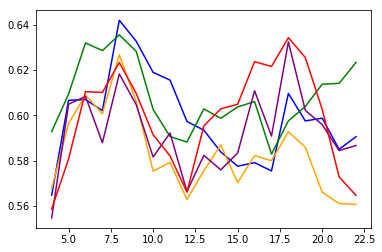

In [137]:
nes_predict = PlotPerformance(nes, splits, my_start, lag, clf_choice, f_sets)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    34
Name: has_lag, dtype: int64

['log_rel_freq'] 1


log_rel_freq_0
0      -13.167966
1       -5.776327
2      -12.198566
3      -13.080955
4      -12.387808

1    23
0    11
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.68      1.00      0.81        23

   micro avg       0.68      0.68      0.68        34
   macro avg       0.34      0.50      0.40        34
weighted avg       0.46      0.68      0.55        34



/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-p

True    34
Name: has_lag, dtype: int64

['log_rel_freq', 'd_u'] 1


log_rel_freq_0     d_u_0
0      -13.167966  0.914711
1       -5.776327  0.981698
2      -12.198566  0.783261
3      -13.080955  1.008119
4      -12.387808  0.941121

1    23
0    11
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.65      0.87      0.74        23

   micro avg       0.59      0.59      0.59        34
   macro avg       0.32      0.43      0.37        34
weighted avg       0.44      0.59      0.50        34



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    34
Name: has_lag, dtype: int64

['log_rel_freq', 'd_t'] 1


log_rel_freq_0     d_t_0
0      -13.167966  0.890610
1       -5.776327  0.989150
2      -12.198566  0.777732
3      -13.080955  0.979724
4      -12.387808  0.980357

1    23
0    11
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.68      1.00      0.81        23

   micro avg       0.68      0.68      0.68        34
   macro avg       0.34      0.50      0.40        34
weighted avg       0.46      0.68      0.55        34



/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-p

True    34
Name: has_lag, dtype: int64

['log_rel_freq', 'd_l'] 1


log_rel_freq_0     d_l_0
0      -13.167966  0.089303
1       -5.776327 -0.153082
2      -12.198566  0.016341
3      -13.080955  0.064385
4      -12.387808  0.104480

1    23
0    11
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.20      0.09      0.13        11
           1       0.66      0.83      0.73        23

   micro avg       0.59      0.59      0.59        34
   macro avg       0.43      0.46      0.43        34
weighted avg       0.51      0.59      0.53        34



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    34
Name: has_lag, dtype: int64

['log_rel_freq', 'd_u', 'd_t', 'd_l'] 1


log_rel_freq_0     d_u_0     d_t_0     d_l_0
0      -13.167966  0.914711  0.890610  0.089303
1       -5.776327  0.981698  0.989150 -0.153082
2      -12.198566  0.783261  0.777732  0.016341
3      -13.080955  1.008119  0.979724  0.064385
4      -12.387808  0.941121  0.980357  0.104480

1    23
0    11
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.43      0.27      0.33        11
           1       0.70      0.83      0.76        23

   micro avg       0.65      0.65      0.65        34
   macro avg       0.57      0.55      0.55        34
weighted avg       0.61      0.65      0.62        34



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    34
Name: has_lag, dtype: int64

['log_rel_freq'] 2


log_rel_freq_0  log_rel_freq_1
0      -13.167966      -13.208667
1       -5.776327       -5.709697
2      -12.198566      -11.968976
3      -13.080955      -12.773349
4      -12.387808      -12.274358

0    23
1    11
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.67      0.96      0.79        23
           1       0.00      0.00      0.00        11

   micro avg       0.65      0.65      0.65        34
   macro avg       0.33      0.48      0.39        34
weighted avg       0.45      0.65      0.53        34



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    34
Name: has_lag, dtype: int64

['log_rel_freq', 'd_u'] 2


log_rel_freq_0  log_rel_freq_1     d_u_0     d_u_1
0      -13.167966      -13.208667  0.914711  1.001581
1       -5.776327       -5.709697  0.981698  0.978265
2      -12.198566      -11.968976  0.783261  0.814800
3      -13.080955      -12.773349  1.008119  0.772815
4      -12.387808      -12.274358  0.941121  0.950276

0    23
1    11
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.73      0.83      0.78        23
           1       0.50      0.36      0.42        11

   micro avg       0.68      0.68      0.68        34
   macro avg       0.62      0.59      0.60        34
weighted avg       0.66      0.68      0.66        34



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    34
Name: has_lag, dtype: int64

['log_rel_freq', 'd_t'] 2


log_rel_freq_0  log_rel_freq_1     d_t_0     d_t_1
0      -13.167966      -13.208667  0.890610  0.979788
1       -5.776327       -5.709697  0.989150  0.973432
2      -12.198566      -11.968976  0.777732  0.851688
3      -13.080955      -12.773349  0.979724  0.979998
4      -12.387808      -12.274358  0.980357  0.945369

0    23
1    11
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.70      0.83      0.76        23
           1       0.43      0.27      0.33        11

   micro avg       0.65      0.65      0.65        34
   macro avg       0.57      0.55      0.55        34
weighted avg       0.61      0.65      0.62        34



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    34
Name: has_lag, dtype: int64

['log_rel_freq', 'd_l'] 2


log_rel_freq_0  log_rel_freq_1     d_l_0     d_l_1
0      -13.167966      -13.208667  0.089303  0.087125
1       -5.776327       -5.709697 -0.153082 -0.181025
2      -12.198566      -11.968976  0.016341  0.040493
3      -13.080955      -12.773349  0.064385  0.083186
4      -12.387808      -12.274358  0.104480  0.121172

0    23
1    11
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.66      0.91      0.76        23
           1       0.00      0.00      0.00        11

   micro avg       0.62      0.62      0.62        34
   macro avg       0.33      0.46      0.38        34
weighted avg       0.44      0.62      0.52        34



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    34
Name: has_lag, dtype: int64

['log_rel_freq', 'd_u', 'd_t', 'd_l'] 2


log_rel_freq_0  log_rel_freq_1     d_u_0     d_u_1     d_t_0     d_t_1  \
0      -13.167966      -13.208667  0.914711  1.001581  0.890610  0.979788   
1       -5.776327       -5.709697  0.981698  0.978265  0.989150  0.973432   
2      -12.198566      -11.968976  0.783261  0.814800  0.777732  0.851688   
3      -13.080955      -12.773349  1.008119  0.772815  0.979724  0.979998   
4      -12.387808      -12.274358  0.941121  0.950276  0.980357  0.945369   

      d_l_0     d_l_1  
0  0.089303  0.087125  
1 -0.153082 -0.181025  
2  0.016341  0.040493  
3  0.064385  0.083186  
4  0.104480  0.121172

0    23
1    11
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.74      0.87      0.80        23
           1       0.57      0.36      0.44        11

   micro avg       0.71      0.71      0.71        34
   macro avg       0.66      0.62      0.62        34
weighted avg       0.69      0.71      0.68        34



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    34
Name: has_lag, dtype: int64

['log_rel_freq'] 3


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2
0      -13.167966      -13.208667      -12.481173
1       -5.776327       -5.709697       -5.713830
2      -12.198566      -11.968976      -12.343023
3      -13.080955      -12.773349      -12.832571
4      -12.387808      -12.274358      -12.280502

1    18
0    16
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.38      0.19      0.25        16
           1       0.50      0.72      0.59        18

   micro avg       0.47      0.47      0.47        34
   macro avg       0.44      0.45      0.42        34
weighted avg       0.44      0.47      0.43        34



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    34
Name: has_lag, dtype: int64

['log_rel_freq', 'd_u'] 3


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2     d_u_0     d_u_1  \
0      -13.167966      -13.208667      -12.481173  0.914711  1.001581   
1       -5.776327       -5.709697       -5.713830  0.981698  0.978265   
2      -12.198566      -11.968976      -12.343023  0.783261  0.814800   
3      -13.080955      -12.773349      -12.832571  1.008119  0.772815   
4      -12.387808      -12.274358      -12.280502  0.941121  0.950276   

      d_u_2  
0  0.948897  
1  0.992065  
2  0.895948  
3  0.855260  
4  0.749432

1    18
0    16
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.25      0.19      0.21        16
           1       0.41      0.50      0.45        18

   micro avg       0.35      0.35      0.35        34
   macro avg       0.33      0.34      0.33        34
weighted avg       0.33      0.35      0.34        34



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    34
Name: has_lag, dtype: int64

['log_rel_freq', 'd_t'] 3


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2     d_t_0     d_t_1  \
0      -13.167966      -13.208667      -12.481173  0.890610  0.979788   
1       -5.776327       -5.709697       -5.713830  0.989150  0.973432   
2      -12.198566      -11.968976      -12.343023  0.777732  0.851688   
3      -13.080955      -12.773349      -12.832571  0.979724  0.979998   
4      -12.387808      -12.274358      -12.280502  0.980357  0.945369   

      d_t_2  
0  0.946022  
1  0.971988  
2  0.855759  
3  0.930453  
4  0.982604

1    18
0    16
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.40      0.38      0.39        16
           1       0.47      0.50      0.49        18

   micro avg       0.44      0.44      0.44        34
   macro avg       0.44      0.44      0.44        34
weighted avg       0.44      0.44      0.44        34



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    34
Name: has_lag, dtype: int64

['log_rel_freq', 'd_l'] 3


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2     d_l_0     d_l_1  \
0      -13.167966      -13.208667      -12.481173  0.089303  0.087125   
1       -5.776327       -5.709697       -5.713830 -0.153082 -0.181025   
2      -12.198566      -11.968976      -12.343023  0.016341  0.040493   
3      -13.080955      -12.773349      -12.832571  0.064385  0.083186   
4      -12.387808      -12.274358      -12.280502  0.104480  0.121172   

      d_l_2  
0  0.085836  
1 -0.189300  
2 -0.155318  
3  0.092627  
4  0.120991

1    18
0    16
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.30      0.19      0.23        16
           1       0.46      0.61      0.52        18

   micro avg       0.41      0.41      0.41        34
   macro avg       0.38      0.40      0.38        34
weighted avg       0.38      0.41      0.39        34



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    34
Name: has_lag, dtype: int64

['log_rel_freq', 'd_u', 'd_t', 'd_l'] 3


log_rel_freq_0  log_rel_freq_1  log_rel_freq_2     d_u_0     d_u_1  \
0      -13.167966      -13.208667      -12.481173  0.914711  1.001581   
1       -5.776327       -5.709697       -5.713830  0.981698  0.978265   
2      -12.198566      -11.968976      -12.343023  0.783261  0.814800   
3      -13.080955      -12.773349      -12.832571  1.008119  0.772815   
4      -12.387808      -12.274358      -12.280502  0.941121  0.950276   

      d_u_2     d_t_0     d_t_1     d_t_2     d_l_0     d_l_1     d_l_2  
0  0.948897  0.890610  0.979788  0.946022  0.089303  0.087125  0.085836  
1  0.992065  0.989150  0.973432  0.971988 -0.153082 -0.181025 -0.189300  
2  0.895948  0.777732  0.851688  0.855759  0.016341  0.040493 -0.155318  
3  0.855260  0.979724  0.979998  0.930453  0.064385  0.083186  0.092627  
4  0.749432  0.980357  0.945369  0.982604  0.104480  0.121172  0.120991

1    18
0    16
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.50      0.38      0.43        16
           1       0.55      0.67      0.60        18

   micro avg       0.53      0.53      0.53        34
   macro avg       0.52      0.52      0.51        34
weighted avg       0.52      0.53      0.52        34



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    34
Name: has_lag, dtype: int64

['log_rel_freq'] 4


log_rel_freq_1  log_rel_freq_2  log_rel_freq_3
0      -13.208667      -12.481173      -12.580524
1       -5.709697       -5.713830       -5.739048
2      -11.968976      -12.343023      -11.411953
3      -12.773349      -12.832571      -12.383814
4      -12.274358      -12.280502      -12.771579

1    18
0    16
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.64      0.56      0.60        16
           1       0.65      0.72      0.68        18

   micro avg       0.65      0.65      0.65        34
   macro avg       0.65      0.64      0.64        34
weighted avg       0.65      0.65      0.64        34



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    34
Name: has_lag, dtype: int64

['log_rel_freq', 'd_u'] 4


log_rel_freq_1  log_rel_freq_2  log_rel_freq_3     d_u_1     d_u_2  \
0      -13.208667      -12.481173      -12.580524  1.001581  0.948897   
1       -5.709697       -5.713830       -5.739048  0.978265  0.992065   
2      -11.968976      -12.343023      -11.411953  0.814800  0.895948   
3      -12.773349      -12.832571      -12.383814  0.772815  0.855260   
4      -12.274358      -12.280502      -12.771579  0.950276  0.749432   

      d_u_3  
0  0.924737  
1  0.984582  
2  0.663141  
3  0.981111  
4  1.008649

1    18
0    16
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.53      0.50      0.52        16
           1       0.58      0.61      0.59        18

   micro avg       0.56      0.56      0.56        34
   macro avg       0.56      0.56      0.56        34
weighted avg       0.56      0.56      0.56        34



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    34
Name: has_lag, dtype: int64

['log_rel_freq', 'd_t'] 4


log_rel_freq_1  log_rel_freq_2  log_rel_freq_3     d_t_1     d_t_2  \
0      -13.208667      -12.481173      -12.580524  0.979788  0.946022   
1       -5.709697       -5.713830       -5.739048  0.973432  0.971988   
2      -11.968976      -12.343023      -11.411953  0.851688  0.855759   
3      -12.773349      -12.832571      -12.383814  0.979998  0.930453   
4      -12.274358      -12.280502      -12.771579  0.945369  0.982604   

      d_t_3  
0  0.982136  
1  0.975988  
2  0.811496  
3  0.982365  
4  0.981952

1    18
0    16
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.77      0.62      0.69        16
           1       0.71      0.83      0.77        18

   micro avg       0.74      0.74      0.74        34
   macro avg       0.74      0.73      0.73        34
weighted avg       0.74      0.74      0.73        34



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    34
Name: has_lag, dtype: int64

['log_rel_freq', 'd_l'] 4


log_rel_freq_1  log_rel_freq_2  log_rel_freq_3     d_l_1     d_l_2  \
0      -13.208667      -12.481173      -12.580524  0.087125  0.085836   
1       -5.709697       -5.713830       -5.739048 -0.181025 -0.189300   
2      -11.968976      -12.343023      -11.411953  0.040493 -0.155318   
3      -12.773349      -12.832571      -12.383814  0.083186  0.092627   
4      -12.274358      -12.280502      -12.771579  0.121172  0.120991   

      d_l_3  
0  0.073545  
1 -0.175697  
2 -0.328034  
3  0.089034  
4  0.110804

1    18
0    16
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.54      0.44      0.48        16
           1       0.57      0.67      0.62        18

   micro avg       0.56      0.56      0.56        34
   macro avg       0.55      0.55      0.55        34
weighted avg       0.56      0.56      0.55        34



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    34
Name: has_lag, dtype: int64

['log_rel_freq', 'd_u', 'd_t', 'd_l'] 4


log_rel_freq_1  log_rel_freq_2  log_rel_freq_3     d_u_1     d_u_2  \
0      -13.208667      -12.481173      -12.580524  1.001581  0.948897   
1       -5.709697       -5.713830       -5.739048  0.978265  0.992065   
2      -11.968976      -12.343023      -11.411953  0.814800  0.895948   
3      -12.773349      -12.832571      -12.383814  0.772815  0.855260   
4      -12.274358      -12.280502      -12.771579  0.950276  0.749432   

      d_u_3     d_t_1     d_t_2     d_t_3     d_l_1     d_l_2     d_l_3  
0  0.924737  0.979788  0.946022  0.982136  0.087125  0.085836  0.073545  
1  0.984582  0.973432  0.971988  0.975988 -0.181025 -0.189300 -0.175697  
2  0.663141  0.851688  0.855759  0.811496  0.040493 -0.155318 -0.328034  
3  0.981111  0.979998  0.930453  0.982365  0.083186  0.092627  0.089034  
4  1.008649  0.945369  0.982604  0.981952  0.121172  0.120991  0.110804

1    18
0    16
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.64      0.56      0.60        16
           1       0.65      0.72      0.68        18

   micro avg       0.65      0.65      0.65        34
   macro avg       0.65      0.64      0.64        34
weighted avg       0.65      0.65      0.64        34



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    34
Name: has_lag, dtype: int64

['log_rel_freq'] 5


log_rel_freq_2  log_rel_freq_3  log_rel_freq_4
0      -12.481173      -12.580524      -12.525312
1       -5.713830       -5.739048       -5.761678
2      -12.343023      -11.411953      -12.164298
3      -12.832571      -12.383814      -11.971926
4      -12.280502      -12.771579      -12.770434

0    18
1    16
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.54      0.72      0.62        18
           1       0.50      0.31      0.38        16

   micro avg       0.53      0.53      0.53        34
   macro avg       0.52      0.52      0.50        34
weighted avg       0.52      0.53      0.51        34



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    34
Name: has_lag, dtype: int64

['log_rel_freq', 'd_u'] 5


log_rel_freq_2  log_rel_freq_3  log_rel_freq_4     d_u_2     d_u_3  \
0      -12.481173      -12.580524      -12.525312  0.948897  0.924737   
1       -5.713830       -5.739048       -5.761678  0.992065  0.984582   
2      -12.343023      -11.411953      -12.164298  0.895948  0.663141   
3      -12.832571      -12.383814      -11.971926  0.855260  0.981111   
4      -12.280502      -12.771579      -12.770434  0.749432  1.008649   

      d_u_4  
0  0.834293  
1  0.989223  
2  0.956724  
3  0.716416  
4  0.893243

0    18
1    16
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.53      0.50      0.51        18
           1       0.47      0.50      0.48        16

   micro avg       0.50      0.50      0.50        34
   macro avg       0.50      0.50      0.50        34
weighted avg       0.50      0.50      0.50        34



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    34
Name: has_lag, dtype: int64

['log_rel_freq', 'd_t'] 5


log_rel_freq_2  log_rel_freq_3  log_rel_freq_4     d_t_2     d_t_3  \
0      -12.481173      -12.580524      -12.525312  0.946022  0.982136   
1       -5.713830       -5.739048       -5.761678  0.971988  0.975988   
2      -12.343023      -11.411953      -12.164298  0.855759  0.811496   
3      -12.832571      -12.383814      -11.971926  0.930453  0.982365   
4      -12.280502      -12.771579      -12.770434  0.982604  0.981952   

      d_t_4  
0  0.896019  
1  0.985850  
2  0.862785  
3  0.810226  
4  0.981136

0    18
1    16
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.47      0.50      0.49        18
           1       0.40      0.38      0.39        16

   micro avg       0.44      0.44      0.44        34
   macro avg       0.44      0.44      0.44        34
weighted avg       0.44      0.44      0.44        34



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    34
Name: has_lag, dtype: int64

['log_rel_freq', 'd_l'] 5


log_rel_freq_2  log_rel_freq_3  log_rel_freq_4     d_l_2     d_l_3  \
0      -12.481173      -12.580524      -12.525312  0.085836  0.073545   
1       -5.713830       -5.739048       -5.761678 -0.189300 -0.175697   
2      -12.343023      -11.411953      -12.164298 -0.155318 -0.328034   
3      -12.832571      -12.383814      -11.971926  0.092627  0.089034   
4      -12.280502      -12.771579      -12.770434  0.120991  0.110804   

      d_l_4  
0  0.054410  
1 -0.174705  
2 -0.048972  
3  0.100428  
4  0.086490

0    18
1    16
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.54      0.72      0.62        18
           1       0.50      0.31      0.38        16

   micro avg       0.53      0.53      0.53        34
   macro avg       0.52      0.52      0.50        34
weighted avg       0.52      0.53      0.51        34



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    34
Name: has_lag, dtype: int64

['log_rel_freq', 'd_u', 'd_t', 'd_l'] 5


log_rel_freq_2  log_rel_freq_3  log_rel_freq_4     d_u_2     d_u_3  \
0      -12.481173      -12.580524      -12.525312  0.948897  0.924737   
1       -5.713830       -5.739048       -5.761678  0.992065  0.984582   
2      -12.343023      -11.411953      -12.164298  0.895948  0.663141   
3      -12.832571      -12.383814      -11.971926  0.855260  0.981111   
4      -12.280502      -12.771579      -12.770434  0.749432  1.008649   

      d_u_4     d_t_2     d_t_3     d_t_4     d_l_2     d_l_3     d_l_4  
0  0.834293  0.946022  0.982136  0.896019  0.085836  0.073545  0.054410  
1  0.989223  0.971988  0.975988  0.985850 -0.189300 -0.175697 -0.174705  
2  0.956724  0.855759  0.811496  0.862785 -0.155318 -0.328034 -0.048972  
3  0.716416  0.930453  0.982365  0.810226  0.092627  0.089034  0.100428  
4  0.893243  0.982604  0.981952  0.981136  0.120991  0.110804  0.086490

0    18
1    16
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.44      0.44      0.44        18
           1       0.38      0.38      0.38        16

   micro avg       0.41      0.41      0.41        34
   macro avg       0.41      0.41      0.41        34
weighted avg       0.41      0.41      0.41        34



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    34
Name: has_lag, dtype: int64

['log_rel_freq'] 6


log_rel_freq_3  log_rel_freq_4  log_rel_freq_5
0      -12.580524      -12.525312      -12.820969
1       -5.739048       -5.761678       -5.706114
2      -11.411953      -12.164298      -11.606525
3      -12.383814      -11.971926      -11.722356
4      -12.771579      -12.770434      -12.364210

0    23
1    11
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.68      1.00      0.81        23
           1       0.00      0.00      0.00        11

   micro avg       0.68      0.68      0.68        34
   macro avg       0.34      0.50      0.40        34
weighted avg       0.46      0.68      0.55        34



/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-p

True    34
Name: has_lag, dtype: int64

['log_rel_freq', 'd_u'] 6


log_rel_freq_3  log_rel_freq_4  log_rel_freq_5     d_u_3     d_u_4  \
0      -12.580524      -12.525312      -12.820969  0.924737  0.834293   
1       -5.739048       -5.761678       -5.706114  0.984582  0.989223   
2      -11.411953      -12.164298      -11.606525  0.663141  0.956724   
3      -12.383814      -11.971926      -11.722356  0.981111  0.716416   
4      -12.771579      -12.770434      -12.364210  1.008649  0.893243   

      d_u_5  
0  0.959380  
1  0.976368  
2  0.572806  
3  0.640848  
4  0.956078

0    23
1    11
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.70      0.91      0.79        23
           1       0.50      0.18      0.27        11

   micro avg       0.68      0.68      0.68        34
   macro avg       0.60      0.55      0.53        34
weighted avg       0.64      0.68      0.62        34



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    34
Name: has_lag, dtype: int64

['log_rel_freq', 'd_t'] 6


log_rel_freq_3  log_rel_freq_4  log_rel_freq_5     d_t_3     d_t_4  \
0      -12.580524      -12.525312      -12.820969  0.982136  0.896019   
1       -5.739048       -5.761678       -5.706114  0.975988  0.985850   
2      -11.411953      -12.164298      -11.606525  0.811496  0.862785   
3      -12.383814      -11.971926      -11.722356  0.982365  0.810226   
4      -12.771579      -12.770434      -12.364210  0.981952  0.981136   

      d_t_5  
0  0.982441  
1  0.982829  
2  0.691905  
3  0.690383  
4  0.982835

0    23
1    11
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.71      0.87      0.78        23
           1       0.50      0.27      0.35        11

   micro avg       0.68      0.68      0.68        34
   macro avg       0.61      0.57      0.57        34
weighted avg       0.64      0.68      0.64        34



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    34
Name: has_lag, dtype: int64

['log_rel_freq', 'd_l'] 6


log_rel_freq_3  log_rel_freq_4  log_rel_freq_5     d_l_3     d_l_4  \
0      -12.580524      -12.525312      -12.820969  0.073545  0.054410   
1       -5.739048       -5.761678       -5.706114 -0.175697 -0.174705   
2      -11.411953      -12.164298      -11.606525 -0.328034 -0.048972   
3      -12.383814      -11.971926      -11.722356  0.089034  0.100428   
4      -12.771579      -12.770434      -12.364210  0.110804  0.086490   

      d_l_5  
0  0.053947  
1 -0.196649  
2 -0.156018  
3  0.088195  
4  0.124828

0    23
1    11
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.69      0.96      0.80        23
           1       0.50      0.09      0.15        11

   micro avg       0.68      0.68      0.68        34
   macro avg       0.59      0.52      0.48        34
weighted avg       0.63      0.68      0.59        34



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    34
Name: has_lag, dtype: int64

['log_rel_freq', 'd_u', 'd_t', 'd_l'] 6


log_rel_freq_3  log_rel_freq_4  log_rel_freq_5     d_u_3     d_u_4  \
0      -12.580524      -12.525312      -12.820969  0.924737  0.834293   
1       -5.739048       -5.761678       -5.706114  0.984582  0.989223   
2      -11.411953      -12.164298      -11.606525  0.663141  0.956724   
3      -12.383814      -11.971926      -11.722356  0.981111  0.716416   
4      -12.771579      -12.770434      -12.364210  1.008649  0.893243   

      d_u_5     d_t_3     d_t_4     d_t_5     d_l_3     d_l_4     d_l_5  
0  0.959380  0.982136  0.896019  0.982441  0.073545  0.054410  0.053947  
1  0.976368  0.975988  0.985850  0.982829 -0.175697 -0.174705 -0.196649  
2  0.572806  0.811496  0.862785  0.691905 -0.328034 -0.048972 -0.156018  
3  0.640848  0.982365  0.810226  0.690383  0.089034  0.100428  0.088195  
4  0.956078  0.981952  0.981136  0.982835  0.110804  0.086490  0.124828

0    23
1    11
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.76      0.83      0.79        23
           1       0.56      0.45      0.50        11

   micro avg       0.71      0.71      0.71        34
   macro avg       0.66      0.64      0.65        34
weighted avg       0.69      0.71      0.70        34



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    34
Name: has_lag, dtype: int64

['log_rel_freq'] 7


log_rel_freq_4  log_rel_freq_5  log_rel_freq_6
0      -12.525312      -12.820969      -12.387839
1       -5.761678       -5.706114       -5.638585
2      -12.164298      -11.606525      -11.717165
3      -11.971926      -11.722356      -13.103459
4      -12.770434      -12.364210      -12.224210

1    22
0    12
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.50      0.17      0.25        12
           1       0.67      0.91      0.77        22

   micro avg       0.65      0.65      0.65        34
   macro avg       0.58      0.54      0.51        34
weighted avg       0.61      0.65      0.59        34



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    34
Name: has_lag, dtype: int64

['log_rel_freq', 'd_u'] 7


log_rel_freq_4  log_rel_freq_5  log_rel_freq_6     d_u_4     d_u_5  \
0      -12.525312      -12.820969      -12.387839  0.834293  0.959380   
1       -5.761678       -5.706114       -5.638585  0.989223  0.976368   
2      -12.164298      -11.606525      -11.717165  0.956724  0.572806   
3      -11.971926      -11.722356      -13.103459  0.716416  0.640848   
4      -12.770434      -12.364210      -12.224210  0.893243  0.956078   

      d_u_6  
0  0.768193  
1  0.977886  
2  0.622542  
3  0.866504  
4  0.904953

1    22
0    12
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.57      0.33      0.42        12
           1       0.70      0.86      0.78        22

   micro avg       0.68      0.68      0.68        34
   macro avg       0.64      0.60      0.60        34
weighted avg       0.66      0.68      0.65        34



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    34
Name: has_lag, dtype: int64

['log_rel_freq', 'd_t'] 7


log_rel_freq_4  log_rel_freq_5  log_rel_freq_6     d_t_4     d_t_5  \
0      -12.525312      -12.820969      -12.387839  0.896019  0.982441   
1       -5.761678       -5.706114       -5.638585  0.985850  0.982829   
2      -12.164298      -11.606525      -11.717165  0.862785  0.691905   
3      -11.971926      -11.722356      -13.103459  0.810226  0.690383   
4      -12.770434      -12.364210      -12.224210  0.981136  0.982835   

      d_t_6  
0  0.942263  
1  0.971476  
2  0.628374  
3  0.940566  
4  0.967733

1    22
0    12
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.75      0.25      0.38        12
           1       0.70      0.95      0.81        22

   micro avg       0.71      0.71      0.71        34
   macro avg       0.72      0.60      0.59        34
weighted avg       0.72      0.71      0.65        34



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    34
Name: has_lag, dtype: int64

['log_rel_freq', 'd_l'] 7


log_rel_freq_4  log_rel_freq_5  log_rel_freq_6     d_l_4     d_l_5  \
0      -12.525312      -12.820969      -12.387839  0.054410  0.053947   
1       -5.761678       -5.706114       -5.638585 -0.174705 -0.196649   
2      -12.164298      -11.606525      -11.717165 -0.048972 -0.156018   
3      -11.971926      -11.722356      -13.103459  0.100428  0.088195   
4      -12.770434      -12.364210      -12.224210  0.086490  0.124828   

      d_l_6  
0  0.048503  
1 -0.240789  
2 -0.147297  
3  0.058831  
4  0.130773

1    22
0    12
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.17      0.08      0.11        12
           1       0.61      0.77      0.68        22

   micro avg       0.53      0.53      0.53        34
   macro avg       0.39      0.43      0.40        34
weighted avg       0.45      0.53      0.48        34



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    34
Name: has_lag, dtype: int64

['log_rel_freq', 'd_u', 'd_t', 'd_l'] 7


log_rel_freq_4  log_rel_freq_5  log_rel_freq_6     d_u_4     d_u_5  \
0      -12.525312      -12.820969      -12.387839  0.834293  0.959380   
1       -5.761678       -5.706114       -5.638585  0.989223  0.976368   
2      -12.164298      -11.606525      -11.717165  0.956724  0.572806   
3      -11.971926      -11.722356      -13.103459  0.716416  0.640848   
4      -12.770434      -12.364210      -12.224210  0.893243  0.956078   

      d_u_6     d_t_4     d_t_5     d_t_6     d_l_4     d_l_5     d_l_6  
0  0.768193  0.896019  0.982441  0.942263  0.054410  0.053947  0.048503  
1  0.977886  0.985850  0.982829  0.971476 -0.174705 -0.196649 -0.240789  
2  0.622542  0.862785  0.691905  0.628374 -0.048972 -0.156018 -0.147297  
3  0.866504  0.810226  0.690383  0.940566  0.100428  0.088195  0.058831  
4  0.904953  0.981136  0.982835  0.967733  0.086490  0.124828  0.130773

1    22
0    12
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.44      0.33      0.38        12
           1       0.68      0.77      0.72        22

   micro avg       0.62      0.62      0.62        34
   macro avg       0.56      0.55      0.55        34
weighted avg       0.60      0.62      0.60        34



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    34
Name: has_lag, dtype: int64

['log_rel_freq'] 8


log_rel_freq_5  log_rel_freq_6  log_rel_freq_7
0      -12.820969      -12.387839      -12.268867
1       -5.706114       -5.638585       -5.705172
2      -11.606525      -11.717165      -11.658608
3      -11.722356      -13.103459      -12.415471
4      -12.364210      -12.224210      -12.064073

0    23
1    11
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.67      0.96      0.79        23
           1       0.00      0.00      0.00        11

   micro avg       0.65      0.65      0.65        34
   macro avg       0.33      0.48      0.39        34
weighted avg       0.45      0.65      0.53        34



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    34
Name: has_lag, dtype: int64

['log_rel_freq', 'd_u'] 8


log_rel_freq_5  log_rel_freq_6  log_rel_freq_7     d_u_5     d_u_6  \
0      -12.820969      -12.387839      -12.268867  0.959380  0.768193   
1       -5.706114       -5.638585       -5.705172  0.976368  0.977886   
2      -11.606525      -11.717165      -11.658608  0.572806  0.622542   
3      -11.722356      -13.103459      -12.415471  0.640848  0.866504   
4      -12.364210      -12.224210      -12.064073  0.956078  0.904953   

      d_u_7  
0  0.753158  
1  1.007125  
2  0.728524  
3  0.790892  
4  0.840038

0    23
1    11
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.71      0.87      0.78        23
           1       0.50      0.27      0.35        11

   micro avg       0.68      0.68      0.68        34
   macro avg       0.61      0.57      0.57        34
weighted avg       0.64      0.68      0.64        34



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    34
Name: has_lag, dtype: int64

['log_rel_freq', 'd_t'] 8


log_rel_freq_5  log_rel_freq_6  log_rel_freq_7     d_t_5     d_t_6  \
0      -12.820969      -12.387839      -12.268867  0.982441  0.942263   
1       -5.706114       -5.638585       -5.705172  0.982829  0.971476   
2      -11.606525      -11.717165      -11.658608  0.691905  0.628374   
3      -11.722356      -13.103459      -12.415471  0.690383  0.940566   
4      -12.364210      -12.224210      -12.064073  0.982835  0.967733   

      d_t_7  
0  0.918245  
1  0.972964  
2  0.816146  
3  0.907448  
4  0.985774

0    23
1    11
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.68      0.83      0.75        23
           1       0.33      0.18      0.24        11

   micro avg       0.62      0.62      0.62        34
   macro avg       0.51      0.50      0.49        34
weighted avg       0.57      0.62      0.58        34



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    34
Name: has_lag, dtype: int64

['log_rel_freq', 'd_l'] 8


log_rel_freq_5  log_rel_freq_6  log_rel_freq_7     d_l_5     d_l_6  \
0      -12.820969      -12.387839      -12.268867  0.053947  0.048503   
1       -5.706114       -5.638585       -5.705172 -0.196649 -0.240789   
2      -11.606525      -11.717165      -11.658608 -0.156018 -0.147297   
3      -11.722356      -13.103459      -12.415471  0.088195  0.058831   
4      -12.364210      -12.224210      -12.064073  0.124828  0.130773   

      d_l_7  
0 -0.007658  
1 -0.215070  
2 -0.168029  
3  0.115326  
4  0.098647

0    23
1    11
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.67      0.96      0.79        23
           1       0.00      0.00      0.00        11

   micro avg       0.65      0.65      0.65        34
   macro avg       0.33      0.48      0.39        34
weighted avg       0.45      0.65      0.53        34



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    34
Name: has_lag, dtype: int64

['log_rel_freq', 'd_u', 'd_t', 'd_l'] 8


log_rel_freq_5  log_rel_freq_6  log_rel_freq_7     d_u_5     d_u_6  \
0      -12.820969      -12.387839      -12.268867  0.959380  0.768193   
1       -5.706114       -5.638585       -5.705172  0.976368  0.977886   
2      -11.606525      -11.717165      -11.658608  0.572806  0.622542   
3      -11.722356      -13.103459      -12.415471  0.640848  0.866504   
4      -12.364210      -12.224210      -12.064073  0.956078  0.904953   

      d_u_7     d_t_5     d_t_6     d_t_7     d_l_5     d_l_6     d_l_7  
0  0.753158  0.982441  0.942263  0.918245  0.053947  0.048503 -0.007658  
1  1.007125  0.982829  0.971476  0.972964 -0.196649 -0.240789 -0.215070  
2  0.728524  0.691905  0.628374  0.816146 -0.156018 -0.147297 -0.168029  
3  0.790892  0.690383  0.940566  0.907448  0.088195  0.058831  0.115326  
4  0.840038  0.982835  0.967733  0.985774  0.124828  0.130773  0.098647

0    23
1    11
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.74      0.74      0.74        23
           1       0.45      0.45      0.45        11

   micro avg       0.65      0.65      0.65        34
   macro avg       0.60      0.60      0.60        34
weighted avg       0.65      0.65      0.65        34



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    34
Name: has_lag, dtype: int64

['log_rel_freq'] 9


log_rel_freq_6  log_rel_freq_7  log_rel_freq_8
0      -12.387839      -12.268867      -12.415816
1       -5.638585       -5.705172       -5.752184
2      -11.717165      -11.658608      -11.408175
3      -13.103459      -12.415471      -12.394310
4      -12.224210      -12.064073      -12.332434

1    18
0    16
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.50      0.31      0.38        16
           1       0.54      0.72      0.62        18

   micro avg       0.53      0.53      0.53        34
   macro avg       0.52      0.52      0.50        34
weighted avg       0.52      0.53      0.51        34



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    34
Name: has_lag, dtype: int64

['log_rel_freq', 'd_u'] 9


log_rel_freq_6  log_rel_freq_7  log_rel_freq_8     d_u_6     d_u_7  \
0      -12.387839      -12.268867      -12.415816  0.768193  0.753158   
1       -5.638585       -5.705172       -5.752184  0.977886  1.007125   
2      -11.717165      -11.658608      -11.408175  0.622542  0.728524   
3      -13.103459      -12.415471      -12.394310  0.866504  0.790892   
4      -12.224210      -12.064073      -12.332434  0.904953  0.840038   

      d_u_8  
0  0.917776  
1  1.008142  
2  0.590370  
3  0.727440  
4  0.906082

1    18
0    16
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.46      0.38      0.41        16
           1       0.52      0.61      0.56        18

   micro avg       0.50      0.50      0.50        34
   macro avg       0.49      0.49      0.49        34
weighted avg       0.49      0.50      0.49        34



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    34
Name: has_lag, dtype: int64

['log_rel_freq', 'd_t'] 9


log_rel_freq_6  log_rel_freq_7  log_rel_freq_8     d_t_6     d_t_7  \
0      -12.387839      -12.268867      -12.415816  0.942263  0.918245   
1       -5.638585       -5.705172       -5.752184  0.971476  0.972964   
2      -11.717165      -11.658608      -11.408175  0.628374  0.816146   
3      -13.103459      -12.415471      -12.394310  0.940566  0.907448   
4      -12.224210      -12.064073      -12.332434  0.967733  0.985774   

      d_t_8  
0  0.986671  
1  0.977064  
2  0.651487  
3  0.902726  
4  0.986789

1    18
0    16
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.58      0.44      0.50        16
           1       0.59      0.72      0.65        18

   micro avg       0.59      0.59      0.59        34
   macro avg       0.59      0.58      0.57        34
weighted avg       0.59      0.59      0.58        34



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    34
Name: has_lag, dtype: int64

['log_rel_freq', 'd_l'] 9


log_rel_freq_6  log_rel_freq_7  log_rel_freq_8     d_l_6     d_l_7  \
0      -12.387839      -12.268867      -12.415816  0.048503 -0.007658   
1       -5.638585       -5.705172       -5.752184 -0.240789 -0.215070   
2      -11.717165      -11.658608      -11.408175 -0.147297 -0.168029   
3      -13.103459      -12.415471      -12.394310  0.058831  0.115326   
4      -12.224210      -12.064073      -12.332434  0.130773  0.098647   

      d_l_8  
0  0.078222  
1 -0.227304  
2 -0.176576  
3  0.132801  
4  0.143362

1    18
0    16
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.43      0.38      0.40        16
           1       0.50      0.56      0.53        18

   micro avg       0.47      0.47      0.47        34
   macro avg       0.46      0.47      0.46        34
weighted avg       0.47      0.47      0.47        34



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    34
Name: has_lag, dtype: int64

['log_rel_freq', 'd_u', 'd_t', 'd_l'] 9


log_rel_freq_6  log_rel_freq_7  log_rel_freq_8     d_u_6     d_u_7  \
0      -12.387839      -12.268867      -12.415816  0.768193  0.753158   
1       -5.638585       -5.705172       -5.752184  0.977886  1.007125   
2      -11.717165      -11.658608      -11.408175  0.622542  0.728524   
3      -13.103459      -12.415471      -12.394310  0.866504  0.790892   
4      -12.224210      -12.064073      -12.332434  0.904953  0.840038   

      d_u_8     d_t_6     d_t_7     d_t_8     d_l_6     d_l_7     d_l_8  
0  0.917776  0.942263  0.918245  0.986671  0.048503 -0.007658  0.078222  
1  1.008142  0.971476  0.972964  0.977064 -0.240789 -0.215070 -0.227304  
2  0.590370  0.628374  0.816146  0.651487 -0.147297 -0.168029 -0.176576  
3  0.727440  0.940566  0.907448  0.902726  0.058831  0.115326  0.132801  
4  0.906082  0.967733  0.985774  0.986789  0.130773  0.098647  0.143362

1    18
0    16
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.41      0.44      0.42        16
           1       0.47      0.44      0.46        18

   micro avg       0.44      0.44      0.44        34
   macro avg       0.44      0.44      0.44        34
weighted avg       0.44      0.44      0.44        34



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    34
Name: has_lag, dtype: int64

['log_rel_freq'] 10


log_rel_freq_7  log_rel_freq_8  log_rel_freq_9
0      -12.268867      -12.415816      -12.546233
1       -5.705172       -5.752184       -5.726242
2      -11.658608      -11.408175      -11.351606
3      -12.415471      -12.394310      -13.088557
4      -12.064073      -12.332434      -12.087925

0    22
1    12
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.66      0.95      0.78        22
           1       0.50      0.08      0.14        12

   micro avg       0.65      0.65      0.65        34
   macro avg       0.58      0.52      0.46        34
weighted avg       0.60      0.65      0.55        34



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    34
Name: has_lag, dtype: int64

['log_rel_freq', 'd_u'] 10


log_rel_freq_7  log_rel_freq_8  log_rel_freq_9     d_u_7     d_u_8  \
0      -12.268867      -12.415816      -12.546233  0.753158  0.917776   
1       -5.705172       -5.752184       -5.726242  1.007125  1.008142   
2      -11.658608      -11.408175      -11.351606  0.728524  0.590370   
3      -12.415471      -12.394310      -13.088557  0.790892  0.727440   
4      -12.064073      -12.332434      -12.087925  0.840038  0.906082   

      d_u_9  
0  0.724423  
1  1.018499  
2  0.644146  
3  0.757914  
4  0.880324

0    22
1    12
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.61      0.86      0.72        22
           1       0.00      0.00      0.00        12

   micro avg       0.56      0.56      0.56        34
   macro avg       0.31      0.43      0.36        34
weighted avg       0.40      0.56      0.46        34



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    34
Name: has_lag, dtype: int64

['log_rel_freq', 'd_t'] 10


log_rel_freq_7  log_rel_freq_8  log_rel_freq_9     d_t_7     d_t_8  \
0      -12.268867      -12.415816      -12.546233  0.918245  0.986671   
1       -5.705172       -5.752184       -5.726242  0.972964  0.977064   
2      -11.658608      -11.408175      -11.351606  0.816146  0.651487   
3      -12.415471      -12.394310      -13.088557  0.907448  0.902726   
4      -12.064073      -12.332434      -12.087925  0.985774  0.986789   

      d_t_9  
0  0.872246  
1  0.968796  
2  0.620317  
3  0.828673  
4  0.973181

0    22
1    12
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.63      0.86      0.73        22
           1       0.25      0.08      0.12        12

   micro avg       0.59      0.59      0.59        34
   macro avg       0.44      0.47      0.43        34
weighted avg       0.50      0.59      0.52        34



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    34
Name: has_lag, dtype: int64

['log_rel_freq', 'd_l'] 10


log_rel_freq_7  log_rel_freq_8  log_rel_freq_9     d_l_7     d_l_8  \
0      -12.268867      -12.415816      -12.546233 -0.007658  0.078222   
1       -5.705172       -5.752184       -5.726242 -0.215070 -0.227304   
2      -11.658608      -11.408175      -11.351606 -0.168029 -0.176576   
3      -12.415471      -12.394310      -13.088557  0.115326  0.132801   
4      -12.064073      -12.332434      -12.087925  0.098647  0.143362   

      d_l_9  
0  0.077966  
1 -0.217181  
2 -0.077232  
3  0.052470  
4  0.173012

0    22
1    12
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.67      0.91      0.77        22
           1       0.50      0.17      0.25        12

   micro avg       0.65      0.65      0.65        34
   macro avg       0.58      0.54      0.51        34
weighted avg       0.61      0.65      0.59        34



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    34
Name: has_lag, dtype: int64

['log_rel_freq', 'd_u', 'd_t', 'd_l'] 10


log_rel_freq_7  log_rel_freq_8  log_rel_freq_9     d_u_7     d_u_8  \
0      -12.268867      -12.415816      -12.546233  0.753158  0.917776   
1       -5.705172       -5.752184       -5.726242  1.007125  1.008142   
2      -11.658608      -11.408175      -11.351606  0.728524  0.590370   
3      -12.415471      -12.394310      -13.088557  0.790892  0.727440   
4      -12.064073      -12.332434      -12.087925  0.840038  0.906082   

      d_u_9     d_t_7     d_t_8     d_t_9     d_l_7     d_l_8     d_l_9  
0  0.724423  0.918245  0.986671  0.872246 -0.007658  0.078222  0.077966  
1  1.018499  0.972964  0.977064  0.968796 -0.215070 -0.227304 -0.217181  
2  0.644146  0.816146  0.651487  0.620317 -0.168029 -0.176576 -0.077232  
3  0.757914  0.907448  0.902726  0.828673  0.115326  0.132801  0.052470  
4  0.880324  0.985774  0.986789  0.973181  0.098647  0.143362  0.173012

0    22
1    12
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.57      0.73      0.64        22
           1       0.00      0.00      0.00        12

   micro avg       0.47      0.47      0.47        34
   macro avg       0.29      0.36      0.32        34
weighted avg       0.37      0.47      0.41        34



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    34
Name: has_lag, dtype: int64

['log_rel_freq'] 11


log_rel_freq_8  log_rel_freq_9  log_rel_freq_10
0      -12.415816      -12.546233       -12.011572
1       -5.752184       -5.726242        -5.717646
2      -11.408175      -11.351606       -11.465655
3      -12.394310      -13.088557       -13.609175
4      -12.332434      -12.087925       -12.331515

1    17
0    17
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.57      0.47      0.52        17
           1       0.55      0.65      0.59        17

   micro avg       0.56      0.56      0.56        34
   macro avg       0.56      0.56      0.56        34
weighted avg       0.56      0.56      0.56        34



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    34
Name: has_lag, dtype: int64

['log_rel_freq', 'd_u'] 11


log_rel_freq_8  log_rel_freq_9  log_rel_freq_10     d_u_8     d_u_9  \
0      -12.415816      -12.546233       -12.011572  0.917776  0.724423   
1       -5.752184       -5.726242        -5.717646  1.008142  1.018499   
2      -11.408175      -11.351606       -11.465655  0.590370  0.644146   
3      -12.394310      -13.088557       -13.609175  0.727440  0.757914   
4      -12.332434      -12.087925       -12.331515  0.906082  0.880324   

     d_u_10  
0  0.866470  
1  1.028385  
2  0.525693  
3  0.937716  
4  0.933198

1    17
0    17
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.47      0.47      0.47        17
           1       0.47      0.47      0.47        17

   micro avg       0.47      0.47      0.47        34
   macro avg       0.47      0.47      0.47        34
weighted avg       0.47      0.47      0.47        34



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    34
Name: has_lag, dtype: int64

['log_rel_freq', 'd_t'] 11


log_rel_freq_8  log_rel_freq_9  log_rel_freq_10     d_t_8     d_t_9  \
0      -12.415816      -12.546233       -12.011572  0.986671  0.872246   
1       -5.752184       -5.726242        -5.717646  0.977064  0.968796   
2      -11.408175      -11.351606       -11.465655  0.651487  0.620317   
3      -12.394310      -13.088557       -13.609175  0.902726  0.828673   
4      -12.332434      -12.087925       -12.331515  0.986789  0.973181   

     d_t_10  
0  0.870964  
1  0.958643  
2  0.600926  
3  0.928916  
4  0.955691

1    17
0    17
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.59      0.59      0.59        17
           1       0.59      0.59      0.59        17

   micro avg       0.59      0.59      0.59        34
   macro avg       0.59      0.59      0.59        34
weighted avg       0.59      0.59      0.59        34



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    34
Name: has_lag, dtype: int64

['log_rel_freq', 'd_l'] 11


log_rel_freq_8  log_rel_freq_9  log_rel_freq_10     d_l_8     d_l_9  \
0      -12.415816      -12.546233       -12.011572  0.078222  0.077966   
1       -5.752184       -5.726242        -5.717646 -0.227304 -0.217181   
2      -11.408175      -11.351606       -11.465655 -0.176576 -0.077232   
3      -12.394310      -13.088557       -13.609175  0.132801  0.052470   
4      -12.332434      -12.087925       -12.331515  0.143362  0.173012   

     d_l_10  
0 -0.031514  
1 -0.202621  
2 -0.019182  
3  0.107560  
4  0.151796

1    17
0    17
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.43      0.35      0.39        17
           1       0.45      0.53      0.49        17

   micro avg       0.44      0.44      0.44        34
   macro avg       0.44      0.44      0.44        34
weighted avg       0.44      0.44      0.44        34



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    34
Name: has_lag, dtype: int64

['log_rel_freq', 'd_u', 'd_t', 'd_l'] 11


log_rel_freq_8  log_rel_freq_9  log_rel_freq_10     d_u_8     d_u_9  \
0      -12.415816      -12.546233       -12.011572  0.917776  0.724423   
1       -5.752184       -5.726242        -5.717646  1.008142  1.018499   
2      -11.408175      -11.351606       -11.465655  0.590370  0.644146   
3      -12.394310      -13.088557       -13.609175  0.727440  0.757914   
4      -12.332434      -12.087925       -12.331515  0.906082  0.880324   

     d_u_10     d_t_8     d_t_9    d_t_10     d_l_8     d_l_9    d_l_10  
0  0.866470  0.986671  0.872246  0.870964  0.078222  0.077966 -0.031514  
1  1.028385  0.977064  0.968796  0.958643 -0.227304 -0.217181 -0.202621  
2  0.525693  0.651487  0.620317  0.600926 -0.176576 -0.077232 -0.019182  
3  0.937716  0.902726  0.828673  0.928916  0.132801  0.052470  0.107560  
4  0.933198  0.986789  0.973181  0.955691  0.143362  0.173012  0.151796

1    17
0    17
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.41      0.41      0.41        17
           1       0.41      0.41      0.41        17

   micro avg       0.41      0.41      0.41        34
   macro avg       0.41      0.41      0.41        34
weighted avg       0.41      0.41      0.41        34



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    34
Name: has_lag, dtype: int64

['log_rel_freq'] 12


log_rel_freq_9  log_rel_freq_10  log_rel_freq_11
0      -12.546233       -12.011572       -12.454433
1       -5.726242        -5.717646        -5.771967
2      -11.351606       -11.465655       -10.980277
3      -13.088557       -13.609175       -13.014049
4      -12.087925       -12.331515       -11.891906

1    17
0    17
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.40      0.35      0.38        17
           1       0.42      0.47      0.44        17

   micro avg       0.41      0.41      0.41        34
   macro avg       0.41      0.41      0.41        34
weighted avg       0.41      0.41      0.41        34



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    34
Name: has_lag, dtype: int64

['log_rel_freq', 'd_u'] 12


log_rel_freq_9  log_rel_freq_10  log_rel_freq_11     d_u_9    d_u_10  \
0      -12.546233       -12.011572       -12.454433  0.724423  0.866470   
1       -5.726242        -5.717646        -5.771967  1.018499  1.028385   
2      -11.351606       -11.465655       -10.980277  0.644146  0.525693   
3      -13.088557       -13.609175       -13.014049  0.757914  0.937716   
4      -12.087925       -12.331515       -11.891906  0.880324  0.933198   

     d_u_11  
0  0.867574  
1  1.024172  
2  0.437892  
3  0.751607  
4  0.907607

1    17
0    17
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.60      0.53      0.56        17
           1       0.58      0.65      0.61        17

   micro avg       0.59      0.59      0.59        34
   macro avg       0.59      0.59      0.59        34
weighted avg       0.59      0.59      0.59        34



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    34
Name: has_lag, dtype: int64

['log_rel_freq', 'd_t'] 12


log_rel_freq_9  log_rel_freq_10  log_rel_freq_11     d_t_9    d_t_10  \
0      -12.546233       -12.011572       -12.454433  0.872246  0.870964   
1       -5.726242        -5.717646        -5.771967  0.968796  0.958643   
2      -11.351606       -11.465655       -10.980277  0.620317  0.600926   
3      -13.088557       -13.609175       -13.014049  0.828673  0.928916   
4      -12.087925       -12.331515       -11.891906  0.973181  0.955691   

     d_t_11  
0  0.947060  
1  0.960910  
2  0.597815  
3  0.881062  
4  0.965373

1    17
0    17
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.67      0.59      0.62        17
           1       0.63      0.71      0.67        17

   micro avg       0.65      0.65      0.65        34
   macro avg       0.65      0.65      0.65        34
weighted avg       0.65      0.65      0.65        34



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    34
Name: has_lag, dtype: int64

['log_rel_freq', 'd_l'] 12


log_rel_freq_9  log_rel_freq_10  log_rel_freq_11     d_l_9    d_l_10  \
0      -12.546233       -12.011572       -12.454433  0.077966 -0.031514   
1       -5.726242        -5.717646        -5.771967 -0.217181 -0.202621   
2      -11.351606       -11.465655       -10.980277 -0.077232 -0.019182   
3      -13.088557       -13.609175       -13.014049  0.052470  0.107560   
4      -12.087925       -12.331515       -11.891906  0.173012  0.151796   

     d_l_11  
0  0.071347  
1 -0.196649  
2 -0.194794  
3  0.085280  
4  0.152768

1    17
0    17
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.64      0.41      0.50        17
           1       0.57      0.76      0.65        17

   micro avg       0.59      0.59      0.59        34
   macro avg       0.60      0.59      0.57        34
weighted avg       0.60      0.59      0.58        34



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    34
Name: has_lag, dtype: int64

['log_rel_freq', 'd_u', 'd_t', 'd_l'] 12


log_rel_freq_9  log_rel_freq_10  log_rel_freq_11     d_u_9    d_u_10  \
0      -12.546233       -12.011572       -12.454433  0.724423  0.866470   
1       -5.726242        -5.717646        -5.771967  1.018499  1.028385   
2      -11.351606       -11.465655       -10.980277  0.644146  0.525693   
3      -13.088557       -13.609175       -13.014049  0.757914  0.937716   
4      -12.087925       -12.331515       -11.891906  0.880324  0.933198   

     d_u_11     d_t_9    d_t_10    d_t_11     d_l_9    d_l_10    d_l_11  
0  0.867574  0.872246  0.870964  0.947060  0.077966 -0.031514  0.071347  
1  1.024172  0.968796  0.958643  0.960910 -0.217181 -0.202621 -0.196649  
2  0.437892  0.620317  0.600926  0.597815 -0.077232 -0.019182 -0.194794  
3  0.751607  0.828673  0.928916  0.881062  0.052470  0.107560  0.085280  
4  0.907607  0.973181  0.955691  0.965373  0.173012  0.151796  0.152768

1    17
0    17
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.73      0.65      0.69        17
           1       0.68      0.76      0.72        17

   micro avg       0.71      0.71      0.71        34
   macro avg       0.71      0.71      0.70        34
weighted avg       0.71      0.71      0.70        34



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    34
Name: has_lag, dtype: int64

['log_rel_freq'] 13


log_rel_freq_10  log_rel_freq_11  log_rel_freq_12
0       -12.011572       -12.454433       -12.328551
1        -5.717646        -5.771967        -5.778295
2       -11.465655       -10.980277       -11.120740
3       -13.609175       -13.014049       -12.753435
4       -12.331515       -11.891906       -12.075102

1    17
0    17
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.61      0.65      0.63        17
           1       0.62      0.59      0.61        17

   micro avg       0.62      0.62      0.62        34
   macro avg       0.62      0.62      0.62        34
weighted avg       0.62      0.62      0.62        34



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    34
Name: has_lag, dtype: int64

['log_rel_freq', 'd_u'] 13


log_rel_freq_10  log_rel_freq_11  log_rel_freq_12    d_u_10    d_u_11  \
0       -12.011572       -12.454433       -12.328551  0.866470  0.867574   
1        -5.717646        -5.771967        -5.778295  1.028385  1.024172   
2       -11.465655       -10.980277       -11.120740  0.525693  0.437892   
3       -13.609175       -13.014049       -12.753435  0.937716  0.751607   
4       -12.331515       -11.891906       -12.075102  0.933198  0.907607   

     d_u_12  
0  0.948115  
1  1.022054  
2  0.484642  
3  0.676208  
4  0.875400

1    17
0    17
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.63      0.71      0.67        17
           1       0.67      0.59      0.62        17

   micro avg       0.65      0.65      0.65        34
   macro avg       0.65      0.65      0.65        34
weighted avg       0.65      0.65      0.65        34



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    34
Name: has_lag, dtype: int64

['log_rel_freq', 'd_t'] 13


log_rel_freq_10  log_rel_freq_11  log_rel_freq_12    d_t_10    d_t_11  \
0       -12.011572       -12.454433       -12.328551  0.870964  0.947060   
1        -5.717646        -5.771967        -5.778295  0.958643  0.960910   
2       -11.465655       -10.980277       -11.120740  0.600926  0.597815   
3       -13.609175       -13.014049       -12.753435  0.928916  0.881062   
4       -12.331515       -11.891906       -12.075102  0.955691  0.965373   

     d_t_12  
0  0.987050  
1  0.969272  
2  0.523823  
3  0.754379  
4  0.987509

1    17
0    17
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.71      0.59      0.65        17
           1       0.65      0.76      0.70        17

   micro avg       0.68      0.68      0.68        34
   macro avg       0.68      0.68      0.67        34
weighted avg       0.68      0.68      0.67        34



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    34
Name: has_lag, dtype: int64

['log_rel_freq', 'd_l'] 13


log_rel_freq_10  log_rel_freq_11  log_rel_freq_12    d_l_10    d_l_11  \
0       -12.011572       -12.454433       -12.328551 -0.031514  0.071347   
1        -5.717646        -5.771967        -5.778295 -0.202621 -0.196649   
2       -11.465655       -10.980277       -11.120740 -0.019182 -0.194794   
3       -13.609175       -13.014049       -12.753435  0.107560  0.085280   
4       -12.331515       -11.891906       -12.075102  0.151796  0.152768   

     d_l_12  
0  0.050442  
1 -0.175093  
2 -0.075721  
3  0.104115  
4  0.174179

1    17
0    17
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.71      0.59      0.65        17
           1       0.65      0.76      0.70        17

   micro avg       0.68      0.68      0.68        34
   macro avg       0.68      0.68      0.67        34
weighted avg       0.68      0.68      0.67        34



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    34
Name: has_lag, dtype: int64

['log_rel_freq', 'd_u', 'd_t', 'd_l'] 13


log_rel_freq_10  log_rel_freq_11  log_rel_freq_12    d_u_10    d_u_11  \
0       -12.011572       -12.454433       -12.328551  0.866470  0.867574   
1        -5.717646        -5.771967        -5.778295  1.028385  1.024172   
2       -11.465655       -10.980277       -11.120740  0.525693  0.437892   
3       -13.609175       -13.014049       -12.753435  0.937716  0.751607   
4       -12.331515       -11.891906       -12.075102  0.933198  0.907607   

     d_u_12    d_t_10    d_t_11    d_t_12    d_l_10    d_l_11    d_l_12  
0  0.948115  0.870964  0.947060  0.987050 -0.031514  0.071347  0.050442  
1  1.022054  0.958643  0.960910  0.969272 -0.202621 -0.196649 -0.175093  
2  0.484642  0.600926  0.597815  0.523823 -0.019182 -0.194794 -0.075721  
3  0.676208  0.928916  0.881062  0.754379  0.107560  0.085280  0.104115  
4  0.875400  0.955691  0.965373  0.987509  0.151796  0.152768  0.174179

1    17
0    17
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.59      0.59      0.59        17
           1       0.59      0.59      0.59        17

   micro avg       0.59      0.59      0.59        34
   macro avg       0.59      0.59      0.59        34
weighted avg       0.59      0.59      0.59        34



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    34
Name: has_lag, dtype: int64

['log_rel_freq'] 14


log_rel_freq_11  log_rel_freq_12  log_rel_freq_13
0       -12.454433       -12.328551       -12.295769
1        -5.771967        -5.778295        -5.718206
2       -10.980277       -11.120740       -11.648292
3       -13.014049       -12.753435       -13.143067
4       -11.891906       -12.075102       -11.890304

0    24
1    10
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.71      1.00      0.83        24
           1       0.00      0.00      0.00        10

   micro avg       0.71      0.71      0.71        34
   macro avg       0.35      0.50      0.41        34
weighted avg       0.50      0.71      0.58        34



/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-p

True    34
Name: has_lag, dtype: int64

['log_rel_freq', 'd_u'] 14


log_rel_freq_11  log_rel_freq_12  log_rel_freq_13    d_u_11    d_u_12  \
0       -12.454433       -12.328551       -12.295769  0.867574  0.948115   
1        -5.771967        -5.778295        -5.718206  1.024172  1.022054   
2       -10.980277       -11.120740       -11.648292  0.437892  0.484642   
3       -13.014049       -12.753435       -13.143067  0.751607  0.676208   
4       -11.891906       -12.075102       -11.890304  0.907607  0.875400   

     d_u_13  
0  0.953174  
1  1.022163  
2  0.707402  
3  0.788201  
4  0.919316

0    24
1    10
Name: label, dtype: int64


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.71      1.00      0.83        24
           1       0.00      0.00      0.00        10

   micro avg       0.71      0.71      0.71        34
   macro avg       0.35      0.50      0.41        34
weighted avg       0.50      0.71      0.58        34



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    34
Name: has_lag, dtype: int64

['log_rel_freq', 'd_t'] 14


log_rel_freq_11  log_rel_freq_12  log_rel_freq_13    d_t_11    d_t_12  \
0       -12.454433       -12.328551       -12.295769  0.947060  0.987050   
1        -5.771967        -5.778295        -5.718206  0.960910  0.969272   
2       -10.980277       -11.120740       -11.648292  0.597815  0.523823   
3       -13.014049       -12.753435       -13.143067  0.881062  0.754379   
4       -11.891906       -12.075102       -11.890304  0.965373  0.987509   

     d_t_13  
0  0.934517  
1  0.945235  
2  0.776306  
3  0.945386  
4  0.964686

0    24
1    10
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.69      0.92      0.79        24
           1       0.00      0.00      0.00        10

   micro avg       0.65      0.65      0.65        34
   macro avg       0.34      0.46      0.39        34
weighted avg       0.49      0.65      0.55        34



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    34
Name: has_lag, dtype: int64

['log_rel_freq', 'd_l'] 14


log_rel_freq_11  log_rel_freq_12  log_rel_freq_13    d_l_11    d_l_12  \
0       -12.454433       -12.328551       -12.295769  0.071347  0.050442   
1        -5.771967        -5.778295        -5.718206 -0.196649 -0.175093   
2       -10.980277       -11.120740       -11.648292 -0.194794 -0.075721   
3       -13.014049       -12.753435       -13.143067  0.085280  0.104115   
4       -11.891906       -12.075102       -11.890304  0.152768  0.174179   

     d_l_13  
0  0.086009  
1 -0.199479  
2 -0.081474  
3  0.049356  
4  0.174560

0    24
1    10
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.68      0.88      0.76        24
           1       0.00      0.00      0.00        10

   micro avg       0.62      0.62      0.62        34
   macro avg       0.34      0.44      0.38        34
weighted avg       0.48      0.62      0.54        34



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    34
Name: has_lag, dtype: int64

['log_rel_freq', 'd_u', 'd_t', 'd_l'] 14


log_rel_freq_11  log_rel_freq_12  log_rel_freq_13    d_u_11    d_u_12  \
0       -12.454433       -12.328551       -12.295769  0.867574  0.948115   
1        -5.771967        -5.778295        -5.718206  1.024172  1.022054   
2       -10.980277       -11.120740       -11.648292  0.437892  0.484642   
3       -13.014049       -12.753435       -13.143067  0.751607  0.676208   
4       -11.891906       -12.075102       -11.890304  0.907607  0.875400   

     d_u_13    d_t_11    d_t_12    d_t_13    d_l_11    d_l_12    d_l_13  
0  0.953174  0.947060  0.987050  0.934517  0.071347  0.050442  0.086009  
1  1.022163  0.960910  0.969272  0.945235 -0.196649 -0.175093 -0.199479  
2  0.707402  0.597815  0.523823  0.776306 -0.194794 -0.075721 -0.081474  
3  0.788201  0.881062  0.754379  0.945386  0.085280  0.104115  0.049356  
4  0.919316  0.965373  0.987509  0.964686  0.152768  0.174179  0.174560

0    24
1    10
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.69      0.83      0.75        24
           1       0.20      0.10      0.13        10

   micro avg       0.62      0.62      0.62        34
   macro avg       0.44      0.47      0.44        34
weighted avg       0.55      0.62      0.57        34



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    34
Name: has_lag, dtype: int64

['log_rel_freq'] 15


log_rel_freq_12  log_rel_freq_13  log_rel_freq_14
0       -12.328551       -12.295769       -11.899644
1        -5.778295        -5.718206        -5.670590
2       -11.120740       -11.648292       -12.042745
3       -12.753435       -13.143067       -13.190628
4       -12.075102       -11.890304       -11.738376

1    18
0    16
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.73      0.69      0.71        16
           1       0.74      0.78      0.76        18

   micro avg       0.74      0.74      0.74        34
   macro avg       0.74      0.73      0.73        34
weighted avg       0.74      0.74      0.73        34



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    34
Name: has_lag, dtype: int64

['log_rel_freq', 'd_u'] 15


log_rel_freq_12  log_rel_freq_13  log_rel_freq_14    d_u_12    d_u_13  \
0       -12.328551       -12.295769       -11.899644  0.948115  0.953174   
1        -5.778295        -5.718206        -5.670590  1.022054  1.022163   
2       -11.120740       -11.648292       -12.042745  0.484642  0.707402   
3       -12.753435       -13.143067       -13.190628  0.676208  0.788201   
4       -12.075102       -11.890304       -11.738376  0.875400  0.919316   

     d_u_14  
0  0.904778  
1  1.040436  
2  0.663562  
3  0.670760  
4  0.891542

1    18
0    16
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.54      0.44      0.48        16
           1       0.57      0.67      0.62        18

   micro avg       0.56      0.56      0.56        34
   macro avg       0.55      0.55      0.55        34
weighted avg       0.56      0.56      0.55        34



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    34
Name: has_lag, dtype: int64

['log_rel_freq', 'd_t'] 15


log_rel_freq_12  log_rel_freq_13  log_rel_freq_14    d_t_12    d_t_13  \
0       -12.328551       -12.295769       -11.899644  0.987050  0.934517   
1        -5.778295        -5.718206        -5.670590  0.969272  0.945235   
2       -11.120740       -11.648292       -12.042745  0.523823  0.776306   
3       -12.753435       -13.143067       -13.190628  0.754379  0.945386   
4       -12.075102       -11.890304       -11.738376  0.987509  0.964686   

     d_t_14  
0  0.918321  
1  0.934346  
2  0.744145  
3  0.989475  
4  0.944210

1    18
0    16
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.57      0.50      0.53        16
           1       0.60      0.67      0.63        18

   micro avg       0.59      0.59      0.59        34
   macro avg       0.59      0.58      0.58        34
weighted avg       0.59      0.59      0.59        34



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    34
Name: has_lag, dtype: int64

['log_rel_freq', 'd_l'] 15


log_rel_freq_12  log_rel_freq_13  log_rel_freq_14    d_l_12    d_l_13  \
0       -12.328551       -12.295769       -11.899644  0.050442  0.086009   
1        -5.778295        -5.718206        -5.670590 -0.175093 -0.199479   
2       -11.120740       -11.648292       -12.042745 -0.075721 -0.081474   
3       -12.753435       -13.143067       -13.190628  0.104115  0.049356   
4       -12.075102       -11.890304       -11.738376  0.174179  0.174560   

     d_l_14  
0 -0.017415  
1 -0.228304  
2 -0.059191  
3  0.058945  
4  0.203231

1    18
0    16
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.60      0.56      0.58        16
           1       0.63      0.67      0.65        18

   micro avg       0.62      0.62      0.62        34
   macro avg       0.62      0.61      0.61        34
weighted avg       0.62      0.62      0.62        34



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    34
Name: has_lag, dtype: int64

['log_rel_freq', 'd_u', 'd_t', 'd_l'] 15


log_rel_freq_12  log_rel_freq_13  log_rel_freq_14    d_u_12    d_u_13  \
0       -12.328551       -12.295769       -11.899644  0.948115  0.953174   
1        -5.778295        -5.718206        -5.670590  1.022054  1.022163   
2       -11.120740       -11.648292       -12.042745  0.484642  0.707402   
3       -12.753435       -13.143067       -13.190628  0.676208  0.788201   
4       -12.075102       -11.890304       -11.738376  0.875400  0.919316   

     d_u_14    d_t_12    d_t_13    d_t_14    d_l_12    d_l_13    d_l_14  
0  0.904778  0.987050  0.934517  0.918321  0.050442  0.086009 -0.017415  
1  1.040436  0.969272  0.945235  0.934346 -0.175093 -0.199479 -0.228304  
2  0.663562  0.523823  0.776306  0.744145 -0.075721 -0.081474 -0.059191  
3  0.670760  0.754379  0.945386  0.989475  0.104115  0.049356  0.058945  
4  0.891542  0.987509  0.964686  0.944210  0.174179  0.174560  0.203231

1    18
0    16
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.43      0.38      0.40        16
           1       0.50      0.56      0.53        18

   micro avg       0.47      0.47      0.47        34
   macro avg       0.46      0.47      0.46        34
weighted avg       0.47      0.47      0.47        34



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    34
Name: has_lag, dtype: int64

['log_rel_freq'] 16


log_rel_freq_13  log_rel_freq_14  log_rel_freq_15
0       -12.295769       -11.899644       -12.192521
1        -5.718206        -5.670590        -5.726627
2       -11.648292       -12.042745        -9.905104
3       -13.143067       -13.190628       -13.141601
4       -11.890304       -11.738376       -11.748386

1    20
0    14
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.78      0.50      0.61        14
           1       0.72      0.90      0.80        20

   micro avg       0.74      0.74      0.74        34
   macro avg       0.75      0.70      0.70        34
weighted avg       0.74      0.74      0.72        34



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    34
Name: has_lag, dtype: int64

['log_rel_freq', 'd_u'] 16


log_rel_freq_13  log_rel_freq_14  log_rel_freq_15    d_u_13    d_u_14  \
0       -12.295769       -11.899644       -12.192521  0.953174  0.904778   
1        -5.718206        -5.670590        -5.726627  1.022163  1.040436   
2       -11.648292       -12.042745        -9.905104  0.707402  0.663562   
3       -13.143067       -13.190628       -13.141601  0.788201  0.670760   
4       -11.890304       -11.738376       -11.748386  0.919316  0.891542   

     d_u_15  
0  0.919316  
1  1.022710  
2  0.411772  
3  0.785742  
4  0.920073

1    20
0    14
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.80      0.57      0.67        14
           1       0.75      0.90      0.82        20

   micro avg       0.76      0.76      0.76        34
   macro avg       0.78      0.74      0.74        34
weighted avg       0.77      0.76      0.76        34



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    34
Name: has_lag, dtype: int64

['log_rel_freq', 'd_t'] 16


log_rel_freq_13  log_rel_freq_14  log_rel_freq_15    d_t_13    d_t_14  \
0       -12.295769       -11.899644       -12.192521  0.934517  0.918321   
1        -5.718206        -5.670590        -5.726627  0.945235  0.934346   
2       -11.648292       -12.042745        -9.905104  0.776306  0.744145   
3       -13.143067       -13.190628       -13.141601  0.945386  0.989475   
4       -11.890304       -11.738376       -11.748386  0.964686  0.944210   

     d_t_15  
0  0.937372  
1  0.937398  
2  0.589566  
3  0.906839  
4  0.943958

1    20
0    14
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.75      0.43      0.55        14
           1       0.69      0.90      0.78        20

   micro avg       0.71      0.71      0.71        34
   macro avg       0.72      0.66      0.66        34
weighted avg       0.72      0.71      0.68        34



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    34
Name: has_lag, dtype: int64

['log_rel_freq', 'd_l'] 16


log_rel_freq_13  log_rel_freq_14  log_rel_freq_15    d_l_13    d_l_14  \
0       -12.295769       -11.899644       -12.192521  0.086009 -0.017415   
1        -5.718206        -5.670590        -5.726627 -0.199479 -0.228304   
2       -11.648292       -12.042745        -9.905104 -0.081474 -0.059191   
3       -13.143067       -13.190628       -13.141601  0.049356  0.058945   
4       -11.890304       -11.738376       -11.748386  0.174560  0.203231   

     d_l_15  
0  0.100553  
1 -0.227040  
2 -0.266224  
3  0.102349  
4  0.223788

1    20
0    14
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.70      0.50      0.58        14
           1       0.71      0.85      0.77        20

   micro avg       0.71      0.71      0.71        34
   macro avg       0.70      0.68      0.68        34
weighted avg       0.70      0.71      0.69        34



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    34
Name: has_lag, dtype: int64

['log_rel_freq', 'd_u', 'd_t', 'd_l'] 16


log_rel_freq_13  log_rel_freq_14  log_rel_freq_15    d_u_13    d_u_14  \
0       -12.295769       -11.899644       -12.192521  0.953174  0.904778   
1        -5.718206        -5.670590        -5.726627  1.022163  1.040436   
2       -11.648292       -12.042745        -9.905104  0.707402  0.663562   
3       -13.143067       -13.190628       -13.141601  0.788201  0.670760   
4       -11.890304       -11.738376       -11.748386  0.919316  0.891542   

     d_u_15    d_t_13    d_t_14    d_t_15    d_l_13    d_l_14    d_l_15  
0  0.919316  0.934517  0.918321  0.937372  0.086009 -0.017415  0.100553  
1  1.022710  0.945235  0.934346  0.937398 -0.199479 -0.228304 -0.227040  
2  0.411772  0.776306  0.744145  0.589566 -0.081474 -0.059191 -0.266224  
3  0.785742  0.945386  0.989475  0.906839  0.049356  0.058945  0.102349  
4  0.920073  0.964686  0.944210  0.943958  0.174560  0.203231  0.223788

1    20
0    14
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.64      0.50      0.56        14
           1       0.70      0.80      0.74        20

   micro avg       0.68      0.68      0.68        34
   macro avg       0.67      0.65      0.65        34
weighted avg       0.67      0.68      0.67        34



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    34
Name: has_lag, dtype: int64

['log_rel_freq'] 17


log_rel_freq_14  log_rel_freq_15  log_rel_freq_16
0       -11.899644       -12.192521       -12.009225
1        -5.670590        -5.726627        -5.780065
2       -12.042745        -9.905104       -11.240092
3       -13.190628       -13.141601       -12.489811
4       -11.738376       -11.748386       -11.983250

0    23
1    11
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.73      0.96      0.83        23
           1       0.75      0.27      0.40        11

   micro avg       0.74      0.74      0.74        34
   macro avg       0.74      0.61      0.62        34
weighted avg       0.74      0.74      0.69        34



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    34
Name: has_lag, dtype: int64

['log_rel_freq', 'd_u'] 17


log_rel_freq_14  log_rel_freq_15  log_rel_freq_16    d_u_14    d_u_15  \
0       -11.899644       -12.192521       -12.009225  0.904778  0.919316   
1        -5.670590        -5.726627        -5.780065  1.040436  1.022710   
2       -12.042745        -9.905104       -11.240092  0.663562  0.411772   
3       -13.190628       -13.141601       -12.489811  0.670760  0.785742   
4       -11.738376       -11.748386       -11.983250  0.891542  0.920073   

     d_u_16  
0  0.945507  
1  1.020522  
2  0.561225  
3  0.619040  
4  0.921783

0    23
1    11
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.68      0.91      0.78        23
           1       0.33      0.09      0.14        11

   micro avg       0.65      0.65      0.65        34
   macro avg       0.51      0.50      0.46        34
weighted avg       0.57      0.65      0.57        34



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    34
Name: has_lag, dtype: int64

['log_rel_freq', 'd_t'] 17


log_rel_freq_14  log_rel_freq_15  log_rel_freq_16    d_t_14    d_t_15  \
0       -11.899644       -12.192521       -12.009225  0.918321  0.937372   
1        -5.670590        -5.726627        -5.780065  0.934346  0.937398   
2       -12.042745        -9.905104       -11.240092  0.744145  0.589566   
3       -13.190628       -13.141601       -12.489811  0.989475  0.906839   
4       -11.738376       -11.748386       -11.983250  0.944210  0.943958   

     d_t_16  
0  0.961881  
1  0.960141  
2  0.760616  
3  0.819130  
4  0.987927

0    23
1    11
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.71      0.87      0.78        23
           1       0.50      0.27      0.35        11

   micro avg       0.68      0.68      0.68        34
   macro avg       0.61      0.57      0.57        34
weighted avg       0.64      0.68      0.64        34



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    34
Name: has_lag, dtype: int64

['log_rel_freq', 'd_l'] 17


log_rel_freq_14  log_rel_freq_15  log_rel_freq_16    d_l_14    d_l_15  \
0       -11.899644       -12.192521       -12.009225 -0.017415  0.100553   
1        -5.670590        -5.726627        -5.780065 -0.228304 -0.227040   
2       -12.042745        -9.905104       -11.240092 -0.059191 -0.266224   
3       -13.190628       -13.141601       -12.489811  0.058945  0.102349   
4       -11.738376       -11.748386       -11.983250  0.203231  0.223788   

     d_l_16  
0  0.047651  
1 -0.194288  
2 -0.104147  
3  0.086581  
4  0.185578

0    23
1    11
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.69      0.87      0.77        23
           1       0.40      0.18      0.25        11

   micro avg       0.65      0.65      0.65        34
   macro avg       0.54      0.53      0.51        34
weighted avg       0.60      0.65      0.60        34



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    34
Name: has_lag, dtype: int64

['log_rel_freq', 'd_u', 'd_t', 'd_l'] 17


log_rel_freq_14  log_rel_freq_15  log_rel_freq_16    d_u_14    d_u_15  \
0       -11.899644       -12.192521       -12.009225  0.904778  0.919316   
1        -5.670590        -5.726627        -5.780065  1.040436  1.022710   
2       -12.042745        -9.905104       -11.240092  0.663562  0.411772   
3       -13.190628       -13.141601       -12.489811  0.670760  0.785742   
4       -11.738376       -11.748386       -11.983250  0.891542  0.920073   

     d_u_16    d_t_14    d_t_15    d_t_16    d_l_14    d_l_15    d_l_16  
0  0.945507  0.918321  0.937372  0.961881 -0.017415  0.100553  0.047651  
1  1.020522  0.934346  0.937398  0.960141 -0.228304 -0.227040 -0.194288  
2  0.561225  0.744145  0.589566  0.760616 -0.059191 -0.266224 -0.104147  
3  0.619040  0.989475  0.906839  0.819130  0.058945  0.102349  0.086581  
4  0.921783  0.944210  0.943958  0.987927  0.203231  0.223788  0.185578

0    23
1    11
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.64      0.78      0.71        23
           1       0.17      0.09      0.12        11

   micro avg       0.56      0.56      0.56        34
   macro avg       0.40      0.44      0.41        34
weighted avg       0.49      0.56      0.52        34



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    34
Name: has_lag, dtype: int64

['log_rel_freq'] 18


log_rel_freq_15  log_rel_freq_16  log_rel_freq_17
0       -12.192521       -12.009225       -11.691551
1        -5.726627        -5.780065        -5.791554
2        -9.905104       -11.240092       -10.975931
3       -13.141601       -12.489811       -13.619443
4       -11.748386       -11.983250       -11.903395

0    23
1    11
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.68      1.00      0.81        23
           1       0.00      0.00      0.00        11

   micro avg       0.68      0.68      0.68        34
   macro avg       0.34      0.50      0.40        34
weighted avg       0.46      0.68      0.55        34



/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-p

True    34
Name: has_lag, dtype: int64

['log_rel_freq', 'd_u'] 18


log_rel_freq_15  log_rel_freq_16  log_rel_freq_17    d_u_15    d_u_16  \
0       -12.192521       -12.009225       -11.691551  0.919316  0.945507   
1        -5.726627        -5.780065        -5.791554  1.022710  1.020522   
2        -9.905104       -11.240092       -10.975931  0.411772  0.561225   
3       -13.141601       -12.489811       -13.619443  0.785742  0.619040   
4       -11.748386       -11.983250       -11.903395  0.920073  0.921783   

     d_u_17  
0  0.826387  
1  1.033189  
2  0.512723  
3  0.930308  
4  0.878656

0    23
1    11
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.67      0.96      0.79        23
           1       0.00      0.00      0.00        11

   micro avg       0.65      0.65      0.65        34
   macro avg       0.33      0.48      0.39        34
weighted avg       0.45      0.65      0.53        34



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    34
Name: has_lag, dtype: int64

['log_rel_freq', 'd_t'] 18


log_rel_freq_15  log_rel_freq_16  log_rel_freq_17    d_t_15    d_t_16  \
0       -12.192521       -12.009225       -11.691551  0.937372  0.961881   
1        -5.726627        -5.780065        -5.791554  0.937398  0.960141   
2        -9.905104       -11.240092       -10.975931  0.589566  0.760616   
3       -13.141601       -12.489811       -13.619443  0.906839  0.819130   
4       -11.748386       -11.983250       -11.903395  0.943958  0.987927   

     d_t_17  
0  0.890186  
1  0.954897  
2  0.744959  
3  0.863414  
4  0.933045

0    23
1    11
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.73      0.96      0.83        23
           1       0.75      0.27      0.40        11

   micro avg       0.74      0.74      0.74        34
   macro avg       0.74      0.61      0.62        34
weighted avg       0.74      0.74      0.69        34



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    34
Name: has_lag, dtype: int64

['log_rel_freq', 'd_l'] 18


log_rel_freq_15  log_rel_freq_16  log_rel_freq_17    d_l_15    d_l_16  \
0       -12.192521       -12.009225       -11.691551  0.100553  0.047651   
1        -5.726627        -5.780065        -5.791554 -0.227040 -0.194288   
2        -9.905104       -11.240092       -10.975931 -0.266224 -0.104147   
3       -13.141601       -12.489811       -13.619443  0.102349  0.086581   
4       -11.748386       -11.983250       -11.903395  0.223788  0.185578   

     d_l_17  
0  0.030784  
1 -0.189786  
2 -0.153415  
3  0.105034  
4  0.192244

0    23
1    11
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.67      0.96      0.79        23
           1       0.00      0.00      0.00        11

   micro avg       0.65      0.65      0.65        34
   macro avg       0.33      0.48      0.39        34
weighted avg       0.45      0.65      0.53        34



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    34
Name: has_lag, dtype: int64

['log_rel_freq', 'd_u', 'd_t', 'd_l'] 18


log_rel_freq_15  log_rel_freq_16  log_rel_freq_17    d_u_15    d_u_16  \
0       -12.192521       -12.009225       -11.691551  0.919316  0.945507   
1        -5.726627        -5.780065        -5.791554  1.022710  1.020522   
2        -9.905104       -11.240092       -10.975931  0.411772  0.561225   
3       -13.141601       -12.489811       -13.619443  0.785742  0.619040   
4       -11.748386       -11.983250       -11.903395  0.920073  0.921783   

     d_u_17    d_t_15    d_t_16    d_t_17    d_l_15    d_l_16    d_l_17  
0  0.826387  0.937372  0.961881  0.890186  0.100553  0.047651  0.030784  
1  1.033189  0.937398  0.960141  0.954897 -0.227040 -0.194288 -0.189786  
2  0.512723  0.589566  0.760616  0.744959 -0.266224 -0.104147 -0.153415  
3  0.930308  0.906839  0.819130  0.863414  0.102349  0.086581  0.105034  
4  0.878656  0.943958  0.987927  0.933045  0.223788  0.185578  0.192244

0    23
1    11
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.73      0.96      0.83        23
           1       0.75      0.27      0.40        11

   micro avg       0.74      0.74      0.74        34
   macro avg       0.74      0.61      0.62        34
weighted avg       0.74      0.74      0.69        34



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    34
Name: has_lag, dtype: int64

['log_rel_freq'] 19


log_rel_freq_16  log_rel_freq_17  log_rel_freq_18
0       -12.009225       -11.691551       -11.619070
1        -5.780065        -5.791554        -5.893338
2       -11.240092       -10.975931       -11.695763
3       -12.489811       -13.619443       -13.290812
4       -11.983250       -11.903395       -11.755482

0    22
1    12
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.67      0.82      0.73        22
           1       0.43      0.25      0.32        12

   micro avg       0.62      0.62      0.62        34
   macro avg       0.55      0.53      0.53        34
weighted avg       0.58      0.62      0.59        34



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    34
Name: has_lag, dtype: int64

['log_rel_freq', 'd_u'] 19


log_rel_freq_16  log_rel_freq_17  log_rel_freq_18    d_u_16    d_u_17  \
0       -12.009225       -11.691551       -11.619070  0.945507  0.826387   
1        -5.780065        -5.791554        -5.893338  1.020522  1.033189   
2       -11.240092       -10.975931       -11.695763  0.561225  0.512723   
3       -12.489811       -13.619443       -13.290812  0.619040  0.930308   
4       -11.983250       -11.903395       -11.755482  0.921783  0.878656   

     d_u_18  
0  0.867172  
1  1.010807  
2  0.478209  
3  0.713916  
4  0.934242

0    22
1    12
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.76      0.86      0.81        22
           1       0.67      0.50      0.57        12

   micro avg       0.74      0.74      0.74        34
   macro avg       0.71      0.68      0.69        34
weighted avg       0.73      0.74      0.72        34



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    34
Name: has_lag, dtype: int64

['log_rel_freq', 'd_t'] 19


log_rel_freq_16  log_rel_freq_17  log_rel_freq_18    d_t_16    d_t_17  \
0       -12.009225       -11.691551       -11.619070  0.961881  0.890186   
1        -5.780065        -5.791554        -5.893338  0.960141  0.954897   
2       -11.240092       -10.975931       -11.695763  0.760616  0.744959   
3       -12.489811       -13.619443       -13.290812  0.819130  0.863414   
4       -11.983250       -11.903395       -11.755482  0.987927  0.933045   

     d_t_18  
0  0.899429  
1  0.921264  
2  0.640015  
3  0.741713  
4  0.923460

0    22
1    12
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.75      0.68      0.71        22
           1       0.50      0.58      0.54        12

   micro avg       0.65      0.65      0.65        34
   macro avg       0.62      0.63      0.63        34
weighted avg       0.66      0.65      0.65        34



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    34
Name: has_lag, dtype: int64

['log_rel_freq', 'd_l'] 19


log_rel_freq_16  log_rel_freq_17  log_rel_freq_18    d_l_16    d_l_17  \
0       -12.009225       -11.691551       -11.619070  0.047651  0.030784   
1        -5.780065        -5.791554        -5.893338 -0.194288 -0.189786   
2       -11.240092       -10.975931       -11.695763 -0.104147 -0.153415   
3       -12.489811       -13.619443       -13.290812  0.086581  0.105034   
4       -11.983250       -11.903395       -11.755482  0.185578  0.192244   

     d_l_18  
0 -0.012728  
1 -0.182906  
2 -0.062203  
3  0.098682  
4  0.194720

0    22
1    12
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.63      0.77      0.69        22
           1       0.29      0.17      0.21        12

   micro avg       0.56      0.56      0.56        34
   macro avg       0.46      0.47      0.45        34
weighted avg       0.51      0.56      0.52        34



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    34
Name: has_lag, dtype: int64

['log_rel_freq', 'd_u', 'd_t', 'd_l'] 19


log_rel_freq_16  log_rel_freq_17  log_rel_freq_18    d_u_16    d_u_17  \
0       -12.009225       -11.691551       -11.619070  0.945507  0.826387   
1        -5.780065        -5.791554        -5.893338  1.020522  1.033189   
2       -11.240092       -10.975931       -11.695763  0.561225  0.512723   
3       -12.489811       -13.619443       -13.290812  0.619040  0.930308   
4       -11.983250       -11.903395       -11.755482  0.921783  0.878656   

     d_u_18    d_t_16    d_t_17    d_t_18    d_l_16    d_l_17    d_l_18  
0  0.867172  0.961881  0.890186  0.899429  0.047651  0.030784 -0.012728  
1  1.010807  0.960141  0.954897  0.921264 -0.194288 -0.189786 -0.182906  
2  0.478209  0.760616  0.744959  0.640015 -0.104147 -0.153415 -0.062203  
3  0.713916  0.819130  0.863414  0.741713  0.086581  0.105034  0.098682  
4  0.934242  0.987927  0.933045  0.923460  0.185578  0.192244  0.194720

0    22
1    12
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.70      0.64      0.67        22
           1       0.43      0.50      0.46        12

   micro avg       0.59      0.59      0.59        34
   macro avg       0.56      0.57      0.56        34
weighted avg       0.60      0.59      0.59        34



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    34
Name: has_lag, dtype: int64

['log_rel_freq'] 20


log_rel_freq_17  log_rel_freq_18  log_rel_freq_19
0       -11.691551       -11.619070       -11.409302
1        -5.791554        -5.893338        -6.205190
2       -10.975931       -11.695763       -12.308985
3       -13.619443       -13.290812       -13.660593
4       -11.903395       -11.755482       -11.645690

1    19
0    15
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.60      0.20      0.30        15
           1       0.59      0.89      0.71        19

   micro avg       0.59      0.59      0.59        34
   macro avg       0.59      0.55      0.50        34
weighted avg       0.59      0.59      0.53        34



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    34
Name: has_lag, dtype: int64

['log_rel_freq', 'd_u'] 20


log_rel_freq_17  log_rel_freq_18  log_rel_freq_19    d_u_17    d_u_18  \
0       -11.691551       -11.619070       -11.409302  0.826387  0.867172   
1        -5.791554        -5.893338        -6.205190  1.033189  1.010807   
2       -10.975931       -11.695763       -12.308985  0.512723  0.478209   
3       -13.619443       -13.290812       -13.660593  0.930308  0.713916   
4       -11.903395       -11.755482       -11.645690  0.878656  0.934242   

     d_u_19  
0  0.858219  
1  0.917897  
2  0.587476  
3  0.817659  
4  0.909954

1    19
0    15
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.71      0.67      0.69        15
           1       0.75      0.79      0.77        19

   micro avg       0.74      0.74      0.74        34
   macro avg       0.73      0.73      0.73        34
weighted avg       0.73      0.74      0.73        34



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    34
Name: has_lag, dtype: int64

['log_rel_freq', 'd_t'] 20


log_rel_freq_17  log_rel_freq_18  log_rel_freq_19    d_t_17    d_t_18  \
0       -11.691551       -11.619070       -11.409302  0.890186  0.899429   
1        -5.791554        -5.893338        -6.205190  0.954897  0.921264   
2       -10.975931       -11.695763       -12.308985  0.744959  0.640015   
3       -13.619443       -13.290812       -13.660593  0.863414  0.741713   
4       -11.903395       -11.755482       -11.645690  0.933045  0.923460   

     d_t_19  
0  0.919949  
1  0.902228  
2  0.737750  
3  0.900894  
4  0.975311

1    19
0    15
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.64      0.60      0.62        15
           1       0.70      0.74      0.72        19

   micro avg       0.68      0.68      0.68        34
   macro avg       0.67      0.67      0.67        34
weighted avg       0.67      0.68      0.68        34



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    34
Name: has_lag, dtype: int64

['log_rel_freq', 'd_l'] 20


log_rel_freq_17  log_rel_freq_18  log_rel_freq_19    d_l_17    d_l_18  \
0       -11.691551       -11.619070       -11.409302  0.030784 -0.012728   
1        -5.791554        -5.893338        -6.205190 -0.189786 -0.182906   
2       -10.975931       -11.695763       -12.308985 -0.153415 -0.062203   
3       -13.619443       -13.290812       -13.660593  0.105034  0.098682   
4       -11.903395       -11.755482       -11.645690  0.192244  0.194720   

     d_l_19  
0  0.028919  
1 -0.132784  
2 -0.118791  
3  0.155799  
4  0.222486

1    19
0    15
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.40      0.13      0.20        15
           1       0.55      0.84      0.67        19

   micro avg       0.53      0.53      0.53        34
   macro avg       0.48      0.49      0.43        34
weighted avg       0.48      0.53      0.46        34



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    34
Name: has_lag, dtype: int64

['log_rel_freq', 'd_u', 'd_t', 'd_l'] 20


log_rel_freq_17  log_rel_freq_18  log_rel_freq_19    d_u_17    d_u_18  \
0       -11.691551       -11.619070       -11.409302  0.826387  0.867172   
1        -5.791554        -5.893338        -6.205190  1.033189  1.010807   
2       -10.975931       -11.695763       -12.308985  0.512723  0.478209   
3       -13.619443       -13.290812       -13.660593  0.930308  0.713916   
4       -11.903395       -11.755482       -11.645690  0.878656  0.934242   

     d_u_19    d_t_17    d_t_18    d_t_19    d_l_17    d_l_18    d_l_19  
0  0.858219  0.890186  0.899429  0.919949  0.030784 -0.012728  0.028919  
1  0.917897  0.954897  0.921264  0.902228 -0.189786 -0.182906 -0.132784  
2  0.587476  0.744959  0.640015  0.737750 -0.153415 -0.062203 -0.118791  
3  0.817659  0.863414  0.741713  0.900894  0.105034  0.098682  0.155799  
4  0.909954  0.933045  0.923460  0.975311  0.192244  0.194720  0.222486

1    19
0    15
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.60      0.40      0.48        15
           1       0.62      0.79      0.70        19

   micro avg       0.62      0.62      0.62        34
   macro avg       0.61      0.59      0.59        34
weighted avg       0.61      0.62      0.60        34



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    34
Name: has_lag, dtype: int64

['log_rel_freq'] 21


log_rel_freq_18  log_rel_freq_19  log_rel_freq_20
0       -11.619070       -11.409302       -11.528927
1        -5.893338        -6.205190        -6.257891
2       -11.695763       -12.308985       -11.927703
3       -13.290812       -13.660593       -12.949354
4       -11.755482       -11.645690       -11.753750

0    19
1    15
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.55      0.89      0.68        19
           1       0.33      0.07      0.11        15

   micro avg       0.53      0.53      0.53        34
   macro avg       0.44      0.48      0.40        34
weighted avg       0.45      0.53      0.43        34



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    34
Name: has_lag, dtype: int64

['log_rel_freq', 'd_u'] 21


log_rel_freq_18  log_rel_freq_19  log_rel_freq_20    d_u_18    d_u_19  \
0       -11.619070       -11.409302       -11.528927  0.867172  0.858219   
1        -5.893338        -6.205190        -6.257891  1.010807  0.917897   
2       -11.695763       -12.308985       -11.927703  0.478209  0.587476   
3       -13.290812       -13.660593       -12.949354  0.713916  0.817659   
4       -11.755482       -11.645690       -11.753750  0.934242  0.909954   

     d_u_20  
0  0.809284  
1  0.884625  
2  0.591330  
3  0.695411  
4  0.886350

0    19
1    15
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.57      0.68      0.62        19
           1       0.45      0.33      0.38        15

   micro avg       0.53      0.53      0.53        34
   macro avg       0.51      0.51      0.50        34
weighted avg       0.52      0.53      0.52        34



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    34
Name: has_lag, dtype: int64

['log_rel_freq', 'd_t'] 21


log_rel_freq_18  log_rel_freq_19  log_rel_freq_20    d_t_18    d_t_19  \
0       -11.619070       -11.409302       -11.528927  0.899429  0.919949   
1        -5.893338        -6.205190        -6.257891  0.921264  0.902228   
2       -11.695763       -12.308985       -11.927703  0.640015  0.737750   
3       -13.290812       -13.660593       -12.949354  0.741713  0.900894   
4       -11.755482       -11.645690       -11.753750  0.923460  0.975311   

     d_t_20  
0  0.857817  
1  0.909696  
2  0.603786  
3  0.686452  
4  0.990202

0    19
1    15
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.52      0.68      0.59        19
           1       0.33      0.20      0.25        15

   micro avg       0.47      0.47      0.47        34
   macro avg       0.43      0.44      0.42        34
weighted avg       0.44      0.47      0.44        34



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    34
Name: has_lag, dtype: int64

['log_rel_freq', 'd_l'] 21


log_rel_freq_18  log_rel_freq_19  log_rel_freq_20    d_l_18    d_l_19  \
0       -11.619070       -11.409302       -11.528927 -0.012728  0.028919   
1        -5.893338        -6.205190        -6.257891 -0.182906 -0.132784   
2       -11.695763       -12.308985       -11.927703 -0.062203 -0.118791   
3       -13.290812       -13.660593       -12.949354  0.098682  0.155799   
4       -11.755482       -11.645690       -11.753750  0.194720  0.222486   

     d_l_20  
0  0.074006  
1 -0.117222  
2 -0.117720  
3  0.152865  
4  0.197052

0    19
1    15
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.52      0.74      0.61        19
           1       0.29      0.13      0.18        15

   micro avg       0.47      0.47      0.47        34
   macro avg       0.40      0.44      0.40        34
weighted avg       0.42      0.47      0.42        34



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    34
Name: has_lag, dtype: int64

['log_rel_freq', 'd_u', 'd_t', 'd_l'] 21


log_rel_freq_18  log_rel_freq_19  log_rel_freq_20    d_u_18    d_u_19  \
0       -11.619070       -11.409302       -11.528927  0.867172  0.858219   
1        -5.893338        -6.205190        -6.257891  1.010807  0.917897   
2       -11.695763       -12.308985       -11.927703  0.478209  0.587476   
3       -13.290812       -13.660593       -12.949354  0.713916  0.817659   
4       -11.755482       -11.645690       -11.753750  0.934242  0.909954   

     d_u_20    d_t_18    d_t_19    d_t_20    d_l_18    d_l_19    d_l_20  
0  0.809284  0.899429  0.919949  0.857817 -0.012728  0.028919  0.074006  
1  0.884625  0.921264  0.902228  0.909696 -0.182906 -0.132784 -0.117222  
2  0.591330  0.640015  0.737750  0.603786 -0.062203 -0.118791 -0.117720  
3  0.695411  0.741713  0.900894  0.686452  0.098682  0.155799  0.152865  
4  0.886350  0.923460  0.975311  0.990202  0.194720  0.222486  0.197052

0    19
1    15
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.50      0.58      0.54        19
           1       0.33      0.27      0.30        15

   micro avg       0.44      0.44      0.44        34
   macro avg       0.42      0.42      0.42        34
weighted avg       0.43      0.44      0.43        34



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    34
Name: has_lag, dtype: int64

['log_rel_freq'] 22


log_rel_freq_19  log_rel_freq_20  log_rel_freq_21
0       -11.409302       -11.528927       -11.755692
1        -6.205190        -6.257891        -6.280600
2       -12.308985       -11.927703       -11.465911
3       -13.660593       -12.949354       -13.762226
4       -11.645690       -11.753750       -11.772641

1    17
0    17
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.63      0.71      0.67        17
           1       0.67      0.59      0.62        17

   micro avg       0.65      0.65      0.65        34
   macro avg       0.65      0.65      0.65        34
weighted avg       0.65      0.65      0.65        34



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    34
Name: has_lag, dtype: int64

['log_rel_freq', 'd_u'] 22


log_rel_freq_19  log_rel_freq_20  log_rel_freq_21    d_u_19    d_u_20  \
0       -11.409302       -11.528927       -11.755692  0.858219  0.809284   
1        -6.205190        -6.257891        -6.280600  0.917897  0.884625   
2       -12.308985       -11.927703       -11.465911  0.587476  0.591330   
3       -13.660593       -12.949354       -13.762226  0.817659  0.695411   
4       -11.645690       -11.753750       -11.772641  0.909954  0.886350   

     d_u_21  
0  0.936282  
1  0.903821  
2  0.563758  
3  0.621240  
4  0.951885

1    17
0    17
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.50      0.41      0.45        17
           1       0.50      0.59      0.54        17

   micro avg       0.50      0.50      0.50        34
   macro avg       0.50      0.50      0.50        34
weighted avg       0.50      0.50      0.50        34



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    34
Name: has_lag, dtype: int64

['log_rel_freq', 'd_t'] 22


log_rel_freq_19  log_rel_freq_20  log_rel_freq_21    d_t_19    d_t_20  \
0       -11.409302       -11.528927       -11.755692  0.919949  0.857817   
1        -6.205190        -6.257891        -6.280600  0.902228  0.909696   
2       -12.308985       -11.927703       -11.465911  0.737750  0.603786   
3       -13.660593       -12.949354       -13.762226  0.900894  0.686452   
4       -11.645690       -11.753750       -11.772641  0.975311  0.990202   

     d_t_21  
0  0.949217  
1  0.901959  
2  0.736093  
3  0.802882  
4  0.939988

1    17
0    17
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.47      0.41      0.44        17
           1       0.47      0.53      0.50        17

   micro avg       0.47      0.47      0.47        34
   macro avg       0.47      0.47      0.47        34
weighted avg       0.47      0.47      0.47        34



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    34
Name: has_lag, dtype: int64

['log_rel_freq', 'd_l'] 22


log_rel_freq_19  log_rel_freq_20  log_rel_freq_21    d_l_19    d_l_20  \
0       -11.409302       -11.528927       -11.755692  0.028919  0.074006   
1        -6.205190        -6.257891        -6.280600 -0.132784 -0.117222   
2       -12.308985       -11.927703       -11.465911 -0.118791 -0.117720   
3       -13.660593       -12.949354       -13.762226  0.155799  0.152865   
4       -11.645690       -11.753750       -11.772641  0.222486  0.197052   

     d_l_21  
0  0.024660  
1 -0.116630  
2 -0.195259  
3  0.107955  
4  0.171790

1    17
0    17
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.63      0.71      0.67        17
           1       0.67      0.59      0.62        17

   micro avg       0.65      0.65      0.65        34
   macro avg       0.65      0.65      0.65        34
weighted avg       0.65      0.65      0.65        34



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True    34
Name: has_lag, dtype: int64

['log_rel_freq', 'd_u', 'd_t', 'd_l'] 22


log_rel_freq_19  log_rel_freq_20  log_rel_freq_21    d_u_19    d_u_20  \
0       -11.409302       -11.528927       -11.755692  0.858219  0.809284   
1        -6.205190        -6.257891        -6.280600  0.917897  0.884625   
2       -12.308985       -11.927703       -11.465911  0.587476  0.591330   
3       -13.660593       -12.949354       -13.762226  0.817659  0.695411   
4       -11.645690       -11.753750       -11.772641  0.909954  0.886350   

     d_u_21    d_t_19    d_t_20    d_t_21    d_l_19    d_l_20    d_l_21  
0  0.936282  0.919949  0.857817  0.949217  0.028919  0.074006  0.024660  
1  0.903821  0.902228  0.909696  0.901959 -0.132784 -0.117222 -0.116630  
2  0.563758  0.737750  0.603786  0.736093 -0.118791 -0.117720 -0.195259  
3  0.621240  0.900894  0.686452  0.802882  0.155799  0.152865  0.107955  
4  0.951885  0.975311  0.990202  0.939988  0.222486  0.197052  0.171790

1    17
0    17
Name: label, dtype: int64
              precision    recall  f1-score   support

           0       0.56      0.59      0.57        17
           1       0.56      0.53      0.55        17

   micro avg       0.56      0.56      0.56        34
   macro avg       0.56      0.56      0.56        34
weighted avg       0.56      0.56      0.56        34



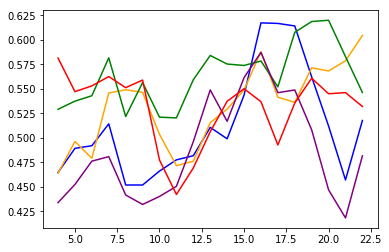

In [131]:
urban_predict = PlotPerformance(urban, splits, my_start, lag, clf_choice, f_sets)

In [121]:
#Separated by word class: 